In [3]:
######## Imports ########
#%matplotlib qt
import math
import numpy as np
import scipy.io
import os, sys
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds
import plotly.graph_objects as go
import pandas as pd
import random
mpl.rcParams['mathtext.default'] = 'regular'
print(mpl.matplotlib_fname())
#plt.rcParams.update({'font.size': 30, 'font.family':'arial', 'font.weight':'normal'})
plt.rcParams["axes.linewidth"] = 1.0
#plt.rcParams.update({'font.family':'Arial'})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
os.chdir('/Users/aravind/Research/PostDoc/Research/CytoSim/')
def generateemptylist(nrows,ncols):
    listret = []
    for r in range(nrows):
        lrow= []
        for c in range(ncols):
            lrow.append([])
        listret.append(lrow)
    return listret

new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])

/Users/aravind/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


# Generate icosphere - FIGURE S2 A, B

Code modified from https://sinestesia.co/blog/tutorials/python-icospheres/ ++
Actin filaments that are close to (100nm from) the boundary are considered and mapped on to the icosphere planar discretizations to generate a surface actin density field.

6


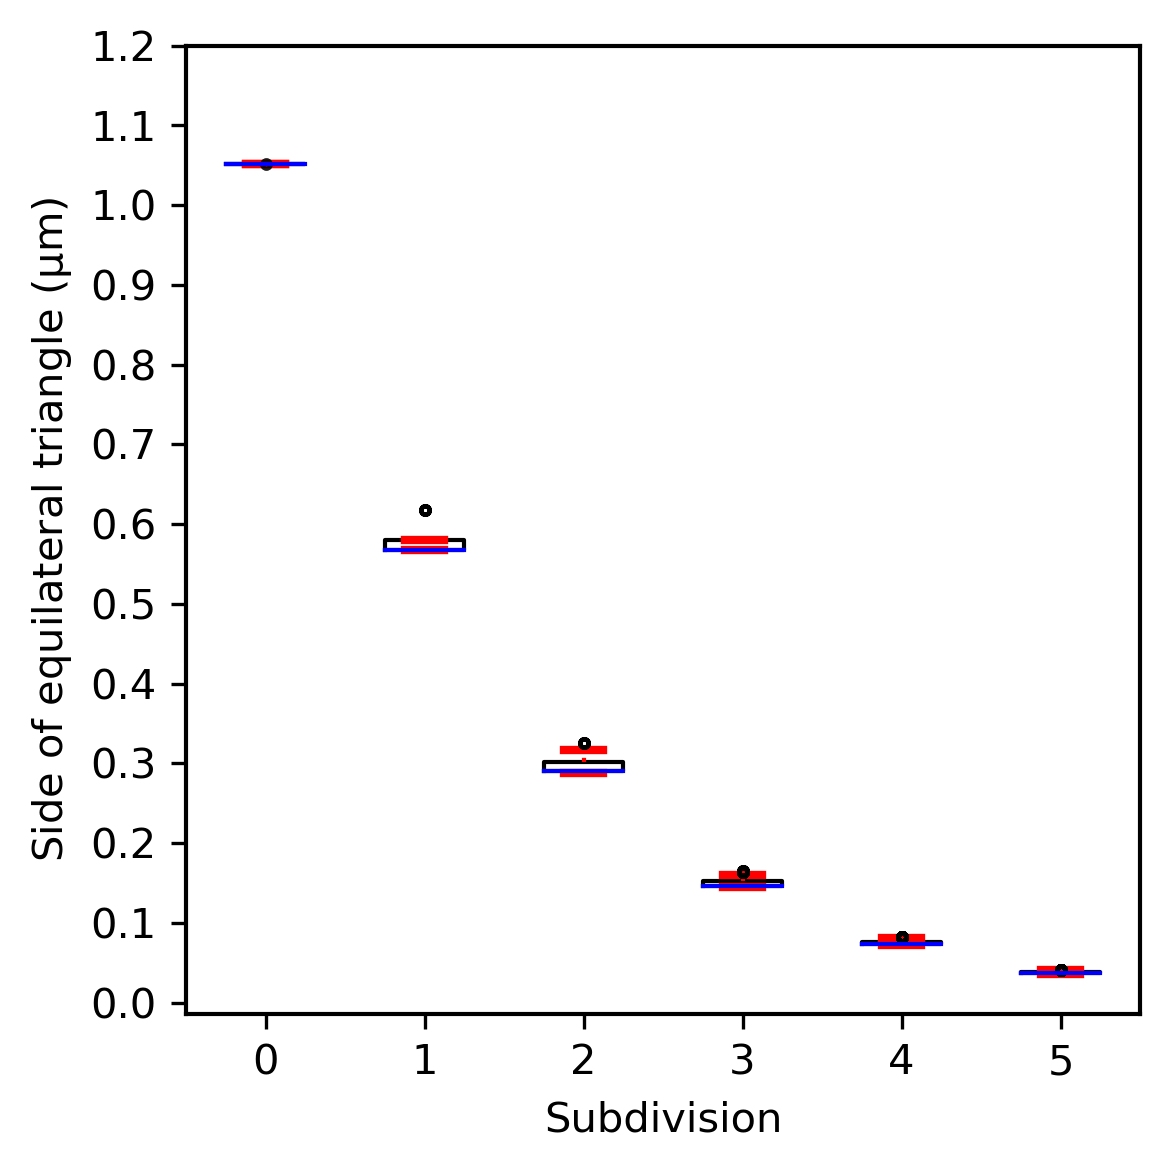

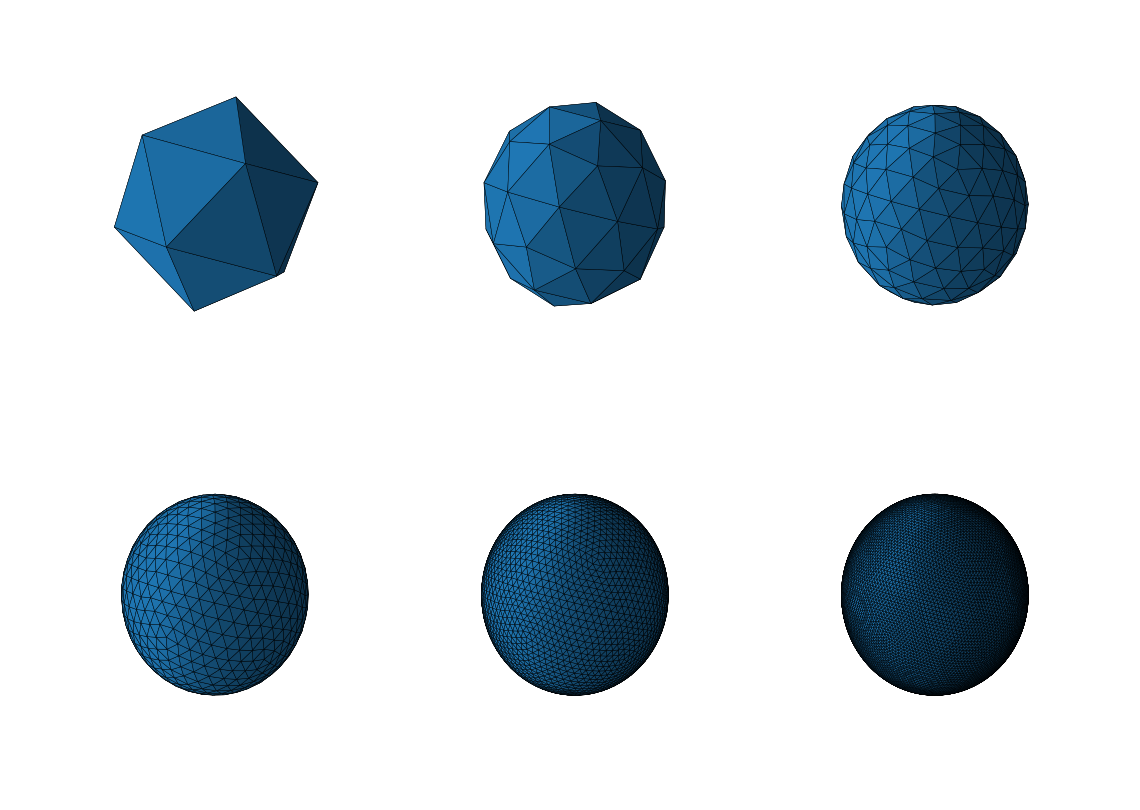

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R
def vertex(x, y, z): 
    """ Return vertex coordinates fixed to the unit sphere """ 
    length = np.sqrt(x**2 + y**2 + z**2) 
    return [i / length for i in (x,y,z)] 

def middle_point(verts,middle_point_cache,point_1, point_2): 
    """ Find a middle point and project to the unit sphere """ 
    # We check if we have already cut this edge first 
    # to avoid duplicated verts 
    smaller_index = min(point_1, point_2) 
    greater_index = max(point_1, point_2) 
    key = '{0}-{1}'.format(smaller_index, greater_index) 
    if key in middle_point_cache: return middle_point_cache[key] 
    # If it's not in cache, then we can cut it 
    vert_1 = verts[point_1] 
    vert_2 = verts[point_2] 
    middle = [sum(i)/2 for i in zip(vert_1, vert_2)] 
    verts.append(vertex(*middle)) 
    index = len(verts) - 1 
    middle_point_cache[key] = index 
    return index

def icosphere(subdiv,radius):
    # verts for icosahedron
    r = (1.0 + np.sqrt(5.0)) / 2.0;
    verts = np.array([[-1.0, r, 0.0],[ 1.0, r, 0.0],[-1.0, -r, 0.0],
                      [1.0, -r, 0.0],[0.0, -1.0, r],[0.0, 1.0, r],
                      [0.0, -1.0, -r],[0.0, 1.0, -r],[r, 0.0, -1.0],
                      [r, 0.0, 1.0],[ -r, 0.0, -1.0],[-r, 0.0, 1.0]]);
    # rescale the size to radius of 0.5
    verts /= np.linalg.norm(verts[0])
    # adjust the orientation
    r = R.from_quat([[0.19322862,-0.68019314,-0.19322862,0.68019314]])
    verts = r.apply(verts)
    verts = list(verts)
    # indicates vertices that form each of the triangles
    faces = [[0, 11, 5],[0, 5, 1],[0, 1, 7],[0, 7, 10],
             [0, 10, 11],[1, 5, 9],[5, 11, 4],[11, 10, 2],
             [10, 7, 6],[7, 1, 8],[3, 9, 4],[3, 4, 2],
             [3, 2, 6],[3, 6, 8],[3, 8, 9],[5, 4, 9],
             [2, 4, 11],[6, 2, 10],[8, 6, 7],[9, 8, 1],];
    
    for i in range(subdiv):
        middle_point_cache = {}
        faces_subdiv = []
        for tri in faces: 
            v1  = middle_point(verts,middle_point_cache,tri[0], tri[1])
            v2  = middle_point(verts,middle_point_cache,tri[1], tri[2])
            v3  = middle_point(verts,middle_point_cache,tri[2], tri[0])
            faces_subdiv.append([tri[0], v1, v3]) 
            faces_subdiv.append([tri[1], v2, v1]) 
            faces_subdiv.append([tri[2], v3, v2]) 
            faces_subdiv.append([v1, v2, v3]) 
        faces = faces_subdiv
    if type(radius) is float:
        return [np.array(verts)*radius/1.0, np.array(faces)]
    else:
        verts = np.array(verts)
        verts[:,0] *= radius[0]
        verts[:,1] *= radius[1]
        verts[:,2] *=radius[2]
        return [np.array(verts), np.array(faces)]

def gettrianglearea(meshvar):
    vertices=meshvar[0];
    triangles=meshvar[1];
    area=[];
    # get the number of triangles
    tsize=np.shape(triangles)
    for i in range(0,tsize[0]):
        face = triangles[i][:]
        #get the vertex coordinates
        v1 = vertices[face[0],:]
        v2 = vertices[face[1],:]
        v3 = vertices[face[2],:]
        # generate vectors
        vec1 = v2 - v1
        vec2 = v3 - v1
        area.append(0.5*np.linalg.norm(np.cross(vec1,vec2)))
    return np.array(area)
def testicosphere():
    # Code execution 
    nr = 1
    nc = 1
    fig, ax = plt.subplots(nrows=nr, ncols=nc,figsize=(4, 4), dpi=300, facecolor='w', edgecolor='k')
    from mpl_toolkits.mplot3d import Axes3D
    datalist = []
    for f in range(0,6):
        #nr = 1
        #nc = 2
        #fig, ax = plt.subplots(nrows=nr, ncols=nc,figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
        test=icosphere(f,1.0)
        vertices=test[0];
        triangles=test[1];
        # get array of areas of each triangle
        area=gettrianglearea(test);
        datalist.append(np.sqrt(4*area/np.sqrt(3)))
    print(len(datalist))
    bp = ax.boxplot(datalist)
    ax.set_xlabel('Subdivision')
    ax.set_ylabel(r"Side of equilateral triangle $(\mu m)$")
    ax.set_xticklabels(np.arange(0,6))
    ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2])

    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='red',
                    linewidth = 1.0,
                    linestyle =":")
    
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='red',
                linewidth = 2)
    
    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='blue',
                linewidth = 1)
    
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='o',
                color ='#e7298a',
                markersize = 2,
                alpha = 0.5)

        # Plotter
        # ax=plt.subplot(nr,nc,2*f+1, projection='3d')
        # ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles = triangles, edgecolor=[[0,0,0]], linewidth=1.0, alpha=0.0, shade=False)
        # ax = plt.subplot(nr,nc,2*f+2);
        #tsize=np.shape(triangles)
        #ax.plot([0.5,1.5],[4*np.pi/tsize[0],4*np.pi/tsize[0]])
        # ax.boxplot(area)
        # ax.set_ylabel('Triangle area')
        # plt.tight_layout();

        # ax.boxplot(np.sqrt(area/np.pi))
        # print(np.median(np.sqrt(area/np.pi)))
    plt.tight_layout()
    plt.savefig('AspectRatio_vs_discretization.png', dpi=300)
    plt.savefig('AspectRatio_vs_discretization.pdf', dpi=300)
testicosphere()

def plotisocphere_subdiv_gallery():
    nr = 2; nc = 3
    fig, ax = plt.subplots(nrows=nr, ncols=nc,figsize=(4, 4), dpi=300, facecolor='w', edgecolor='k')
    for f in range(0,6):
        # test=icosphere(f,1.0)
        a = 1
        b = 2
        c = 5
        test=icosphere(f,[a,b,c])
        vertices=test[0];
        triangles=test[1];
        ax=plt.subplot(nr,nc,f+1, projection='3d')
        # SPHERE
        RADIUS = 1.35  # Control this value.
        # ax.set_xlim3d(-RADIUS / 2, RADIUS / 2)
        # ax.set_zlim3d(-RADIUS / 2, RADIUS / 2)
        # ax.set_ylim3d(-RADIUS / 2, RADIUS / 2)
        # In order to visualize ellipsoids
        # ax.set_xlim3d(-a,a)
        # ax.set_zlim3d(-b,b)
        # ax.set_ylim3d(-c,c)
        ax.set_box_aspect((1, 1, 1))
        p3dc = ax.plot_trisurf(vertices[:,0], 
                                vertices[:,1], vertices[:,2], 
                                triangles = triangles, edgecolor=[[0,0,0]], linewidth=0.1, shade=True)
        ax.axis('off')
    plt.subplots_adjust(left=0.05,
            right=0.95,
            bottom=0.3, 
            top=0.95,
            wspace=0.0, 
            hspace=0.0)
    # plt.savefig('icosphere_gallery.png', dpi=300)
    # plt.savefig('icosphere_gallery.pdf', dpi=300)
    #plt.tight_layout()
plotisocphere_subdiv_gallery()

def concentricisosphere():
    # Code execution 
    nr = 1
    nc = 1
    fig, ax = plt.subplots(nrows=nr, ncols=nc,figsize=(10, 15), dpi=300, facecolor='w', edgecolor='k')
    f=1
    test=icosphere(f,1.0)
    vertices=test[0];
    triangles=test[1];
    # Plotter
    ax=plt.subplot(nr,nc,1, projection='3d')
    ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles = triangles, edgecolor=[[0,0,0]], linewidth=2.0, alpha=0.0, shade=False)
    factor=0.9;
    ax.plot_trisurf(factor*vertices[:,0], factor*vertices[:,1], factor*vertices[:,2], triangles = triangles, color='green', alpha=0.3, edgecolor=[[1,0,0]], linewidth=1.0, shade=True)
    plt.tight_layout();

def generateunitnormals(meshvar,radius):
    vertices=meshvar[0];
    triangles=meshvar[1];
    tsize=np.shape(triangles)
    unitnormal=[]
    frac=radius*0.9
    for i in range(0,tsize[0]):
        unitnormtriangle=[];
        face = triangles[i,:]
        #get the vertex coordinates
        v1 = vertices[face[0],:]
        v2 = vertices[face[1],:]
        v3 = vertices[face[2],:]
        # generate vectors
        vec1 = v2 - v1
        vec2 = v3 - v2
        vec3 = v1 - v3
        vec4 = v1 - frac*v1
        vec5 = v2 - frac*v2
        vec6 = v3 - frac*v3
        # +ve distance is outside
        #cross product
        cpvec12=np.cross(vec1,vec2)
        normval=np.linalg.norm(cpvec12)
        cpvec12=cpvec12/normval
        d = cpvec12[0]*v1[0] + cpvec12[1]*v1[1] + cpvec12[2]*v1[2]
        cpvec12 = np.append(cpvec12,d)

        cpvec14=np.cross(vec1,vec4)
        normval=np.linalg.norm(cpvec14)
        cpvec14=cpvec14/normval
        d = cpvec14[0]*v1[0] + cpvec14[1]*v1[1] + cpvec14[2]*v1[2]
        cpvec14 = np.append(cpvec14,d)

        cpvec25=np.cross(vec2,vec5)
        normval=np.linalg.norm(cpvec25)
        cpvec25=cpvec25/normval
        d = cpvec25[0]*v2[0] + cpvec25[1]*v2[1] + cpvec25[2]*v2[2]
        cpvec25 = np.append(cpvec25,d)

        cpvec36=np.cross(vec3,vec6)
        normval=np.linalg.norm(cpvec36)
        cpvec36=cpvec36/normval
        d = cpvec36[0]*v1[0] + cpvec36[1]*v1[1] + cpvec36[2]*v1[2]
        cpvec36 = np.append(cpvec36,d)

        unitnormtriangle.append(cpvec12)
        unitnormtriangle.append(cpvec14)
        unitnormtriangle.append(cpvec25)
        unitnormtriangle.append(cpvec36)
        unitnormal.append(np.array(unitnormtriangle))
    return unitnormal
# https://computergraphics.stackexchange.com/questions/10831/how-can-i-get-a-signed-distance-sdf-from-a-mesh

# Read CytoSim trajectory
args[0] - file path 

NOTE: ANALYSIS OF ICOSPHERE AND OTHER ORDER PARAMETERS IS DONE USING THE ACCOMPANYING PYTHON CODE (RATHER THAN THE NOTEBOOK)

In [54]:
import subprocess
class replicate:
    ridx = 0;
    Nsnaps = 0;
    snap = [];
    timevector = []
    def __init__(self, rid):
        self.ridx = rid
        self.Nsnaps = 0
        self.snap = [];
        self.timevector =[];
    def addsnapshot(self):
        self.snap.append(snapshot(1))


class snapshot:
    sidx = 0;
    filcoord=[]
    crossboundcoord=[];
    crossboundblobid = [];
    crossboundfilid = [];
    solidcoord = [];
    shapevec = [];
    def __init__(self, sid):
        self.sidx = sid
        self.filcoord = [];
        self.crossboundcoord = [];
        self.crossboundblobid = [];
        self.crossboundfilid = [];
        self.solidcoord = [];
        self.shapevec = [];

def readcytosimtraj (*args):
    if(len(args)):
        filepath = args[0]
        filename = 'objects.cmo'
    else:
        print('CHECK ARGS.....')

    # Get number of solids
    test = subprocess.run(["./get_nsolids.sh","-f", filepath],
                        capture_output=True)
    nsolids = int(test.stdout)
    r=[];
    Nruns =1 
    for  i in range(0,Nruns):
        r.append(replicate(i))
    printstatus = False;
    recordStatus = False;

    ridx = 0;
    sidx=-1;
    # Open file
    fptr = open(filepath+filename,'r')
    for line in fptr:
        if(printstatus):
            print(line)

        if('time' in line):
            t = float((line.split(' '))[1])
            r[ridx].timevector.append(t)
            r[ridx].addsnapshot();
            sidx = sidx + 1
            r[ridx].snap[sidx].solidcoord = [None]*nsolids

        elif('#section fiber' in line):
            fcoord=[];
            line = fptr.readline()
            if(printstatus):
                print(line)
            while(not('section' in line)):
                if(printstatus):
                    print(line)
                if('f2' in line):
                    recordStatus = False;
                if('f1' in line):
                    if(fcoord):
                        r[ridx].snap[sidx].filcoord.append(np.array(fcoord))
                        fcoord=[];
                    recordStatus = True;
                elif(' ' in line[0] and recordStatus):
                    line = line.strip()
                    cstring = line.split(' ')
                    fcoord.append([float(cstring[0]), float(cstring[1]), float(cstring[2])])
                line = fptr.readline()
            #when it exists, if fcoord has not been recorded, record it.
            if(fcoord):
                r[ridx].snap[sidx].filcoord.append(np.array(fcoord))
                fcoord=[];
        if('#section space' in line):
            line = fptr.readline()
            splitline = line.split()
            if('sphere' in line):
                temp = float(splitline[len(splitline)-1])
            else:
                temp = [float(splitline[2]),float(splitline[3]),float(splitline[4]),]
            r[ridx].snap[sidx].shapevec= temp
        # Bound crosslinker hands
        if('#section solid' in line):
            line = fptr.readline()
            while(not('section' in line)):
                if(printstatus):
                    print(line)
                #Get solid ID
                line = line.strip()
                cstring = line.split(' ')
                cstring = cstring[0].split(':')
                solidid = int(cstring[1])
                solidcoord = [];
                line = fptr.readline()
                while(line[0]!='d' and not('section' in line)):
                    #Get coord
                    line = line.strip()
                    cstring = line.split(' ')
                    solidcoord.append([float(cstring[0]), float(cstring[1]), float(cstring[2])])
                    line = fptr.readline()
                if(solidcoord):
                    r[ridx].snap[sidx].solidcoord[solidid-1] = np.array(solidcoord)
            
            # Bound crosslinker hands
            if('#section single A' in line):
                blobid = []
                line = fptr.readline()
                if(printstatus):
                    print(line)
                while(not('section' in line)):
                    if(printstatus):
                        print(line)
                    line = line.strip()
                    cstring = line.split()
                    r[ridx].snap[sidx].crossboundfilid.append(int(cstring[1][1:len(cstring[1])]))
                    r[ridx].snap[sidx].crossboundblobid.append(int(cstring[3][1:len(cstring[3])]))
                    line = fptr.readline()
    fptr.close()
    print('Number of snapshots='+str(len(r[ridx].snap)))
    fptr.close()
    return r

# Functions to calculate triangle density field

In [4]:
# Create bead triangle neighbor list with a simple filter
# Key bead , value - triangle
# Use normal to find distance
# If a triangle is within range, check the neighboring triangles.
# Assign the bead to just one neighbor
# Keep a counter in each triangle
def generateNeighborList(meshvar):
    # Simpler implementation
    #Step 1.
    # Find neighbors of each triangle into a list of lists
    # Go through the vertices
    # For each vertex, find triangles that contain the vertex.
    vertices = meshvar[0]
    triangles = meshvar[1]
    Nvert = (np.shape(vertices))[0]
    Ntriangles = (np.shape(triangles))[0]
    VTneighborlist = [] #Vertex triangle neighborlist
    TTneighborlist= [[]] * Ntriangles
    for i in range(0,Nvert):
        vtosearch  = i
        neighbors = []
        for j in range(0,Ntriangles):
            tvec = triangles[j][:]
            if(np.in1d(vtosearch,tvec)):
                neighbors.append(j)
        neighbors = np.sort(neighbors)
        VTneighborlist.append(neighbors)
        # Go through the neighbors. Add them to each other's list
        for t1iter, t1 in enumerate(neighbors):   
            temp = TTneighborlist[t1]     
            temp2 = np.setdiff1d(neighbors,t1).tolist()
            if(len(temp)):            
                temp2 = temp+temp2
                temp2.sort()
            TTneighborlist[t1] = temp2
    return [TTneighborlist,VTneighborlist]

def generatesphericalcoords(meshvar):
    vertices = meshvar[0]
    triangles = meshvar[1]
    tsize=np.shape(triangles)
    comvec = np.zeros((tsize,))
    costhetavec = np.zeros((tsize,))
    cosphivec = np.zeros((tsize,))
    for i in range(0,tsize[0]):
        face = triangles[i][:]
        #get the vertex coordinates
        v1 = vertices[face[0],:]
        v2 = vertices[face[1],:]
        v3 = vertices[face[2],:]
        com = (v1+v2+v3)/3
        comvec[i] = com
        normval = np.linalg.norm(com)
        tanval = com[1]/com[0]
        costhetavec[i] = 1/np.sqrt(1+tanval*tanval)
        cosphivec[i] = com[2]/normval
        return [costhetavec,cosphivec]



def interpolateallmonomers (fc):
    interpcoord = []
    Nbeads = (np.shape(fc))[0]
    interpcoords = []
    for i in range(0,Nbeads-1):
        cyl1 = fc[i,:]
        cyl2 = fc[i+1,:]
        cyllength = np.linalg.norm(cyl2-cyl1)
        nmonomers = int(np.ceil(cyllength/2.7e-3))
        #Add minus end
        interpcoords.append(cyl1)
        # Add rest of the monomers
        for mid in range(1,nmonomers-1):
            alpha = mid/nmonomers
            tmp = cyl1*(1-alpha) + alpha*cyl2
            interpcoords.append(tmp)
        #Add plus end
        interpcoords.append(cyl2)
    return np.array(interpcoords)
        

#Go through triangle
#Step 2.
# Assign a triangle for each bead
# For first bead in the filament, go through all triangles
# For other beads, start with triangle that prev. bead is assigned to, then its neighbors before going on to other triangles.
from enum import Enum
class SearchAlgoType(Enum):
    ORIGINAL = 1
    LISTEDSEARCH = 2
    SPHERICALSEARCH = 3
# Check 2A - distance from top triangle plane
def checkdist_bead_tangle(bc,t,donestatus, unitnormal,actincounter, printStatus=False):
    if(donestatus[t]):
        return False
    else:
        donestatus[t] = True
    foundstatus = False
    dthreshold = 0.2
    normmat = unitnormal[t] 
    unvec = normmat[0,:] #Has 4 normals

    #den = unvec[0]*unvec[0] + unvec[1]*unvec[1] + unvec[2]*unvec[2]
    distval = abs(unvec[0]*bc[0] + unvec[1]*bc[1] + unvec[2]*bc[2] - unvec[3])
    if(distval<dthreshold):
        # Check 2B - If the distance constraint is satisfied,
        #check if point is within the cake slice

        slice1norm = normmat[1,:]
        slice2norm = normmat[2,:]
        slice3norm = normmat[3,:]
        slice1dist = 0
        slice2dist = 0
        slice3dist = 0
        for d in range(0,3):
            slice1dist = slice1dist + slice1norm[d]*bc[d]
            slice2dist = slice2dist + slice2norm[d]*bc[d]
            slice3dist = slice3dist + slice3norm[d]*bc[d]
        if(slice1dist <=0 and slice2dist <=0 and slice3dist <=0):
            if(printStatus):
                foundtriangle=t
                print('Found '+str([f,b]))
                print('Distance from center='+str(np.linalg.norm(bc)))
                print('Distance from triangle plane='+str(distval))
            foundstatus = True
            actincounter[t] = actincounter[t] + 1;
    return foundstatus

def generatedensityfield(meshvar, unitnormal, filcoord, f, plotcheck=False, searchType = SearchAlgoType.ORIGINAL, Nlists = [], sphericalc=[]):
    printStatus = True
    #print('Number of filaments='+str(len(filcoord)))
    vertices = meshvar[0]
    triangles = meshvar[1]
    Nvert = (np.shape(vertices))[0]
    Ntriangles = (np.shape(triangles))[0]
    dthreshold = 0.2
    if plotcheck:
        foundtriangle = -1
    # if (f==0):
    #     dthreshold_4m_center = 1-0.39;
    # elif(f==1):
    #     dthreshold_4m_center = 1-0.211
    # elif(f==2):
    #     dthreshold_4m_center = 1 - 0.108
    # elif(f==3):
    #     dthreshold_4m_center = 1 - 0.054
    # elif(f==4):
    #     dthreshold_4m_center = 1 - 0.027
    # else:
    #     dthreshold_4m_center = 1-0.014
    dthreshold_4m_center =  0.9*0.9
    actincounter = list(np.zeros((Ntriangles,)))
    #foundcounter = 0;
    total_actin  = 0
    for f, fc in enumerate(filcoord):
        # Interpolate each monomer in the filament
        #interpcoord = interpolateallmonomers(fc)
        interpcoord = fc
        Nbeads = (np.shape(interpcoord))[0]
        counter = 0
        #foundvector = np.zeros((Nbeads,))
        init_tangle_list = []

        if searchType==SearchAlgoType.SPHERICALSEARCH:
            tanthetavec = sphericalc[0]
            cosphivec = sphericalc[1]

        for b in range(0,Nbeads):
            foundstatus = False
            total_actin = total_actin + 1
            bc = interpcoord[b,:]
            # Check 1 - distance from center
            dfromcenter = round(bc[0]*bc[0]+bc[1]*bc[1]+bc[2]*bc[2],2)
            if(dfromcenter>=dthreshold_4m_center):
                #tracks if this triangle has been considered for this particular bead
                donestatus = [False] * Ntriangles
                ####
                t_search_list = list(np.arange(0,Ntriangles))

                if searchType==SearchAlgoType.LISTEDSEARCH:
                    TTNlist = Nlists[0];
                    #go through initial list
                    if init_tangle_list:
                        for t in init_tangle_list:
                            # Check 2A - distance from top triangle plane
                            foundstatus=checkdist_bead_tangle(bc,t,donestatus, unitnormal,actincounter);
                            if(foundstatus):
                                #foundcounter = foundcounter + 1
                                init_tangle_list = [t]+TTNlist[t]
                                break;
                    if not(foundstatus):
                        #set diff
                        #t_search_list = list(np.setdiff1d(t_search_list,init_tangle_list))
                        #random sampling
                        #t_randomized  = random.sample(t_search_list, k=np.shape(t_search_list)[0])
                        #t_randomized = t_search_list
                        for tier, t in enumerate(t_search_list):
                            foundstatus=checkdist_bead_tangle(bc,t,donestatus, unitnormal,actincounter);
                            if(foundstatus):
                                #foundcounter = foundcounter + 1
                                init_tangle_list = [t]+TTNlist[t]
                                break;
                                
                elif searchType==SearchAlgoType.SPHERICALSEARCH:
                    costhetavec = sphericalc[0]
                    cosphivec = sphericalc[1]
                    Rgtangle = 0.027
                    zthreshold = 1/Rgtangle

                else:
                    for t in range(0,Ntriangles):
                        if(donestatus[t]):
                            continue;
                        else:
                            donestatus[t] = 1

                        # Check 2A - distance from top triangle plane
                        normmat = unitnormal[t] 
                        unvec = normmat[0,:] #Has 4 normals

                        #den = unvec[0]*unvec[0] + unvec[1]*unvec[1] + unvec[2]*unvec[2]
                        distval = abs(unvec[0]*bc[0] + unvec[1]*bc[1] + unvec[2]*bc[2] - unvec[3])

                        # if(t==0):
                        #     foundvector[b] = distval
                        # else:
                        #     foundvector[b] = np.minimum(distval,foundvector[b])

                        if(distval<dthreshold):
                            # Check 2B - If the distance constraint is satisfied,
                            #check if point is within the cake slice

                            slice1norm = normmat[1,:]
                            slice2norm = normmat[2,:]
                            slice3norm = normmat[3,:]
                            slice1dist = 0
                            slice2dist = 0
                            slice3dist = 0
                            for d in range(0,3):
                                slice1dist = slice1dist + slice1norm[d]*bc[d]
                                slice2dist = slice2dist + slice2norm[d]*bc[d]
                                slice3dist = slice3dist + slice3norm[d]*bc[d]
                            if(slice1dist <=0 and slice2dist <=0 and slice3dist <=0):
                                if plotcheck:
                                    foundtriangle=t
                                if(printStatus):
                                    print('Found '+str([f,b]))
                                    print('Distance from center='+str(np.linalg.norm(bc)))
                                    print('Distance from triangle plane='+str(distval))
                                foundstatus = True
                                actincounter[t] = actincounter[t] + 1;
                                #foundcounter = foundcounter + 1
                                # foundvector[b] = 2
                                break;
                    
            if(not(foundstatus) and printStatus):
                print('Could not find '+str([f,b]))
                print('Distance from center='+str(round(np.linalg.norm(bc),2)))
            if(foundstatus and plotcheck):
                plotcurrent(meshvar,actincounter, bc,'temp',foundtriangle)
                actincounter = np.zeros((Ntriangles,))
    #print('Total monomers ='+str(total_actin))
    #print('found ='+str(foundcounter))
    #print('Found fraction='+str(foundcounter/total_actin))
    #print(foundcounter)
    return np.array(actincounter)

## FIGURE 3A - Ploter function for density field
meshvar - output from icosphere function.

actincounter - vector of the same length as number of triangles in the mesh. Used to hold the number of actin monomers within a given triangle. 

bc - bead coordinates 

savename -filename to save



In [118]:
def plotcurrent(meshvar,actincounter, bc,savename,*args):
    import matplotlib.cm as cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from mpl_toolkits import mplot3d
    vertices = meshvar[0]
    triangles = meshvar[1]
    Ntriangles = np.shape(triangles)[0]
    minval = np.min(actincounter)
    maxval = np.max(actincounter)
    actincounter = np.subtract(actincounter,minval)/(maxval-minval)
    norm = mpl.colors.Normalize(vmin=min(actincounter), vmax=max(actincounter))
    cmap = cm.RdYlGn_r
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = m.to_rgba(actincounter)
    #Get the face color
    #Get a series of colors
    #Normalize the value by which you want to color. 
    nr=1;nc=2;
    fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(5, 3), dpi=300, 
                              facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=0.05,
                    right=0.95,
                    bottom=0.3, 
                    top=0.95,
                    wspace=0.0, 
                    hspace=0.0)

    # Plot the bundle or point
    if(len(args)):
        ax=plt.subplot(nr,nc,0, projection='3d')
        ax.scatter3D(bc[0],bc[1],bc[2], color='#74B357')
        temp=args[0];
        if(np.shape(temp)[0]):
            foundtriangle = temp;
            ft=triangles[foundtriangle,:]
            for iter in range(0,3):
                ax.scatter3D(vertices[ft[iter],0],
                             vertices[ft[iter],1],
                             vertices[ft[iter],2], linewidth=1, color='blue')
        ax.axis('off')
    else:
        filcoord = bc
        # Plot the bundle
        for ppos in range(0,1):
            ax=plt.subplot(nr,nc,ppos+1, projection='3d')
            for f, fc in enumerate(filcoord):
                ax.plot3D(fc[:,0],fc[:,1],fc[:,2], 'o',linewidth=2, color='#74B357')
        ax.axis('off')
    plt.figtext(0.15,0.93, 'Snapshot with F-actin', 
                transform=plt.gcf().transFigure)
    plt.figtext(0.6,0.93, 'Surface density of F-actin', 
                transform=plt.gcf().transFigure)
    # Plot the mesh in both subplots
    for ppos in range(0,nc):
        ax=plt.subplot(nr,nc,ppos+1, projection='3d')
        RADIUS = 1.35  # Control this value.
        ax.set_xlim3d(-RADIUS / 2, RADIUS / 2)
        ax.set_zlim3d(-RADIUS / 2, RADIUS / 2)
        ax.set_ylim3d(-RADIUS / 2, RADIUS / 2)
        ax.set_box_aspect((1, 1, 1))
        p3dc = ax.plot_trisurf(vertices[:,0], 
                               vertices[:,1], vertices[:,2], 
                               triangles = triangles, edgecolor=[[0,0,0]], linewidth=0.1, shade=True)
        ax.axis('off')
        if(ppos==0):
            ctemp = np.zeros((Ntriangles,4))
            p3dc.set_fc(ctemp)
        else:
            # set the face colors of the Poly3DCollection
            # Check if all elements in array are zero
            is_all_zero = np.argwhere((actincounter == 0))
            #colors[:,3]=0.8
            colors[is_all_zero] = 0.0
            p3dc.set_fc(colors)
            axins = inset_axes(
            ax,
            width="5%",  # width: 5% of parent_bbox width
            height="50%",  # height: 50%
            loc="lower left",
            bbox_to_anchor=(1.05, 0.25, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
            fig.colorbar(m, cax=axins, shrink=0.5,aspect=15)
    
    # for ii in range(0,360,1):
    #     for ppos in range(0,nc):
    #         ax=plt.subplot(nr,nc,ppos+1, projection='3d')
    #         ax.view_init(elev=140, azim=ii)
    #         plt.savefig(savename+f'{ii:03d}'+'.png', dpi=300, bbox_inches='tight')
#plotcurrent(meshvar,actincounter, filcoord, savename)
filcoord_copy = [filcoord_all[8]]
actincounter = generatedensityfield(meshvar, unitnormal, filcoord_copy, f, True, SearchAlgoType.LISTEDSEARCH, Nlists)
# acountraw = actincounter
# actincounter = actincounter/tarea
# savename = dirname
# plotcurrent(meshvar,actincounter, filcoord_copy, savename)

NameError: name 'filcoord_all' is not defined



# TEST FUNCTION FOR Frac occupied time series
PLEASE NOTE THAT THE ACTUAL ANALYSIS WAS DONE USING PYTHON CODE ACCOMPANYING THIS NOTEBOOK

In [ ]:
f=4
meshvar=icosphere(f,1.0);
vertices = meshvar[0]
triangles = meshvar[1]
Ntriangles = np.shape(triangles)[0]
unitnormal = generateunitnormals(meshvar,1.0)
tarea = gettrianglearea(meshvar)
Nlists = generateNeighborList(meshvar)
#Generate
if True:
    deltasnap = 25
    flist=[];
    for ridx in range(0,28):
        r = rlist10_3[ridx]
        foccupied=[];
        Nsnaps = len(r[0].snap)
        for SREF in range(0,Nsnaps,deltasnap):
            filcoord = r[0].snap[SREF].filcoord 
            actincounter = generatedensityfield(meshvar, unitnormal, filcoord, f, False, SearchAlgoType.LISTEDSEARCH, Nlists)
            #Order Parameter #3
            is_all_zero = np.argwhere((actincounter == 0.0))
            #foccupied.append(len(is_all_zero))
            foccupied.append(1-len(is_all_zero)/Ntriangles)
        flist.append(foccupied)


## PLOTTER STERIC VERSION - FIGURE 3 B AND FIGURE S2C

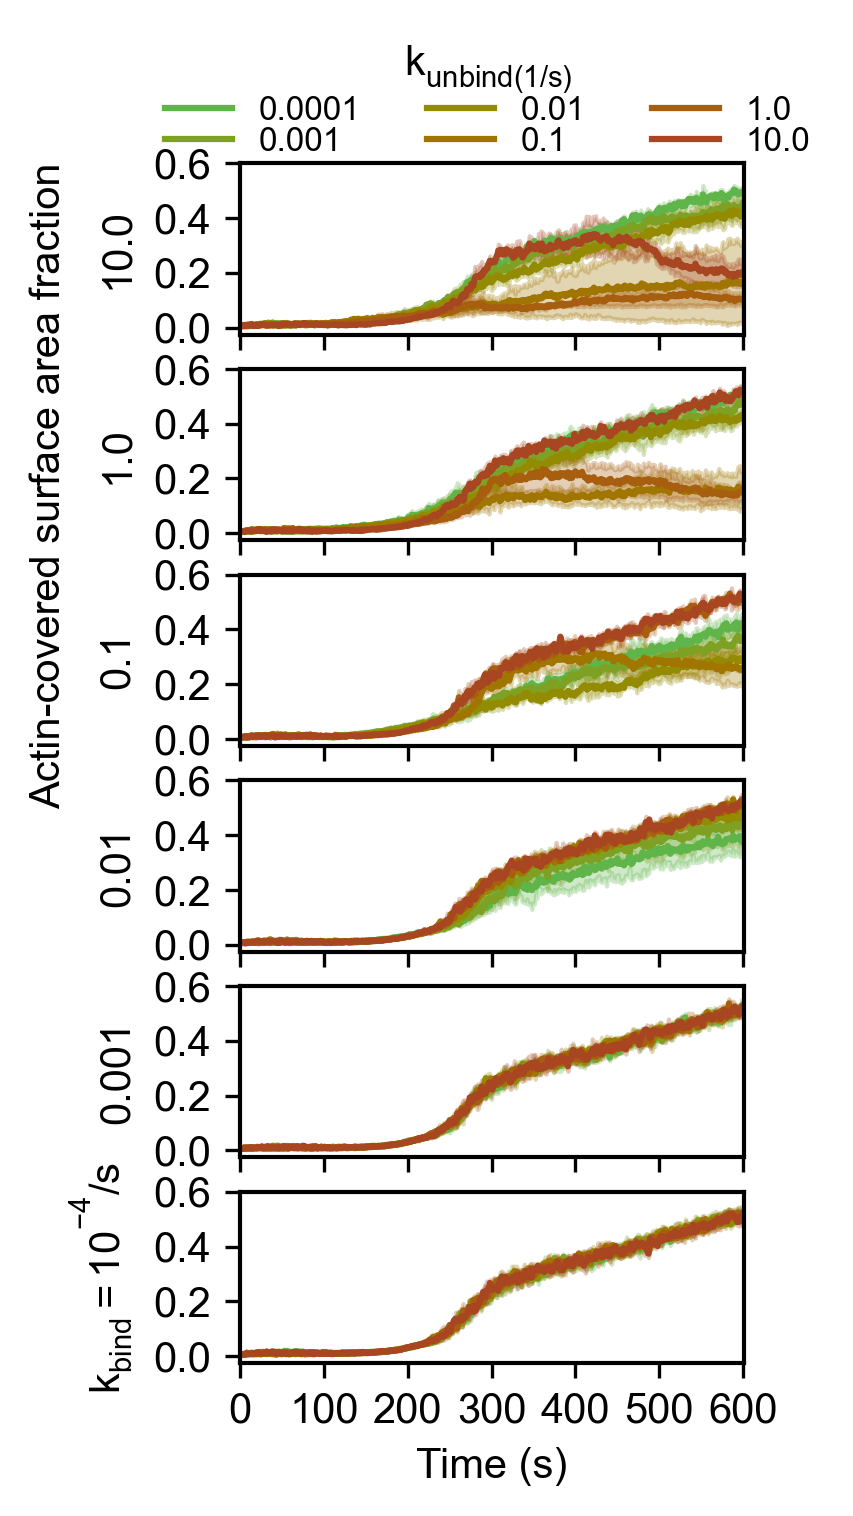

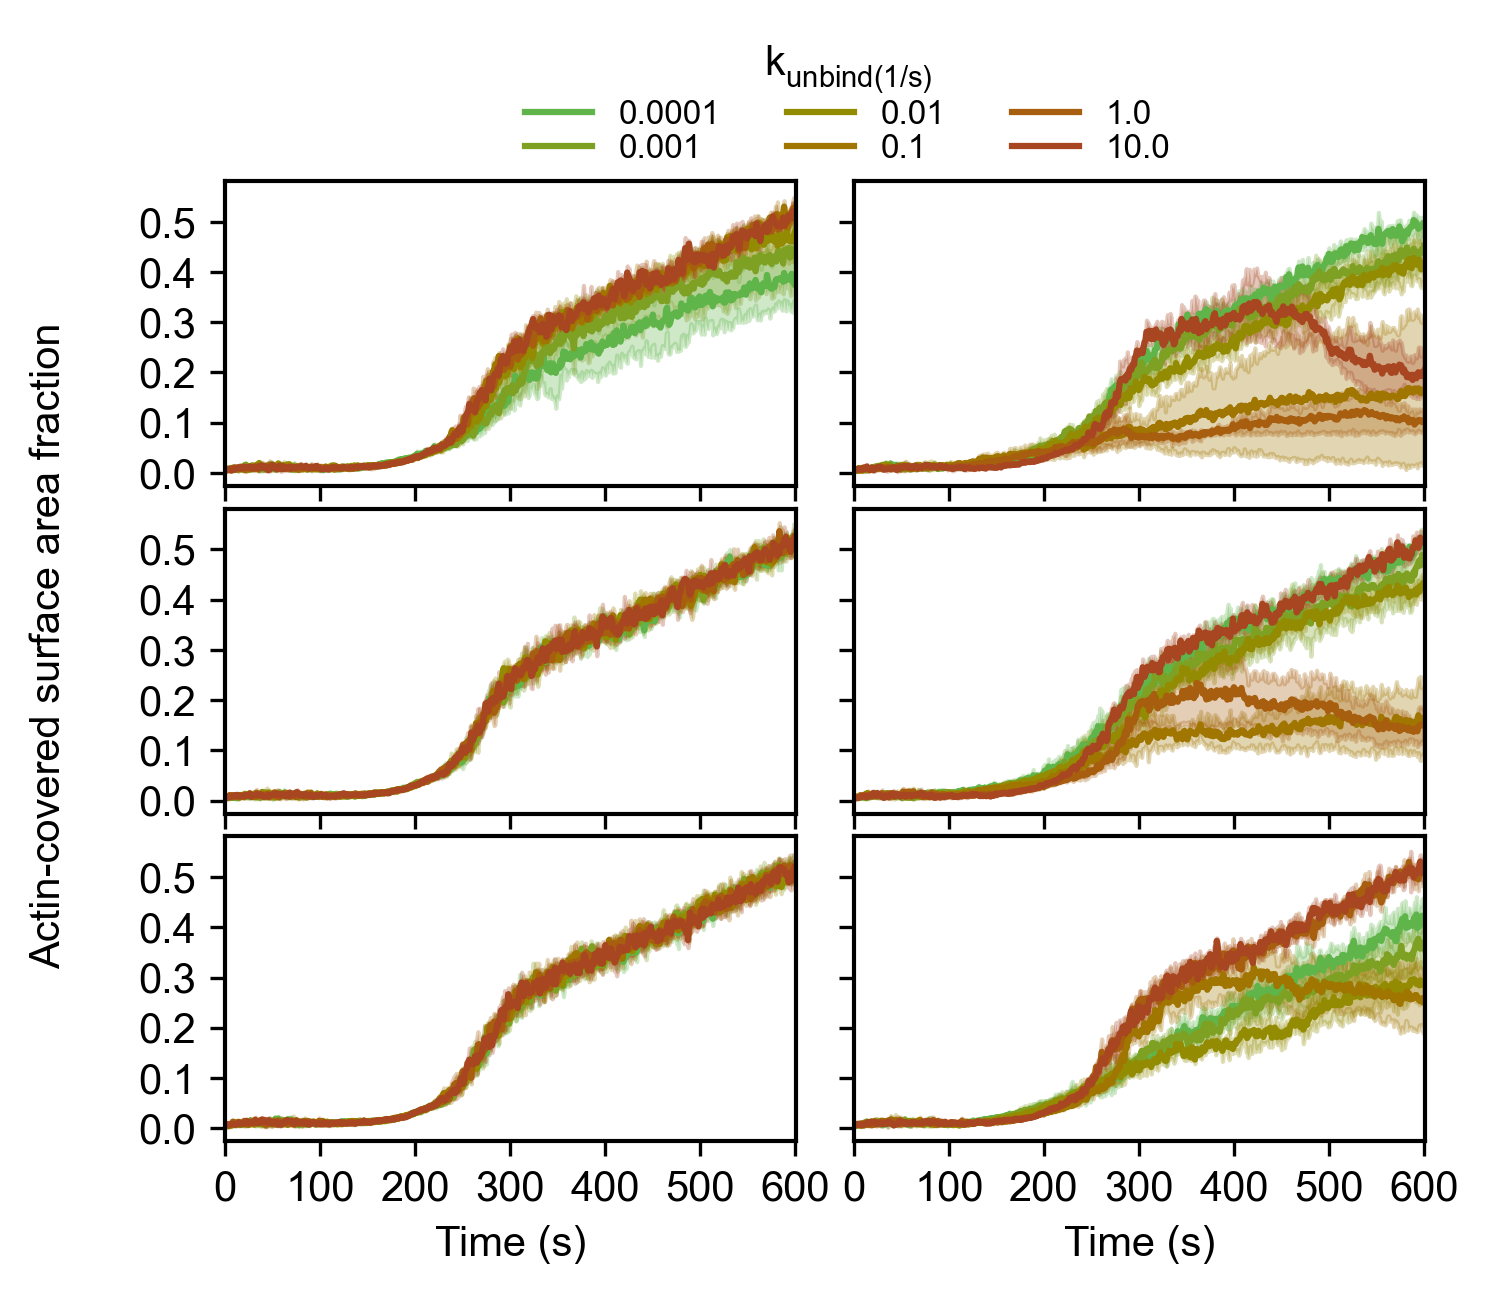

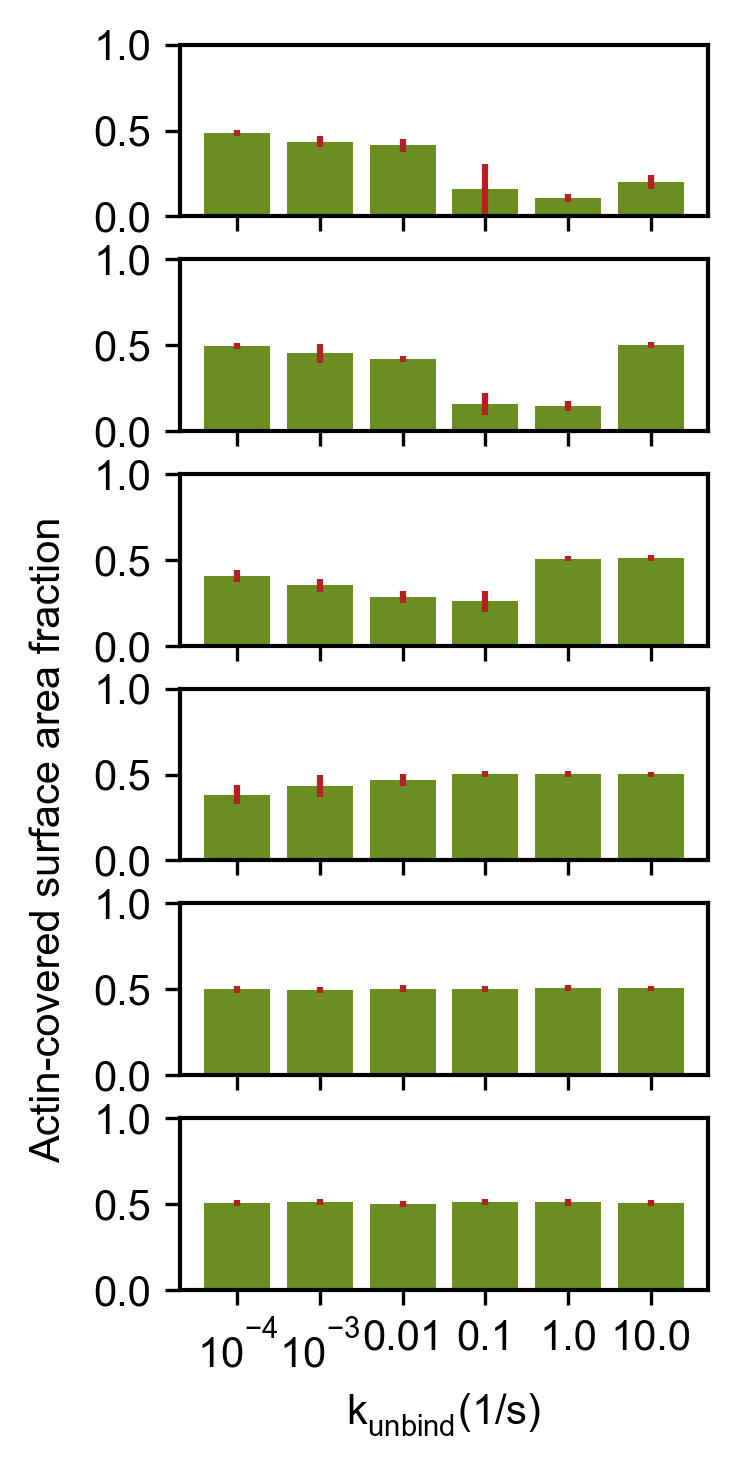

In [58]:
# Load all replicates
# Take mean and std
# plot 5 rows 1 column plots
# Figure 1 time series
# Figure 2 Bar plot
# Row 0 - Time
# Row 1 - fraction of occupied triangles 
filereadpath = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/analysis_scripts/tscc_outputfiles/'
jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
colorlist = ['#5fb549','#7ea124','#938c02','#a07500','#a75e0e','#a84621','#a22f31']
kbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
kunbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
labelvec=[r"$10^{-4}$",r"$10^{-3}$",'0.01','0.1','1.0','10.0']
Meanlist = []
Stdlist = []
mean_frac_bar = []
std_frac_bar = []
for koniter, kbind in enumerate(kbindvec):
    for koffiter, kunbind in enumerate (kunbindvec):
        bar_raw_data = np.array([])
        Row1=[]
        Rval = koniter*len(kunbindvec)+koffiter
        for repid in range(0,3):
            fvar = filereadpath+'/FO_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            datavec = df.iloc[1].to_numpy()
            Row1.append(datavec)
            barstartpos = int(0.95*len(datavec))
            bar_raw_data = np.append(bar_raw_data,datavec[barstartpos:])
        Row1 = np.array(Row1)
        Meanlist.append(np.mean(Row1,0))
        Stdlist.append(np.std(Row1,0))
        mean_frac_bar.append(np.mean(bar_raw_data))
        std_frac_bar.append(np.std(bar_raw_data))
Timevec = df.iloc[0].to_numpy()
# Figure 1 - Bound crosslinkers Time series - 40% width
# Figure 2 - Number of UNIQUE filaments per crosslinker Time series - 40$ width
# Figure 3 - Bar plot - 20% width
nr = 6; nc = 1 
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(2,5), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
for plotcounter in range(0,nr):
    legcell = []
    for val in range(0,nr):
        Rval = plotcounter*len(kunbindvec) + val
        ax = axvec[nr-plotcounter-1]
        x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
        legcell.append(x[0]);
        ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
plt.text(-0.2, 0.475,  'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
axvec[5].set_xlabel('Time (s)')
axvec[5].set_xlim([0,601])
#axvec[5].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axvec[5].set_yticks([0,0.2,0.4,0.6])
axvec[5].set_xticks([0,100,200,300,400,500,600])
axvec[5].set_ylabel(r"$k_{bind}=10^{-4}/s$")
axvec[4].set_ylabel(r"0.001")
axvec[3].set_ylabel(r"0.01")
axvec[2].set_ylabel(r"0.1")
axvec[1].set_ylabel(r"1.0")
axvec[0].set_ylabel(r"10.0")
leg = fig.legend(legcell, kunbindvec,title=r"$k_{unbind (1/s)}$",ncol=3,fontsize=8,frameon=False,
                bbox_to_anchor=(1.15, 1.0), labelspacing=0.0)
plt.subplots_adjust(left=0.15,
                    right=0.99,
                    bottom=0.1, 
                    top=0.9,
                    wspace=0.0, 
                    hspace=0.2)
plt.savefig('Fgrow10_3_FO_steric_1colpng', dpi=300, bbox_inches='tight')
plt.savefig('Fgrow10_3_FO_steric_1col.pdf', dpi=300, bbox_inches='tight')
##################################################################
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
fig_width = np.array([0.4,0.4,0.2])*7
fig_height = 4
# Figure 1 TIME SERIES
nr = len(kbindvec); nc = 1 
fig, axvec = plt.subplots(nrows=3, ncols=2,figsize=(5,4), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plotcounter = 0;
for cid in range(0,2):
    for rid in range(0,3):
        legcell = []
        for val in range(0,len(kunbindvec)):
            Rval = plotcounter*len(kunbindvec) + val
            ax = axvec[3-rid-1][cid]
            x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
            legcell.append(x[0]);
            ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
        plotcounter = plotcounter + 1

plt.text(0.02,0.25, 'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
axvec[2][0].set_xlabel('Time (s)')
axvec[2][1].set_xlabel('Time (s)')
axvec[2][0].set_xlim([0,601])
axvec[2][0].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axvec[2][0].set_xticks([0,100,200,300,400,500,600])
leg = fig.legend(legcell, kunbindvec,title=r"$k_{unbind (1/s)}$",ncol=3,fontsize=8,frameon=False,
                bbox_to_anchor=(0.8, 1.04), labelspacing=0.1)
plt.subplots_adjust(left=0.15,
                    right=0.95,
                    bottom=0.1, 
                    top=0.9,
                    wspace=0.1, 
                    hspace=0.075)
#plt.tight_layout(pad=0.2)
plt.savefig('Fgrow10_3_FO_steric.png', dpi=300, bbox_inches='tight')
plt.savefig('Fgrow10_3_FO_steric.pdf', dpi=300, bbox_inches='tight')
# Figure 2 BAR##################################################################
nr = len(kbindvec); nc = 1
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(2.0,5.0), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.subplots_adjust(left=0.1,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.15, 
                    hspace=0.25)
for plotcounter in range(0,nr):
    legcell = []
    ax = axvec[nr-plotcounter-1]
    lenval = len(kunbindvec)
    meandata = mean_frac_bar[plotcounter*lenval:(plotcounter+1)*lenval]
    stddata = std_frac_bar[plotcounter*lenval:(plotcounter+1)*lenval]
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,len(kunbindvec)))
    ax.set_xticklabels(labelvec, rotation = 0)
ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([0,0.5,1.0])
axvec[nr-1].set_xlabel(r"$k_{unbind} (1/s)$")
plt.text(-0.15, 0.14, 'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
plt.savefig('Fgrow10_3_FO_steric_bar.png', dpi=300, bbox_inches='tight')
plt.savefig('Fgrow10_3_FO_steric_bar.pdf', dpi=300, bbox_inches='tight')
# Figure 3 ERROR BAR PLOTS
# fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(2,2), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
# startidx = 0
# endidx = 35
# axvec.errorbar(mean_frac_bar[startidx:endidx],mean_vasp_list[startidx:endidx],xerr=std_frac_bar[startidx:endidx],yerr=std_vasp_list[startidx:endidx], fmt = 'o', markersize = 0, ecolor='firebrick')
# axvec.set_xlim([0,1])
# axvec.set_ylim([-0.01,4])

## Plotter $T_{2 \pi R}$ - STERIC VERSION - NOT SHOWN IN PAPER

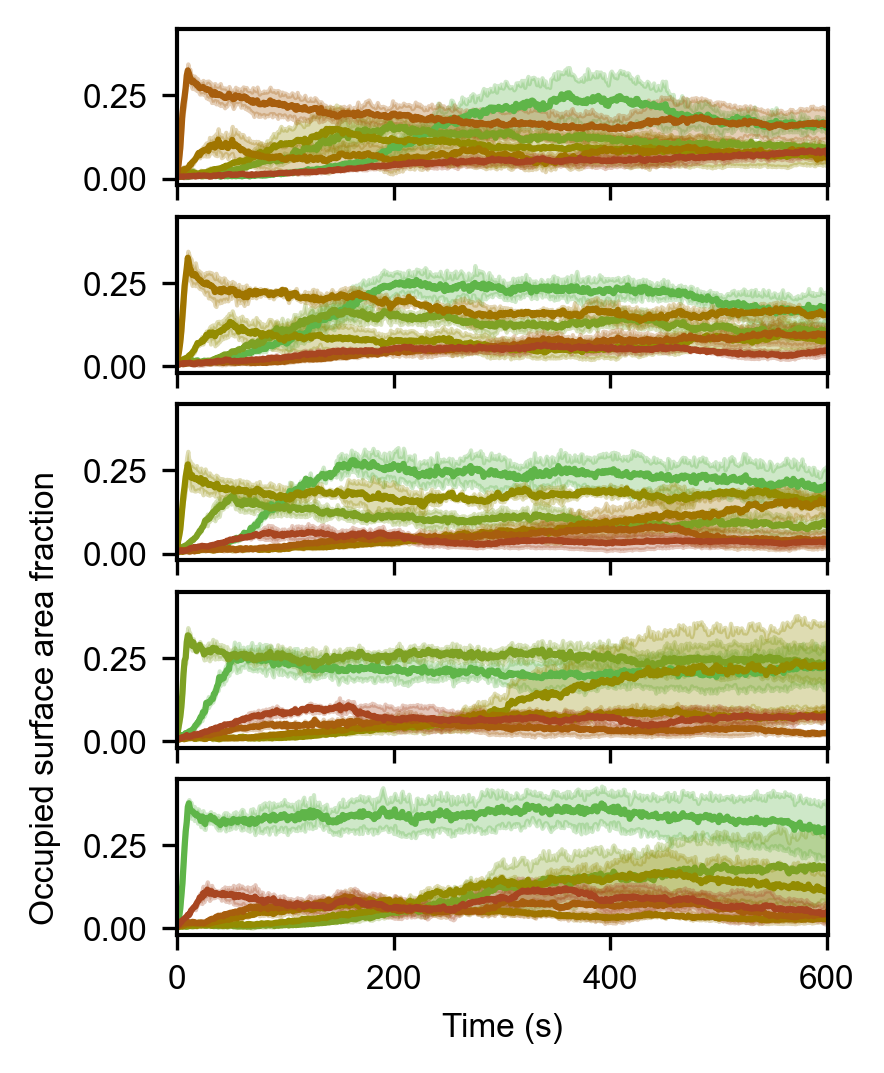

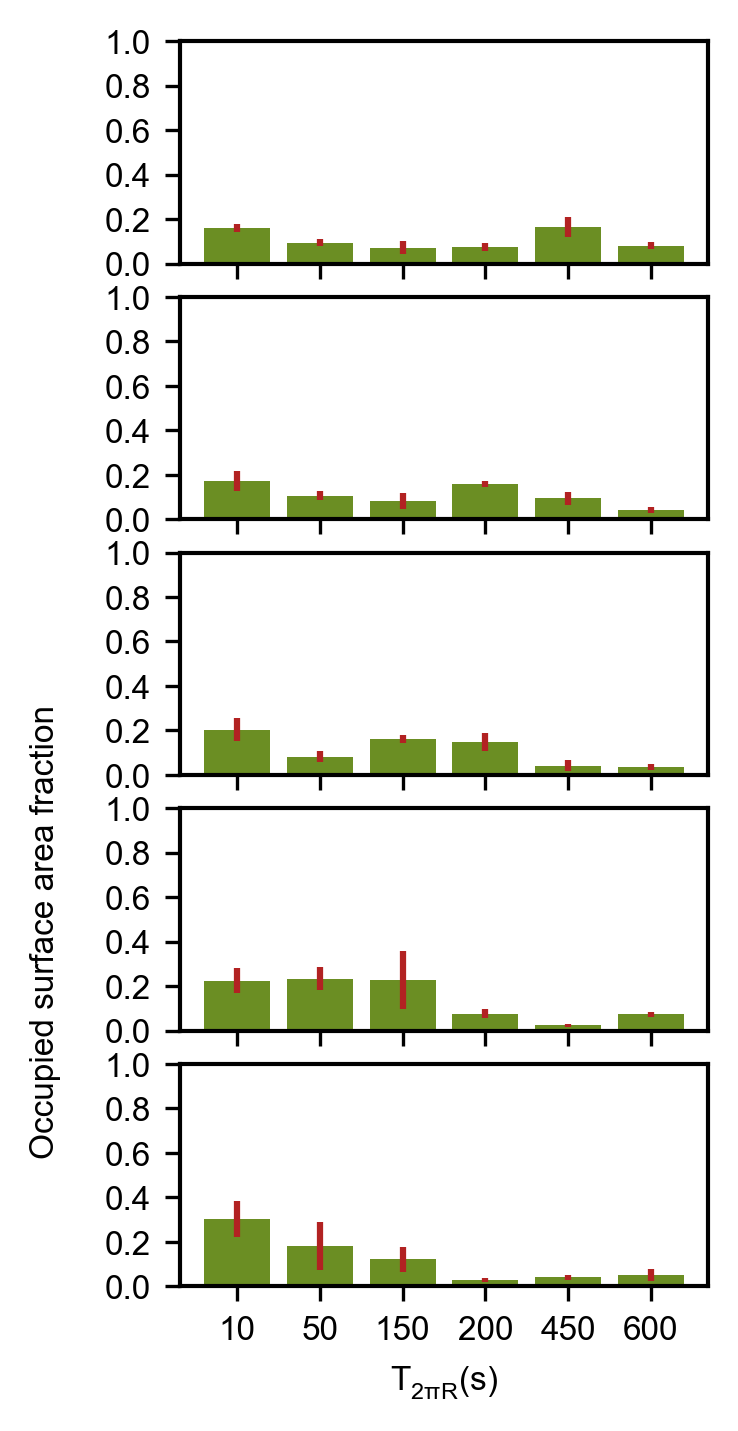

In [121]:
# Load all replicates
# Take mean and std
# plot 5 rows 1 column plots
# Figure 1 time series
# Figure 2 Bar plot
# Row 0 - Time
# Row 1 - fraction of occupied triangles 
filereadpath = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/analysis_scripts/tscc_outputfiles/'
colorlist = ['#5fb549','#7ea124','#938c02','#a07500','#a75e0e','#a84621','#a22f31']
Vasp_conc = [0.2, 0.4, 0.8, 1.0, 2.0]
T2piR=[10, 50, 150, 200, 450, 600]
Meanlist = []
Stdlist = []
mean_frac_bar = []
std_frac_bar = []
Nreps = 3
for vconciter, vconc in enumerate(Vasp_conc):
    for titer, tval in enumerate (T2piR):
        bar_raw_data = np.array([])
        Row1=[]
        Rval = titer*len(Vasp_conc)+vconciter
        for repid in range(0,Nreps):
            #fvar = filereadpath+'/FO_Actin_addn_ring_nosteric_tscc_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            fvar = filereadpath+'/FO_Actin_addn_ring_steric_tscc_30nm_rigidity_0_075_set2_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            datavec = df.iloc[1].to_numpy()
            Row1.append(datavec)
            barstartpos = int(0.95*len(datavec))
            bar_raw_data = np.append(bar_raw_data,datavec[barstartpos:])
        Row1 = np.array(Row1)
        Meanlist.append(np.mean(Row1,0))
        Stdlist.append(np.std(Row1,0))
        mean_frac_bar.append(np.mean(bar_raw_data))
        std_frac_bar.append(np.std(bar_raw_data))
Timevec = df.iloc[0].to_numpy()
# Figure 1 - Bound crosslinkers Time series - 40% width
# Figure 2 - Number of UNIQUE filaments per crosslinker Time series - 40$ width
# Figure 3 - Bar plot - 20% width
plt.rcParams.update({'font.size': 8, 'font.family':'arial', 'font.weight':'normal'})
fig_width = np.array([0.4,0.4,0.2])*7
fig_height = 4
# Figure 1 TIME SERIES
nr = 5; nc = 1 
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(fig_width[0],fig_height), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
for plotcounter in range(0,5):
    legcell = []
    for val in range(0,6):
        Rval = val*5+plotcounter
        ax = axvec[nr-plotcounter-1]
        x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
        legcell.append(x[0]);
        ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
plt.text(-0.05, 0.14, 'Occupied surface area fraction', transform=plt.gcf().transFigure, rotation=90)
axvec[4].set_xlabel('Time (s)')
axvec[4].set_xlim([0,601])
plt.savefig('T2piR_FO_steric_timeseries.png', dpi=300, bbox_inches='tight')
# Figure 2 BAR
nr = 5; nc = 1
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(2.0,5.0), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.subplots_adjust(left=0.1,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.1, 
                    hspace=0.15)
for plotcounter in range(0,5):
    legcell = []
    ax = axvec[nr-plotcounter-1]
    meandata = []
    stddata = []
    for l in range(plotcounter,30,5):
        meandata.append(mean_frac_bar[l])
        stddata.append(std_frac_bar[l])
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(T2piR)
ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[4].set_xlabel(r"$T_{2\pi R} (s)$")
plt.text(-0.15, 0.14, 'Occupied surface area fraction', transform=plt.gcf().transFigure, rotation=90)
plt.savefig('T2piR_FO_steric_bar.png', dpi=300, bbox_inches='tight')

# Snapshot printer - USED TO GENERATE MOVIES SHOWN IN PAPER

[['Actin_VASP_ratio_set4/R_0_r_0' 'Actin_VASP_ratio_set4/R_1_r_0'
  'Actin_VASP_ratio_set4/R_2_r_0' 'Actin_VASP_ratio_set4/R_3_r_0']
 ['Actin_VASP_ratio_set4/R_5_r_0' 'Actin_VASP_ratio_set4/R_6_r_0'
  'Actin_VASP_ratio_set4/R_7_r_0' 'Actin_VASP_ratio_set4/R_8_r_0']
 ['Actin_VASP_ratio_set4/R_10_r_0' 'Actin_VASP_ratio_set4/R_11_r_0'
  'Actin_VASP_ratio_set4/R_12_r_0' 'Actin_VASP_ratio_set4/R_13_r_0']]
(3, 4)


/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_2322/2322535826.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

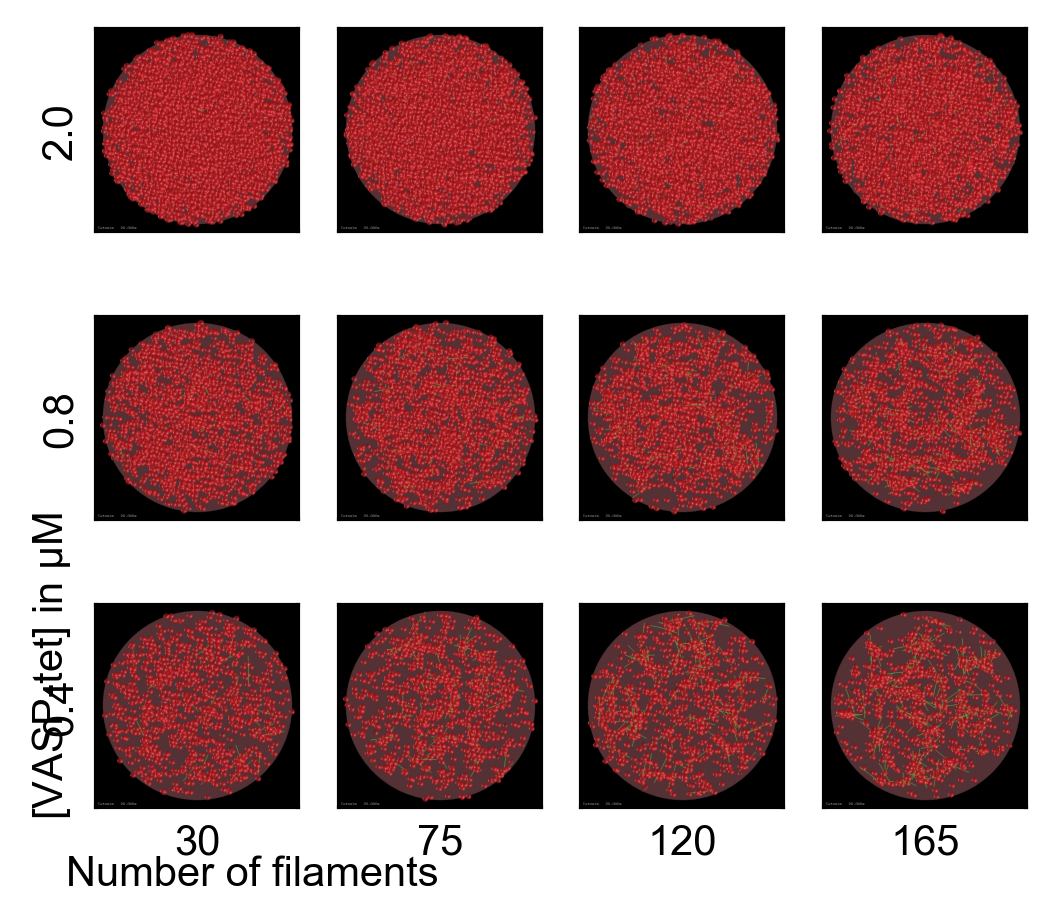

In [4]:
from os.path import exists
from skimage import data
from skimage import io
from skimage import transform
from skimage import color
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
##
import cv2
import glob
import re
from PIL import Image

image_input_dir = '/Users/aravind/Research/PostDoc/Research/CytoSim/'
image_file_extension='png'
frame_rate = 30
video_output_name = 'test'
##

plt.rcParams.update({'font.size': 30, 'font.family':'arial', 'font.weight':'normal'})
plt.rcParams["axes.linewidth"] = 1.0
#plt.rcParams.update({'font.family':'Arial'})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    right=0.95,
                    bottom=0.5, 
                    top=0.95,
                    wspace=0.05, 
                    hspace=0.05)


# nr = 5
# nc = 6
# decoratetag = 100
# plt.rcParams.update({'font.size': 30, 'font.family':'arial', 'font.weight'
#                     :'normal'})
# filepathv = './FIGURE_5/INPUTFILES'
# videofilename = 'FIGURE5'
# extratag ='/'
# repid = 0
# offset = 0
# coloffset = 7
# repid = 0
# dirlist = []
# setval = 4
# for i in range(0,6):
#     dirrow = []
#     for j in range(0,5):
#         Rval = i*5 + j
#         dirrow.append('R_'+str(Rval)+'_r_'+str(0)+'/')
#     dirlist.append(dirrow)
# # Create the transpose of the dirlist
# dirlist = np.array(dirlist).T
# print(dirlist)
# plt.subplots_adjust(left=0.1,
#                     right=0.99,
#                     bottom=0.0, 
#                     top=0.99,
#                     wspace=0.03, 
#                     hspace=0.03)
# extraspace = 0.25
# extraspaceleft = 0.5;
# filepath='';
# dirname=''
# xlabellist = [10, 50, 150, 200, 450, 600]
# ylabellist = [0.2,0.4,0.8,1.0,2.0]
# xaxislabel = r'$T_{2\pi R}$'
# yaxislabel = r'$[VASP-tet] in \mu M$'
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,5,2.5,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
#######################################################################
# nr = 6
# nc = 2
# decoratetag = 100
# filepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/Actin_addn_ring_steric_tscc_30nm_rigidity_0_075_set2/'
# videofilename = 'Actin_addn_ring_steric_tscc_VASP_0_4_30nm_gallery'
# extratag ='/'
# repid = 0
# offset = 0
# coloffset = 7
# repid = 0
# dirlist = []
# firstdir = 4
# dirvec = [7,22]
# dirvec = [6,21]
# for i in range(0,2):
#     dirid = dirvec[i]
#     dirrow = []
#     for j in range(0,6):
#         dirrow.append('R_'+str(dirid)+'_r_'+str(j)+'/')
#     dirlist.append(dirrow)
# # Create the transpose of the dirlist
# dirlist = np.array(dirlist).T
# print(dirlist)
# plt.subplots_adjust(left=0.1,
#                     right=0.99,
#                     bottom=0.0, 
#                     top=0.99,
#                     wspace=0.01, 
#                     hspace=0.01)
# extraspace = 0.25
# extraspaceleft = 0.5;
# filepath='';
# dirname=''
# xlabellist = [10,50, 150, 200, 450, 600]
# xlabellist=[10,450]
# ylabellist = [1,2,3,4,5,6,7,8,9,10]
# xaxislabel = r'$T_{2 \pi R} (s)$'
# yaxislabel = r"Replicates when $[VASP-tet] = 0.4 \mu M$"
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,100,2.5,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
# ########################
# nr = 6
# nc = 6
# decoratetag = 100
# filepathv = 'FIGURES_23'
# videofilename = 'FIGURES_23'
# extratag ='/'
# repid = 0
# offset = 0
# coloffset = 7
# repid = 0
# dirlist = []
# firstdir = 2
# dirrow = []
# for i in range(0,nr):
#     dirrow = []
#     for j in range(0,nc):
#         Rval = i*nc + j
#         dirrow.append('R_'+str(Rval)+'_r_'+str(0)+'/')
#     dirlist.append(dirrow)
    
# # Create the transpose of the dirlist
# #dirlist = np.array(dirlist).T
# print(dirlist)
# plt.subplots_adjust(left=0.2,
#                     right=0.99,
#                     bottom=0.0, 
#                     top=0.99,
#                     wspace=0.03, 
#                     hspace=0.03)
# extraspace = 0.25
# extraspaceleft = 0.75;
# filepath='';
# dirname=''
# xlabellist =  [r"$1 \times 10^{-4}$", '0.001','0.01','0.1','1.0','10.0']
# ylabellist = [r"$1 \times 10^{-4}$",'0.001','0.01','0.1','1.0','10.0']
# yaxislabel = r"$k_{bind} (1/s)$"
# xaxislabel = r"$k_{unbind} (1/s)$"
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,5,2.5,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
###########
# nr = 1
# nc = 8
# decoratetag = 100
# filepathv = './FIGURE_4/INPUTFILES/'
# videofilename = 'FIGURE_4'
# extratag ='/'
# repid = 0
# offset = 0
# coloffset = 7
# repid = 0
# dirlist = []
# firstdir = 2
# dirrow = []
# for i in range(0,1):
#     dirrow = []
#     for j in range(0,nc-1):
#         Rval = i*nc + j
#         dirrow.append('Actin_Lfil_sweep/R_'+str(Rval)+'_r_'+str(0)+'/')
#     dirrow.append('Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2/R_34_r_0/')    
#     dirlist.append(dirrow)
# # Create the transpose of the dirlist
# #dirlist = np.array(dirlist).T
# print(dirlist)
# extraspace = 0.25
# extraspaceleft = 0.75;
# filepath='';
# dirname=''
# xlabellist =  [r'$\frac{\pi R_{drop}}{4}$',r'$\frac{\pi R_{drop}}{3}$',r'$\frac{\pi R_{drop}}{2}$',r'$\frac{2\pi R_{drop}}{3}$',r'$\pi R_{drop}$',r'$\frac{4\pi R_{drop}}{3}$',r'$\frac{5\pi R_{drop}}{3}$',r'$2\pi R_{drop}}$']
# ylabellist = ['10.0, 1.0']
# yaxislabel = r"$k_{bind}, k_{unbind} (1/s)$"
# xaxislabel = r"$L_{fil}^{max} (\mu m)$"
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,5,2.5,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
#############################
###### ROW 1#######
# nr = 1
# nc = 6
# decoratetag = 100
# filepathv = './FIGURE_6/'
# videofilename = 'Actin_GAB_mutant_traj'
# extratag ='/'
# repid = 0
# offset = 0
# coloffset = 7
# repid = 0
# dirlist = []
# firstdir = 2
# kunbindvec =[1.0,1.125,1.15625, 1.1875,1.21875,1.25,1.28125,1.3125,1.34375,1.375,1.5,1.625,1.75,2.0,]
# Rvalvec = [28,0,0,1,2,0,3,4,5,1,1,2,2,3]
# dirrow = []
# for koffiter in range(1,7):
#     for repid in range(0,1):
#         if koffiter ==0:
#             jobfoldername ='Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
#             continue
#         else:
#             if koffiter in [5,10,12,13]:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set4'
#             elif koffiter in [2,3,4,6,7,8]:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set6'
#             else:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set5'
#     dirrow.append(jobfoldername+'/R_'+str(Rvalvec[koffiter])+'_r_'+str(repid)+'/')
#     if koffiter==6:
#         dirlist.append(dirrow)
#         dirrow=[];
# # Create the transpose of the dirlist
# dirlist = np.array(dirlist)
# print(dirlist)
# print(np.shape(dirlist))
# plt.subplots_adjust(left=0.1,
#                     right=0.99,
#                     bottom=0.0, 
#                     top=0.99,
#                     wspace=0.03, 
#                     hspace=0.03)
# extraspace = 0.25
# extraspaceleft = 0.75;
# filepath='';
# dirname=''
# xlabellist =  [1.125,1.15625,1.1875,1.21875,1.25,1.28125,1.3125,1.34375,1.375,1.5,1.625,1.75,2.0]
# ylabellist = [''];
# yaxislabel = ''
# xaxislabel = ''
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,5,1.0,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
###############################
####### ROW 2
# videofilename = 'Actin_GAB_mutant_traj_row2'
# dirrow = []
# dirlist = []
# for koffiter in range(7,13):
#     for repid in range(0,1):
#         if koffiter ==0:
#             jobfoldername ='Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
#             continue
#         else:
#             if koffiter in [5,10,12,13]:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set4'
#             elif koffiter in [2,3,4,6,7,8]:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set6'
#             else:
#                 jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set5'
#     dirrow.append(jobfoldername+'/R_'+str(Rvalvec[koffiter])+'_r_'+str(repid)+'/')
# dirlist.append(dirrow);
# xlabellist =  [1.3125,1.34375,1.375,1.5,1.625,1.75]
# trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
#             dirname,601,5,1.0,extratag,
#             xlabellist, ylabellist, xaxislabel, yaxislabel)
##################
nr = 3
nc = 4
decoratetag = 100
filepathv = './FIGURE_S11'
videofilename = 'FIGURE_S11'
extratag ='/'
repid = 0
offset = 0
coloffset = 7
repid = 0
dirlist=[[videofilename+'/R_0_r_0',videofilename+'/R_1_r_0',videofilename+'/R_2_r_0',videofilename+'/R_3_r_0'],
        [videofilename+'/R_5_r_0',videofilename+'/R_6_r_0',videofilename+'/R_7_r_0',videofilename+'/R_8_r_0'],
        [videofilename+'/R_10_r_0',videofilename+'/R_11_r_0',videofilename+'/R_12_r_0',videofilename+'/R_13_r_0'],]

# Create the transpose of the dirlist
dirlist = np.array(dirlist)
print(dirlist)
print(np.shape(dirlist))
plt.subplots_adjust(left=0.15,
                    right=0.99,
                    bottom=0.0, 
                    top=0.99,
                    wspace=0.03, 
                    hspace=0.03)
extraspace = 0.25
extraspaceleft = 0.75;
filepath='';
dirname=''
xlabellist =  [30,75,120,165]
ylabellist = [0.4,0.8,2.0];
xaxislabel = 'Number of filaments'
yaxislabel = r"[VASP-tet] in $\mu M$"
trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
            dirname,601,5,1.0,extratag,
            xlabellist, ylabellist, xaxislabel, yaxislabel)

## Snapshot printer SER

In [25]:
nr = 2
nc = 5
decoratetag = 100
filepathv = './FIGURE_7/INPUTFILES'
videofilename = 'SER_steric_Actinsweep_test3'
extratag ='/'
repid = 0
offset = 0
coloffset = 7
repid = 0
dirlist = []
foldername3 = 'SER_steric_Actinsweep_test3_tscc/'
foldername4 = 'SER_steric_Actinsweep_test4_tscc/'
dirrow = [[foldername3+'R_3_r_0/',foldername4+'R_2_r_0/',
          foldername3+'R_4_r_0/',foldername3+'R_5_r_0/',foldername3+'R_6_r_0/',
          ], 
          [foldername3+'R_0_r_0/',foldername3+'R_1_r_0/',foldername4+'R_0_r_0/',
          foldername3+'R_2_r_0/',foldername4+'R_1_r_0/'],]
dirlist = dirrow
    
# Create the transpose of the dirlist
#dirlist = np.array(dirlist).T
print(dirlist)
plt.subplots_adjust(left=0.2,
                    right=0.99,
                    bottom=0.0, 
                    top=0.99,
                    wspace=0.03, 
                    hspace=0.03)
extraspace = 0.25
extraspaceleft = 0.75;
filepath='';
dirname=''
xaxislabel = 'Steric K'
#########
xlabellist = ['','','','','']
titlelist =  [[r'$\frac{7\pi}{6}$',r'$\frac{15\pi}{12}$',r'$\frac{4\pi}{3}$',r'$\frac{5\pi}{3}$',r'$2\pi$'],
              [r'$ L_{fil}^{max} (\mu m) = \frac{2\pi}{3}$',r'$\frac{5\pi}{6}$',r'$\frac{11\pi}{12}$',r'$\pi$',r'$\frac{13\pi}{12}$'],]
ylabellist = ['','','','','']
yaxislabel = ''
xaxislabel = ''
trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
            dirname,451,2,2.5,extratag,
            xlabellist, ylabellist, xaxislabel, yaxislabel,titlelist)

[['SER_steric_Actinsweep_test3_tscc/R_3_r_0/', 'SER_steric_Actinsweep_test4_tscc/R_2_r_0/', 'SER_steric_Actinsweep_test3_tscc/R_4_r_0/', 'SER_steric_Actinsweep_test3_tscc/R_5_r_0/', 'SER_steric_Actinsweep_test3_tscc/R_6_r_0/'], ['SER_steric_Actinsweep_test3_tscc/R_0_r_0/', 'SER_steric_Actinsweep_test3_tscc/R_1_r_0/', 'SER_steric_Actinsweep_test4_tscc/R_0_r_0/', 'SER_steric_Actinsweep_test3_tscc/R_2_r_0/', 'SER_steric_Actinsweep_test4_tscc/R_1_r_0/']]


<Figure size 432x288 with 0 Axes>

# Linear Nucleator - MOVIES CORRESPONDING TO FIGURE S10

In [5]:
nr = 1
nc = 8
decoratetag = 100
# trial 1 used experimental values of kbind
filepathv = './FIGURE_S10/INPUTFILES/'
videofilename = 'linear_nucleator'
extratag ='/'
repid = 0
offset = 0
coloffset = 7
repid = 0
dirlist = []
for i in range(0,nr):
    dirrow = []
    for j in range(0,nc):
        Rval = j
        dirrow.append('R_'+str(Rval)+'_r_'+str(0)+'/')
    dirlist.append(dirrow)

# Create the transpose of the dirlist
#dirlist = np.array(dirlist).T
print(dirlist)
plt.subplots_adjust(left=0.1,
                    right=0.99,
                    bottom=0.0, 
                    top=0.99,
                    wspace=0.03, 
                    hspace=0.03)
extraspace = 0.25
extraspaceleft = 0.5;
filepath='';
dirname=''
ylabellist = ['','']
yaxislabel = ''
xlabellist = [0,10,25,50,75,100,125,150]
xaxislabel = '[Nucleator] (nM)'
trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
            dirname,601,5,1.0,extratag,
            xlabellist, ylabellist, xaxislabel, yaxislabel)

[['R_0_r_0/', 'R_1_r_0/', 'R_2_r_0/', 'R_3_r_0/', 'R_4_r_0/', 'R_5_r_0/', 'R_6_r_0/', 'R_7_r_0/']]


/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_2322/2322535826.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

# SNAPSHOT PRINTER FUNCTION

In [2]:
from os.path import exists
from skimage import data
from skimage import io
from skimage import transform
from skimage import color
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
##
import cv2
import glob
import re
from PIL import Image
def trajplotter(videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,dirname,Nsnaps,deltasnap,panelsize,extratag, xlabellist, ylabellist,*args):
    plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
    extension = ".png"
    img_array = []
    scalefactor = 1
    plt.subplots_adjust(left=0.1,
                        right=0.99,
                        bottom=0.9, 
                        top=0.99,
                        wspace=0.02/scalefactor, 
                        hspace=0.02/scalefactor)
    extraspace = 0.3
    extraspaceleft = 0
    length = panelsize*nc+extraspaceleft/scalefactor
    width = panelsize*(nr+extraspace*2)/scalefactor
    ################
    for snaps in range(0,Nsnaps,deltasnap):
        #print(snaps)
        fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(length, width), dpi=300, facecolor='w', edgecolor='k')
        if decoratetag ==24:
            line = plt.Line2D([0.08,0.9],[0.375,0.375], transform=fig.transFigure, color="black")
            fig.add_artist(line)
            line = plt.Line2D([0.08,0.9],[0.63,0.63], transform=fig.transFigure, color="black")
            fig.add_artist(line)
        if(nr==1):
            axvec=np.reshape(axvec, (1,nc))
        for r in range(0,nr):
            ylabelcounter = 0
            for c in range(0,nc):
                plotrow = nr-r-1;
                ax=axvec[plotrow][c]
                dirname = dirlist[r][c]
                if(len(dirname)==0):
                    ax.set_visible(False)
                    continue;
                else:
                    ylabelcounter = ylabelcounter + 1
                    
                fvar = filepathv+dirname+extratag+'/'+"movie"+ f'{snaps:04d}'+extension
                if(decoratetag==16):
                    fvar =  filepathv+dirname+'/'+"movie"+ f'{snapvec[c]:04d}'+extension
                if decoratetag == 2:
                    if 'v4' in dirname:
                        dirname = dirname[0:8]+'_koff_1e-1'
                        fvar = filepath+dirname+'/'+"movie"+ f'{snaps:04d}'+extension
                    else:
                        dirname = dirname.replace('-v','/v')
                        fvar = filepathv+dirname+'/'+"movie"+ f'{snaps:04d}'+extension
                if decoratetag ==3:
                    if 'kon' not in dirname:
                        fvar = filepathv+'/intermediate/'+dirname+'/'+"movie"+ f'{snaps:04d}'+extension

                # read an image
                if exists(fvar):
                    img = io.imread(fvar)
                    #img_half = transform.rescale(img, scale=0.5, multichannel=True)
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_axis_off
                    if r==0:
                        ax.set_xlabel(xlabellist[c])
                    if ylabelcounter == 1:
                        ax.set_ylabel(ylabellist[r])
                    if(len(args)==3):
                        ax.set_title(args[2][r][c])
                else:
                    print('Not found: '+fvar)
        if(len(args)==0):
            plt.text(0.0, 0.14, r'$k_{bind} (s^{-1})$', transform=plt.gcf().transFigure, rotation=90)
            plt.text(0.12, 0.03, r"$k_{unbind} (s^{-1})$", transform=plt.gcf().transFigure)
        else:
            plt.text(0.07, 0.14, args[1], transform=plt.gcf().transFigure, rotation=90)
            plt.text(0.1, 0.07, args[0], transform=plt.gcf().transFigure)
            # plt.text(0.0, 0.14, args[1], transform=plt.gcf().transFigure, rotation=90)
            # plt.text(0.12, 0.1, args[0], transform=plt.gcf().transFigure)

        plt.tight_layout()
        
        fig.canvas.draw()
        # img = Image.frombytes('RGB', 
        # fig.canvas.get_width_height(),fig.canvas.tostring_rgb())

        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,)).copy()
        img.setflags(write=1)
        # red and blue channels need to be swapped
        red = img[:,:,2].copy()
        blue = img[:,:,0].copy()
        img[:,:,2] = blue
        img[:,:,0] = red
        # ax=axvec[0][1];
        # ax.imshow(img)
        newsize = fig.canvas.get_width_height()
        #img = cv2.resize(np.float32(img), tuple(newsize), interpolation = cv2.INTER_AREA)
        img_array.append(img)
        ##
        if(snaps>=Nsnaps-deltasnap or snaps==600 or snaps==560):
        #if(snaps%100 ==0):
            plt.savefig(videofilename+'_'+f'{snaps:04d}'+'.png', dpi=300, bbox_inches='tight')
            # plt.savefig(videofilename+f'{snaps:04d}'+'.svg', bbox_inches='tight')
            # plt.savefig(videofilename+f'{snaps:04d}'+'.eps', bbox_inches='tight')
            plt.savefig(videofilename+'_'+f'{snaps:04d}'+'.pdf', bbox_inches='tight')
        plt.close()

    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    out = cv2.VideoWriter(videofilename+'.mov',fourcc,20,newsize)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

# Snaplist printer function - PRINTS SPECIFIC SNAPSHOTS AS A GALLERY RATHER THAN CREATING A MOVIE

(6, 10)
(6, 10)
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_0_r_4/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_1_r_1/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test4_tscc/R_0_r_2/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_2_r_2/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test4_tscc/R_1_r_0/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_3_r_0/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test4_tscc/R_2_r_0/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_4_r_0/movie0026.png
/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_5_r_4/movie0026.png
/Us

KeyboardInterrupt: 

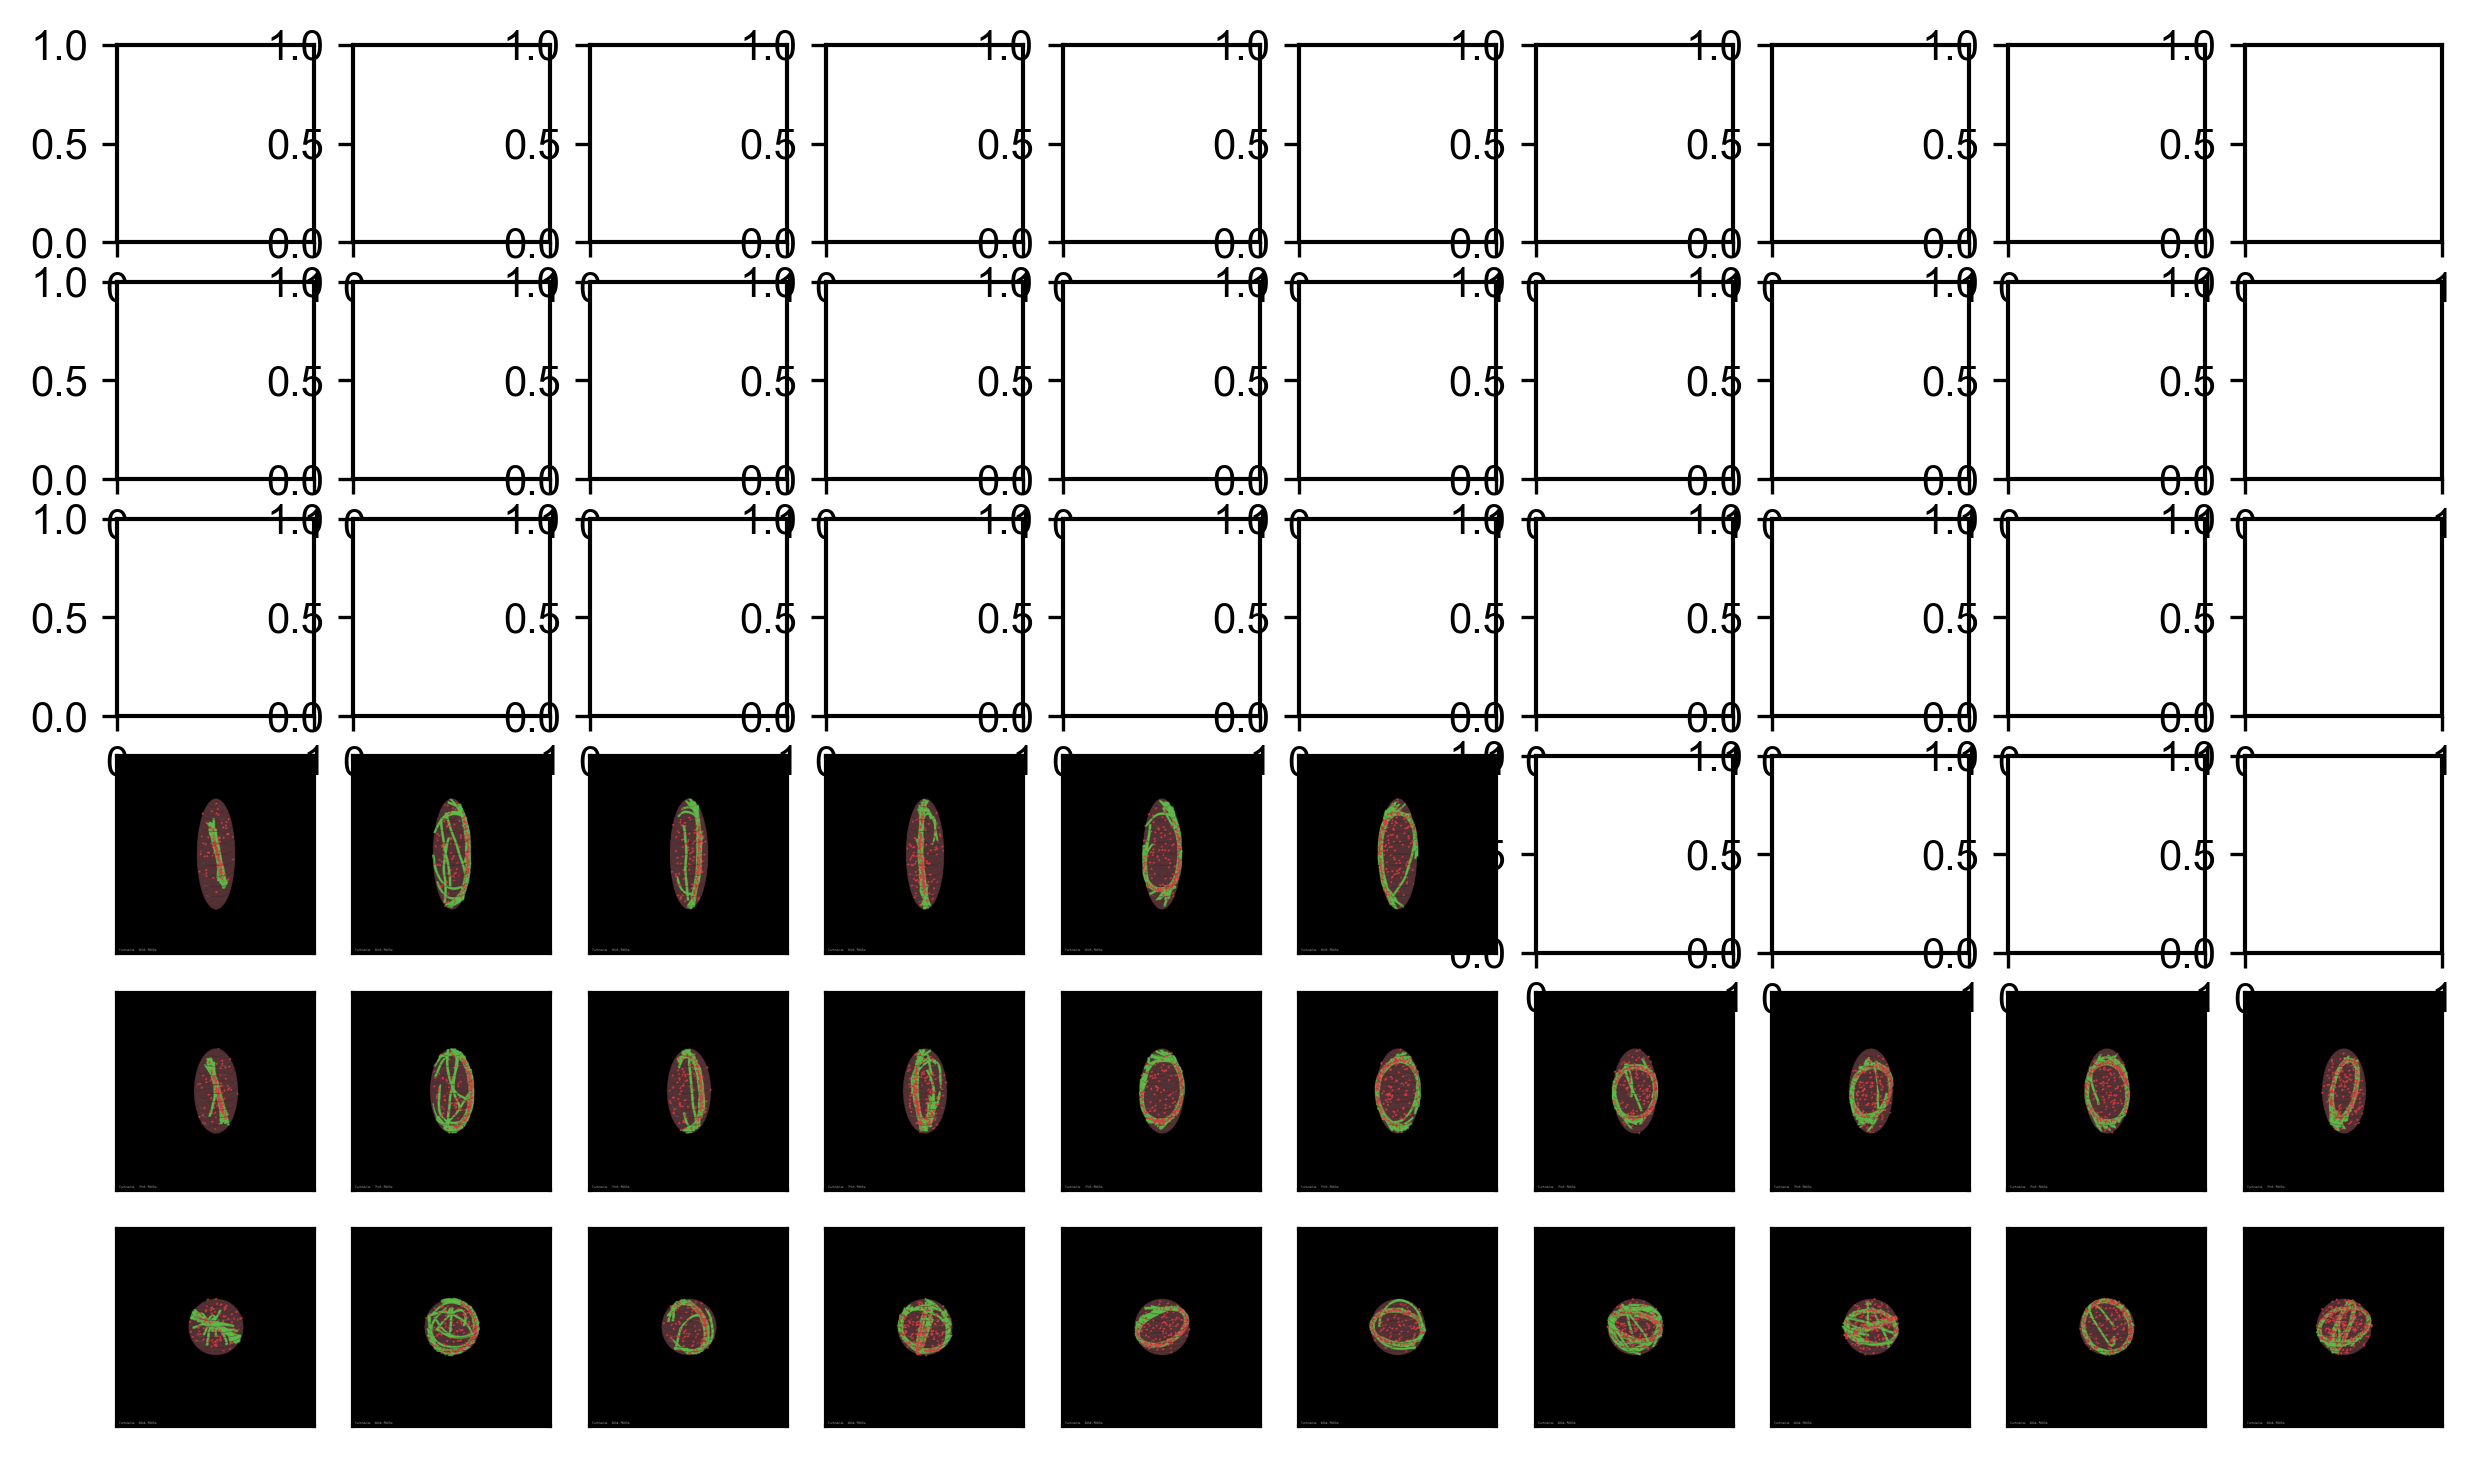

In [30]:
from os.path import exists
from skimage import data
from skimage import io
from skimage import transform
from skimage import color
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
##
import cv2
import glob
import re
from PIL import Image
def trajplotter_snaplist(videofilename,dirlist,snaplist,nr,nc,filepathv,panelsize,extratag, xlabellist, ylabellist,*args):
    plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
    extraspace = 0.1
    extraspaceleft = 0
    length = panelsize*nc+extraspaceleft
    width = panelsize*(nr+extraspace)
    fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(length, width), dpi=300, facecolor='w', edgecolor='k')
    extension = ".png"
    img_array = []
    ylabelcounter = 1
    ################
    for r in range(0,nr):
        for c in range(0,nc):
            plotrow = nr-r-1;
            if nr ==1:
                 ax = axvec[c]
            else:
                ax=axvec[plotrow][c]
            dirname = dirlist[r][c]
            snaps = snaplist[r][c]
            if(len(dirname)==0):
                    ax.set_visible(False)
                    continue;
            else:
                ylabelcounter = ylabelcounter + 1
            fvar = filepathv+dirname+extratag+'/'+"movie"+ f'{snaps:04d}'+extension
            print(fvar)
            if exists(fvar):
                    img = io.imread(fvar)
                    #img_half = transform.rescale(img, scale=0.5, multichannel=True)
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_axis_off
                    if r==0:
                        ax.set_xlabel(xlabellist[c])
                    if ylabelcounter == 1:
                        ax.set_ylabel(ylabellist[r])
                    if(len(args)==3):
                        ax.set_title(args[2][r][c])
            else:
                print('Not found: '+fvar)

    plt.text(0.0, 0.14, args[1], transform=plt.gcf().transFigure, rotation=90)
    plt.text(0.12, 0.05, args[0], transform=plt.gcf().transFigure)
    fig.canvas.draw()

    # img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    # img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,)).copy()
    # img.setflags(write=1)
    # # red and blue channels need to be swapped
    # red = img[:,:,2].copy()
    # blue = img[:,:,0].copy()
    # img[:,:,2] = blue
    # img[:,:,0] = red
    # newsize = fig.canvas.get_width_height()
    # img_array.append(img)
    ##
    plt.subplots_adjust(left=0.05,
        right=0.99,
        bottom=0.1, 
        top=0.99,
        wspace=0.1, 
        hspace=0.1)
    plt.tight_layout()
    plt.savefig(videofilename+'.png', dpi=300, bbox_inches='tight')
    plt.savefig(videofilename+'.pdf', bbox_inches='tight')

# FIGURE S13 CREATOR

In [ ]:
videofilename = 'SER_allten_timeseries'
nr = 6
nc = 10
f3 = './FIGURE_7/INPUTFILES/SER_steric_Actinsweep_test3_tscc'
f4 = './FIGURE_7/INPUTFILES/SER_steric_Actinsweep_test4_tscc'
dirlist = np.array([[f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],
                     [f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],
                     [f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],
                     [f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],
                     [f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],
                     [f3+'/R_0_r_4',f3+'/R_1_r_1', f4+'/R_0_r_2',f3+'/R_2_r_2', f4+'/R_1_r_0',
                     f3+'/R_3_r_0', f4+'/R_2_r_0',f3+'/R_4_r_0',f3+'/R_5_r_4',f3+'/R_6_r_2',],])
print(np.shape(dirlist))
filepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/'
panelsize = 1.0
extratag=''
ylabellist = ['','','','','','','','','','']
xlabellist = ['','','','','','','','','','']
snaplist = np.array([[26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450],
                      [26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450],[26,140,240,326,408,450]]).transpose()
print(np.shape(snaplist))
trajplotter_snaplist(videofilename,dirlist,snaplist, nr,nc,filepathv, panelsize,extratag, xlabellist, ylabellist, 'Aspect ratio (a/b), time (s)', '', )

# CytoSim script writer

## FigurES 2 AND 3 input files

In [2]:
sourcefilepath = './INPUTFILE_TEMPLATE/'
servervar = 'XXXX'
SERFLAG = False
actin_growth_const = False
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.002
shapestring = ["sphere"]
radiusstring = [1.0]
flength = [2*np.pi] #microns per fil
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
# #growingspeedvec = [[0.0103, 0]]
# growingspeedvec = [[6.0e-3,0]]
totaltime = 600
Nfil = [30]
gorwingforcevec = [[10.0]]

bind_dist = [0.03]
unbindingforce = [10.0]
Nblob = [1000]
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 10
rigidityvec = [0.075]
total_polymer = 0
###################
bindingrate = [1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
unbindingrate = [1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
jobfoldername = './FIGURES_2_3'

[0.015625 0.03125  0.0625   0.125    0.25     0.5      1.      ]
[1.25, 1.5, 1.75, 2.0, 3.0, 4.0]
[1.125, 1.375, 1.625]
[1.15625, 1.1875, 1.21875, 1.28125, 1.3125, 1.34375]


## Figure 4 input files $T_{2\pi R}$

In [187]:
sourcefilepath = './INPUTFILE_TEMPLATE/'
actin_growth_const = False
SERFLAG = False
servervar = 'XXXX'
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.002
shapestring = ["sphere"]
radiusstring = [1.0]
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.6183,0],[0.1237, 0],[0.04012, 0],[0.0309, 0],[0.01374, 0],[0.0103, 0]]
totaltime = 600
Nfil = [30]
gorwingforcevec = [[10.0]]
bindingrate = [1e+0]
bind_dist = [0.03]
unbindingrate = [1e-1]
unbindingforce = [10.0]
Nblob = [505,1000,2018,2522,5044]
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 10
rigidityvec = [0.075]
total_polymer = 0
jobfoldername = './FIGURE_4'
maxlengthvec=[]

## Fil length 

In [33]:
sourcefilepath = './INPUTFILE_TEMPLATE/'
actin_growth_const = True
servervar = 'XXXX'
SERFLAG = False
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.002
shapestring = ["sphere"]
radiusstring = [1.0]
maxlengthvec = np.array([1/4,1/3,1/2,2/3,1,4/3,5/3])*np.pi #microns per fil
flength = [0.0125,0.0167,0.025,0.0333,0.05,0.0667,0.0833] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
actin_growth_const_growingspeedvec = [[0.001288,0],[0.001718,0],[0.002576,0],[0.003435,0],[0.005153,0],[0.006870,0],[0.008588,0]]
# #growingspeedvec = [[0.0103, 0]]
# growingspeedvec = [[6.0e-3,0]]
totaltime = 600
Nfil = [240,180,120,90,60,45,36]
gorwingforcevec = [[10.0]]

bind_dist = [0.03]
unbindingforce = [10.0]
Nblob = [1000]
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 10
rigidityvec = [0.075]
total_polymer = 0
###################
bindingrate = [1e+1]
unbindingrate = [1e+0]
jobfoldername = './FIGURE_6'

## Sphere-Ellipse-Rod transition

In [539]:
sourcefilepath = './INPUTFILE_TEMPLATE/'
servervar = 'YYYY'
actin_growth_const = True
# STERIC
stericflag = True
actin_growth_const = False
stericKvec = [1]
time_step = 0.002
shapestring = ["ellipse"]
radiusstring = [1.0]
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
# #growingspeedvec = [[0.0103, 0]]
# growingspeedvec = [[6.0e-3,0]]
totaltime = 600
######################## Test #1
Nfil = [ 4,22,44,65,130,195, 
        2,11,22,33,65,98, 
        2,7,15,22,44,65, 
        1,5,11,16,33,49, ]
piR = np.pi
maxlengthvec = [piR/2,piR/2,piR/2,piR/2,piR/2,piR/2,
                piR,piR,piR,piR,piR,piR,
                1.5*piR,1.5*piR,1.5*piR,1.5*piR,1.5*piR,1.5*piR,
                2*piR,2*piR,2*piR,2*piR,2*piR,2*piR,]
######################## Test #2
Nfil = [ 22,24,26,28,30,33,
        20,22,24,26,28,31,
        18,20,22,24,25,27,
        17,18,20,22,23,25,
        16,17,1920,22,23,
        15,16,17,19,20,22]
piR = np.pi
maxlengthvec = [piR,piR,piR,piR,piR,piR,
                1.1*piR,1.1*piR,1.1*piR,1.1*piR,1.1*piR,1.1*piR,
                1.2*piR,1.2*piR,1.2*piR,1.2*piR,1.2*piR,1.2*piR,
                1.3*piR,1.3*piR,1.3*piR,1.3*piR,1.3*piR,1.3*piR,
                1.4*piR,1.4*piR,1.4*piR,1.4*piR,1.4*piR,1.4*piR,
                1.5*piR,1.5*piR,1.5*piR,1.5*piR,1.5*piR,1.5*piR,]
#######################
Nfil = [90,72,60,51,45,36,30]
maxlengthvec = [2*piR/3, 5*piR/6, piR, 7*piR/6, 4*piR/3, 5*piR/3, 2*piR]
flength = [0.03333,0.0417,0.05,0.0588,0.0667,0.0833,0.1]
actin_growth_const_growingspeedvec = [[0.003435, 0],[0.004294, 0],[0.005153, 0], [0.006011, 0], [0.006870, 0], [0.008588, 0],[0.0103, 0]]
jobfoldername = 'SER_steric_Actinsweep_test3_cerebro'
######################
Nfil = [65,55,48]
maxlengthvec = [11*piR/12, 13*piR/12, 15*piR/12]
flength = [0.04,0.0546,0.0625]
actin_growth_const_growingspeedvec = [[0.004722, 0],[0.005581, 0],[0.006441, 0], ]
jobfoldername = 'SER_steric_Actinsweep_test4_cerebro'
######################
gorwingforcevec = [[10.0]]
bindingrate = [1e-1]
bind_dist = [0.03]
unbindingrate = [1e-1]
unbindingforce = [10.0]
Nblob = [1000]
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 5
rigidityvec = [0.075]
total_polymer = 0
span_step_vec = [0.01] #microns
span_time_vec = [1.0] #s
SERFLAG = True

## Actin concentration - review - FIGURE S11

In [37]:
sourcefilepath = './INPUTFILE_TEMPLATE/'
actin_growth_const = False
SERFLAG = False
SPECIALNUCFLAG = False
Tlist=np.array([]);
servervar = 'tscc'
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.002
shapestring = ["sphere"]
radiusstring = [1.0]
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
totaltime = 600
gorwingforcevec = [[10.0]]
bindingrate = [1e+0]
bind_dist = [0.03]
unbindingrate = [1e-1]
unbindingforce = [10.0]
Nblob = [1000,2018,5044]
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 10
rigidityvec = [0.075]
total_polymer = 0
jobfoldername = 'Actin_VASP_ratio'
maxlengthvec=[]
# set2
jobfoldername = 'Actin_VASP_ratio_set2'
Nfil = [75,90,105]
# set3
jobfoldername = 'Actin_VASP_ratio_set3'
Nfil = [120,135,150,165,180,195,210,225]
# set4
jobfoldername = 'Actin_VASP_ratio_set4'
Nfil = [30,75,120,165,210]
# set4
jobfoldername = 'Actin_VASP_ratio_set5'
Nfil = [180,195]


1
1
1
1
1
1
1
1
1
2
3
1
1
6


In [298]:
#Read template file
serverlist = ['cerebro','cortex','ashwin','tscc']
# Open file in read mode
frptr = open(sourcefilepath+'config.cym','r')
# Read all lines
Lines = frptr.readlines()
frptr.close()
#
def writejobfile(filepath, foldername, installfolder, iter, jobfolderpathtscc):
    fjobptr = open(filepath+'/'+foldername+'/'+foldername+'.sh','w')
    fjobptr.write('#PBS -S /bin/bash' + '\n')
    fjobptr.write('#PBS -q home' + '\n')
    fjobptr.write('#PBS -N '+foldername + '\n')
    fjobptr.write('#PBS -l nodes=1:ppn=1:ib' + '\n')
    fjobptr.write('#PBS -l walltime=120:00:00' + '\n')
    fjobptr.write('#PBS -o output.txt' + '\n')                                                                                                        
    fjobptr.write('#PBS -e error.txt' + '\n') 
    fjobptr.write('#PBS -V' + '\n')
    fjobptr.write('#PBS -M achandrasekaran@ucsd.edu' + '\n')
    fjobptr.write('#PBS -m abe' + '\n')
    fjobptr.write('#PBS -A rangamani-hopper' + '\n')
    fjobptr.write('cd '+ jobfolderpathtscc+foldername + '\n')
    fjobptr.write(installfolder+'./config'+str(iter)+'.cym' + '\n')
    fjobptr.close()
    print('file written')
#
def writeline(fptr, Lines, start, end):
    for iter in range(start,end):
        fptr.write(Lines[iter])

# stericKvec = [5,25,50,75,100]
if(not stericflag):
    stericKvec = []

# Write edited files
# flength = 0.059
#Plus end Minus end

# activitytag='realtreadmill'
# TREADMILLING
# growingspeedvec = [[0.003,0],[0.027,0],[0.054,0],[0.108,0],[1.0,0],[5.0,0]]
# shrinkingspeedvec = [[0,-0.003],[0,-0.027],[0,-0.054],[0,-0.108],[0,-1.0],[0,-5.0]]
# growingspeedvec = [[0.003,0],[0.006,0],[0.009,0],[0.012,0],[0.018,0],[0.027,0]]
# shrinkingspeedvec = [[0,-0.003],[0,-0.006],[0,-0.009],[0,-0.012],[0,-0.018],[0,-0.027]]
# growingspeedvec = [[0.027, 0],[0.054,0],[0.108,0],[0.216,0]]
# shrinkingspeedvec = [[0,-0.027],[0,-0.054],[0,-0.108],[0,-0.216]]
# f = 0.02
# growingspeedvec = [[0.154*2.7*f,1.4*2.7*f]]
# shrinkingspeedvec=[[-0.017*2.7*f,-0.8*2.7*f]]

# total_polymer = 577.5
# growingspeedvec = [[0.0717, 0.00803]]
# shrinkingspeedvec = [[-0.0378, -0.0216]]
# ##  75nm/s treadmilling
# growingspeedvec = [[0.3445, 0.0686]]
# shrinkingspeedvec = [[-0.1816, -0.1038]]
# ## 75 nm/s treadmilling
# growingspeedvec = [[0.4133, 0.0463]]
# shrinkingspeedvec = [[-0.2179, -0.1245]]
####################################################
# ##  60nm/s treadmilling
# growingspeedvec = [[0.2753, 0.0309]]
# shrinkingspeedvec = [[-0.1452, -0.0829]]
# ##  45nm/s treadmilling
# growingspeedvec = [[0.2151, 0.0241]]
# shrinkingspeedvec = [[-0.1134, -0.0648]]
# ##  30nm/s treadmilling
# growingspeedvec = [[0.1434, 0.0161]]
# shrinkingspeedvec = [[-0.0756, -0.0432]]
# ## 15nm.s treadmillling
# growingspeedvec = [[0.0688, 0.0077]]
# shrinkingspeedvec = [[-0.0363, -0.0207]]
###################

# bind_dist = [0.03, 0.04, 0.05, 0.06, 0.07]
# bind_dist = [0.005, 0.01, 0.015, 0.02]
#unbindingrate = [0.025, 0.05, 0.075, 0.5, 2.5, 5]

#unbindingrate = [1e-3, 1e-2, 1e-1, 1e+0]
#unbindingrate = [1e-3, 1e-2, 1e-1, 1e+0]
totalnumberfiles = len(shapestring)*len(radiusstring)*len(growingspeedvec)*len(gorwingforcevec)*len(bindingrate)*len(bind_dist)*len(unbindingrate)*len(unbindingforce)*len(blobsizevec)*len(Nfil)*len(Nblob)*len(valency)*len(rigidityvec)
if(len(stericKvec)):
    totalnumberfiles=len(stericKvec)*totalnumberfiles
if(SERFLAG):
    totalnumberfiles = len(span_step_vec)*totalnumberfiles
if(SPECIALNUCFLAG):
    totalnumberfiles = len(Final_stepsvec)*totalnumberfiles

print('Total number of jobs='+str(totalnumberfiles))
filepath = '/Users/aravind/Research/PostDoc/Research/CytoSim/'+jobfoldername+'/'
os.mkdir(filepath)
#read the file
stericKiter = 0
shapeiter = 0
riter = 0
gspeediter = 0
#sspeediter = 0
gforceiter = 0
binditer = 0
bdistiter = 0
unbinditer = 0
unbindfiter = 0
Nfiliter = 0
Nblobiter = 0
blobsizeiter = 0
valiter = 0
rigidityiter =0
##############
serspaniter = 0
##############
nuciter = 0;
##############
reffilename ='reference.txt'
frefptr = open(filepath+reffilename,'w')
jobfilename = 'submitjobs.sh'
fjobptr = open(filepath+jobfilename,'w')
jobfilename_rest = 'submitjobs_2.sh'
fjobptr_rest = open(filepath+jobfilename_rest,'w')
frefptr.write('REPLICATE |FNAME     ');
if(len(stericKvec)):
    frefptr.write('|STERICK   ')
frefptr.write('|SHAPE     |RADIUS    |RIGIDITY  |GSPEED    |SSPEED    |GFORCE    |KON       |BDIST     |KOFF      |KOFF_F    |NFIL      |NBLOB     |BLOBSIZE  |VALENCY   |\n')
reftextwidth = 10
for iter in range(0,totalnumberfiles):
    print([shapeiter, riter, gspeediter, gforceiter, binditer, bdistiter, unbinditer, unbindfiter, Nfiliter, Nblobiter, valiter])
    filename = 'config'+str(iter)+'.cym'
    for repcounter in range(0,replicates):
        foldername = 'R_'+str(iter)+'_r_'+str(repcounter)
        if servervar=='cerebro' or servervar == ' cortex':
            installfolder = '~/cytosim/bin/sim '
        elif servervar == 'ashwin':
            installfolder = '/home/ashwin/work/Aravind/cytosim/bin/sim '
        elif servervar == 'tscc':
            installfolder = '/oasis/tscc/scratch/achandrasekaran/cytosim/bin/sim '
        
        if servervar in ['cerebro','cortex','ashwin']:
            if(repcounter==0):
                fjobptr.write('cd '+foldername+'; nohup '+installfolder+filename+'>nohup.out& cd ..;'+'\n')
            else:
                fjobptr_rest.write('cd '+foldername+'; nohup '+installfolder+filename+'>nohup.out& cd ..;'+'\n')
        else:
            if(repcounter==0):
                fjobptr.write('cd '+foldername+'; qsub '+foldername+'.sh; cd ..;'+'\n')
            else:
                fjobptr_rest.write('cd '+foldername+'; qsub '+foldername+'.sh; cd ..;'+'\n')

        rstring = str(repcounter)
        reftext = rstring.ljust(reftextwidth, ' ')+'|';
        reftext = reftext + foldername.ljust(reftextwidth, ' ')+'|';

        os.mkdir(filepath+foldername)

        if servervar == 'tscc':
            jobfolderpathtscc = '/oasis/tscc/scratch/achandrasekaran/'+jobfoldername+'/'
            writejobfile(filepath, foldername, installfolder, iter, jobfolderpathtscc)

        foutptr = open(filepath+'/'+foldername+'/'+filename,'w')
        writeline(foutptr, Lines, 3, 12)
        foutptr.write('    time_step = '+str(time_step)+'\n')
        if SERFLAG:
            writeline(foutptr, Lines, 13, 14)
            foutptr.write('    display =(back_color=black;zoom=0.3; rotation=0.81 -0.59 0 0;)'+'\n')
        else:
            writeline(foutptr, Lines, 13, 15)

        if(stericKiter < len(stericKvec)):
            stericK = str(stericKvec[stericKiter])
            reftext = reftext + stericK.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    steric = 1, '+stericK+'\n')

        writeline(foutptr, Lines, 15, 19)
        if shapeiter < len(shapestring):
            shape = shapestring[shapeiter]
            reftext = reftext + shape.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    shape = '+shape+'\n')
        
        if(servervar =='cerebroarp'):
            foutptr.write(' display = { back_color=0x9500a3ff; visible=2}'+'\n')

        writeline(foutptr, Lines, 20, 24)

        if riter < len(radiusstring):
            radius = str(radiusstring[riter])
            reftext = reftext + radius.ljust(reftextwidth, ' ')+'|'
            if shape == 'sphere':
                foutptr.write('    radius ='+radius+'\n')
            else:
                length = str(2*radiusstring[riter])
                foutptr.write('    length ='+length+','+length+','+length+'\n')

        #writeline(foutptr, Lines, 25, 33)
        writeline(foutptr, Lines, 25, 29)
        if rigidityiter < len(rigidityvec):
            rigidity = str(rigidityvec[rigidityiter])
            reftext = reftext + rigidity.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    rigidity = '+rigidity+'\n')
        writeline(foutptr, Lines, 30, 33)

        foutptr.write('    activity ='+activitytag+'\n')

        if actin_growth_const:
            gs =''
            for giter, g in enumerate(actin_growth_const_growingspeedvec[Nfiliter]):
                if(giter>0):
                    gs = gs + ", "
                gs = gs + str(g)
            reftext = reftext + gs.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    growing_speed = '+gs+'\n')
        else:
            if gspeediter < len(growingspeedvec):
                gs =''
                for giter, g in enumerate(growingspeedvec[gspeediter]):
                    if(giter>0):
                        gs = gs + ", "
                    gs = gs + str(g)
                reftext = reftext + gs.ljust(reftextwidth, ' ')+'|'
                foutptr.write('    growing_speed = '+gs+'\n')
        
        #Write shrinking rates if it is in treadmilling 
        if(('treadmill' in activitytag or 'realtreadmill' in activitytag) and gspeediter < len(shrinkingspeedvec)):
            ss =''
            for siter, s in enumerate(shrinkingspeedvec[gspeediter]):
                if(siter>0):
                    ss = ss + ", "
                ss = ss + str(s)
            reftext = reftext + ss.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    shrinking_speed = '+ss+'\n')
        else:
            foutptr.write('    shrinking_speed = 0'+'\n')

        if 'realtreadmill' in activitytag or total_polymer>0:
            foutptr.write('    total_polymer = '+str(total_polymer[Nfiliter])+'\n')


        if gforceiter < len(gorwingforcevec):
            gf = ''
            frontstring = '';
            if 'treadmill' in activitytag:
                frontstring = '%'
            for giter, g in enumerate(gorwingforcevec[gforceiter]):
                if(giter>0):
                    gf = gf + ", "
                gf = gf + str(g)
            reftext = reftext + gf.ljust(reftextwidth, ' ')+'|'
            foutptr.write(frontstring+'    growing_force = '+gf+'\n')
        
        if len(maxlengthvec)>1:
            foutptr.write('    max_length ='+str(maxlengthvec[Nfiliter])+'\n')
        else:
            foutptr.write('    max_length = 6.2832'+'\n')
        
        if(stericKiter < len(stericKvec)):
            foutptr.write('    steric = 1, 0.0035'+'\n')
        
        foutptr.write('    binding_key = 1'+'\n')

        writeline(foutptr, Lines, 36, 41)

        #Binding rate and distance    
        if binditer < len(bindingrate):
            kon = str(bindingrate[binditer])
            reftext = reftext + kon.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    binding = '+kon+', ')
        if bdistiter < len(bind_dist):
            bd = str(bind_dist[bdistiter])
            reftext = reftext + bd.ljust(reftextwidth, ' ')+'|'
            foutptr.write(bd+'\n')

        writeline(foutptr, Lines, 42, 43)
        #Unbinding rate and force
        if unbinditer < len(unbindingrate):
            ubr = str(unbindingrate[unbinditer])
            reftext = reftext + ubr.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    unbinding = '+ubr+', ')    
        if unbindfiter < len(unbindingforce):
            ubf = str(unbindingforce[unbindfiter])
            reftext = reftext + ubf.ljust(reftextwidth, ' ')+'|'
            foutptr.write(ubf+'\n')
        
        foutptr.write('    binding_key = 1'+'\n')
        
        writeline(foutptr, Lines, 44, 57)

        #Nfil
        if(Nfiliter < len(Nfil)):
            nf = str(Nfil[Nfiliter])
            reftext = reftext + nf.ljust(reftextwidth, ' ')+'|'
            foutptr.write('new '+nf+' filament'+'\n')

        writeline(foutptr, Lines, 58, 59)
        if len(flength) == 1:
            foutptr.write('    length = '+str(flength[0])+'\n')
        else:
            foutptr.write('    length = '+str(flength[Nfiliter])+'\n')

        if('treadmill' in activitytag or 'realtreadmill' in activitytag):
            # Growing plus end and shrinking minus end
            foutptr.write('    end_state = 1, 4'+'\n')

        writeline(foutptr, Lines, 60, 66)

        if(stericKiter<len(stericKvec)):
            foutptr.write('    steric = 1'+'\n')

        writeline(foutptr, Lines, 66, 69)

        #Nblob 
        if(Nblobiter < len(Nblob)):
            nb = str(Nblob[Nblobiter])
            reftext = reftext + nb.ljust(reftextwidth, ' ')+'|'
            foutptr.write('new '+nb+' blob'+'\n')

        writeline(foutptr, Lines, 70, 72)
        foutptr.write('    separation = '+str(0.9*2*blobsizevec[blobsizeiter])+'\n')

        writeline(foutptr, Lines, 73, 75)
        #Valency
        foutptr.write('    sphere1 = 0 0 0, '+str(blobsizevec[blobsizeiter])+', ')
        bsize = str(blobsizevec[blobsizeiter])
        reftext = reftext + bsize.ljust(reftextwidth, ' ')+'|'
        if valiter < len(valency):
            vs = str(valency[valiter])
            reftext = reftext + vs.ljust(reftextwidth, ' ')+'|'
            for v in range(0,valency[valiter]):
                foutptr.write('1 graftedcrosslinker')
                if(v<valency[valiter]-1):
                    foutptr.write(', ')
                else:
                    foutptr.write('\n')
            
        writeline(foutptr, Lines, 76, 78)

        if SPECIALNUCFLAG ==False:
            foutptr.write('run '+ str(nsteps) +' system \n')
            if SERFLAG == False:
                foutptr.write('{' +'\n')
                foutptr.write('    nb_frames = '+ str(nframes) +'\n')
                foutptr.write('    binary = 0\n')
                foutptr.write('}' +'\n')
            else:
                foutptr.write('{' +'\n')
                foutptr.write('    nb_frames = 20'+'\n')
                foutptr.write('    binary = 0\n')
                foutptr.write('}' +'\n')

        ################### SER PROTOCOL
        if SERFLAG == True:
            ### Get the last snap
            foutptr.write('run 1 system'+'\n')
            foutptr.write('{' +'\n')
            foutptr.write('    nb_frames = 1'+'\n')
            foutptr.write('    binary = 0\n')
            foutptr.write('}' +'\n')
            # 10 nm per 10 ms
            span_step = 0.01
            span_time = 0.01
            # 10 nm per 100 ms
            span_step = 0.01
            span_time = 0.1
            if serspaniter < len(span_step_vec):
                span_step = span_step_vec[serspaniter]
                span_time = span_time_vec[serspaniter]
            run_steps = int(span_time/time_step)
            snap_cycle_frequency = 2
            time_tracker = 0
            radval = radiusstring[riter]
            maxspan = 2*np.pi*radval
            majoraxisspan = 2*radval

            total_cycles = int((maxspan-majoraxisspan)/span_step)
            for citer in range(0,total_cycles+1):
                foutptr.write('%%%%%%%%%%%%%%% CYCLE #'+str(citer)+'\n')
                foutptr.write('change cell'+'\n')
                foutptr.write('{'+'\n')
                twoA = (2*radval + citer*span_step)
                twoB = str(round(2*math.sqrt(radval*radval*radval/(0.5*twoA)),6))
                # Print 2A, 2B, 2C
                foutptr.write('    length = '+twoB+','+twoB+','+str(twoA)+'\n')
                foutptr.write('    display = { back_color=0xD37A81FF; visible=2}' +'\n')
                foutptr.write('}'+'\n')
                foutptr.write('run '+ str(run_steps) +' system \n')
                #Write snapshot every 0.2 s
                if citer%snap_cycle_frequency ==0:
                    foutptr.write('{' +'\n')
                    foutptr.write('    nb_frames = 2'+'\n')
                    foutptr.write('    binary = 0\n')
                    foutptr.write('}' +'\n')
        ############################## SPECIAL NUCLEATION PROTOCOL
        if SPECIALNUCFLAG ==True:
            ########### THIS IS NEEDED INTERNALLY
            maxlengthvec=[6.28];
            Nfilmax = Nfinal[Nfiliter];
            Flenvec = np.zeros(Nfilmax)
            Nfilcurrent=Nfil[Nfiliter];
            Flenvec[0:Nfilcurrent] = 0.1
            ###########
            grow_ref= np.array(growingspeedvec[gspeediter]);
            nframe_total = 0;
            Ncurrent = Nfil[Nfiliter]
            nsteps = nstepsvec[nuciter]
            nframe_odd = nframe_oddvec[nuciter]
            nframe_even = nframe_evenvec[nuciter]
            Final_steps = Final_stepsvec[nuciter]
            Ncycles = Ncyclesvec[nuciter]
            dt = time_per_nuc[nuciter]
            for iternuc in range(0,Ncycles):
                ############# NEW STRATEGY
                locs = np.transpose((np.argwhere(Flenvec[0:Ncurrent]<maxlengthvec[Nfiliter])))[0]
                NFILAVAILABLE = len(locs)
                ## ## GROW CURRENT
                grow_current = Nfinal[Nfiliter]*grow_ref/np.array([NFILAVAILABLE])
                Flenvec[locs] = Flenvec[locs]+grow_current[0]*dt
                locs = np.transpose((np.argwhere(Flenvec[0:Ncurrent]>maxlengthvec[Nfiliter])))[0]
                Flenvec[locs] = maxlengthvec[Nfiliter];
                #############
                # grow_current = Nfinal[Nfiliter]*grow_ref/np.array([Ncurrent])
                foutptr.write('change filament \n')
                foutptr.write('{' +'\n')
                gs =''
                for giter, g in enumerate(grow_current):
                    if(giter>0):
                        gs = gs + ", "
                    gs = gs + str(g)
                foutptr.write('    growing_speed = '+gs+'\n')
                foutptr.write('}' +'\n')
                foutptr.write('run '+ str(nsteps) +' system \n')
                foutptr.write('{' +'\n')
                nframestmp = nframe_odd
                if iternuc%2==0:
                    nframestmp = nframe_even
                nframe_total = nframe_total + nframestmp
                foutptr.write('    nb_frames = '+str(nframestmp)+'\n')
                foutptr.write('    binary = 0\n')
                foutptr.write('}' +'\n')
                foutptr.write('new 1 filament' +'\n')
                foutptr.write('{' +'\n')
                foutptr.write('    length = '+str(flength[Nfiliter])+'\n')
                foutptr.write('    end_state = 1, 0 \n')
                foutptr.write('}' +'\n')
                Ncurrent = Ncurrent + 1;
            ###### Steps after nucleation 
            nsteps = 1000
            dt = nsteps*time_step
            Ncycle_final = int(Final_steps/nsteps)
            if(Ncycle_final>0):
                for itercycle in range(0,Ncycle_final):
                    ############# NEW STRATEGY
                    locs = np.transpose((np.argwhere(Flenvec[0:Ncurrent]<maxlengthvec[Nfiliter])))[0]
                    NFILAVAILABLE = len(locs)
                    ## ## GROW CURRENT
                    grow_current = Nfinal[Nfiliter]*grow_ref/np.array([NFILAVAILABLE])
                    Flenvec[locs] = Flenvec[locs]+grow_current[0]*dt
                    locs = np.transpose((np.argwhere(Flenvec[0:Ncurrent]>maxlengthvec[Nfiliter])))[0]
                    Flenvec[locs] = maxlengthvec[Nfiliter];
                    #############
                    foutptr.write('change filament \n')
                    foutptr.write('{' +'\n')
                    gs =''
                    for giter, g in enumerate(grow_current):
                        if(giter>0):
                            gs = gs + ", "
                        gs = gs + str(g)
                    foutptr.write('    growing_speed = '+gs+'\n')
                    foutptr.write('}' +'\n')
                    framevar = itercycle%5
                    framevar =1
                    foutptr.write('run '+ str(nsteps) +' system \n')
                    if framevar==1:
                        nframe_total = nframe_total +2
                        foutptr.write('{' +'\n')
                        foutptr.write('    nb_frames = 2 \n')
                        foutptr.write('    binary = 0\n')
                        foutptr.write('}' +'\n')
                nframesfinal = int(nframes-nframe_total);
            print(nframe_total,flush=True);
            # print([Ncycles,nframes,nframe_total])
            # if nsteps>0:
            #     foutptr.write('run '+ str(nsteps) +' system \n')
            #     foutptr.write('{' +'\n')
            #     foutptr.write('    nb_frames = '+str(nframesfinal)+'\n')
            #     foutptr.write('}' +'\n')

        foutptr.close()
        print(reftext)
        frefptr.write(reftext+'\n')
    if SPECIALNUCFLAG==True and SERFLAG == False:
        nuciter = nuciter + 1;
        if nuciter >=len(Final_stepsvec):
            valiter = valiter + 1
    if SERFLAG == True and SPECIALNUCFLAG == False:
        serspaniter = serspaniter + 1
        if serspaniter>=len(span_step_vec):
            valiter = valiter + 1
            serspaniter = 0;
    if SERFLAG==True and SPECIALNUCFLAG==True:
        print('MAJOR ERROR! FUNCTIONALITY NOT DEFINED!!!!')

    if SERFLAG == False and SPECIALNUCFLAG == False:
        valiter = valiter + 1
    # shape iter update
    if(valiter>=len(valency)):
        blobsizeiter = blobsizeiter + 1
        valiter = 0
    if(blobsizeiter>=len(blobsizevec)):
        Nfiliter = Nfiliter + 1
        blobsizeiter = 0
    if Nfiliter>=len(Nfil):
        Nblobiter = Nblobiter + 1
        Nfiliter = 0
    if Nblobiter >=len(Nblob):
        unbindfiter = unbindfiter + 1
        Nblobiter = 0
    if(unbindfiter >= len(unbindingforce)):
        unbinditer = unbinditer + 1
        unbindfiter = 0
    if(unbinditer>=len(unbindingrate)):
        bdistiter = bdistiter + 1
        unbinditer = 0
    if(bdistiter >= len(bind_dist)): 
        binditer = binditer + 1
        bdistiter = 0
    if(binditer >= len(bindingrate)):
        gforceiter = gforceiter + 1
        binditer = 0 
    if(gforceiter >= len(gorwingforcevec)):
        # sspeediter = sspeediter + 1
        gforceiter = 0
    # if(sspeediter >= len(shrinkingspeedvec)):
        gspeediter = gspeediter + 1
    #     sspeediter = 0
    if(gspeediter >= len(growingspeedvec)):
        rigidityiter = rigidityiter + 1
        gspeediter = 0
    if(rigidityiter >= len(rigidityvec)):
        riter = riter + 1
        rigidityiter = 0;
    if(riter >= len(radiusstring)):
        shapeiter = shapeiter + 1
        riter = 0
    if(shapeiter >= len(shapestring)):
        stericKiter = stericKiter + 1
        shapeiter = 0
    riter = 0
frefptr.close()
fjobptr.close()
fjobptr_rest.close()    

Total number of jobs=6
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
file written
568
0         |R_0_r_0   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |0.1       |10.0      |30        |1000      |0.03      |4         |
file written
568
1         |R_0_r_1   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |0.1       |10.0      |30        |1000      |0.03      |4         |
file written
568
2         |R_0_r_2   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |0.1       |10.0      |30        |1000      |0.03      |4         |
file written
568
3         |R_0_r_3   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |0.1       |10.0      |30        |1000      |0.03      |4         |
file written
568
4         |R_0_r_4   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |0.1       |10.0      |30        |1000   

# Crosslinker arms bound and mean valency
PLEASE NOTE THAT THE ACCOMPANYING PYTHON NOTEBOOK WAS USED TO GENERATE THE NECESSARY OUPUT FILES. THIS IS JUST TO LOCALLY TEST THE CODE. 

In [294]:
def getvaspprops(rset):
    MEANID = 0
    STDID = 1
    r =  rset[0]
    Nsnaps = int(len(r.snap))
    if deltasnap>1:
        Ndatapoints = int(Nsnaps/deltasnap)+1
    else:
        Ndatapoints = int(Nsnaps)
    bar_min_snap = int(0.8*Nsnaps)
    bar_data_raw = np.array([])
    Nvalency = np.zeros((2,Ndatapoints))
    Nvasp = np.zeros((2,Ndatapoints))
    Nfil_per_solid = np.zeros((2,Ndatapoints))
    scounter = 0
    collectstatus = False
    for SREF in range(0,Nsnaps,deltasnap):
        nvasp_tmp = np.array([])
        nvalency_tmp = np.array([])
        Nfil_per_solid_tmp = np.array([])
        if SREF>=bar_min_snap:
            collectstatus = True
        for runidx in range(0,len(rset)):
            crossboundfilid = np.array(rset[runidx].snap[SREF].crossboundfilid)
            crossboundblobid = rset[runidx].snap[SREF].crossboundblobid
            unique, counts = np.unique(crossboundblobid, return_counts=True)
            nvasp_tmp = np.append(nvasp_tmp,len(unique))
            nvalency_tmp = np.append(nvalency_tmp,np.array(counts))
            # Get the filament IDs for each solid and calculate Nhands/Nfil
            # This helps you understand the number of hands in each solid that are bound to the same filament.
            # The distribution of Nhands/Nfil - closer to 1 suggests that each bound hand is bound to a different filament
            # >1 suggests that multiple hands of the solid are bound to the same fil ID
            # <1 is not possible.
            for uiter, ublobid in enumerate(unique):
                #Find the locs using argwhere
                locs = np.argwhere(crossboundblobid==ublobid)
                filid_solid = crossboundfilid[locs]
                unique_fid, counts_fil = np.unique(filid_solid, return_counts=True)
                lval = len(unique_fid)
                Nfil_per_solid_tmp = np.append(Nfil_per_solid_tmp,lval)
            if collectstatus:
                bar_data_raw = np.append(bar_data_raw, Nfil_per_solid_tmp)
        if(len(crossboundblobid)):
            Nvasp[MEANID][scounter]= np.mean(nvasp_tmp)
            Nvasp[STDID][scounter]= np.std(nvasp_tmp)
            Nvalency[MEANID][scounter]= np.mean(nvalency_tmp)
            Nvalency[STDID][scounter]= np.std(nvalency_tmp)
            Nfil_per_solid[MEANID][scounter]= np.mean(Nfil_per_solid_tmp)
            Nfil_per_solid[STDID][scounter]= np.std(Nfil_per_solid_tmp)
        scounter = scounter + 1 
        if(len(bar_data_raw)):
            meanval = np.mean(bar_data_raw)
            stdval =  np.std(bar_data_raw)
        else:
            meanval = 0
            stdval = 0
    return [Nvasp, Nvalency, Nfil_per_solid, meanval, stdval]
rlist = []
rid = 0
cid = 6
dirid = 1
deltasnap = 10
Nlist = [500, 1000, 2000, 3000, 4000]
dirlist = ['5e2','1e3','2e3','3e3','4e3']
nc = 7
nr = 4
MEANID = 0
r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/cytosimfiles/Fgrow_10_3_N_'+str(dirlist[dirid])+'/R_'+str(rid*nc+cid)+'/')
rlist.append(r[0])
print(np.shape(rlist))
retval = getvaspprops(rlist)
Nvasp = retval[0]
print(Nvasp[MEANID])

NameError: name 'readcytosimtraj' is not defined

## CROSSLINKER PLOTTER HELPER

In [9]:
def crossplothelper(filename,Nreps,*args):
    if len(args):
        tv=args[0]
    # KEY
    # Row 0 Time
    # Row 1 Number of bound crosslinkers MEAN
    # Row 2 Number of bound crosslinkers STD
    # Row 3 Number of filaments per crosslinker MEAN
    # Row 4 Number of filaments per crosslinker STD
    # Row 5 Number of UNIQIUE filaments per crosslinker MEAN
    # Row 6 Number of UNIQUE filaments per crosslinker STD
    # Row 7 Last 5% data Row 5 MEAN
    # Row 8 Last 5% data Row 5 STD
    # Row 9 Number of VASP bound to 1 filament MEAN
    # Row 10 Number of VASP bound to 1 filament STD
    # Row 11 Number of VASP bound to 2 filaments MEAN
    # Row 12 Number of VASP bound to 2 filaments STD
    # Row 13 Number of VASP bound to 3 filaments MEAN
    # Row 14 Number of VASP bound to 3 filaments STD
    # Row 15 Number of VASP bound to 4 filaments MEAN
    # Row 16 Number of VASP bound to 4 filaments STD
    # Row 17 5% data Number of VASP bound to N \in [1,4] filaments MEAN
    # Row 18 5% data  Number of VASP bound to N \in [1,4] filaments STD
    # LOAD
    # Extract
    # Plot 1 row, 5 column plots 
    # Each plot has 7 colors 
    Row1=[]
    Row2=[]
    Row3=[]
    Row4=[]
    Row5=[]
    Row6=[]
    Row7=[]
    Row8=[]
    Row17=[]
    Row18=[]
    bar_data_1 = np.array([])
    bar_data_2 = np.array([])
    bar_data_3 = np.array([])
    bar_data_4 = np.array([])
    for repid in range(0,Nreps):
        fvar = filename+str(repid)+'.csv'
        df = pd.read_csv(fvar,index_col=0)
        Row1.append(df.iloc[1].to_numpy())
        Row2.append(df.iloc[2].to_numpy())
        Row3.append(df.iloc[3].to_numpy())
        Row4.append(df.iloc[4].to_numpy())
        Row5.append(df.iloc[5].to_numpy())
        Row6.append(df.iloc[6].to_numpy())
        Row7.append(df.iloc[7].to_numpy())
        Row8.append(df.iloc[8].to_numpy())
        ##
        Row9 = df.iloc[9].to_numpy()
        Row11 = df.iloc[11].to_numpy()
        Row13 = df.iloc[13].to_numpy()
        Row15 = df.iloc[15].to_numpy()
        startpos = int(0.95*len(Row9))
        endpos = int(len(Row9))
        bar_data_1 = np.append(bar_data_1,(Row9[startpos:endpos]/tv))
        bar_data_2 = np.append(bar_data_2,(Row11[startpos:endpos]/tv))
        bar_data_3 = np.append(bar_data_3,(Row13[startpos:endpos]/tv))
        bar_data_4 = np.append(bar_data_4,(Row15[startpos:endpos]/tv))
        ##
        Row17.append(df.iloc[17].to_numpy())
        Row18.append(df.iloc[18].to_numpy())
    # Get the number of VASP that is free
    bar_data_0 = 1-bar_data_1-bar_data_2-bar_data_3-bar_data_4
    Mean_0_fil = np.mean(bar_data_0,0)
    Mean_1_fil = np.mean(bar_data_1,0)
    Mean_2_fil = np.mean(bar_data_2,0)
    Mean_3_fil = np.mean(bar_data_3,0)
    Mean_4_fil = np.mean(bar_data_4,0)
    Std_0_fil = np.std(bar_data_0,0)
    Std_1_fil = np.std(bar_data_1,0)
    Std_2_fil = np.std(bar_data_2,0)
    Std_3_fil = np.std(bar_data_3,0)
    Std_4_fil = np.std(bar_data_4,0)
    return [Mean_0_fil,Mean_1_fil,Mean_2_fil,Mean_3_fil,Mean_4_fil,Std_0_fil,Std_1_fil,Std_2_fil,Std_3_fil,Std_4_fil]

## PLOTTER STERIC - USED IN PAPER

### Prepare data

In [56]:
kbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1]
kunbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
Mean_0_fil = []
Mean_1_fil = []
Mean_2_fil = []
Mean_3_fil = []
Mean_4_fil = []
Std_0_fil = []
Std_1_fil = []
Std_2_fil = []
Std_3_fil = []
Std_4_fil = []
filereadpath ='/Users/aravind/Research/PostDoc/Research/cytosimfiles/analysis_scripts/tscc_outputfiles/'
jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
for kbinditer, kbind in enumerate(kbindvec):
    for kunbinditer, kunbind in enumerate (kunbindvec):
        bar_raw_data = np.array([])
        Row1=[]
        Rval = kbinditer*len(kunbindvec)+kunbinditer
        filename = filereadpath+'Crosslink_'+jobfoldername+'_R_'+str(Rval)+'_r_'
        Nreps = 3
        outputlist = crossplothelper(filename,Nreps,1000)
        Mean_0_fil.append(outputlist[0])
        Mean_1_fil.append(outputlist[1])
        Mean_2_fil.append(outputlist[2])
        Mean_3_fil.append(outputlist[3])
        Mean_4_fil.append(outputlist[4])
        Std_0_fil.append(outputlist[5])
        Std_1_fil.append(outputlist[6])
        Std_2_fil.append(outputlist[7])
        Std_3_fil.append(outputlist[8])
        Std_4_fil.append(outputlist[9])
kbindlist = [1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4,
             1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,
             1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2,
             1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1,
             1e+0, 1e+0, 1e+0, 1e+0, 1e+0, 1e+0,
             1e+1, 1e+1, 1e+1, 1e+1, 1e+1, 1e+1]
kunbindlist = [1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1,
            1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1,
            1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1,
            1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1,
            1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1,
            1e-4, 1e-3, 1e-2, 1e-1, 1e+0,1e+1]
bardf = pd.DataFrame({'kbind':kbindlist, 'kunbind':kunbindlist,
                      '0':Mean_0_fil,'1':Mean_1_fil,
                    '2':Mean_2_fil,'3':Mean_3_fil,
                    '4':Mean_4_fil})
cumarray = np.zeros((5,len(Mean_0_fil)))
cumarray[0][:]=Mean_0_fil[:]
cumarray[1][:]=cumarray[0][:]+Mean_1_fil
cumarray[2][:]=cumarray[1][:]+Mean_2_fil
cumarray[3][:]=cumarray[2][:]+Mean_3_fil
cumarray[4][:]=cumarray[3][:]+Mean_4_fil
#print((cumarray))
stddf = pd.DataFrame({})
print(bardf)

      kbind  kunbind             0         1         2         3         4
0    0.0001   0.0001  9.851290e-01  0.014871  0.000000  0.000000  0.000000
1    0.0001   0.0010  9.867957e-01  0.013204  0.000000  0.000000  0.000000
2    0.0001   0.0100  9.970860e-01  0.002914  0.000000  0.000000  0.000000
3    0.0001   0.1000  9.995269e-01  0.000473  0.000000  0.000000  0.000000
4    0.0001   1.0000  9.998065e-01  0.000194  0.000000  0.000000  0.000000
5    0.0001  10.0000  9.999892e-01  0.000011  0.000000  0.000000  0.000000
6    0.0010   0.0001  8.594409e-01  0.130129  0.009763  0.000667  0.000000
7    0.0010   0.0010  9.046882e-01  0.086699  0.007946  0.000667  0.000000
8    0.0010   0.0100  9.654086e-01  0.034097  0.000247  0.000247  0.000000
9    0.0010   0.1000  9.947204e-01  0.005280  0.000000  0.000000  0.000000
10   0.0010   1.0000  9.995591e-01  0.000441  0.000000  0.000000  0.000000
11   0.0010  10.0000  9.999570e-01  0.000043  0.000000  0.000000  0.000000
12   0.0100   0.0001  2.6

### Plotter - NOT SHOWN IN PAPER

In [92]:
# Figure 4
# Generate colors
import math
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
labelvec = [r"$10^{-4}$",'0.001','0.01','0.1','1.0','10.0']
ylabelvec = [0.2, 0.4, 0.8, 1.0, 2.0]
# Get figure
nr = len(kbindvec); nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.15)
# FIRST COLUMN
for plotcounter in range(0,nr):
    legcell = []
    df = pd.DataFrame()
    stddf=pd.DataFrame()
    stddatavec = []
    Nvalency = 4
    for val in range(0,len(kunbindvec)):
        Rval = plotcounter*len(kunbindvec)+val
        stddatavec.append(np.array([val-0.2, cumarray[0][Rval], Std_0_fil[Rval]]))
        offset = -0.1
        for pos in range(0,Nvalency):
            if pos ==0:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_1_fil[Rval]]))
            elif pos ==1:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_2_fil[Rval]]))
            elif pos ==2:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_3_fil[Rval]]))
            elif pos ==3:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_4_fil[Rval]]))
            offset = offset + 0.1
    #df.columns=labelvec
    df =bardf[bardf["kbind"]==kbindvec[plotcounter]].drop(columns = "kbind")
    print(df)
    stddatavec = pd.DataFrame(np.array(stddatavec),columns=['x','mean','std'])
    # PLOT
    ax = axvec[nr-plotcounter-1][1]
    df.plot(ax=ax,x='kunbind',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)
    ax.errorbar(stddatavec['x'],stddatavec['mean'],yerr=stddatavec['std'], fmt = 'o', markersize = 0, ecolor='black')
    # Beautify
    ax.set_xticklabels(labelvec, rotation = 0)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
leg = fig.legend(['0','1','2','3','4'],title='Number of bound filaments',ncol=5,fontsize=8,frameon=False,
                bbox_to_anchor=(0.9, 0.96), labelspacing=0.1)

plt.figtext(0.5, 0.1, 'Fraction of VASP tetramers', transform=plt.gcf().transFigure, rotation=90)
axvec[nr-1][1].set_xlabel(r"$k_{unbind} (1/s)$")
# SECOND COLUMN
for plotcounter in range(0,nr):
    legcell = []
    ax = axvec[nr-plotcounter-1][0]
    meandata = []
    stddata = []
    for l in range(plotcounter*len(kunbindvec),(plotcounter+1)*len(kunbindvec),1):
        meandata.append(mean_frac_bar[l])
        stddata.append(std_frac_bar[l])
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(labelvec)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[nr-1][0].set_xlabel(r"$k_{unbind} (1/s)$")
plt.figtext(-0.065,0.1, 'F-actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
# SAVE
plt.savefig('Fgrow10_3_steric_2col.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Fgrow10_3_steric_2col.pdf', bbox_inches='tight')
#fig.tight_layout();

NameError: name 'kbindvec' is not defined

# FIGURE 3B AND D - Time profile + crosslinker bar

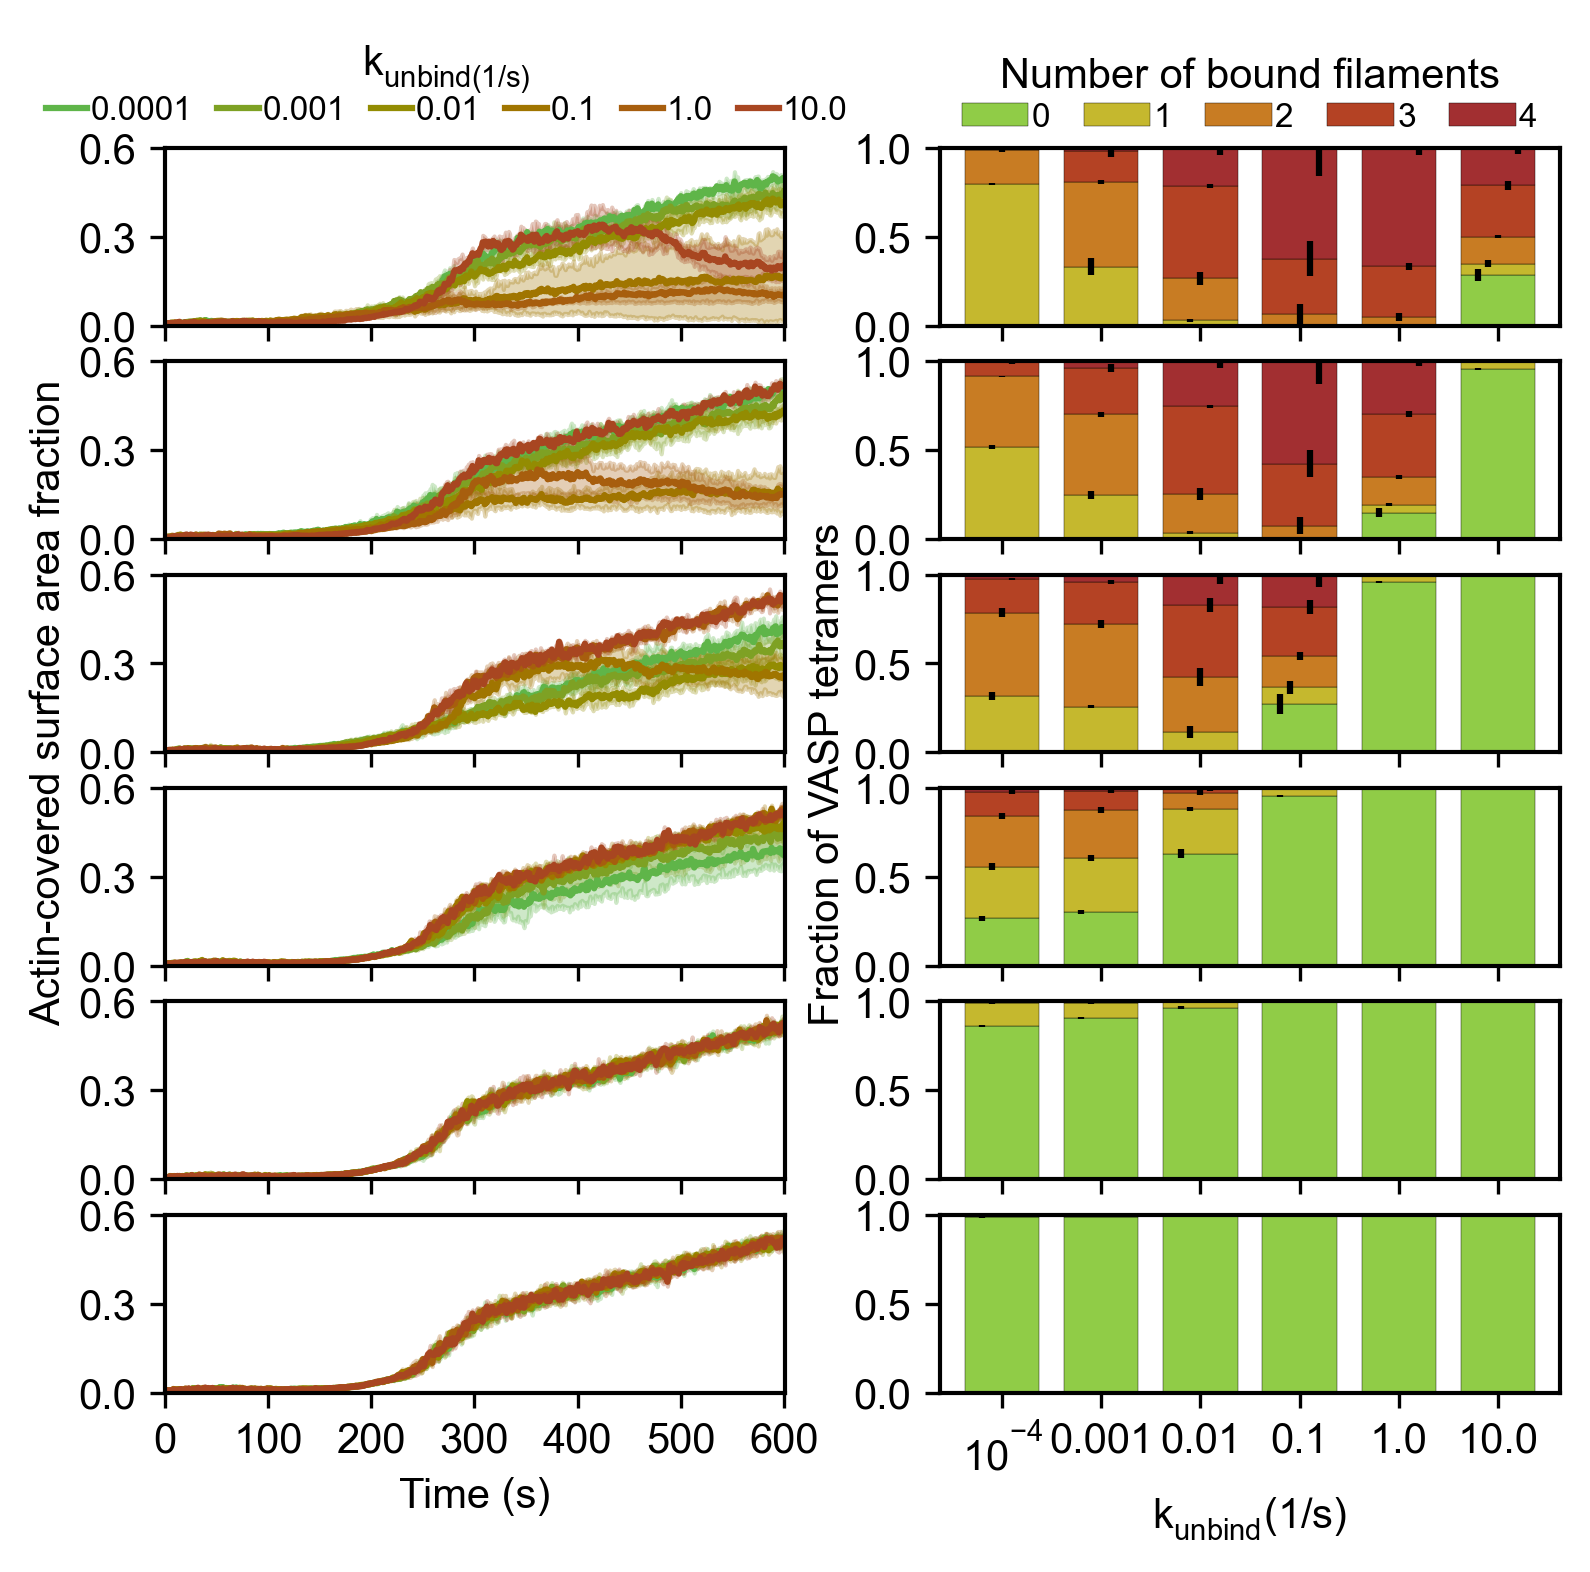

In [145]:
# nr = 6; nc = 1 
# fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(2,5), dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
# for plotcounter in range(0,nr):
#     legcell = []
#     for val in range(0,nr):
#         Rval = plotcounter*len(kunbindvec) + val
#         ax = axvec[nr-plotcounter-1]
#         x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
#         legcell.append(x[0]);
#         ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
# plt.text(-0.2, 0.475,  'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
# axvec[5].set_xlabel('Time (s)')
# axvec[5].set_xlim([0,601])
import math
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
labelvec = [r"$10^{-4}$",'0.001','0.01','0.1','1.0','10.0']
ylabelvec = [0.2, 0.4, 0.8, 1.0, 2.0]
# Get figure
nr = len(kbindvec); nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(5.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
# FIRST COLUMN
for plotcounter in range(0,nr):
    legcell = []
    df = pd.DataFrame()
    stddf=pd.DataFrame()
    stddatavec = []
    Nvalency = 4
    for val in range(0,len(kunbindvec)):
        Rval = plotcounter*len(kunbindvec)+val
        stddatavec.append(np.array([val-0.2, cumarray[0][Rval], Std_0_fil[Rval]]))
        offset = -0.1
        for pos in range(0,Nvalency):
            if pos ==0:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_1_fil[Rval]]))
            elif pos ==1:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_2_fil[Rval]]))
            elif pos ==2:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_3_fil[Rval]]))
            elif pos ==3:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_4_fil[Rval]]))
            offset = offset + 0.1
    #df.columns=labelvec
    df =bardf[bardf["kbind"]==kbindvec[plotcounter]].drop(columns = "kbind")
    #print(df)
    stddatavec = pd.DataFrame(np.array(stddatavec),columns=['x','mean','std'])
    # PLOT
    ax = axvec[nr-plotcounter-1][1]
    df.plot(ax=ax,x='kunbind',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)
    ax.errorbar(stddatavec['x'],stddatavec['mean'],yerr=stddatavec['std'], fmt = 'o', markersize = 0, ecolor='black')
    # Beautify
    ax.set_xticklabels(labelvec, rotation = 0)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.5,1.0])
    if plotcounter > 0:
        ax.set_xticklabels([])
    #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
leg = fig.legend(['0','1','2','3','4'],title='Number of bound filaments',ncol=5,fontsize=8,frameon=False,
                bbox_to_anchor=(0.985, 0.96), labelspacing=0.2, columnspacing = 1.0, handletextpad=0.1)

plt.figtext(0.48, 0.3, 'Fraction of VASP tetramers', transform=plt.gcf().transFigure, rotation=90)
axvec[nr-1][1].set_xlabel(r"$k_{unbind} (1/s)$")
#SECOND COLUMN
for plotcounter in range(0,nr):
    legcell = []
    for val in range(0,nr):
        Rval = plotcounter*len(kunbindvec) + val
        ax = axvec[nr-plotcounter-1][0]
        x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
        legcell.append(x[0]);
        ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
        ax.set_xlim([0,601])
        ax.set_ylim([0,0.6])
        ax.set_yticks([0,0.3,0.6])
        ax.set_xticks([0,100,200,300,400,500,600])
        if plotcounter > 0:
            ax.set_xticklabels([])
plt.text(-0.04, 0.3,  'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
leg = fig.legend(legcell, kunbindvec,title=r"$k_{unbind (1/s)}$",ncol=6,handlelength=1.25,columnspacing=0.75, handletextpad = 0.1, fontsize=8,frameon=False,
                bbox_to_anchor=(0.525, 0.97), labelspacing=0.0)
axvec[5][0].set_xlabel('Time (s)')
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.25, 
                    hspace=0.2)
# SAVE
plt.savefig('Fgrow10_3_steric_2col_TS_bar.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Fgrow10_3_steric_2col_TS_bar.pdf', bbox_inches='tight')

## Plotter $T_{2\pi R}$ - FIGURE USES DATA SHOWN IN FIGURE 5 - NOT SHOWN IN PAPER 

In [116]:
# KEY
# Row 0 Time
# Row 1 Number of bound crosslinkers MEAN
# Row 2 Number of bound crosslinkers STD
# Row 3 Number of filaments per crosslinker MEAN
# Row 4 Number of filaments per crosslinker STD
# Row 5 Number of UNIQIUE filaments per crosslinker MEAN
# Row 6 Number of UNIQUE filaments per crosslinker STD
# Row 7 Last 5% data Row 5 MEAN
# Row 8 Last 5% data Row 5 STD
# Row 9 Number of VASP bound to 1 filament MEAN
# Row 10 Number of VASP bound to 1 filament STD
# Row 11 Number of VASP bound to 2 filaments MEAN
# Row 12 Number of VASP bound to 2 filaments STD
# Row 13 Number of VASP bound to 3 filaments MEAN
# Row 14 Number of VASP bound to 3 filaments STD
# Row 15 Number of VASP bound to 4 filaments MEAN
# Row 16 Number of VASP bound to 4 filaments STD
# Row 17 5% data Number of VASP bound to N \in [1,4] filaments MEAN
# Row 18 5% data  Number of VASP bound to N \in [1,4] filaments STD
# LOAD
# Extract
# Plot 1 row, 5 column plots 
# Each plot has 7 colors 
Row1=[]
Row2=[]
Row3=[]
Row4=[]
Row5=[]
Row6=[]
Row7=[]
Row8=[]
Row17=[]
Row18=[]
Vasp_conc = [0.2, 0.4, 0.8, 1.0, 2.0]
TotalVASP = [505, 1000, 2018, 2522, 5044]
T2piR=[10, 50, 150, 200, 450, 600]
Mean_0_fil = []
Mean_1_fil = []
Mean_2_fil = []
Mean_3_fil = []
Mean_4_fil = []
Std_0_fil = []
Std_1_fil = []
Std_2_fil = []
Std_3_fil = []
Std_4_fil = []
Nreps = 3
for vconciter, vconc in enumerate(Vasp_conc):
    for titer, tval in enumerate (T2piR):
        bar_raw_data = np.array([])
        Row1=[]
        Rval = titer*len(Vasp_conc)+vconciter
        bar_data_1 = np.array([])
        bar_data_2 = np.array([])
        bar_data_3 = np.array([])
        bar_data_4 = np.array([])
        tv = TotalVASP[vconciter]
        for repid in range(0,Nreps):
            fvar = filereadpath+'/Crosslink_Actin_addn_ring_steric_tscc_30nm_rigidity_0_075_set2_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            Row1.append(df.iloc[1].to_numpy())
            Row2.append(df.iloc[2].to_numpy())
            Row3.append(df.iloc[3].to_numpy())
            Row4.append(df.iloc[4].to_numpy())
            Row5.append(df.iloc[5].to_numpy())
            Row6.append(df.iloc[6].to_numpy())
            Row7.append(df.iloc[7].to_numpy())
            Row8.append(df.iloc[8].to_numpy())
            ##
            Row9 = df.iloc[9].to_numpy()
            Row11 = df.iloc[11].to_numpy()
            Row13 = df.iloc[13].to_numpy()
            Row15 = df.iloc[15].to_numpy()
            startpos = int(0.95*len(Row9))
            endpos = int(len(Row9))
            bar_data_1 = np.append(bar_data_1,(Row9[startpos:endpos]/tv))
            bar_data_2 = np.append(bar_data_2,(Row11[startpos:endpos]/tv))
            bar_data_3 = np.append(bar_data_3,(Row13[startpos:endpos]/tv))
            bar_data_4 = np.append(bar_data_4,(Row15[startpos:endpos]/tv))
            ##
            Row17.append(df.iloc[17].to_numpy())
            Row18.append(df.iloc[18].to_numpy())
        # Get the number of VASP that is free
        bar_data_0 = 1-bar_data_1-bar_data_2-bar_data_3-bar_data_4
        Mean_0_fil.append(np.mean(bar_data_0,0))
        Mean_1_fil.append(np.mean(bar_data_1,0))
        Mean_2_fil.append(np.mean(bar_data_2,0))
        Mean_3_fil.append(np.mean(bar_data_3,0))
        Mean_4_fil.append(np.mean(bar_data_4,0))
        Std_0_fil.append(np.std(bar_data_0,0))
        Std_1_fil.append(np.std(bar_data_1,0))
        Std_2_fil.append(np.std(bar_data_2,0))
        Std_3_fil.append(np.std(bar_data_3,0))
        Std_4_fil.append(np.std(bar_data_4,0))
T2piRvec = [10,10,10,10,10,
            50,50,50,50,50,
            150,150,150,150,150,
            200,200,200,200,200,
            450,450,450,450,450,
            600,600,600,600,600,]
Vconcvec = [0.2, 0.4, 0.8, 1.0, 2.0,
            0.2, 0.4, 0.8, 1.0, 2.0,
            0.2, 0.4, 0.8, 1.0, 2.0,
            0.2, 0.4, 0.8, 1.0, 2.0,
            0.2, 0.4, 0.8, 1.0, 2.0,
            0.2, 0.4, 0.8, 1.0, 2.0]
bardf = pd.DataFrame({'Vconc':Vconcvec, 'T2piR':T2piRvec,
                      '0':Mean_0_fil,'1':Mean_1_fil,
                    '2':Mean_2_fil,'3':Mean_3_fil,
                    '4':Mean_4_fil})
cumarray = np.zeros((5,len(Mean_0_fil)))
cumarray[0][:]=Mean_0_fil[:]
cumarray[1][:]=cumarray[0][:]+Mean_1_fil
cumarray[2][:]=cumarray[1][:]+Mean_2_fil
cumarray[3][:]=cumarray[2][:]+Mean_3_fil
cumarray[4][:]=cumarray[3][:]+Mean_4_fil
#print((cumarray))
stddf = pd.DataFrame({})
Timevec = df.iloc[0].to_numpy()
print(bardf)


    Vconc  T2piR         0         1         2         3         4
0     0.2     10  0.002321  0.022208  0.138422  0.378814  0.458235
1     0.4     10  0.000639  0.015480  0.120409  0.416374  0.447099
2     0.8     10  0.000298  0.011477  0.120622  0.411285  0.456319
3     1.0     10  0.000021  0.007985  0.078952  0.361269  0.551773
4     2.0     10  0.000341  0.003215  0.039796  0.286320  0.670329
5     0.2     50  0.000043  0.005302  0.062919  0.311530  0.620207
6     0.4     50  0.000710  0.024796  0.181161  0.456591  0.336742
7     0.8     50  0.000624  0.016290  0.131559  0.396914  0.454613
8     1.0     50  0.000409  0.015731  0.116613  0.408742  0.458505
9     2.0     50  0.000538  0.007570  0.082140  0.382097  0.527656
10    0.2    150  0.000312  0.004312  0.053570  0.322097  0.619710
11    0.4    150  0.000409  0.013204  0.093355  0.386419  0.506613
12    0.8    150  0.001417  0.036963  0.238110  0.463804  0.259706
13    1.0    150  0.000746  0.013321  0.122713  0.413941  0.44

## DATA CORREPSONDING TO FIGURE 5 - NOT SHOWN IN PAPER

    T2piR         0         1         2         3         4
0      10  0.002321  0.022208  0.138422  0.378814  0.458235
5      50  0.000043  0.005302  0.062919  0.311530  0.620207
10    150  0.000312  0.004312  0.053570  0.322097  0.619710
15    200  0.000389  0.010939  0.107532  0.385472  0.495668
20    450  0.000384  0.018060  0.169536  0.456384  0.355636
25    600  0.001151  0.029738  0.213338  0.467109  0.288664
    T2piR         0         1         2         3         4
1      10  0.000639  0.015480  0.120409  0.416374  0.447099
6      50  0.000710  0.024796  0.181161  0.456591  0.336742
11    150  0.000409  0.013204  0.093355  0.386419  0.506613
16    200  0.000448  0.005408  0.073654  0.373675  0.546815
21    450  0.000435  0.009482  0.089577  0.375854  0.524652
26    600  0.001196  0.025234  0.200400  0.466962  0.306209
    T2piR         0         1         2         3         4
2      10  0.000298  0.011477  0.120622  0.411285  0.456319
7      50  0.000624  0.016290  0.131559 

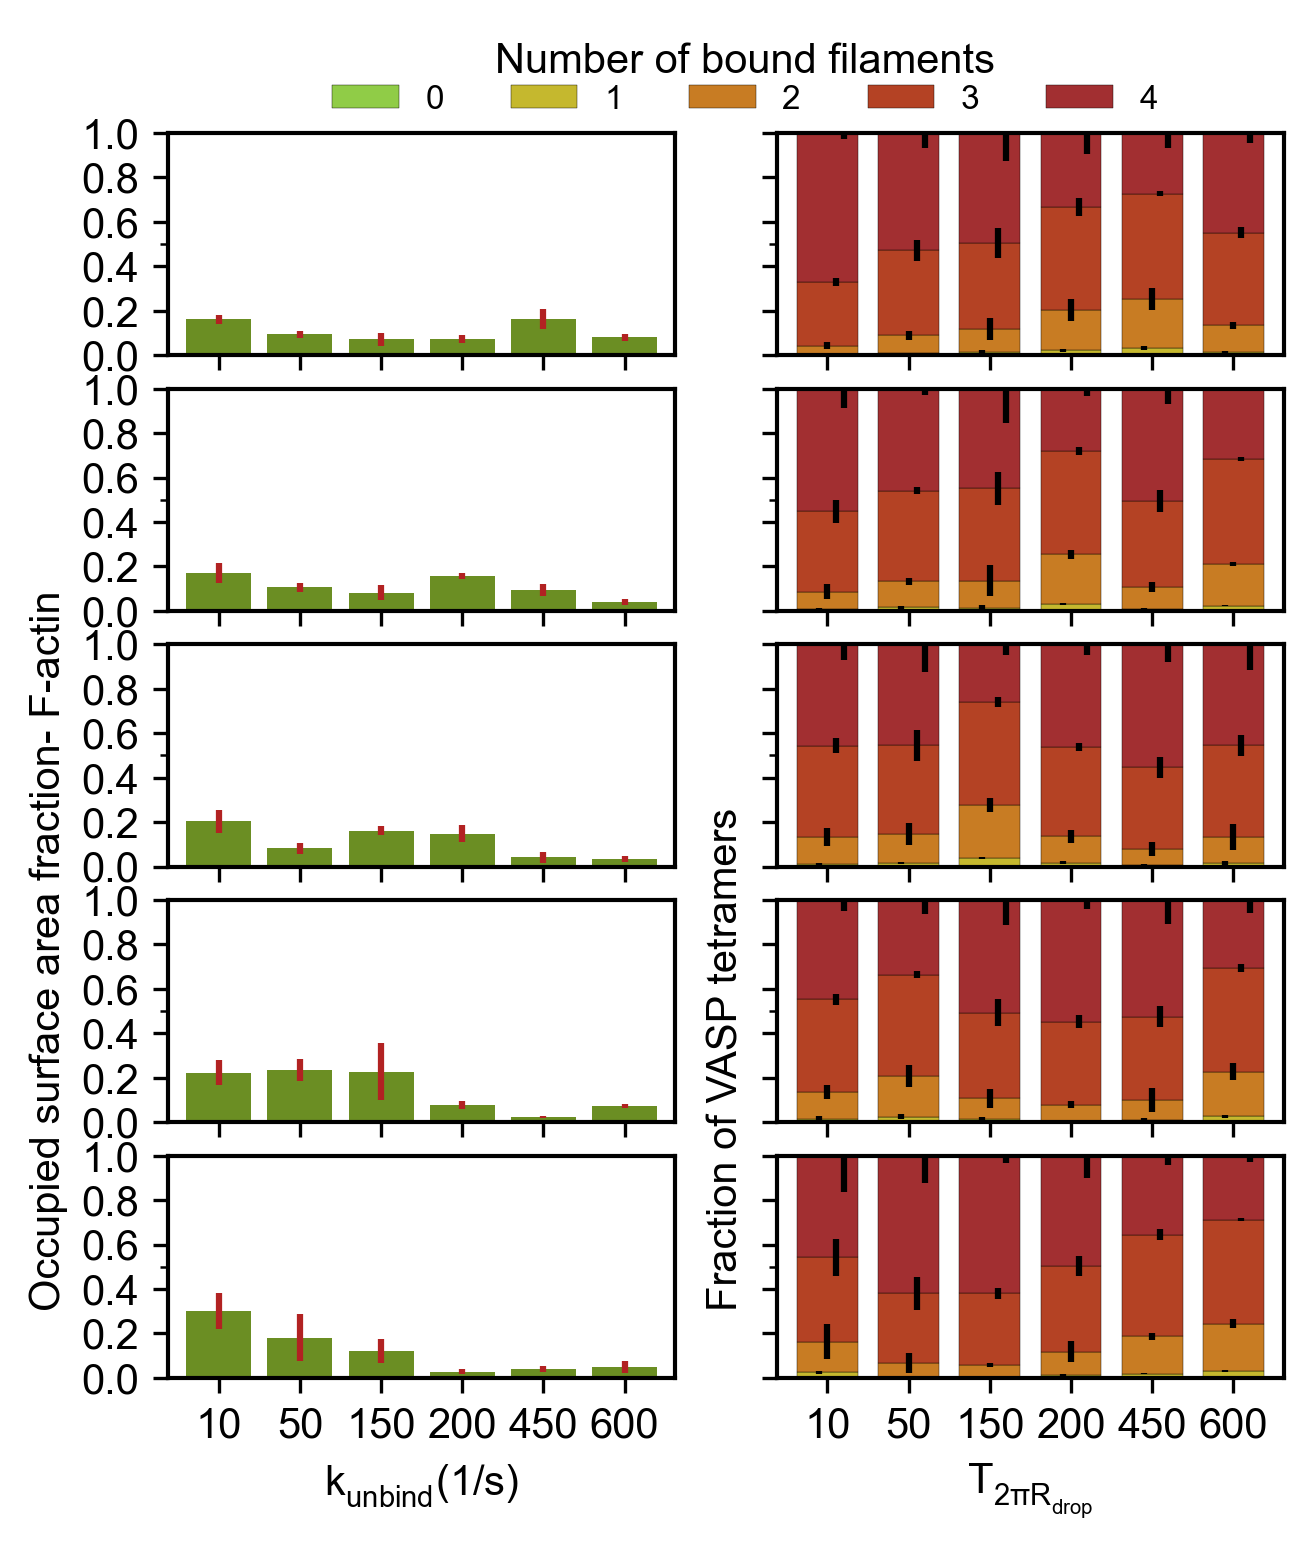

In [118]:
# Figure 4
# Generate colors
import math
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
labelvec = [10, 50, 150, 200, 450, 600]
ylabelvec = [0.2, 0.4, 0.8, 1.0, 2.0]
# Get figure
nr = 5; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.15)
# FIRST COLUMN
for plotcounter in range(0,5):
    legcell = []
    df = pd.DataFrame()
    stddf=pd.DataFrame()
    stddatavec = []
    factor = 1e3
    Nvalency = 4
    for val in range(0,6):
        Rval = plotcounter+val*5
        stddatavec.append(np.array([val-0.2, cumarray[0][Rval], Std_0_fil[Rval]]))
        offset = -0.1
        for pos in range(0,Nvalency):
            if pos ==0:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_1_fil[Rval]]))
            elif pos ==1:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_2_fil[Rval]]))
            elif pos ==2:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_3_fil[Rval]]))
            elif pos ==3:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_4_fil[Rval]]))
            offset = offset + 0.1
    #df.columns=labelvec
    df =bardf[bardf["Vconc"]==Vasp_conc[plotcounter]].drop(columns = "Vconc")
    print(df)
    stddatavec = pd.DataFrame(np.array(stddatavec),columns=['x','mean','std'])
    # PLOT
    ax = axvec[nr-plotcounter-1][1]
    df.plot(ax=ax,x='T2piR',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)
    ax.errorbar(stddatavec['x'],stddatavec['mean'],yerr=stddatavec['std'], fmt = 'o', markersize = 0, ecolor='black')
    # Beautify
    ax.set_xticklabels(labelvec, rotation = 0)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_xlabel(r'$T_{2\pi R_{drop}}$')
    #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
leg = fig.legend(['0','1','2','3','4'],title='Number of bound filaments',ncol=5,fontsize=8,frameon=False,
                bbox_to_anchor=(0.9, 0.96), labelspacing=0.1)

plt.figtext(0.5, 0.1, 'Fraction of VASP tetramers', transform=plt.gcf().transFigure, rotation=90)

# SECOND COLUMN
for plotcounter in range(0,5):
    legcell = []
    ax = axvec[5-plotcounter-1][0]
    meandata = []
    stddata = []
    for l in range(plotcounter,30,5):
        meandata.append(mean_frac_bar[l])
        stddata.append(std_frac_bar[l])
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(T2piR)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[4][0].set_xlabel(r'$T_{2\pi R_{drop}}$')
plt.figtext(-0.065,0.1, 'Occupied surface area fraction- F-actin', transform=plt.gcf().transFigure, rotation=90)
# SAVE
plt.savefig('Fgrow10_3_steric_T2piR.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Fgrow10_3_steric_T2piRpdf', bbox_inches='tight')
#fig.tight_layout();

# K MEANS CLUSTERING

## FUNCTIONS

In [2]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
N_CLUSTERS = 3
# https://realpython.com/k-means-clustering-python/#how-to-build-a-k-means-clustering-pipeline-in-python
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
    ]
)
preprocessor2 = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=N_CLUSTERS,
               init="k-means++",
               n_init=100,
               max_iter=750,
               random_state=42,
           ),
       ),
   ]
)
factor = Pipeline(
    [
        (
            "varimax",
            FactorAnalysis(n_components=2,
                           rotation="varimax")
    
        )
    ]
)
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)
pipe2 = Pipeline(
    [
        ("preprocessor", preprocessor2),
        ("clusterer", clusterer)
    ]
)
varimaxpipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("Varimax FA", factor),
    ]
)

## Obtain data - DATA THAT WOULD EVENTUALLY LEAD TO FIGURES 3E - ALSO PLOTS FIGURE S5

Data length dim1 = 540
Data length dim2 = 540
540
540
540
540
540
540
540
540
540
540
540
     Actin occupied Surface Fraction      1      2      3      4
0                           0.500781  0.018  0.000  0.000  0.000
1                           0.517773  0.018  0.000  0.000  0.000
2                           0.538672  0.018  0.000  0.000  0.000
3                           0.551172  0.018  0.000  0.000  0.000
4                           0.544336  0.019  0.000  0.000  0.000
..                               ...    ...    ...    ...    ...
535                         0.132812  0.045  0.131  0.322  0.278
536                         0.144531  0.057  0.150  0.324  0.244
537                         0.143164  0.036  0.141  0.324  0.256
538                         0.140039  0.050  0.147  0.312  0.266
539                         0.148633  0.043  0.152  0.327  0.250

[540 rows x 5 columns]
FactorAnalysis(n_components=2, rotation='varimax')
[[-0.03237827  0.14117575  0.32533466  0.13957453 -0.01

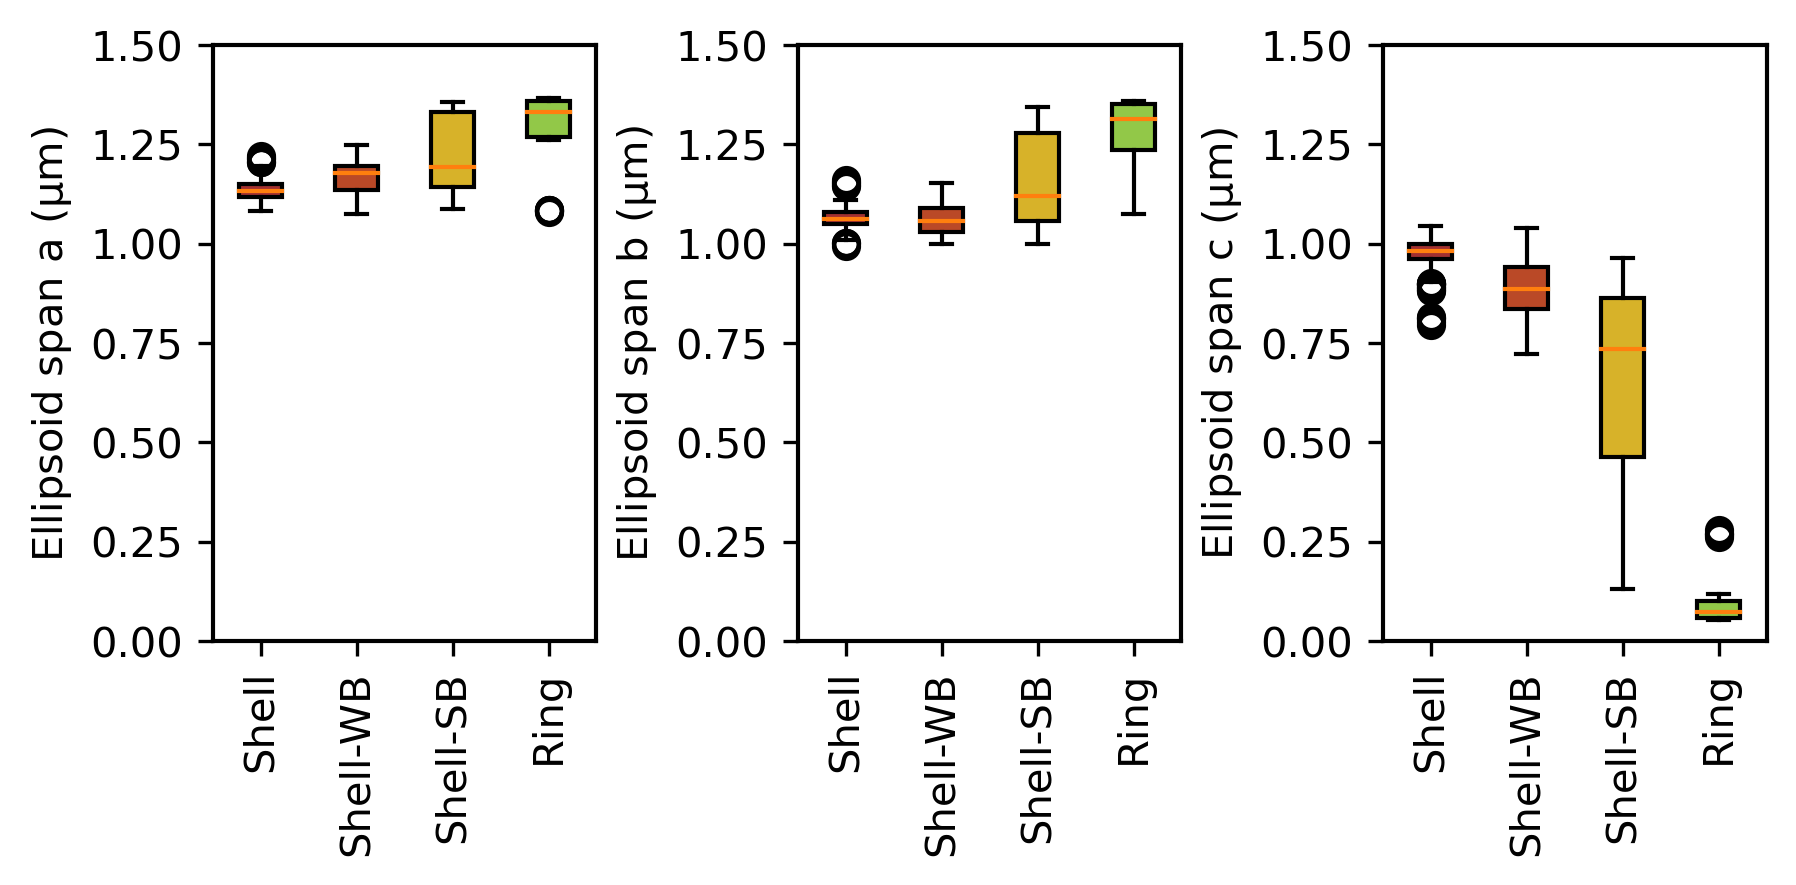

In [4]:
import cv2
import base64
def _get_image(path):
    #read bytes from and get the bytes as image_file
    with open(path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    encoded_img = f'data:image/png;base64,{encoded_string}'
    return encoded_img
def obtaindata_steric():
    filereadpath = './FIGURES_2_3/OUTPUTFILES/'
    jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
    imagefilepathv = './FIGURES_2_3/INPUTFILES/'
    #
    Row1=np.array([])
    #Row2=[]
    Row3=np.array([])
    #Row4=[]
    Row5=np.array([])
    #Row6=[]
    #Row7=[]
    #Row8=[]
    Row9 = []
    Row11 = []
    Row13 = []
    Row15 = []
    FORow1=np.array([])
    spanc = []
    spanb =[]
    spana=[]
    Nreps = 3
    kbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
    kunbindvec =[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
    for koniter, kbind in enumerate(kbindvec):
        for koffiter, kunbind in enumerate (kunbindvec): 
            Rval = koniter*len(kunbindvec)+koffiter
            for repid in range(0,Nreps):
                fvar = filereadpath+'/Crosslink_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
                df = pd.read_csv(fvar,index_col=0)
                Nsnaps = 5
                startpos = 600-Nsnaps
                endpos = 600
                tv = 1000
                Row9 = np.append(Row9, df.iloc[9].to_numpy()[startpos:endpos]/tv)
                Row11 = np.append(Row11, df.iloc[11].to_numpy()[startpos:endpos]/tv)
                Row13 = np.append(Row13, df.iloc[13].to_numpy()[startpos:endpos]/tv)
                Row15 = np.append(Row15, df.iloc[15].to_numpy()[startpos:endpos]/tv)
                fvar = filereadpath+'/FO_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
                df = pd.read_csv(fvar,index_col=0)
                FORow1 = np.append(FORow1, df.iloc[1].to_numpy()[startpos:endpos])
                fvar = filereadpath+'/Eigval'+jobfoldername+'R_'+str(Rval)+'_r_'+str(repid)+'.csv'
                if os.path.isfile(fvar):
                    df = pd.read_csv(fvar,index_col=0)
                    spanc = np.append(spanc, df.iloc[1].to_numpy()[startpos:endpos])
                    spanb = np.append(spanb, df.iloc[2].to_numpy()[startpos:endpos])
                    spana = np.append(spana, df.iloc[3].to_numpy()[startpos:endpos])
                else:
                    print('DOES NOT EXIST'+fvar,flush=True)
    print('Data length dim1 = '+ str(len(Row13)))
    print('Data length dim2 = '+ str(len(FORow1)))
    imagelist = []
    taglist = []
    for koniter, kbind in enumerate(kbindvec):
        for koffiter, kunbind in enumerate (kunbindvec): 
            Rval = koniter*len(kunbindvec)+koffiter
            for repid in range(0,Nreps):
                for sidx in range(startpos,endpos):
                    taglist.append([kbind,kunbind,repid,sidx])
                    subdirname = '/R_'+str(Rval)+'_r_'+str(repid)+'/'
                    imagename = "movie"+ f'{sidx:04d}'+".png"
                    fvar =  imagefilepathv+subdirname+imagename
                    img = cv2.imread(fvar)
                    img_25 = cv2.resize(img, None, fx = 0.25, fy = 0.25)
                    retval, buffer = cv2.imencode('.png', img_25)
                    jpg_as_text = base64.b64encode(buffer).decode()
                    imagelist.append( f'data:image/png;base64,{jpg_as_text}')
    print(len(imagelist))
    return [FORow1, Row9, Row11, Row13, Row15, imagelist, taglist, spanc,spanb,spana]
def obtaindata_ring_ringlike():
    filereadpath = './FIGURES_2_3/OUTPUTFILES/'
    jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
    imagefilepathv = './FIGURES_2_3/INPUTFILES/'
    #
    Row1=np.array([])
    #Row2=[]
    Row3=np.array([])
    #Row4=[]
    Row5=np.array([])
    #Row6=[]
    #Row7=[]
    #Row8=[]
    Row9 = []
    Row11 = []
    Row13 = []
    Row15 = []
    spanc=[]
    spanb=[]
    spana=[]
    FORow1=np.array([])
    Nreps = 3
    Rvalvec = [20,21,26,27,28,32,33,34,35]
    kbindvec = [1e-1,1e-1,1e+0,1e+0,1e+0,1e+1,1e+1,1e+1,1e+1]
    kunbindvec = [1e-2,1e-1,1e-2,1e-1,1e+0,1e-2,1e-1,1e+0,1e+1]
    for Rval in Rvalvec:
        for repid in range(0,Nreps):
            fvar = filereadpath+'/Crosslink_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            Nsnaps = 5
            startpos = 600-Nsnaps
            endpos = 600
            tv = 1000
            Row9 = np.append(Row9, df.iloc[9].to_numpy()[startpos:endpos]/tv)
            Row11 = np.append(Row11, df.iloc[11].to_numpy()[startpos:endpos]/tv)
            Row13 = np.append(Row13, df.iloc[13].to_numpy()[startpos:endpos]/tv)
            Row15 = np.append(Row15, df.iloc[15].to_numpy()[startpos:endpos]/tv)
            fvar = filereadpath+'/FO_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            FORow1 = np.append(FORow1, df.iloc[1].to_numpy()[startpos:endpos])
            fvar = filereadpath+'/Eigval'+jobfoldername+'R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                spanc = np.append(spanc, df.iloc[1].to_numpy()[startpos:endpos])
                spanb = np.append(spanb, df.iloc[2].to_numpy()[startpos:endpos])
                spana = np.append(spana, df.iloc[3].to_numpy()[startpos:endpos])
            else:
                print('DOES NOT EXIST'+fvar,flush=True)
    print('Data length dim1 = '+ str(len(Row13)))
    print('Data length dim2 = '+ str(len(FORow1)))
    imagelist = []
    taglist = []

    for riter, Rval in enumerate(Rvalvec):
            kbind = kbindvec[riter]
            kunbind = kunbindvec[riter]
            for repid in range(0,Nreps):
                for sidx in range(startpos,endpos):
                    taglist.append([kbind,kunbind,repid,sidx])
                    subdirname = '/R_'+str(Rval)+'_r_'+str(repid)+'/'
                    imagename = "movie"+ f'{sidx:04d}'+".png"
                    fvar =  imagefilepathv+subdirname+imagename
                    img = cv2.imread(fvar)
                    img_25 = cv2.resize(img, None, fx = 0.25, fy = 0.25)
                    retval, buffer = cv2.imencode('.png', img_25)
                    jpg_as_text = base64.b64encode(buffer).decode()
                    imagelist.append( f'data:image/png;base64,{jpg_as_text}')
    print(len(imagelist))
    return [FORow1, Row9, Row11, Row13, Row15, imagelist, taglist, spanc, spanb, spana]

retlist = obtaindata_steric()
for i in range(0,len(retlist)):
    print(len(retlist[i]))
FORow1 = retlist[0]
Row9 = retlist[1]
Row11 = retlist[2]
Row13 = retlist[3]
Row15 = retlist[4]
imagelist = retlist[5]
taglist = retlist[6]
spanc = retlist[7]
spanb = retlist[8]
spana = retlist[9]
df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
                      '1':np.transpose(Row9),
                      '2':np.transpose(Row11), 
                      '3':np.transpose(Row13), 
                      '4':np.transpose(Row15)})
print(df_V2)

pipe2["preprocessor"]["pca"].n_components = 3
pipe2["clusterer"]["kmeans"].n_clusters = 4
pipe2.fit(df_V2)
# Get the PCA data 
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["PC1", "PC2","PC3"],
)
feature_names = ['SF','1','2','3','4']
#
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
print(components)
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
pcadf.to_csv('Fgrow10_3_steric_kmdf.csv')
#####################################

## USE PREVIOUS OUTPUT TO PLOT FIGURE S5    

In [ ]:
plotdf = pd.DataFrame({'spanc':spanc,
                       'spanb':spanb,
                       'spana':spana,
                       'Predicted Cluster':pcadf['Predicted Cluster']})
print(plotdf["Predicted Cluster"])
plotdf["Predicted Cluster"] = plotdf["Predicted Cluster"].astype(int)
fig, axvec = plt.subplots(nrows=1, ncols=3,figsize=(6.0,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
colorvec = ['#A23031','#BA4927','#D7B229','#92C848']
for tagiter, tagval in enumerate(['spanc','spanb','spana']):
    bplot = axvec[tagiter].boxplot([
        plotdf[plotdf['Predicted Cluster'] == 0][tagval].values,
        plotdf[plotdf['Predicted Cluster'] == 3][tagval].values,
        plotdf[plotdf['Predicted Cluster'] == 1][tagval].values,
        plotdf[plotdf['Predicted Cluster'] == 2][tagval].values,
                    ],patch_artist=True,)
    for patch, color in zip(bplot['boxes'], colorvec):
        patch.set_facecolor(color)
    
    axvec[tagiter].set_xticklabels(['Shell','Shell-WB','Shell-SB','Ring'],rotation=90)
    if tagiter == 0:
        axvec[tagiter].set_ylabel(r'Ellipsoid span a '+r'$(\mu m)$')
    elif tagiter == 1:
        axvec[tagiter].set_ylabel(r'Ellipsoid span b '+r'$(\mu m)$')
    elif tagiter == 2:
        axvec[tagiter].set_ylabel(r'Ellipsoid span c '+r'$(\mu m)$')
    axvec[tagiter].set_ylim([0,1.5])
plt.tight_layout()

## Obtain data - GAB mutant - FIGURE 6

In [167]:
filereadpath = './FIGURE_6/OUTPUTFILES/'
jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
imagefilepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/'+jobfoldername+'/'
jointKmeans = True

import cv2
import base64
def _get_image(path):
    #read bytes from and get the bytes as image_file
    with open(path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    encoded_img = f'data:image/png;base64,{encoded_string}'
    return encoded_img

def obtaindata_GAB(jointKmeans):
    if jointKmeans==False:
        taglist = []
        imagelist = []
        #
        Row1=np.array([])
        #Row2=[]
        Row3=np.array([])
        #Row4=[]
        Row5=np.array([])
        #Row6=[]
        #Row7=[]
        #Row8=[]
        Row9 = []
        Row11 = []
        Row13 = []
        Row15 = []
        FORow1=np.array([])
    else:
        retlist = obtaindata_steric()
        for i in range(0,len(retlist)):
            FORow1 = retlist[0]
            Row9 = retlist[1]
            Row11 = retlist[2]
            Row13 = retlist[3]
            Row15 = retlist[4]
            imagelist = retlist[5]
            taglist = retlist[6]
    Nreps = 5
    kbindvec =[1e+0]
    kunbindvec =[1.0,1.125,1.15625, 1.1875,1.21875,1.25,1.28125,1.3125,1.34375,1.375,1.5,1.625,1.75,2.0,]
    Rvalvec = [28,0,0,1,2,0,3,4,5,1,1,2,2,3]
    for koniter, kbind in enumerate(kbindvec):
        for koffiter, kunbind in enumerate (kunbindvec): 
            if koffiter ==0:
                continue;

            if koffiter in [6,7,8,9]:
                Nreps = 10
            else:
                Nreps = 5
            for repid in range(0,Nreps):
                if koffiter ==0:
                    jobfoldername ='Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
                else:
                    if koffiter in [5,10,12,13]:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set4'
                    elif koffiter in [2,3,4,6,7,8]:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set6'
                    else:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set5'

                fvar = filereadpath+'/Crosslink_'+jobfoldername+'_R_'+str(Rvalvec[koffiter])+'_r_'+str(repid)+'.csv'
                df = pd.read_csv(fvar,index_col=0)
                Nsnaps = 5
                startpos = 600-Nsnaps
                endpos = 600
                tv = 1000
                Row9 = np.append(Row9, df.iloc[9].to_numpy()[startpos:endpos]/tv)
                Row11 = np.append(Row11, df.iloc[11].to_numpy()[startpos:endpos]/tv)
                Row13 = np.append(Row13, df.iloc[13].to_numpy()[startpos:endpos]/tv)
                Row15 = np.append(Row15, df.iloc[15].to_numpy()[startpos:endpos]/tv)
                fvar = filereadpath+'/FO_'+jobfoldername+'_R_'+str(Rvalvec[koffiter])+'_r_'+str(repid)+'.csv'
                df = pd.read_csv(fvar,index_col=0)
                FORow1 = np.append(FORow1, df.iloc[1].to_numpy()[startpos:endpos])
    print('Data length dim2 = '+ str(len(FORow1)))

    for koniter, kbind in enumerate(kbindvec):
        for koffiter, kunbind in enumerate (kunbindvec): 
            if koffiter ==0:
                continue;
            Rval =Rvalvec[koffiter]
            if koffiter in [6,7,8,9]:
                Nreps = 10
            else:
                Nreps = 5
            for repid in range(0,Nreps):
                if koffiter ==0:
                    jobfoldername ='Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set2'
                else:
                    if koffiter in [5,10,12,13]:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set4'
                    elif koffiter in [2,3,4,6,7,8]:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set6'
                    else:
                        jobfoldername = 'Fgrow_10_3_N_1e3_10reps_tscc_rigidity_0_075_steric_set5'
                imagefilepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/'+jobfoldername+'/'
                for sidx in range(startpos,endpos):
                    taglist.append([kbind,kunbind,repid,sidx])
                    subdirname = '/R_'+str(Rval)+'_r_'+str(repid)+'/'
                    imagename = "movie"+ f'{sidx:04d}'+".png"
                    fvar =  imagefilepathv+subdirname+imagename
                    img = cv2.imread(fvar)
                    img_25 = cv2.resize(img, None, fx = 0.25, fy = 0.25)
                    retval, buffer = cv2.imencode('.png', img_25)
                    jpg_as_text = base64.b64encode(buffer).decode()
                    imagelist.append( f'data:image/png;base64,{jpg_as_text}')
    print(len(imagelist))
    return [FORow1, Row9, Row11, Row13, Row15, imagelist, taglist]


retlist = obtaindata_GAB(True)
for i in range(0,len(retlist)):
    FORow1 = retlist[0]
    Row9 = retlist[1]
    Row11 = retlist[2]
    Row13 = retlist[3]
    Row15 = retlist[4]
    imagelist = retlist[5]
    taglist = retlist[6]

df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
                      '1':np.transpose(Row9),
                      '2':np.transpose(Row11), 
                      '3':np.transpose(Row13), 
                      '4':np.transpose(Row15)})
print(df_V2)

pipe2["preprocessor"]["pca"].n_components = 3
if jointKmeans ==False:
    pipe2["clusterer"]["kmeans"].n_clusters = 2
else:
    pipe2["clusterer"]["kmeans"].n_clusters = 4
pipe2.fit(df_V2)
# Get the PCA data 
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["PC1", "PC2","PC3"],
)
feature_names = ['SF','1','2','3','4']
#
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
print(components)
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
pcadf.to_csv('Fgrow10_3_steric_GABmutant_kmdf.csv')

Data length dim1 = 540
Data length dim2 = 540
540
Data length dim2 = 965
965
     Actin occupied Surface Fraction      1      2      3    4
0                           0.500781  0.018  0.000  0.000  0.0
1                           0.517773  0.018  0.000  0.000  0.0
2                           0.538672  0.018  0.000  0.000  0.0
3                           0.551172  0.018  0.000  0.000  0.0
4                           0.544336  0.019  0.000  0.000  0.0
..                               ...    ...    ...    ...  ...
960                         0.521680  0.209  0.031  0.002  0.0
961                         0.506055  0.200  0.036  0.003  0.0
962                         0.497852  0.210  0.026  0.003  0.0
963                         0.506836  0.189  0.036  0.002  0.0
964                         0.507812  0.217  0.030  0.005  0.0

[965 rows x 5 columns]
FactorAnalysis(n_components=2, rotation='varimax')
[[-0.02521301  0.10236338  0.24781385  0.10113582 -0.02415549]
 [-0.23780797 -0.060682    0.

## PCA of raw rescaled data to show how variance is explained FigureS4 OR Figure S12
FLAGS CAN BE SET SO THIS CODE CAN GENERATE OUTPUT FOR EITHER FIGURES (3E AND S4) OR FIGURES (S12)

In [ ]:
GABMUTFLAG=True # Ensures GAB mutatnt results are analyzed, False analyzes kinetic data at all kbind and kunbind.

[0.57860106 0.86212919 0.94717581 0.98128086 1.        ]
        PC1       PC2       PC3       PC4       PC5
0  0.578601  0.283528  0.085047  0.034105  0.018719
[0.286444265, 0.7, 0.91]
[[-0.91  0.1  -0.24]
 [-0.19  0.95  0.2 ]
 [ 0.11  0.38  0.9 ]
 [ 0.7  -0.2   0.64]
 [ 0.96 -0.14  0.  ]]
The raw data correlation matrix
[[ 1.          0.23353373 -0.28794359 -0.77631709 -0.81764476]
 [ 0.23353373  1.          0.5035529  -0.17738631 -0.32391333]
 [-0.28794359  0.5035529   1.          0.5425557   0.07877266]
 [-0.77631709 -0.17738631  0.5425557   1.          0.70957676]
 [-0.81764476 -0.32391333  0.07877266  0.70957676  1.        ]]
[[ 0.89175977 -0.18450822 -0.41318426]
 [-0.15389959  0.73499988 -0.66037118]
 [ 0.42553429  0.65248134  0.62704758]]
norm
[12.89008599  8.47576885  4.24117055]
[11.70856456  7.21964878  8.17108864]
           AF         1         2         3         4
PC1 -0.910138 -0.194481  0.114015  0.704683  0.958563
PC2  0.101364  0.954884  0.375887 -0.200906 -0.140041

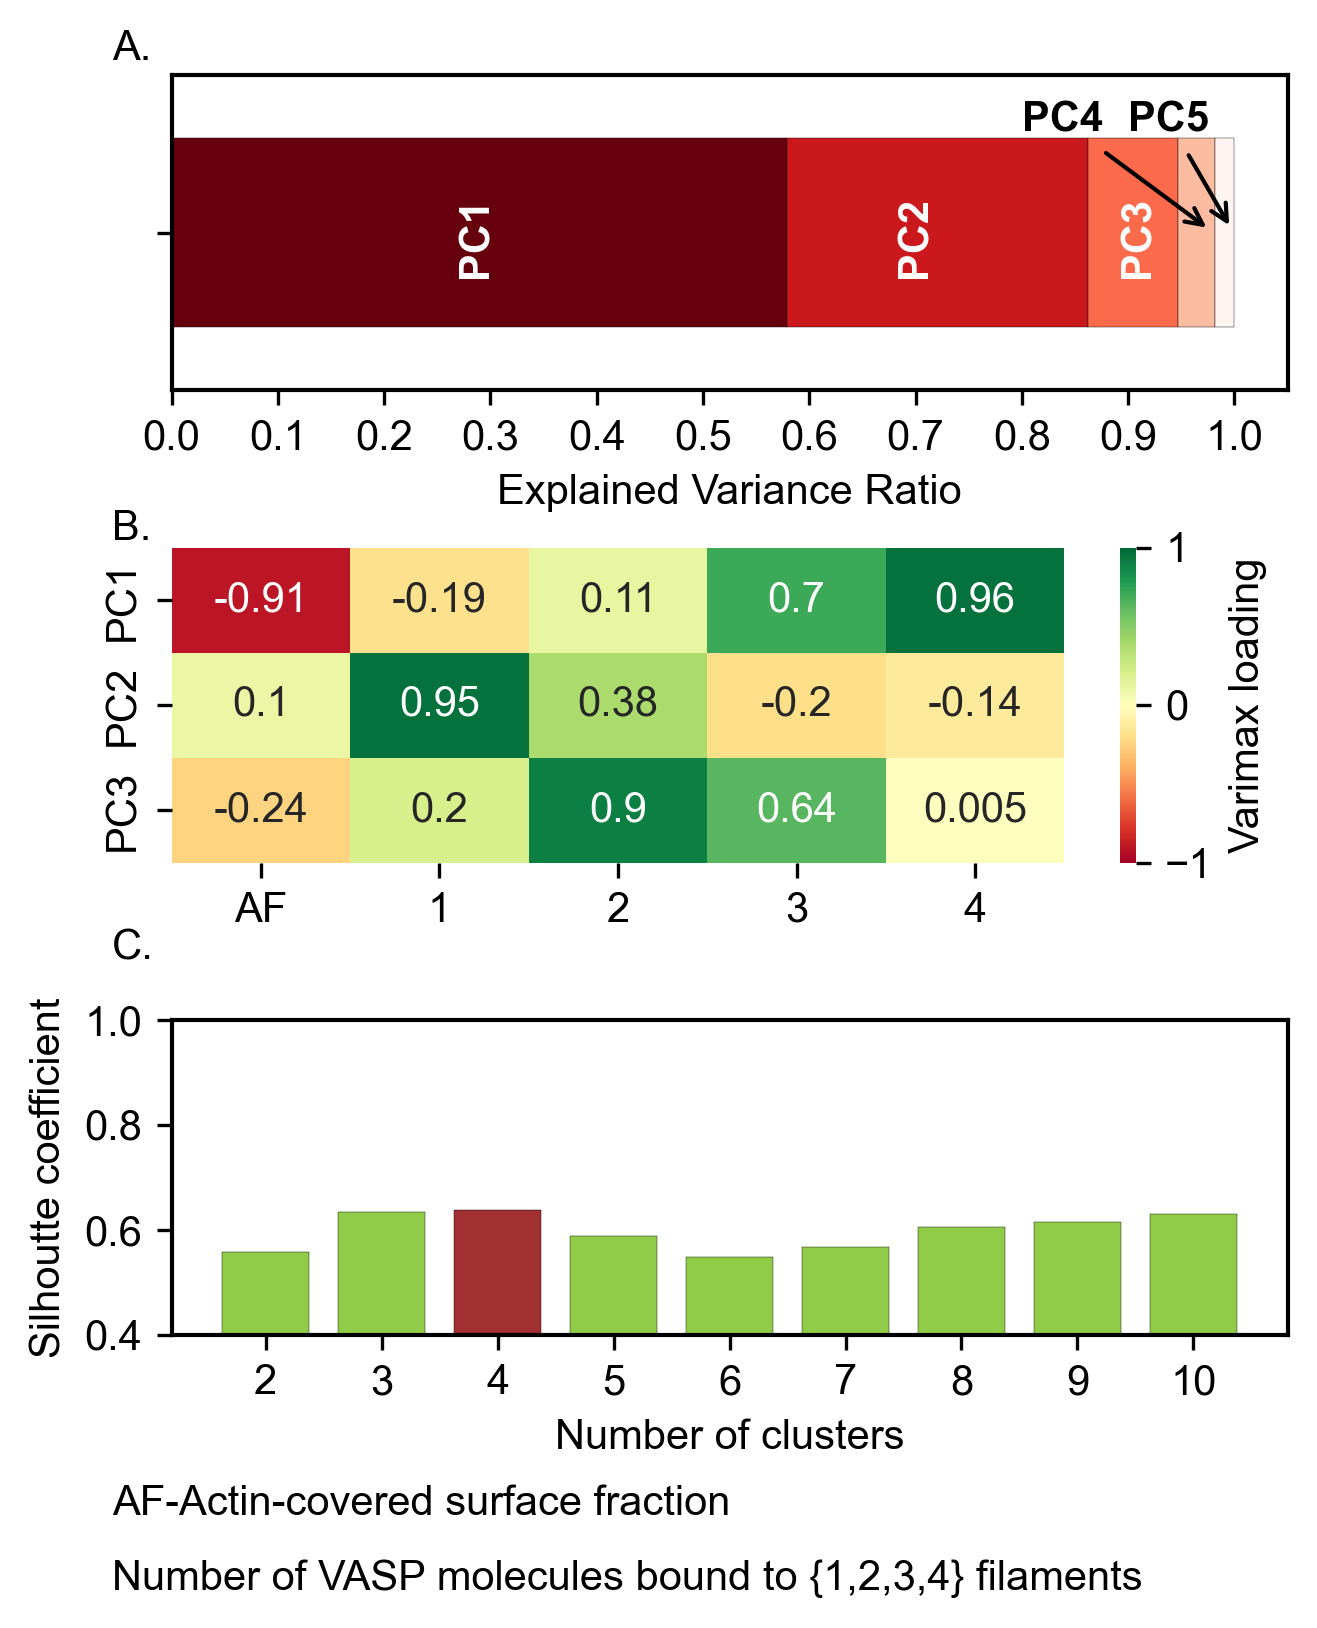

In [169]:
fig, axvec = plt.subplots(nrows=3, ncols=1,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.15, 
                    top=0.99,
                    wspace=0.2, 
                    hspace=0.5)
if GABMUTFLAG==False:
   pcadf=pd.read_csv('Fgrow10_3_steric_kmdf.csv',index_col=0)
else:
   pcadf=pd.read_csv('Fgrow10_3_steric_GABmutant_kmdf.csv',index_col=0)

# On Raw data
pca = PCA()
pca.fit_transform(df_V2)
# eratio = pca.explained_variance_ratio_
# print(np.cumsum(eratio))
# ax = axvec[0]
# ax.bar(range(1,6),eratio)
# ax.plot(range(1,6),np.cumsum(eratio))
# # On rescaled data
# pipe2["preprocessor"]["pca"].n_components = 5
# pipe2["preprocessor"].transform(df_V2)
# Get the PCA data 
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["component_1", "component_2","component_3"],
)
feature_names = ['SF','1','2','3','4']
#eratio = pipe2["preprocessor"]["pca"].explained_variance_ratio_
eratio = pca.explained_variance_ratio_
print(np.cumsum(eratio))
#ax.bar(range(1,6),eratio)
#ax.bar(range(1,6),np.cumsum(eratio),'stacked')
df = pd.DataFrame(eratio,index=['PC1','PC2','PC3','PC4','PC5'])
df = df.transpose()
print(df)
ax=axvec[0]
df.plot(ax=ax,kind='barh', stacked=True,legend=False, 
        width = 0.75, cmap='Reds_r',
        edgecolor = "black", linewidth=0.1)
y_offset=0.1
locpos = [0.57288853/2,0.7, 0.91]
print(locpos)
for i, total in enumerate(locpos):
  ax.text(total, -0.15, 'PC'+str(i+1), ha='center',
          weight='bold',rotation=90, color='white')
ax.annotate('PC4', xy=(0.98,0.0), xytext=(0.8, 0.4), weight='bold',
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.annotate('PC5', xy=(0.999,0.0), xytext=(0.9, 0.4), weight='bold',
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.set_xlabel('Explained Variance Ratio')
ax.set_xticks(0.1*np.arange(0,11))
ax.set_yticklabels('')
#################################
# VARIMAX HEATMAP
ax1=axvec[1]
# varimaxpipe['Varimax FA']['varimax'].n_components = 3
# varimaxpipe.fit(df_V2)
# components = varimaxpipe['Varimax FA']['varimax'].components_
# print(varimaxpipe['Varimax FA']['varimax'])
# df = pd.DataFrame(components,index=['PC1','PC2','PC3'],columns=['AF','1','2','3','4'])
# fig.text(0.0,0.03,'AF-Actin-covered surface fraction')
# fig.text(0.0,-0.02,'Number of VASP molecules bound to {1,2,3,4} filaments')
# print(df)
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=3, method='principal', rotation="varimax")
fa.fit(df_V2)
print(fa.loadings_.round(2))
print('The raw data correlation matrix')
print(fa.corr_)
print(fa.rotation_matrix_)
print('norm')
print(np.linalg.norm(pcadf, axis=0 ))
print(np.linalg.norm(np.matmul(pcadf,fa.rotation_matrix_), axis=0 ))
df = pd.DataFrame(fa.loadings_.T,index=['PC1','PC2','PC3'],columns=['AF','1','2','3','4'])
fig.text(0.0,0.03,'AF-Actin-covered surface fraction')
fig.text(0.0,-0.02,'Number of VASP molecules bound to {1,2,3,4} filaments')
print(df)
sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=-1.0, vmax=1.0, ax=ax1,
    cbar_kws={'label': 'Varimax loading'})
#ax1.set_yticklabels(['rPC1','rPC2','rPC3'])
##################################
# Empty lists to hold evaluation metrics
silhouette_scores = []
pipe2["preprocessor"]["pca"].n_components = 3
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe2["clusterer"]["kmeans"].n_clusters = n
    pipe2.fit(df_V2)
    model = pipe2.steps
    silhouette_coef = silhouette_score(
        pipe2["preprocessor"].transform(df_V2),
        pipe2["clusterer"]["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
print('Silhoutte coefficient')
print(silhouette_scores)
ax2=axvec[2]
ax2.bar(range(2,11),silhouette_scores, 
            color=['#90CC47', '#90CC47',"#a22f31",'#90CC47','#90CC47','#90CC47','#90CC47','#90CC47','#90CC47','#90CC47',],
            width = 0.75, edgecolor = "black", linewidth=0.1)
ax2.set_xticks(np.arange(2,11))
ax2.set_ylim([0.4,1.0])
ax2.set_ylabel('Silhoutte coefficient')
ax2.set_xlabel('Number of clusters')
##########
fig.text(0.0,1.0,'A.')
fig.text(0.0,0.68,'B.')
fig.text(0.0,0.4,'C.')
########### SAVE
if GABMUTFLAG==False:
    plt.savefig('Cluster_analysis_extended_GAB_steric.png', dpi=300, bbox_inches='tight')
    fig.savefig( 'Cluster_analysis_extended_GAB_steric.pdf', bbox_inches='tight')
else:
    plt.savefig('Cluster_analysis_extended_steric.png', dpi=300, bbox_inches='tight')
    fig.savefig( 'Cluster_analysis_extended_steric.pdf', bbox_inches='tight')

## FIGURE 6B - Get the $(k_{bind}, k_{nbind})$ present in each cluster

In [248]:
#kmdf = pd.read_csv('Fgrow10_3_kmdf_V2_extended.csv',index_col=0)
#kmdf = pd.read_csv('Fgrow10_3_steric_kmdf.csv',index_col=0)
if GABMUTFLAG==False:
    kmdf = pd.read_csv('Fgrow10_3_steric_kmdf.csv',index_col=0)
else:
    kmdf = pd.read_csv('Fgrow10_3_steric_GABmutant_kmdf.csv',index_col=0)
for clusterid in range(0,4):
    print('Cluster id ='+str(clusterid))
    X=kmdf.loc[kmdf["Predicted Cluster"] == clusterid]
    Y=(X.loc[:,["tag"]]).to_numpy()
    #print(Y.filter(like='kinetics'))
    Z = [];
    for yiter, y in enumerate(Y):
        a=y[0]
        b=a.split(",")
        # Z[yiter][0] = b[0][1:]
        # Z[yiter][1] = b[1][:]
        # b=a
        Z.append([b[0][1:],b[1][:]])
    if Z:
        Z = np.asarray(Z)
        unique_rows, counts = np.unique(Z, axis=0, return_counts=True)
        result = pd.DataFrame({'Conc/kbind': unique_rows[:,0],
                        'T2piR/kunbind':unique_rows[:,1],
                        'Probability':counts})
        probvec = []
        for index, row in result.iterrows():
            kunbind = float(row['T2piR/kunbind'])
            if  kunbind in [1.28125,1.3125,1.34375,1.375]:
                Nreps =10;Nsnaps=5
            elif kunbind in [1.125,1.15625,1.1875,1.21875,1.25,1.5,1.625,1.75,2.0]:
                Nreps =5;Nsnaps=5
            else:
                Nreps =3;Nsnaps=5
            probvec.append(row['Probability']/(Nreps*Nsnaps))
        result['Probability'] = probvec
        print(result)
        print("----------")
print('==============')

Cluster id =0
   Conc/kbind T2piR/kunbind  Probability
0      0.0001        0.0001          1.0
1      0.0001         0.001          1.0
2      0.0001          0.01          1.0
3      0.0001           0.1          1.0
4      0.0001           1.0          1.0
5      0.0001          10.0          1.0
6       0.001        0.0001          1.0
7       0.001         0.001          1.0
8       0.001          0.01          1.0
9       0.001           0.1          1.0
10      0.001           1.0          1.0
11      0.001          10.0          1.0
12       0.01          0.01          1.0
13       0.01           0.1          1.0
14       0.01           1.0          1.0
15       0.01          10.0          1.0
16        0.1           1.0          1.0
17        0.1          10.0          1.0
18        1.0       1.28125          0.5
19        1.0        1.3125          0.5
20        1.0       1.34375          0.4
21        1.0         1.375          0.5
22        1.0           1.5          1.0
23

## FIGURE 6B PLOTTER

In [ ]:
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.rcParams.update({'font.size': 11, 'font.family':'arial', 'font.weight':'normal'})
rgba = new_cmap(np.linspace(0, int(256/3), 256))
ring_prob = [0.67, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ring_like_prob = [0.33,0.6,1.0,1.0,1.0,1.0,1.0,0.5,0.5,0.6,0.5,0,0,0,]
shell_prob = [0,0,0,0,0,0,0,0.5,0.5,0.4,0.5,1.0,1.0,1.0,]
rbind = 0.03
Lseg = 0.1
VrxninL = np.pi*Lseg*rbind**2*1e-18*1e3
VrxninL = 4/3*np.pi*1e-18*1e3
Kd = np.round(np.array([0.1,1.0,1.125,1.5625,1.1875,1.21875,1.25,1.28125,1.3125,1.34375,1.375,1.5,1.625,1.75])/(1e-6*VrxninL*scipy.constants.Avogadro),6)
Kd = [0.1,1.0,1.125,1.5625,1.1875,1.21875,1.25,1.28125,1.3125,1.34375,1.375,1.5,1.625,1.75]
df=pd.DataFrame({'shell_prog':shell_prob,
                'ring_like_prob':ring_like_prob,
                'ring_prob':ring_prob,
                 'Kd':Kd})
print(df)
df.plot(ax=axvec,x='Kd',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            color=["#a22f31",'#D7B226','#5CBA47',], edgecolor = "black", linewidth=0.2,
            yticks=[0,0.25,0.5,0.75,1.0],ylabel='Percent abundance')
axvec.set_yticklabels([0,25,50,75,100])
axvec.set_ylim([0,1])
axvec.set_xlabel(r"$k_{unbind} (\mu M)$")
fig.legend(['Shell','Shell w. strong bundling','Ring'], fontsize=12,frameon=False,
                bbox_to_anchor=(0.99,1.1), labelspacing=0.2, ncol=2,handletextpad=0,columnspacing=0.2)
plt.tight_layout()
########### SAVE
plt.savefig('GABmut_simulation.png', dpi=300, bbox_inches='tight')
fig.savefig( 'GABmut_simulation.pdf', bbox_inches='tight')

## PLOTLY GIVES AN INTERACTIVE PLOT OF THE PC1 VS PC2 SPACE
Users can hover over each datapoint to see which snapshot it corresponds to

In [425]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import base64
import numpy as np
# Create dash app
app = dash.Dash(__name__)
# Generate dataframe
if GABMUTFLAG==False:
   kmdf = pd.read_csv('Fgrow10_3_steric_kmdf.csv',index_col=0)
else:
   kmdf = pd.read_csv('Fgrow10_3_steric_GABmutant_kmdf.csv',index_col=0)
kmdf["Predicted Cluster"] = kmdf["Predicted Cluster"].astype(str)
# X=kmdf.loc[kmdf["Predicted Cluster"]==0]
# kmdf["Predicted Cluster"] = kmdf["Predicted Cluster"].astype(str)
# print(X)
# Create scatter plot with x and y coordinates
# fig = px.scatter(kmdf, x="component_1", 
#                  y="component_2",
#                  custom_data=["images"],color="Predicted Cluster",
#                  hover_name="tag")
fig = px.scatter(kmdf, x="PC1", 
                 y="PC2",
                 custom_data=["images"],color="Predicted Cluster",
                 hover_name="tag")
fig.update_layout(
    font=dict(
        family="Arial",
        size=18,  # Set the font size here
        color="Black"
    )
)

# Update layout and update traces
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=5)

# Create app layout to show dash graph
app.layout = html.Div(
   [
      dcc.Graph(
         id="graph_interaction",
         figure=fig,
      ),
      html.Img(id='image', src='')
   ]
)

# html callback function to hover the data on specific coordinates
@app.callback(
   Output('image', 'src'),
   Input('graph_interaction', 'hoverData'))

def open_url(hoverData):
   if hoverData:
      return hoverData["points"][0]["customdata"][0]
   else:
      raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [14/May/2023 13:00:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [14/May/2023 13:00:25] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [14/May/2023 13:00:25] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [14/May/2023 13:00:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2023 13:00:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2023 13:00:29] "POST /_dash-u

## PLOT FIGURE 3E

[[-0.39304014  0.08709683 -0.02222906]
 [ 0.57916705  0.14917842 -0.15466605]
 [ 0.68414433  0.76506257  0.31589474]
 [ 0.25128904 -0.55431357  0.08954644]]
Shell
[0.1, 1.0, 2, 599]
['[0.1', ' 1.0', ' 2', ' 599]']
----
Shell w. strong bundling
[0.1, 0.01, 2, 595]
['[0.1', ' 0.01', ' 2', ' 595]']
----
Ring
[10.0, 1.0, 2, 595]
['[10.0', ' 1.0', ' 2', ' 595]']
----
Shell w. weak bundling
[0.1, 0.0001, 0, 599]
['[0.1', ' 0.0001', ' 0', ' 599]']
----
Closest point in each cluster
[array([-0.40160242,  0.08901875, -0.01786742]), array([ 0.66887794,  0.03763021, -0.23022134]), array([0.68342675, 0.76583992, 0.30913325]), array([ 0.34104981, -0.61181554,  0.00596501])]
Farthest point in each cluster
[array([-0.13426924, -0.10549963,  0.17145609]), array([ 0.61287884, -0.26304904, -0.18811691]), array([0.68872672, 0.62054431, 0.19687868]), array([-0.09864275, -0.61905022,  0.54908216])]


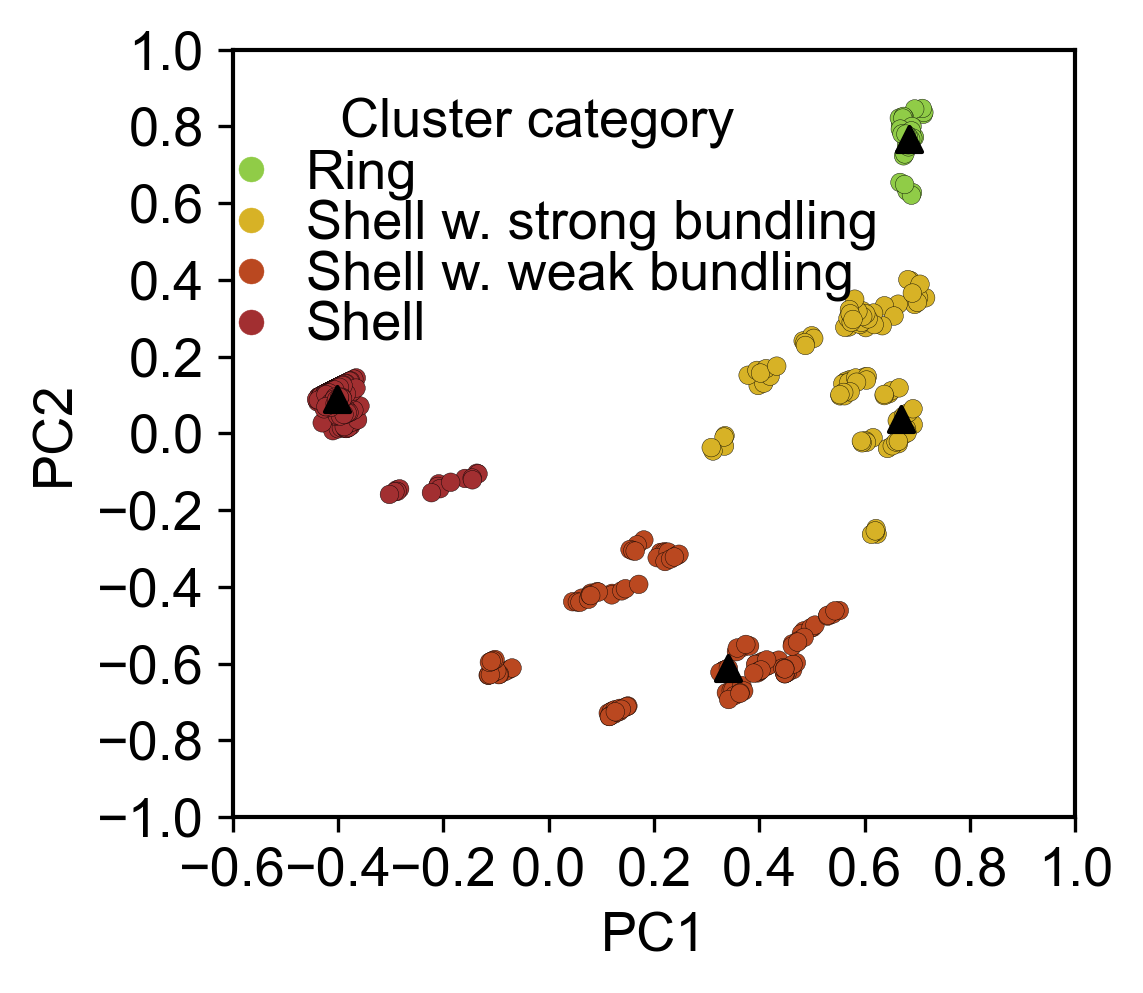

In [432]:
if GABMUTFLAG==False:
    extendedflag = False
    # Generate dataframe
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
    from sklearn.metrics import pairwise_distances_argmin_min , pairwise_distances
    plt.rcParams.update({'font.size': 13, 'font.family':'arial', 'font.weight':'normal'})
    kmdf = pd.read_csv('Fgrow10_3_steric_kmdf.csv',index_col=0)
    #Shell
    kmdf.loc[kmdf["Predicted Cluster"] ==0, "Predicted Cluster"] = 4
    # Ring
    kmdf.loc[kmdf["Predicted Cluster"] ==2, "Predicted Cluster"] = 0
    # Ring-like
    kmdf.loc[kmdf["Predicted Cluster"] ==3, "Predicted Cluster"] = 2
    # Shell
    kmdf.loc[kmdf["Predicted Cluster"] ==4, "Predicted Cluster"] = 3
    cluster_string = ['Shell', 'Shell w. strong bundling', 'Ring', 'Shell w. weak bundling']
    reordered_cluster = [3,1,0,2]

    fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4.0,3.5), 
                            dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
    scatter = axvec.scatter(data=kmdf, x="PC1", y="PC2",c="Predicted Cluster", cmap=new_cmap, 
                edgecolors='black', linewidths=0.1, s=20.0)
    if extendedflag == False:
        X=list(scatter.legend_elements(num=3))
        X[1]=['Ring','Ring-like','Shell-like', "Shell"]
        X[1] = ['Ring','Shell w. strong bundling','Shell w. weak bundling','Shell']
    else:
        X[1]=['#1 (Ring)','#2 (Shell)','#3 (Shell-like)','#4 (Ring-like)']
    legend1 = axvec.legend(X[0],X[1],frameon=False,bbox_to_anchor=(-0.1,1.0),
                        loc="upper left", title="Cluster category", labelspacing=0.0,handletextpad=0.)
    axvec.set_xlim([-0.6,1.0])
    axvec.set_ylim([-0.6,1.0])
    axvec.set_xticks([-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
    axvec.set_yticks([-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
    axvec.set_ylim([-1,1.0])
    axvec.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
    centers = np.array( pipe2["clusterer"]["kmeans"].cluster_centers_)
    print(centers)

    closest_point = []
    farthest_point = []
    for i, ccoord in enumerate(centers):
        print(cluster_string[i])
        subdata = kmdf.loc[kmdf['Predicted Cluster'] == reordered_cluster[i]]
        tag = subdata['tag'].to_numpy()
        subdata = subdata[['PC1','PC2','PC3']].to_numpy()
        distances= pairwise_distances([ccoord],subdata,)
        index_min = np.argmin(distances)
        index_max = np.argmax(distances)
        closest_point.append(subdata[index_min,:])
        farthest_point.append(subdata[index_max,:])
        print(tag[index_min])
        b=tag[index_min].split(",")
        print(b)
        # print(utilityN1e3(float(b[0][1:]), float(b[1][:])))
        #print(tag[index_max])
        b=tag[index_max].split(",")
        #print(utilityN1e3(float(b[0][1:]), float(b[1][:])))
        print('----')
    # Plot centers
    print("Closest point in each cluster")
    print(closest_point)
    print("Farthest point in each cluster")
    print(farthest_point)
    #axvec.scatter(centers[:,0],centers[:,1],c='black',marker='X')
    closest_point=np.array(closest_point)
    farthest_point=np.array(farthest_point)
    THREED=False
    if THREED:
        ax=plt.subplot(1,1,1, projection='3d')
        x=kmdf["PC1"];y=kmdf["PC2"];z=kmdf["PC3"]
        scatter = ax.scatter(x,y,z,c=kmdf["Predicted Cluster"], cmap=new_cmap, 
                            edgecolors='black', linewidths=0.1, s=20.0)
        ax.scatter(centers[:,0],centers[:,1],centers[:,2],c='black',marker='o')
        ax.scatter(closest_point[:,0],closest_point[:,1],closest_point[:,2],c='black',marker='^',s=100)

    #axvec.scatter(centers[:,0],centers[:,1],c='black',marker='o')
    axvec.scatter(closest_point[:,0],closest_point[:,1],c='black',marker='^')
    #axvec.scatter(farthest_point[:,0],farthest_point[:,1],c='black',marker='v')
    # Plot closest point
    axvec.set_xlabel('PC1')
    axvec.set_ylabel('PC2')
    # ########### SAVE
    fig.tight_layout()
    plt.savefig('Kmeans_steric.png', dpi=300, bbox_inches='tight')
    fig.savefig( 'Kmeans_steric.pdf', bbox_inches='tight')

# FIGURE 5 - K MEANS CLUSTERING - STERIC $T_{2\pi R}$

## OBTAIN DATA

In [170]:
filereadpath = 'FIGURE_5/OUTPUTFILES/'
foldername = 'Actin_addn_ring_steric_tscc_30nm_rigidity_0_075_set2'
# SHOULD HAVE THE IMAGES OF TRAJECTORIES RENDERED IN THE FOLLOWING DIRECTORY.
# FOR EXAMPLE, R_0_r_0 folder should have the all images of the trajectory in the corresponding objects.cmo
imagefilepathv = 'FIGURE_5/INPUTFILES/'
Nreps = 6
jointKmeans = True
if jointKmeans == False:
    FORow1 = []
    Row9 = []
    Row11 = []
    Row13 = []
    Row15 = []
    FORow1=np.array([])
    imagelist = []
    taglist = []
    spanc = []
    spanb = []
    spana = []
else:
    #retlist = obtaindata_steric()
    retlist = obtaindata_ring_ringlike()
    for i in range(0,len(retlist)):
        FORow1 = retlist[0]
        Row9 = retlist[1]
        Row11 = retlist[2]
        Row13 = retlist[3]
        Row15 = retlist[4]
        imagelist = retlist[5]
        taglist = retlist[6]
        spanc = retlist[7]
        spanb = retlist[8]
        spana=retlist[9]
    
Vasp_conc = [0.2, 0.4, 0.8, 1.0, 2.0]
TotalVASP = [505, 1000, 2018, 2522, 5044]
T2piR=[10, 50, 150, 200, 450, 600]
###
for titer, tval in enumerate (T2piR):
    for vconciter, vconc in enumerate(Vasp_conc):
        Rval = titer*len(Vasp_conc)+vconciter
        for repid in range(0,Nreps):
            fvar = filereadpath+'/Crosslink_'+foldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                Nsnaps = 5
                lenval = len(df.columns)
                tv  = TotalVASP[vconciter]
                startpos = 600-Nsnaps
                endpos = 600
                Row9 = np.append(Row9, df.iloc[9].to_numpy()[startpos:endpos]/tv)
                Row11 = np.append(Row11, df.iloc[11].to_numpy()[startpos:endpos]/tv)
                Row13 = np.append(Row13, df.iloc[13].to_numpy()[startpos:endpos]/tv)
                Row15 = np.append(Row15, df.iloc[15].to_numpy()[startpos:endpos]/tv)
            else:
                print('DOES NOT EXIST'+fvar,flush=True)
            fvar = filereadpath+'/FO_'+foldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                FORow1 = np.append(FORow1, df.iloc[1].to_numpy()[startpos:endpos])
            else:
                print('DOES NOT EXIST'+fvar,flush=True)
            
            fvar = filereadpath+'/Eigval'+foldername+'R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                spanc = np.append(spanc, df.iloc[1].to_numpy()[startpos:endpos])
                spanb = np.append(spanb, df.iloc[2].to_numpy()[startpos:endpos])
                spana = np.append(spana, df.iloc[3].to_numpy()[startpos:endpos])
            else:
                print('DOES NOT EXIST'+fvar,flush=True)

print('Data length dim2 = '+ str(len(FORow1)))
print('Data length dim2 = '+ str(len(Row9)))
print('Data length dim2 = '+ str(len(Row13)))
print('Data length dim2 = '+ str(len(Row15)))
#####################
sumspan = np.array(spana)+np.array(spanb)+np.array(spanc)
df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
                      '1':np.transpose(Row9),
                      '2':np.transpose(Row11), 
                      '3':np.transpose(Row13), 
                      '4':np.transpose(Row15),})
#print(df_V2)
print(df_V2.corr(method='pearson', min_periods=1))
import cv2
import base64
def _get_image(path):
    #read bytes from and get the bytes as image_file
    with open(path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    encoded_img = f'data:image/png;base64,{encoded_string}'
    return encoded_img
imagefilepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/'+foldername+'/'
for titer, tval in enumerate (T2piR):
    for vconciter, vconc in enumerate(Vasp_conc):
            Rval = titer*len(Vasp_conc)+vconciter
            for repid in range(0,Nreps):
                for sidx in range(startpos,endpos):
                    taglist.append(['T2piR',vconc,tval,repid,sidx])
                    subdirname = '/R_'+str(Rval)+'_r_'+str(repid)+'/'
                    imagename = "movie"+ f'{sidx:04d}'+".png"
                    fvar =  imagefilepathv+subdirname+imagename
                    img = cv2.imread(fvar)
                    img_25 = cv2.resize(img, None, fx = 0.25, fy = 0.25)
                    retval, buffer = cv2.imencode('.png', img_25)
                    jpg_as_text = base64.b64encode(buffer).decode()
                    imagelist.append( f'data:image/png;base64,{jpg_as_text}')
print(len(imagelist))

Data length dim1 = 135
Data length dim2 = 135
135
Data length dim2 = 1035
Data length dim2 = 1035
Data length dim2 = 1035
Data length dim2 = 1035
                                 Actin occupied Surface Fraction         1  \
Actin occupied Surface Fraction                         1.000000  0.417120   
1                                                       0.417120  1.000000   
2                                                       0.367173  0.743863   
3                                                       0.220567  0.284908   
4                                                      -0.378734 -0.767726   

                                        2         3         4  
Actin occupied Surface Fraction  0.367173  0.220567 -0.378734  
1                                0.743863  0.284908 -0.767726  
2                                1.000000  0.777556 -0.954193  
3                                0.777556  1.000000 -0.784157  
4                               -0.954193 -0.784157  1.000000  
1

## FIGURE S8 - SANITY CHECKS

Explained variance=
[3.34672802e-02 8.39940361e-03 1.81580001e-03 3.67096560e-04
 4.60539412e-05]
Explained variance ratio=
[0.75897038 0.9494519  0.99063058 0.99895559 1.        ]
       PC1       PC2       PC3       PC4       PC5
0  0.75897  0.190482  0.041179  0.008325  0.001044
[0.286444265]
FactorAnalysis(n_components=3, rotation='varimax')
[[ 0.12  0.97  0.2 ]
 [ 0.16  0.22  0.96]
 [ 0.73  0.16  0.64]
 [ 0.98  0.09  0.1 ]
 [-0.72 -0.17 -0.65]]
The raw data correlation matrix
[[ 1.          0.41711995  0.36717343  0.22056727 -0.37873385]
 [ 0.41711995  1.          0.74386319  0.28490826 -0.76772554]
 [ 0.36717343  0.74386319  1.          0.77755589 -0.95419325]
 [ 0.22056727  0.28490826  0.77755589  1.         -0.78415734]
 [-0.37873385 -0.76772554 -0.95419325 -0.78415734  1.        ]]
[[ 0.69699341  0.31051536  0.64635934]
 [-0.58231799  0.77110585  0.25749082]
 [-0.41845661 -0.55585607  0.71827438]]
norm
[12.08617009  6.42754102  4.42942471]
           AF         1         2    

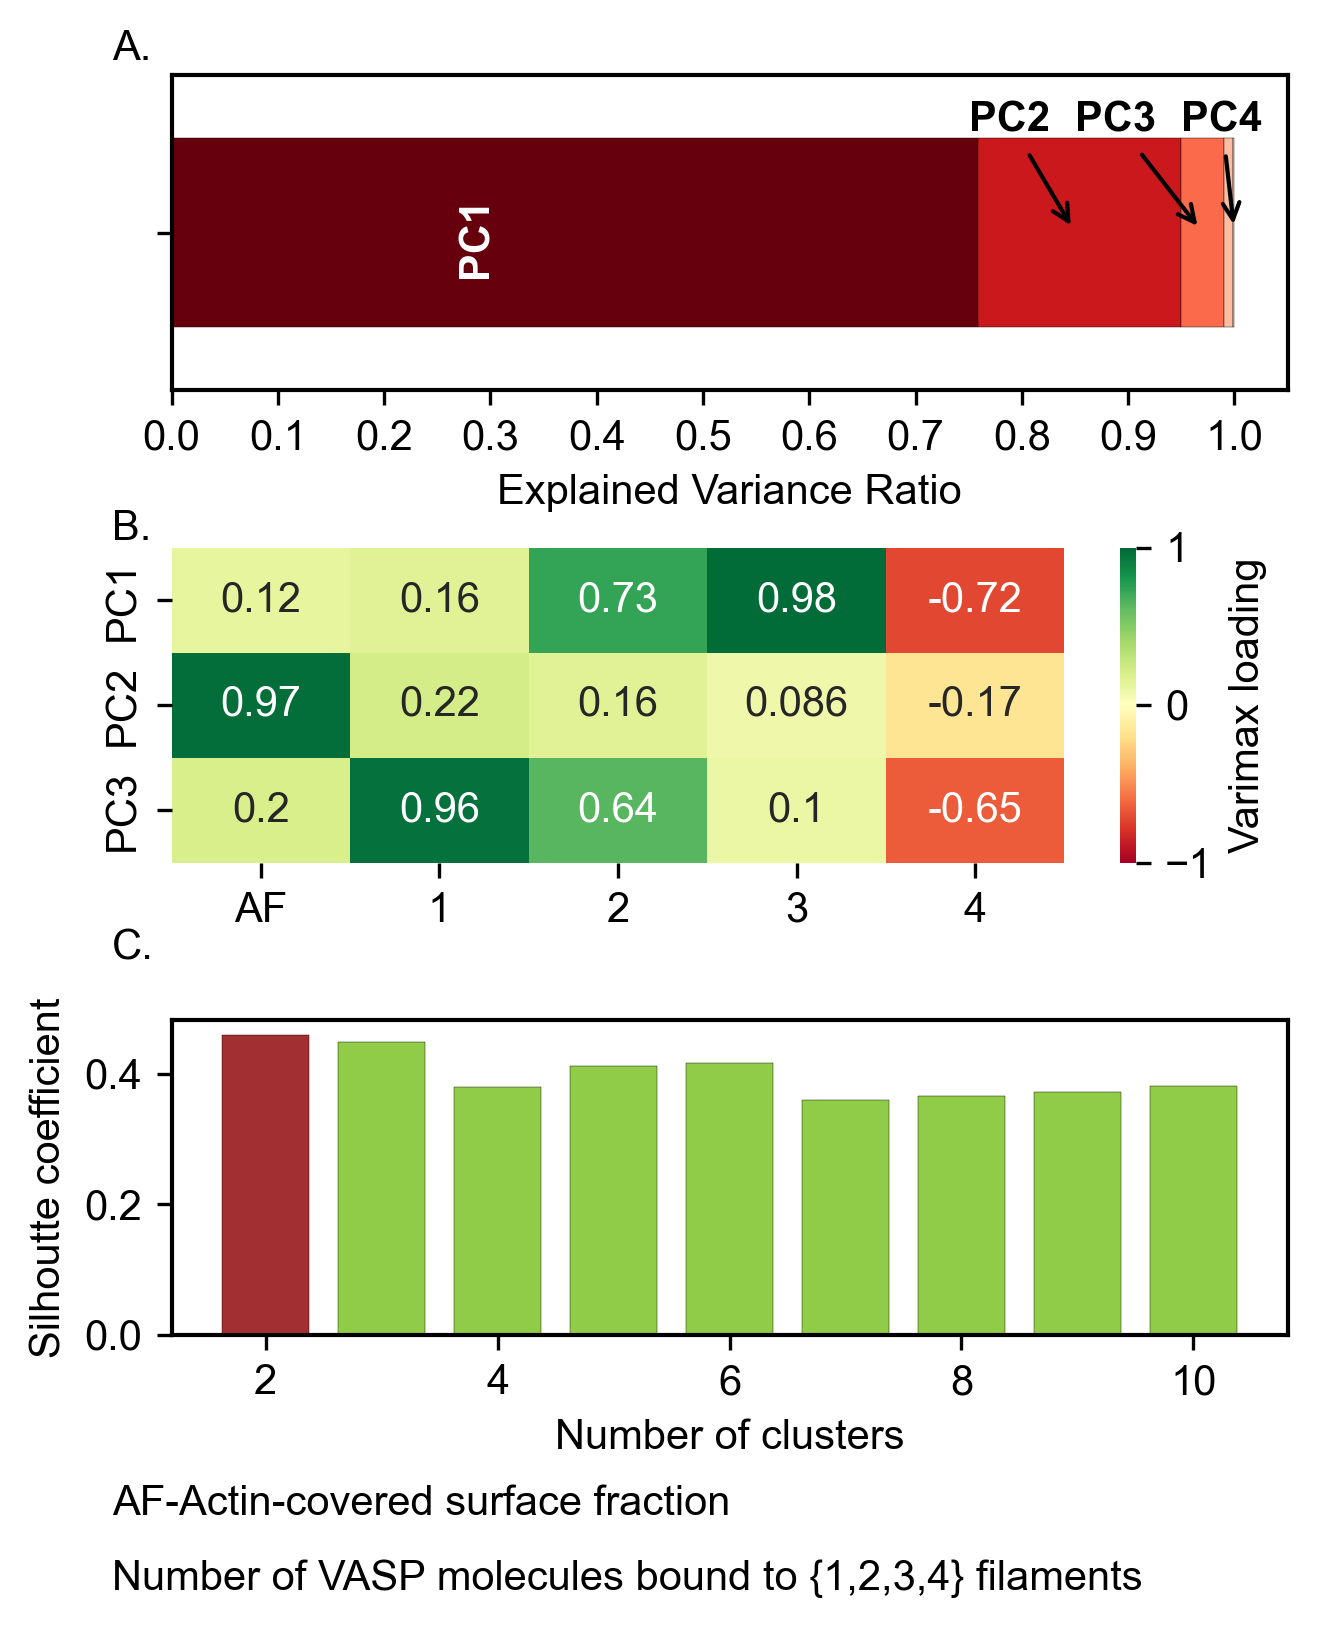

In [177]:
# retlist = retlist = obtaindata_GAB(jointKmeans)
# for i in range(0,len(retlist)):
#     FORow1 = retlist[0]
#     Row9 = retlist[1]
#     Row11 = retlist[2]
#     Row13 = retlist[3]
#     Row15 = retlist[4]
#     imagelist = retlist[5]
#     taglist = retlist[6]
# df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
#                       '1':np.transpose(Row9),
#                       '2':np.transpose(Row11), 
#                       '3':np.transpose(Row13), 
#                       '4':np.transpose(Row15)})
fig, axvec = plt.subplots(nrows=3, ncols=1,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.15, 
                    top=0.99,
                    wspace=0.2, 
                    hspace=0.5)
# On Raw data
pca = PCA()
pca.fit_transform(df_V2)
# eratio = pca.explained_variance_ratio_
# print(np.cumsum(eratio))
# ax = axvec[0]
# ax.bar(range(1,6),eratio)
# ax.plot(range(1,6),np.cumsum(eratio))
# # On rescaled data
# pipe2["preprocessor"]["pca"].n_components = 5
# pipe2["preprocessor"].transform(df_V2)
# Get the PCA data 
pipe2["preprocessor"]["pca"].n_components = 3
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["component_1", "component_2", "component_3"],
)
feature_names = ['SF','1','2','3','4']
#eratio = pipe2["preprocessor"]["pca"].explained_variance_ratio_
eratio = pca.explained_variance_ratio_
print('Explained variance=')
print(pca.explained_variance_)
print('Explained variance ratio=')
print(np.cumsum(eratio))
#ax.bar(range(1,6),eratio)
#ax.bar(range(1,6),np.cumsum(eratio),'stacked')
df = pd.DataFrame(eratio,index=['PC1','PC2','PC3','PC4','PC5'])
df = df.transpose()
print(df)
ax=axvec[0]
df.plot(ax=ax,kind='barh', stacked=True,legend=False, 
        width = 0.75, cmap='Reds_r',
        edgecolor = "black", linewidth=0.1)
y_offset=0.1
locpos = [0.57288853/2]
print(locpos)
for i, total in enumerate(locpos):
  ax.text(total, -0.15, 'PC'+str(i+1), ha='center',
          weight='bold',rotation=90, color='white')
  
  if jointKmeans:
    ax.annotate('PC2', xy=(0.85,0.0), xytext=(0.75, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC3', xy=(0.97,0.0), xytext=(0.85, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC4', xy=(1.0,0.0), xytext=(0.95, 0.4), weight='bold',
        arrowprops=dict(facecolor='black', arrowstyle="->"))
  else:
    ax.annotate('PC2', xy=(0.93,0.0), xytext=(0.75, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC3', xy=(0.999,0.0), xytext=(0.91, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC4', xy=(1.0,0.0), xytext=(0.95, 0.4), weight='bold',
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.set_xlabel('Explained Variance Ratio')
ax.set_xticks(0.1*np.arange(0,11))
ax.set_yticklabels('')
#################################
# VARIMAX HEATMAP
ax1=axvec[1]
varimaxpipe['Varimax FA']['varimax'].n_components = 3
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=3, method='principal', rotation="varimax")
fa.fit(df_V2)
print(fa.loadings_.round(2))
print('The raw data correlation matrix')
print(fa.corr_)
print(fa.rotation_matrix_)
print('norm')
print(np.linalg.norm(pcadf, axis=0 ))
# print(np.linalg.norm(np.matmul(pcadf,fa.rotation_matrix_), axis=0 ))
df = pd.DataFrame(fa.loadings_.T,index=['PC1','PC2','PC3'],columns=['AF','1','2','3','4'])
fig.text(0.0,0.03,'AF-Actin-covered surface fraction')
fig.text(0.0,-0.02,'Number of VASP molecules bound to {1,2,3,4} filaments')
print(df)
sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=-1.0, vmax=1.0, ax=ax1,
    cbar_kws={'label': 'Varimax loading'})
##################################
# Empty lists to hold evaluation metrics
silhouette_scores = []
pipe2["preprocessor"]["pca"].n_components = 3
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe2["clusterer"]["kmeans"].n_clusters = n
    pipe2.fit(df_V2)
    model = pipe2.steps
    silhouette_coef = silhouette_score(
        pipe2["preprocessor"].transform(df_V2),
        pipe2["clusterer"]["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
print(silhouette_scores)
ax2=axvec[2]
ax2.bar(range(2,11),silhouette_scores, 
            color=["#a22f31",'#90CC47', '#90CC47','#90CC47','#90CC47','#90CC47','#90CC47', '#90CC47','#90CC47','#90CC47','#90CC47',],
            width = 0.75, edgecolor = "black", linewidth=0.1)
#ax2.set_ylim([0.6,1])
ax2.set_ylabel('Silhoutte coefficient')
ax2.set_xlabel('Number of clusters')
##########
fig.text(0.0,1.0,'A.')
fig.text(0.0,0.68,'B.')
fig.text(0.0,0.4,'C.')
########### SAVE
# if jointKmeans:
#     plt.savefig('Joint_T2piR_Cluster_analysis_30nm.png', dpi=300, bbox_inches='tight')
#     fig.savefig( 'Joint_T2piR_Cluster_analysis_30nm.pdf', bbox_inches='tight')
# else:
plt.savefig('T2piR_Cluster_analysis_30nm_steric.png', dpi=300, bbox_inches='tight')
fig.savefig( 'T2piR_Cluster_analysis_30nm_steric.pdf', bbox_inches='tight')

## FIT

FactorAnalysis(n_components=2, rotation='varimax')
[[ 0.04303004  0.03256514  0.14926918  0.21672393 -0.18276621]
 [ 0.08129362  0.12083396  0.11043999  0.0087059  -0.13973605]]
0       0
1       0
2       0
3       0
4       0
       ..
1030    0
1031    0
1032    0
1033    0
1034    0
Name: Predicted Cluster, Length: 1035, dtype: object


(0.0, 1.5)

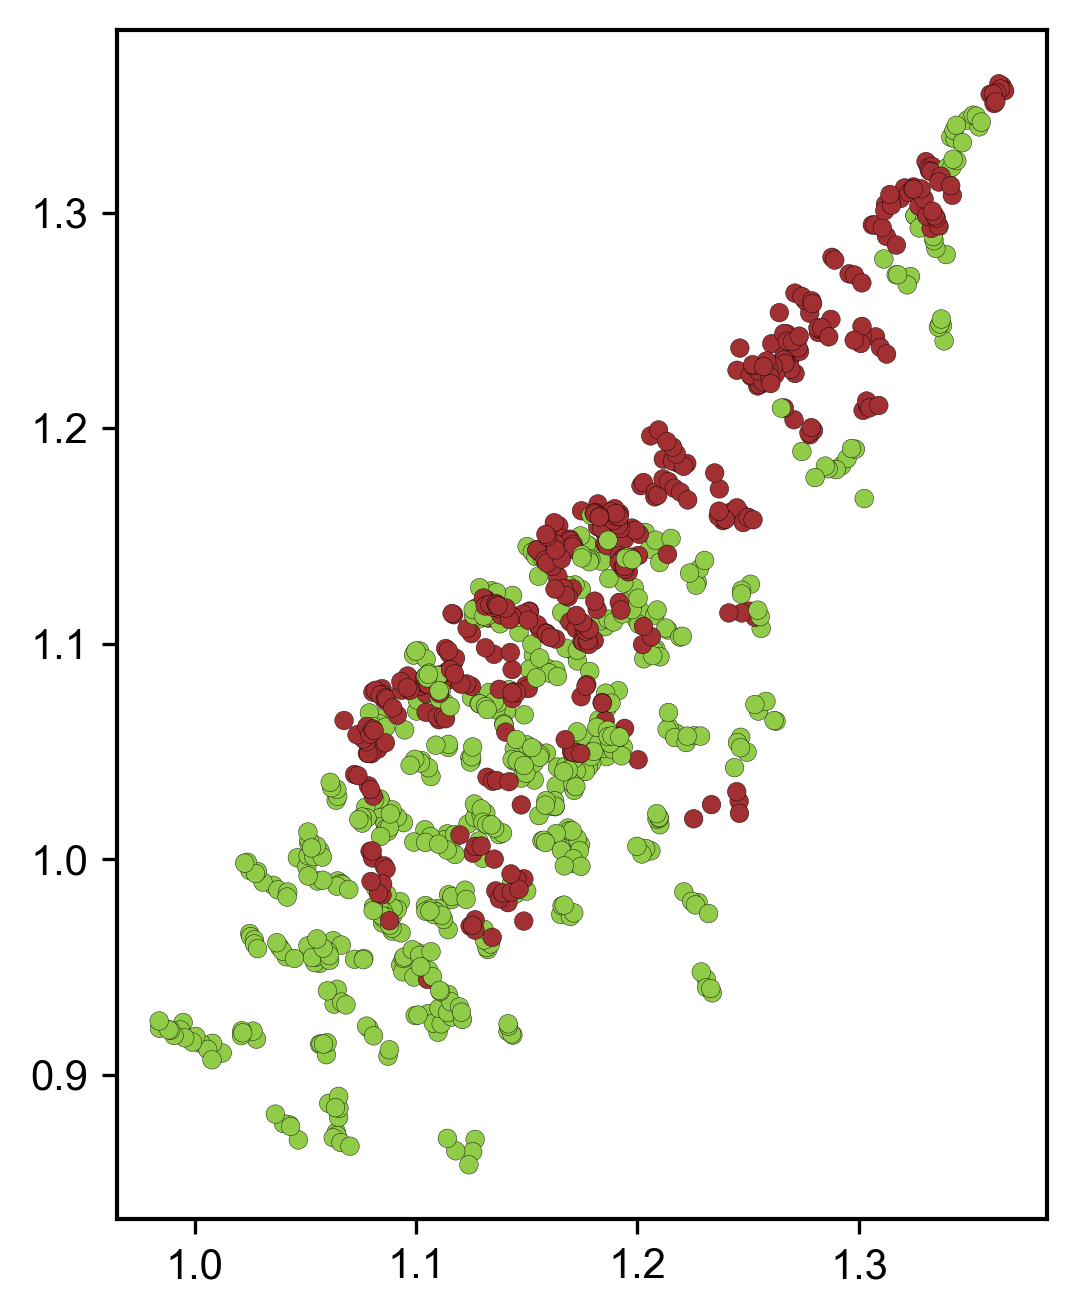

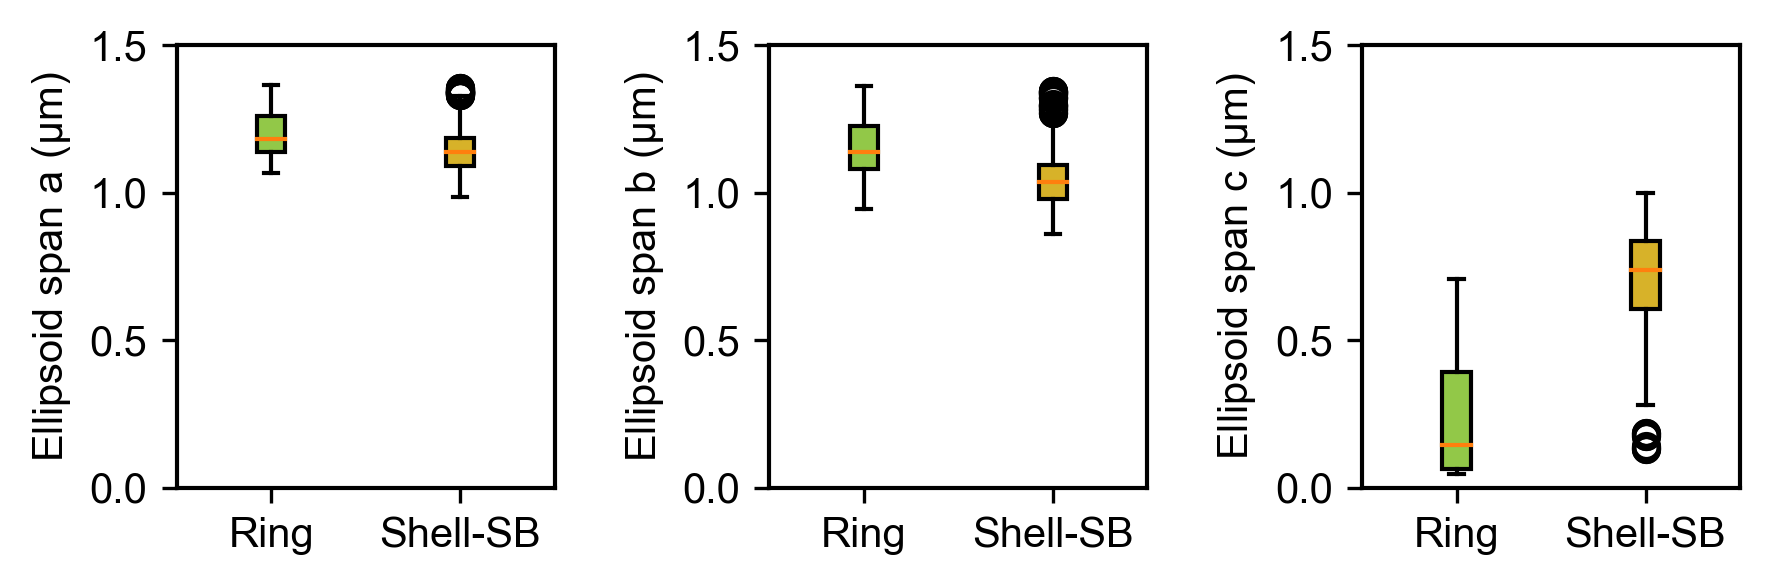

In [160]:
# retlist = retlist = obtaindata_GAB(True)
# for i in range(0,len(retlist)):
#     FORow1 = retlist[0]
#     Row9 = retlist[1]
#     Row11 = retlist[2]
#     Row13 = retlist[3]
#     Row15 = retlist[4]
#     imagelist = retlist[5]
#     taglist = retlist[6]
# df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
#                       '1':np.transpose(Row9),
#                       '2':np.transpose(Row11), 
#                       '3':np.transpose(Row13), 
#                       '4':np.transpose(Row15)})

pipe2["preprocessor"]["pca"].n_components = 3
pipe2["clusterer"]["kmeans"].n_clusters = 2
pipe2.fit(df_V2)
# Get the PCA data 
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["PC1", "PC2", "PC3" ],
)
feature_names = ['SF','1','2','3','4']
#
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
print(components)
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
centers = np.array( pipe2["clusterer"]["kmeans"].cluster_centers_)
pcadf.to_csv('Steric_Joint_T2piR_kmdf_V2_30nm.csv')

## FIGURE S9

In [ ]:
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4.0,5.25), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plotdf = pd.DataFrame({'spanc':spanc,
                       'spanb':spanb,
                       'spana':spana,
                       'Predicted Cluster':pcadf['Predicted Cluster']})
colorvec = ['#92C848','#D7B229']
print(plotdf["Predicted Cluster"])
plotdf["Predicted Cluster"] = plotdf["Predicted Cluster"].astype(int)
scatter = axvec.scatter(data=plotdf, x="spanc", y="spanb",c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.1, s=20.0)

fig, axvec = plt.subplots(nrows=1, ncols=3,figsize=(6.0,2.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
bplot = axvec[0].boxplot([plotdf[plotdf['Predicted Cluster'] == 1]['spanc'].values,
                           plotdf[plotdf['Predicted Cluster'] == 0]['spanc'].values,
                          ],patch_artist=True,)
for patch, color in zip(bplot['boxes'], colorvec):
    patch.set_facecolor(color)
axvec[0].set_xticklabels(['Ring','Shell-SB'])
axvec[0].set_ylabel(r'Ellipsoid span a $(\mu m)$')

bplot = axvec[1].boxplot([plotdf[plotdf['Predicted Cluster'] == 1]['spanb'].values,
                           plotdf[plotdf['Predicted Cluster'] == 0]['spanb'].values,],patch_artist=True,)
for patch, color in zip(bplot['boxes'], colorvec):
    patch.set_facecolor(color)
axvec[1].set_xticklabels(['Ring','Shell-SB'])
axvec[1].set_ylabel(r'Ellipsoid span b $(\mu m)$')

bplot = axvec[2].boxplot([plotdf[plotdf['Predicted Cluster'] == 1]['spana'].values,
                plotdf[plotdf['Predicted Cluster'] == 0]['spana'].values,],patch_artist=True,)
for patch, color in zip(bplot['boxes'], colorvec):
    patch.set_facecolor(color)
axvec[2].set_xticklabels(['Ring','Shell-SB'])
axvec[2].set_ylabel(r'Ellipsoid span c $(\mu m)$')
plt.tight_layout()
axvec[0].set_ylim([0,1.5])
axvec[1].set_ylim([0,1.5])
axvec[2].set_ylim([0,1.5])
# plotdf.plot.scatter(x='spanc',y='spanb',marker='o',ax=axvec,c='Predicted Cluster')
# axvec.set_xlim([-0.5,1.0])
# axvec.set_ylim([-0.8,0.8])

## PLOTLY

In [348]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import base64
import numpy as np
# Create dash app
app = dash.Dash(__name__)
# Generate dataframe
kmdf = pd.read_csv('Steric_Joint_T2piR_kmdf_V2_30nm.csv',index_col=0)
kmdf["Predicted Cluster"] = kmdf["Predicted Cluster"].astype(str)
# X=kmdf.loc[kmdf["Predicted Cluster"]==0]
# kmdf["Predicted Cluster"] = kmdf["Predicted Cluster"].astype(str)
# print(X)
# Create scatter plot with x and y coordinates
# fig = px.scatter(kmdf, x="component_1", 
#                  y="component_2",
#                  custom_data=["images"],color="Predicted Cluster",
#                  hover_name="tag")
fig = px.scatter(kmdf, x="PC1", 
                 y="PC2",
                 custom_data=["images"],color="Predicted Cluster",
                 hover_name="tag")
fig.update_layout(
    font=dict(
        family="Arial",
        size=18,  # Set the font size here
        color="Black"
    )
)

# Update layout and update traces
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=5)

# Create app layout to show dash graph
app.layout = html.Div(
   [
      dcc.Graph(
         id="graph_interaction",
         figure=fig,
      ),
      html.Img(id='image', src='')
   ]
)

# html callback function to hover the data on specific coordinates
@app.callback(
   Output('image', 'src'),
   Input('graph_interaction', 'hoverData'))

def open_url(hoverData):
   if hoverData:
      return hoverData["points"][0]["customdata"][0]
   else:
      raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [13/May/2023 22:46:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:20] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2023 22:46:20] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2023 22:46:20] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:21] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:22] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [13/May/2023 22:46:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2023 22:46:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13

## GET DATA ABOUT CLUSTERS

In [149]:
jointKmeans = True
Nreps = 6
Nsnaps = 5
kmdf = pd.read_csv('Steric_Joint_T2piR_kmdf_V2_30nm.csv',index_col=0)
for tag in ['kinetics', 'T2piR']:
    if tag == 'kinetics':
        Nframes = 15
    else:
        Nframes = Nreps*Nsnaps
    for clusterid in range(0,1):
        print('Cluster id ='+str(clusterid))
        X=kmdf.loc[kmdf["Predicted Cluster"] == clusterid]
        Y=(X.loc[:,["tag"]]).to_numpy()
        #print(Y.filter(like='kinetics'))
        Z = [];
        for yiter, y in enumerate(Y):
            a=y[0]
            b=a.split(",")
            if tag in b[0][:]:
                Z.append([float(b[1][1:]), float(b[2][:])])
        if Z:
            Z = np.asarray(Z)
            unique_rows, counts = np.unique(Z, axis=0, return_counts=True)
            result = pd.DataFrame({'Conc/kbind': unique_rows[:,0],
                                'T2piR/kunbind':unique_rows[:,1],
                                'Probability':counts/Nframes})
            print(result.to_string())
            print("----------")
    print('==============')

Cluster id =0
Cluster id =0
    Conc/kbind  T2piR/kunbind  Probability
0          0.2           10.0     0.666667
1          0.2           50.0     0.533333
2          0.2          150.0     0.833333
3          0.2          200.0     0.166667
4          0.2          450.0     0.166667
5          0.2          600.0     0.166667
6          0.4           10.0     1.000000
7          0.4           50.0     0.666667
8          0.4          150.0     0.166667
9          0.4          450.0     0.166667
10         0.4          600.0     0.366667
11         0.8           10.0     1.000000
12         0.8           50.0     0.666667
13         0.8          150.0     0.500000
14         0.8          200.0     0.633333
15         0.8          450.0     0.133333
16         0.8          600.0     0.166667
17         1.0           10.0     1.000000
18         1.0           50.0     0.833333
19         1.0          150.0     0.666667
20         1.0          200.0     0.666667
21         1.0          45

## FIGUIRE 5D PLOT RING PROBABILITY HEATMAP

[[0.         0.16666667 0.         0.33333333 0.16666667 0.5       ]
 [0.         0.16666667 0.33333333 0.33333333 0.83333333 0.53333333]
 [0.         0.33333333 0.5        0.36666667 0.86666667 0.83333333]
 [0.         0.33333333 0.83333333 1.         0.83333333 0.63333333]
 [0.33333333 0.46666667 0.16666667 0.83333333 0.83333333 0.83333333]]
[0 1 2 3 4]
[0.33333333 0.46666667 0.16666667 0.83333333 0.83333333 0.83333333]
[0.         0.33333333 0.83333333 1.         0.83333333 0.63333333]
[0.         0.33333333 0.5        0.36666667 0.86666667 0.83333333]
[0.         0.16666667 0.33333333 0.33333333 0.83333333 0.53333333]
[0.         0.16666667 0.         0.33333333 0.16666667 0.5       ]
[0.33333333 0.46666667 0.16666667 0.83333333 0.83333333 0.83333333]


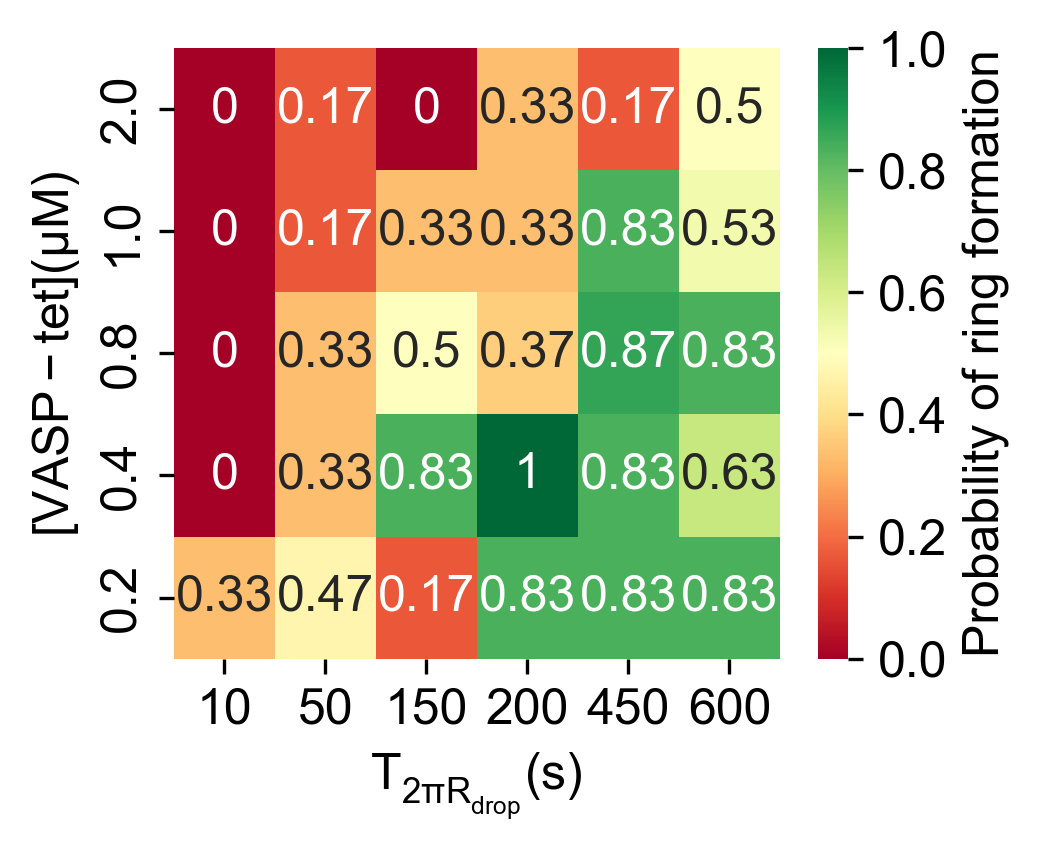

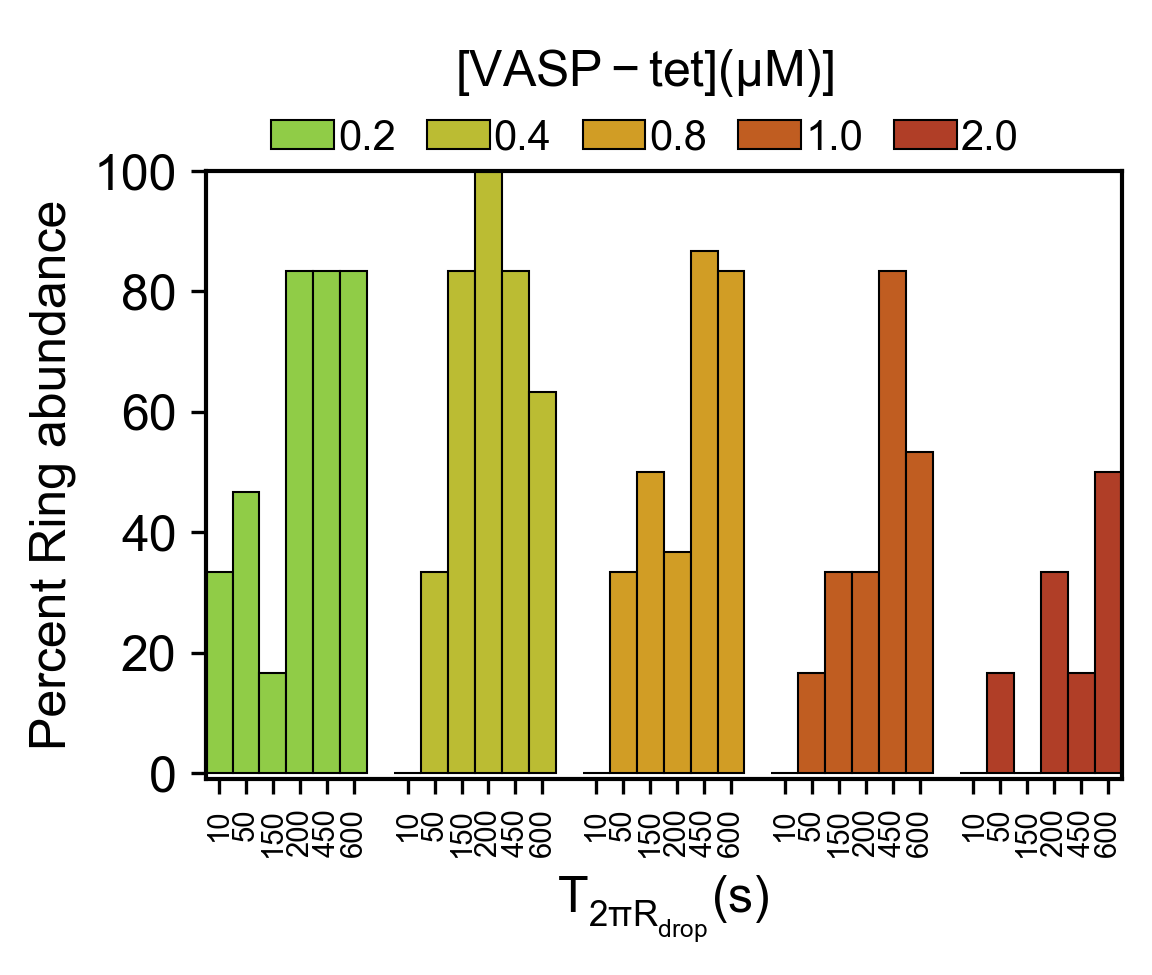

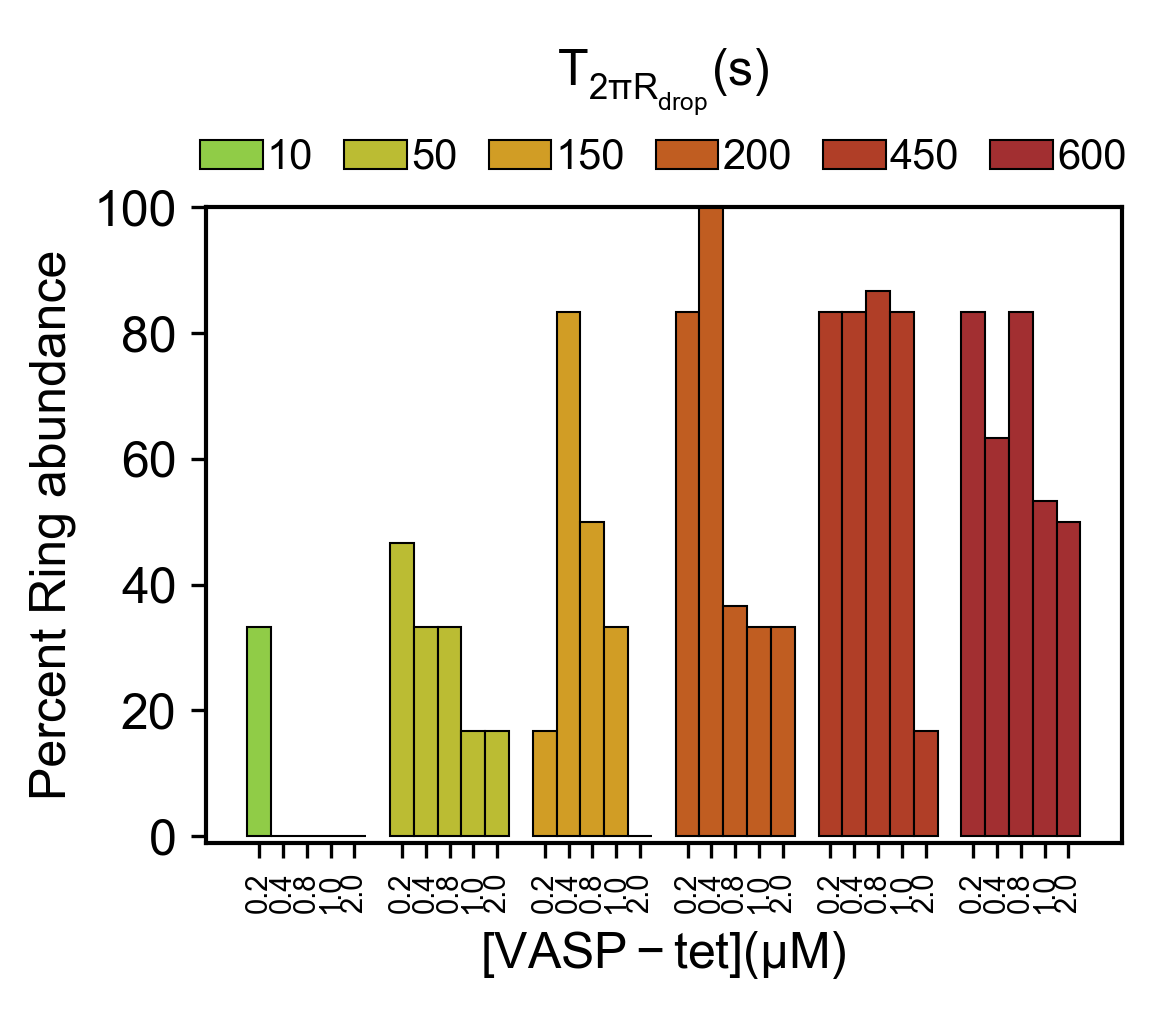

In [224]:
jointKmeans = False
plt.rcParams.update({'font.size': 12, 'font.family':'arial', 'font.weight'
                            :'normal'})
Nreps = 6
Nsnaps = 5
kmdf = pd.read_csv('Steric_Joint_T2piR_kmdf_V2_30nm.csv',index_col=0)
for tag in [ 'T2piR']:
    if tag == 'kinetics':
        Nframes = 25
    else:
        Nframes = Nreps*Nsnaps
    for clusterid in range(0,1):
        X=kmdf.loc[kmdf["Predicted Cluster"] == clusterid]
        Y=(X.loc[:,["tag"]]).to_numpy()
        #print(Y.filter(like='kinetics'))
        Z = [];
        for yiter, y in enumerate(Y):
            a=y[0]
            b=a.split(",")
            if tag in b[0][:]:
                Z.append([float(b[1][1:]), float(b[2][:])])
        if Z:
            Z = np.asarray(Z)
            unique_rows, counts = np.unique(Z, axis=0, return_counts=True)
            if jointKmeans:
                result = pd.DataFrame({'Conc/kbind': unique_rows[:,0],
                                'T2piR/kunbind':unique_rows[:,1],
                                'Probability':counts/Nframes})
            else:
                result = pd.DataFrame({'Conc': unique_rows[:,0],
                                    'T2piR':unique_rows[:,1],
                                    'Probability':1-counts/Nframes})
result2 =pd.DataFrame({'Conc':[0.4,],
                       'T2piR':[200,],
                        'Probability':[1,]})
result = pd.concat([result, result2])
result = result.sort_values(by=['Conc','T2piR'])
#print(result)
prob = np.flipud(result['Probability'].to_numpy().reshape((5,6)))
print(prob)
# VERSION 1
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(3.6,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
sns.heatmap(prob, annot=True, cmap='RdYlGn', vmin=0.0, vmax=1.0, ax=axvec,
    yticklabels=[2.0,1.0,0.8,0.4,0.2],
    xticklabels=[10,50,150,200,450,600],
    cbar_kws={'label': 'Probability of ring formation'})
axvec.set_xlabel(r"$T_{2\pi R_{drop}} (s)$")
axvec.set_ylabel(r"$[VASP-tet] (\mu M)$")
plt.tight_layout()
plt.savefig('T2piR_Ringprob_30nm_steric.png', dpi=300, bbox_inches='tight')
fig.savefig( 'T2piR_Ringprob_30nm_steric.pdf', bbox_inches='tight')
# VERSION 2
rgba = new_cmap(np.linspace(0, int(256/5), 256))
plt.rcParams.update({'font.size': 12, 'font.family':'arial', 'font.weight':'normal'})
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4,3.0),
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
barpos = np.array([0,1,2,3,4,5])
xticksvec = []
offset =0
for i in range(0,len(prob)):    
    xticksvec = xticksvec + list(offset+barpos)
    axvec.bar(offset+barpos,prob[len(prob)-i-1,:], width=1.0,linewidth = 0.5, edgecolor ='black',color=rgba[i,:])
    offset = offset + 7
axvec.set_xlim([-0.5,33.5])
axvec.set_ylim([-0.01,1.0])
axvec.set_xticks(xticksvec)
axvec.set_ylabel('Percent Ring abundance')
axvec.set_xlabel(r"$T_{2\pi R_{drop}} (s)$")
axvec.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec.set_yticklabels([0,20,40,60,80,100])
axvec.set_xticklabels([10,50,150,200,450,600,
                  10,50,150,200,450,600,
                  10,50,150,200,450,600,
                  10,50,150,200,450,600,
                  10,50,150,200,450,600,],rotation=90,fontsize=7)
fig.legend([0.2,0.4,0.8,1.0,2.0],title=r"$[VASP-tet] (\mu M)]$",
           frameon=False, ncol=5,fontsize=10, bbox_to_anchor=(0.9,1.1),handlelength=1.5,columnspacing=0.75, handletextpad = 0.1,)
plt.tight_layout()
plt.savefig('T2piR_Ringprob_30nm_steric_V2.png', dpi=300, bbox_inches='tight')
fig.savefig( 'T2piR_Ringprob_30nm_steric_V2.pdf', bbox_inches='tight')
# VERSION 3
rgba = new_cmap(np.linspace(0, int(256/5), 256))
plt.rcParams.update({'font.size': 12, 'font.family':'arial', 'font.weight':'normal'})
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4,3.0),
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
barpos = np.array([0,1,2,3,4])
xticksvec = []
offset =0
print(barpos)
for i in range(0,len(prob)+1):    
    xticksvec = xticksvec + list(offset+barpos)
    print(prob[len(prob)-i-1,:])
    axvec.bar(offset+barpos,np.flipud(prob[:,i]), width=1.0,linewidth = 0.5, edgecolor ='black',color=rgba[i,:])
    offset = offset + 6
#axvec.set_xlim([-0.5,33.5])
axvec.set_ylim([-0.01,1.0])
axvec.set_xticks(xticksvec)
axvec.set_ylabel('Percent Ring abundance')
axvec.set_xlabel(r"$[VASP-tet] (\mu M)$")
axvec.set_ylim([-0.01,1.0])
axvec.set_xticklabels([0.2,0.4,0.8,1.0,2.0,
                       0.2,0.4,0.8,1.0,2.0,
                       0.2,0.4,0.8,1.0,2.0,
                       0.2,0.4,0.8,1.0,2.0,
                       0.2,0.4,0.8,1.0,2.0,
                       0.2,0.4,0.8,1.0,2.0,
                       ],rotation = 90,fontsize=7)
axvec.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec.set_yticklabels([0,20,40,60,80,100])
fig.legend([10,50,150,200,450,600],title=r"$T_{2\pi R_{drop}} (s)$",
           frameon=False, ncol=6,fontsize=10, bbox_to_anchor=(0.99,1.14),handlelength=1.5,columnspacing=0.75, handletextpad = 0.1,)
plt.tight_layout()
plt.savefig('T2piR_Ringprob_30nm_steric_V3.png', dpi=300, bbox_inches='tight')
fig.savefig( 'T2piR_Ringprob_30nm_steric_V3.pdf', bbox_inches='tight')

## FIGURE S6 Overlay data 

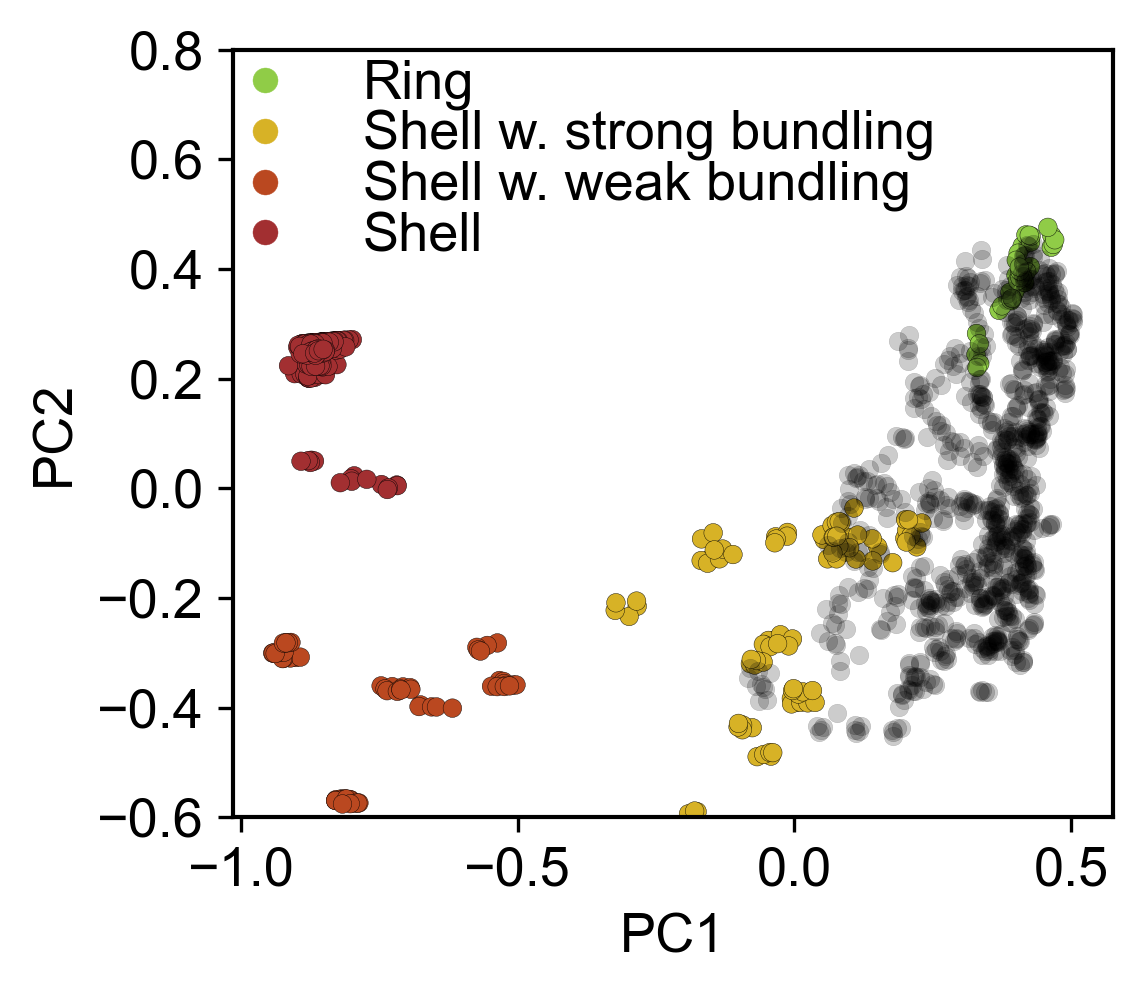

In [187]:
# Plot overall PC1 and PC2
# Color by cluster determined based on kinetic dataset
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
from sklearn.metrics import pairwise_distances_argmin_min , pairwise_distances
plt.rcParams.update({'font.size': 13, 'font.family':'arial', 'font.weight':'normal'})
# Generate dataframe
kmdf = pd.read_csv('Steric_Joint_ALL_T2piR_kmdf_V2_30nm.csv',index_col=0)
df1 = pd.DataFrame({'PC1':[], 'PC2':[], 'Predicted Cluster':[], 'images':[], 'tag':[]})
dfT2piR = pd.DataFrame({'PC1':[], 'PC2':[], 'Predicted Cluster':[], 'images':[], 'tag':[]})
kmdf['PC1'] = -1*kmdf['PC1']
kmdf['PC2'] = -1*kmdf['PC2']
# Get data tag
Y=(kmdf.loc[:,["tag"]]).to_numpy()
for index, tagvalue in enumerate(Y):
    a=tagvalue[0]
    b=a.split(",")
    tempdf= kmdf.iloc[index:index+1,:]   
    if 'T2piR' in b[0][:]:
        dfT2piR  = pd.concat([dfT2piR, tempdf], ignore_index = True)
    else:
        df1  = pd.concat([df1, tempdf], ignore_index = True)
kmdf_kinetics = pd.read_csv('Fgrow10_3_steric_GABmutant_kmdf.csv',index_col=0)
#Shell
kmdf_kinetics.loc[kmdf_kinetics["Predicted Cluster"] ==0, "Predicted Cluster"] = 4
# # Ring
# kmdf_kinetics.loc[kmdf_kinetics["Predicted Cluster"] ==2, "Predicted Cluster"] = 1
# Ring-like
kmdf_kinetics.loc[kmdf_kinetics["Predicted Cluster"] ==3, "Predicted Cluster"] = 0
# Shell
kmdf_kinetics.loc[kmdf_kinetics["Predicted Cluster"] ==4, "Predicted Cluster"] = 3

df1['Predicted Cluster'] = kmdf_kinetics['Predicted Cluster']
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4.0,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
scatter = axvec.scatter(data=df1, x="PC1", y="PC2",c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.1, s=20.0)

X=list(scatter.legend_elements(num=3))
X[1] = ['Ring','Shell w. strong bundling','Shell w. weak bundling','Shell']
legend1 = axvec.legend(X[0],X[1],frameon=False,bbox_to_anchor=(-0.08,1.05),
                loc="upper left",  labelspacing=0.0)
scatter = axvec.scatter(data=dfT2piR, x="PC1", y="PC2",c="black", cmap=new_cmap, alpha=0.2,
            edgecolors='black', linewidths=0.1, s=20.0)
axvec.set_xlabel('PC1')
axvec.set_ylabel('PC2')
axvec.set_ylim([-0.6,0.8])
# ########### SAVE
fig.tight_layout()
plt.savefig('Kmeans_steric_ALL.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Kmeans_steric_ALL.pdf', bbox_inches='tight')

## FIGURE 5C

[[<matplotlib.lines.Line2D object at 0x36b074e20>, <matplotlib.lines.Line2D object at 0x36b074eb0>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$']]
-----
[[ 0.27515957 -0.01631193  0.00102614]
 [-0.37653415  0.02232159 -0.0014042 ]]
searching
found
['T2piR', 1.0, 10, 0, 597]
----
searching
found
['T2piR', 0.4, 200, 0, 598]
----
Closest point
[array([ 0.27900437, -0.01696626,  0.02062741]), array([-0.41425371,  0.02063145, -0.00391587])]
Farthest point
[array([0.91825571, 0.39873834, 0.73722877]), array([-0.06979444,  0.28486214, -0.179079  ])]


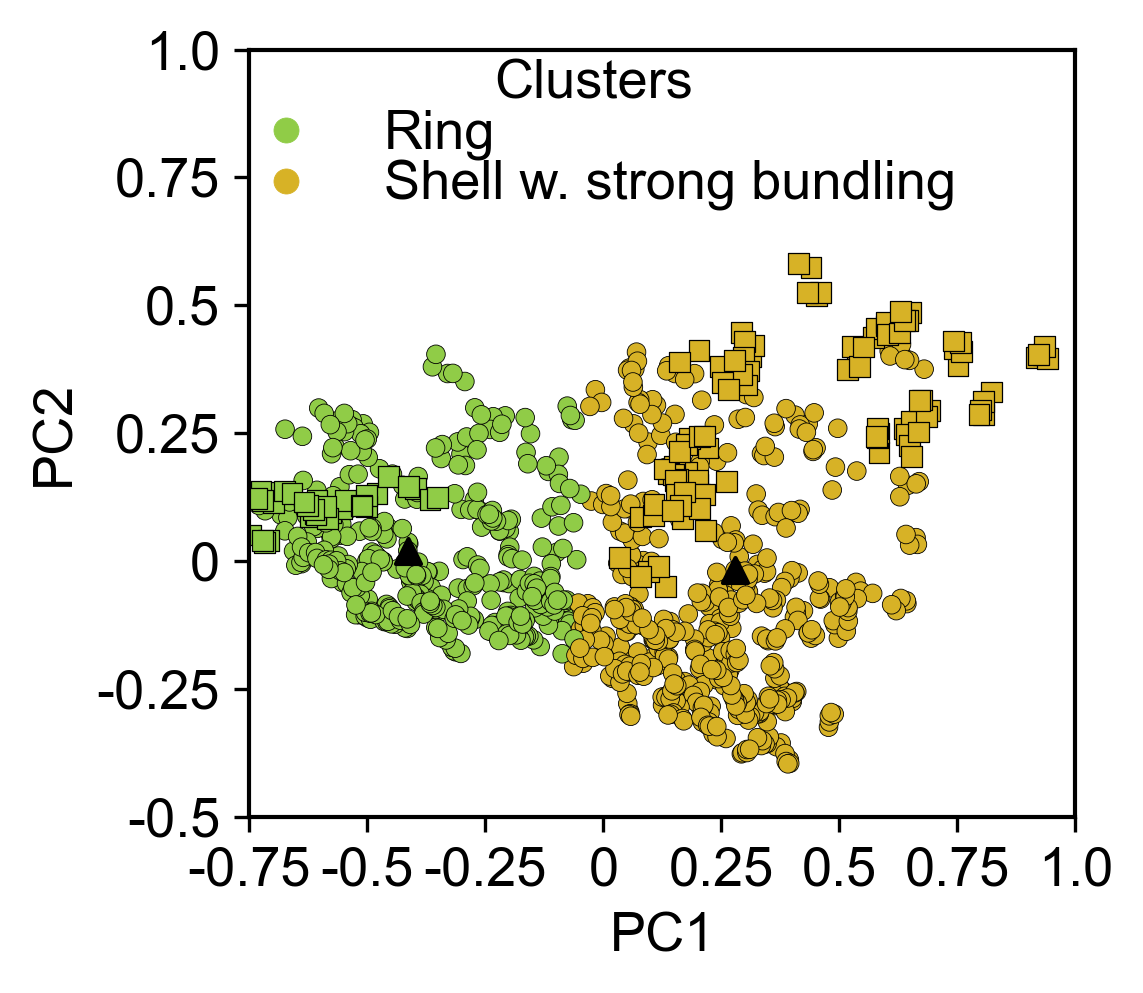

In [441]:
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226'])
# Generate dataframe
from sklearn.metrics import pairwise_distances_argmin_min , pairwise_distances
plt.rcParams.update({'font.size': 13, 'font.family':'arial', 'font.weight':'normal'})
kmdf = pd.read_csv('Steric_Joint_T2piR_kmdf_V2_30nm.csv',index_col=0)
########
kmdf["PClusb"] = kmdf["Predicted Cluster"]

kmdf.loc[kmdf["Predicted Cluster"] ==0, "Predicted Cluster"] = 2
kmdf.loc[kmdf["Predicted Cluster"] ==1, "Predicted Cluster"] = 0
kmdf.loc[kmdf["Predicted Cluster"] ==2, "Predicted Cluster"] = 1
########
shapevec = [];
tag = kmdf['tag'].to_numpy()
for titer, tval in enumerate(tag):
    if 'T2piR' in tval:
        shapevec.append(0)
    else:
        shapevec.append(1)
kmdf['Shape'] = shapevec
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4.0,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
scatter = axvec.scatter(data=kmdf, x="PC1", y="PC2", c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.2, s=20.0, label='Shape')
subdf = kmdf.loc[kmdf['Shape']==1]
scatter2 = axvec.scatter(data=subdf, x="PC1", y="PC2", c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.3, s=25.0, marker='s')

if jointKmeans:
    X=list(scatter.legend_elements(num=1))
    print(X)
    print('-----')
    X[1]=['Ring',"Ring-like"]
    X[1] = ['Ring','Shell w. strong bundling']
    
    legend1 = axvec.legend(X[0],X[1],frameon=False,bbox_to_anchor=(-0.08,1.05),
                    loc="upper left", title="Clusters", labelspacing=0.0)
    axvec.set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75,1.0])
    axvec.set_xticklabels([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75,1.0], rotation=0)
    axvec.set_xlim([-0.75,1])
    axvec.set_ylim([-0.5,1.0])
    axvec.set_yticks([ -0.5, -0.25, 0, 0.25, 0.5, 0.75,1.0])
    axvec.set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5, 0.75,1.0])
else:
    X=list(scatter.legend_elements(num=1))
    print(X)
    print('-----')
    X[1]=['#1 (Ring)',r"#2 (Shell-ring " "\n" "intermediates)"]
    legend1 = axvec.legend(X[0],X[1],frameon=False,bbox_to_anchor=(0,1.0),
                        loc="upper left", title="Clusters", labelspacing=0.1)

print(centers)
closest_point = []
farthest_point = []
# 0 - Shell-like
# 1 - Ring
# 2 - Shell
# 3 - Shell-like
for i, ccoord in enumerate(centers):
    subdata = kmdf.loc[kmdf['PClusb'] == i]
    tag = subdata['tag'].to_numpy()
    subdata = subdata[['PC1','PC2','PC3']].to_numpy()
    distances= pairwise_distances([ccoord],subdata,)
    minarglist = np.argsort(distances)[0]
    found = False
    miniter = -1
    index_min = 0
    print('searching')
    while not(found) and miniter<len(tag)-1:
        miniter = miniter + 1
        loc = minarglist[miniter]
        if 'T2piR' in tag[loc]:
            index_min = loc
            found = True;
            print('found')
            break;

    #index_min = np.argmin(distances)
    if(found):
        print(tag[index_min])
        closest_point.append(subdata[index_min,:])
    else:
        print('not found')
    index_max = np.argmax(distances)
    farthest_point.append(subdata[index_max,:])
    #print(tag[index_min])
    # b=tag[index_min].split(",")
    # b=tag[index_max].split(",")
    #print(utilityN1e3(float(b[0][1:]), float(b[1][:])))
    print('----')
# Plot centers
print('Closest point')
print(closest_point)
print('Farthest point')
print(farthest_point)
#axvec.scatter(centers[:,0],centers[:,1],c='black',marker='X')
closest_point=np.array(closest_point)
farthest_point=np.array(farthest_point)
axvec.scatter(closest_point[:,0],closest_point[:,1],c='black',marker='^')
#axvec.scatter(centers[:,0],centers[:,1],c='black',marker='v')
#axvec.scatter(farthest_point[:,0],farthest_point[:,1],c='black',marker='v')
# Plot closest point
axvec.set_xlabel('PC1')
axvec.set_ylabel('PC2')
########### SAVE
fig.tight_layout()
# if jointKmeans:
#     plt.savefig('Joint_T2piRKmeans.png', dpi=300, bbox_inches='tight')
#     fig.savefig( 'Joint_T2piRKmeans.pdf', bbox_inches='tight')
# else:
plt.savefig('T2piRKmeans.png', dpi=300, bbox_inches='tight')
fig.savefig( 'T2piRKmeans.pdf', bbox_inches='tight')

# FUNCTION TO COMPUTE FILAMENT LENGTH

165.75629096371014


(0.0, 1.0)

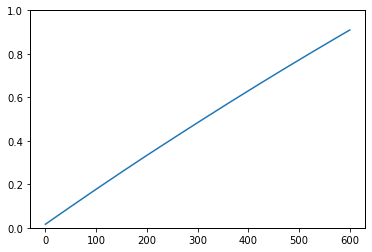

In [5]:
def getfillength(fc):
    Nbeads = (np.shape(fc))[0]
    L = 0
    for i in range(0,Nbeads-1):
        L = L + np.linalg.norm(fc[i]-fc[i+1])
    return L
#Bdist changes along row. Trate
#  along column
#r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/CytoSim/test_grow_tread/')
t = r[0].timevector
runidx = 0
Nsnaps = len(r[runidx].snap)
Llist = [];
for SREF in range(0,Nsnaps,1):
    filcoord = r[runidx].snap[SREF].filcoord
    Lsum = 0;
    for f, fc in enumerate(filcoord):
        Lsum = Lsum + getfillength(fc)
    Llist.append(Lsum)
plt.plot(np.array(Llist)/(2*np.pi*f))   
#plt.plot(t,x*T/(Nfil*2*np.pi))
print(Llist[len(Llist)-1])
plt.ylim([0,1])

# Use ODE model similar to CytoSim to get the parameters
This code was used to determine the parameters shown in Table S4

(30, 942.4777960769379, [0.0103, 0], [0, 0])
[170.89451798762576, 188.49555921538757]
0.2529291627376613
0.0


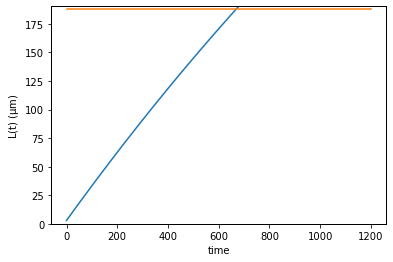

Treadmilling rate = 0.0074$\mu m/fil.s$


In [161]:
from scipy.integrate import odeint

# function that returns dy/dt
def model(L,t, Nfil, TFactin, growkinetics, shrinkkinetics):
    #Nfil = tparams[0]
    #TFactin = tparams[1]
    #growkinetics = tparams[2]
    kgrowplus = growkinetics[0]
    kgrowminus = growkinetics[1]
    #shrinkkinetics = tparams[3]
    kshrinkplus = shrinkkinetics[0]
    kshrinkminus = shrinkkinetics[1]
    dPdt = Nfil*(kgrowplus*(1-L[0]/TFactin) + kshrinkplus)
    dMdt = Nfil*(kgrowminus*(1-L[0]/TFactin) + kshrinkminus)
    dLdt = dPdt + dMdt
    return np.array([dLdt,dPdt,dMdt])

#parameters when Lfil = 2 pi R
Nfil = 30
f = 15
Lmax = 2*np.pi*Nfil
TFactin  = 3.3*Lmax

# parameters
Nfil = 200
Lmax = 0.75*Nfil
TFactin = 3.85*Lmax
f = 57.65
kgrowplus = convert_1_order_meso(11.6,4/3*np.pi)*0.0027*f*TFactin
kgrowminus = convert_1_order_meso(1.3,4/3*np.pi)*0.0027*f*TFactin
kshrinkplus = -1.4*0.0027*f
kshrinkminus = -0.8*0.0027*f
############### PARAMETERS TO GET 2*pi*R with TOTAL POLYMER
Nfil = 30
Lmax = 2*np.pi*Nfil
TFactin = 10*np.pi*Nfil
kgrowplus = 0.0103#microns/s
kshrinkplus = 0
kshrinkminus = 0
kgrowminus = 0
################
print((Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus]))
# initial condition
L0 = 0.1*Nfil

# TFactin  = 2.1*Lmax
# kgrowplus  = 0.008316
# kgrowminus = 0.0756
# kshrinkplus = -0.000918
# kshrinkminus = -0.0432

# time points
t = np.linspace(0,1200,1200)

# solve ODE
y = odeint(model,np.array([L0,0,0]),t, args = (Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus]))

# plot results
plt.plot(t,y[:,0])
#plt.plot(np.diff(y[:,2]))
print([y[600,0],Lmax])
dt = np.diff(t)
dPdt = np.diff(y[:,1])/dt
dMdt = np.diff(y[:,2])/dt
print(dPdt[600])
print(dMdt[600])
plt.xlabel('time')
plt.ylabel(r"L(t) $(\mu m)$")
plt.ylim([0,1.01*Lmax])
plt.plot([0,1200],[Lmax,Lmax])
plt.xticks([0,200,400,600,800,1000,1200])
plt.show()
print('Treadmilling rate = ' +str(round(dPdt[1000]/Nfil,4))+ r'$\mu m/fil.s$')

# Functions to calculate radial distribution function
Used to plot Figure S10 F. Again, calculations were made using the accompanying python script

In [ ]:
def getbinnedpwd(coord, bin_range, Nbins):
    Nbeads = len(coord)
    counter = 0
    pwd = np.zeros(Nbeads*(Nbeads -1)/2)
    for i in range(0,Nbeads):
        coordref = coord[i][:]
        for j in range(i+1,Nbeads):
            coordnext = coord[j][:]
            pwd[counter] = np.norm(coordnext-coordref)
            counter = counter + 1
    # Bin the distances
    bin_vector =  np.histogram(pwd, Nbins, bin_range)
    return bin_vector
#  RDF
def executeRDF():
    Rdrop = 1
    Nedges = 101
    Nbins = Nedges - 1;
    dR = 2*Rdrop/Nedges
    nreps = 3
    nr = 1
    nc = 6
    dirlist = ['N2k','N5k','N10k','N25k','N50k','N100k']
    minsnap = 1000
    RDF_result = np.zeros((len(dirlist),Nbins))
    for cid in range(0,nc):
        # set up bin edge vector
        bin_edges = np.linspace(0,2*R,Nedges)
        bin_center = bin_edges[0:Nbins:1]+dR/2
        # set up bin vector
        bin_vector_S = np.zeros(Nbins)
        for repid in range(0,nreps):
            dirname = dirlist[cid]+'/'+'r_'+str(repid)
            print(dirname,flush=True)
            r = readcytosimtraj('/scratch/achandrasekaran/cytosimfiles/test_diffusion/'+dirname+'/')
            NSNAPS = len(r[0].snap)
            NSOLIDS = len(r[0].snap[0].solidcoord)
            snapcounter = 0
            # Get coordinates
            for SREF in range(minsnap,NSNAPS):
                coord = r[0].s[SREF].solidcoord
                bin_range = np.array([0,2*Rdrop])
                bin_vector_S = bin_vector_S + getbinnedpwd(coord, bin_range, Nbins)
                snapcounter = snapcounter + 1
        Normalization_factor = np.power(bin_center,-2)*(R_drop**3/(3*snapcounter*NSOLIDS*NSOLIDS*0.5*dR))
        RDF_result[cid][:] = bin_vector_S*Normalization_factor
    pd.DataFrame(RDF_result).to_csv('RDF.csv', index = dirlist)

# Figure 6D GAB mutant plot experimental data 

                    0          1          2
tag                WT         WT         WT
cndn             1:20       1:10      1:7.5
value            0.05        0.1   0.133333
Shell-mean  58.179854  20.155236   5.928829
Ring-mean   31.245441  57.125556  24.379252
Disc-mean   10.574705    22.7192  69.691919
Shell-std     9.24945   9.397011   6.809061
Ring-std     2.746477   3.666109  16.061358
Disc-std     6.542847  12.855123    21.6496
Shell-sem    5.340172   5.425367   3.931213
Ring-sem     1.585679   2.116629   9.273029
Disc-sem     3.777515   7.421909  12.499402


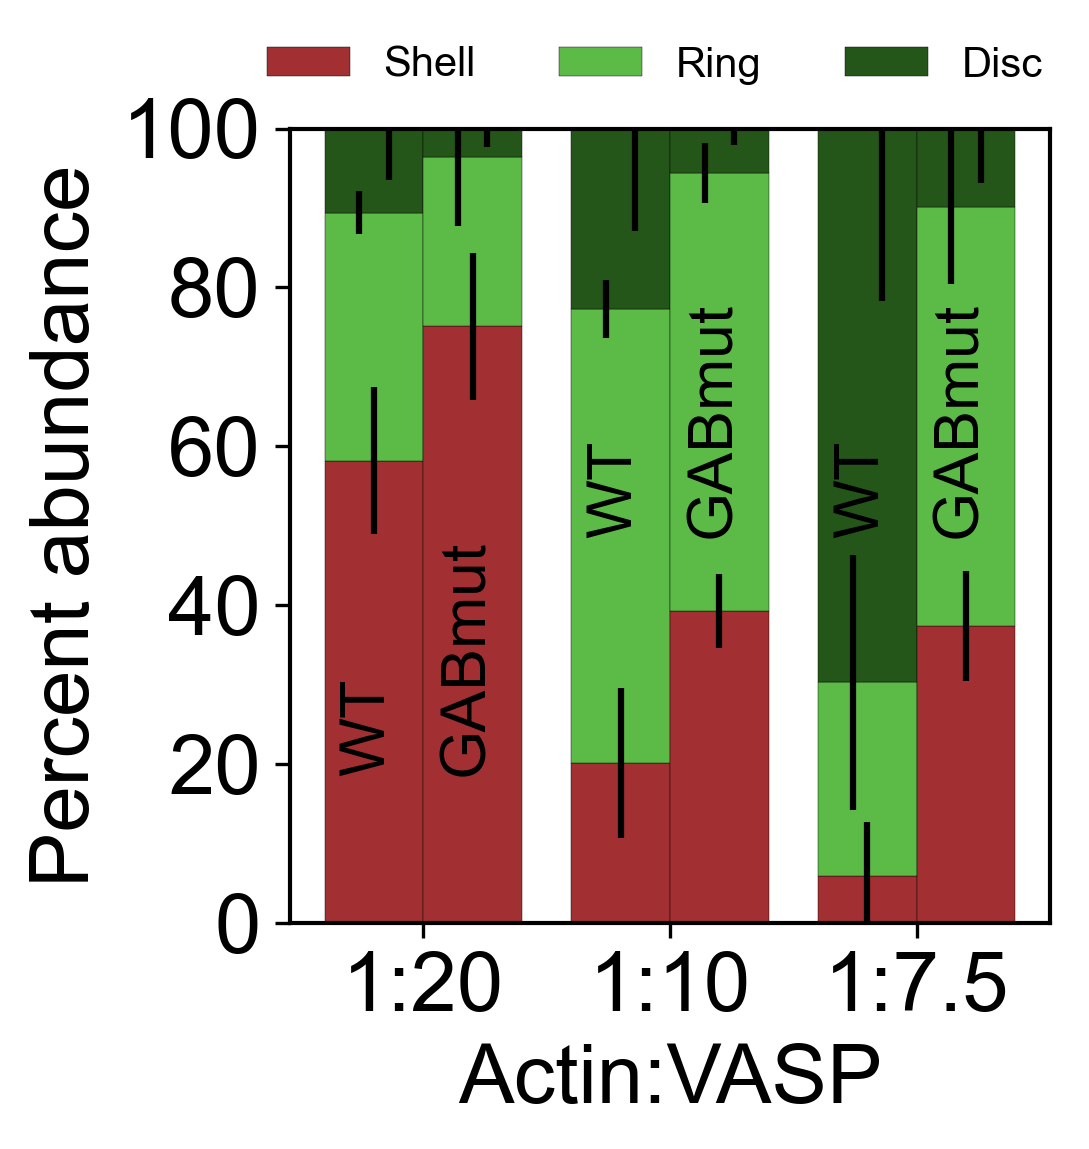

In [121]:
# We are going to alternate WT and GAB mutant data
rgba=["#a22f31",'#5CBA47','#255619']
WTdf = pd.DataFrame({'tag':['WT','WT','WT'],
                     'cndn':['1:20','1:10','1:7.5'],
                     'value':[1/20,1/10,1/7.5],
                     'Shell-mean':[58.1798541,20.1552361,5.9288288],
                     'Ring-mean':[31.2454405,57.12555637,24.3792519],
                     'Disc-mean':[10.5747054,22.7192002,69.6919193],
                     'Shell-std':[9.24945001,9.397011,6.80906066],
                     'Ring-std':[2.74647744,3.666109431,16.06135812],
                     'Disc-std':[6.54284719,12.8551232,21.64959971],
                     'Shell-sem':[5.340172455,5.42536683,3.931213004],
                     'Ring-sem':[1.585679489,2.116629267,9.273029432],
                     'Disc-sem':[3.777514587,7.421908841,12.49940222]})
GABdf = pd.DataFrame({'tag':['GAB','GAB','GAB'],
                      'cndn':['1:20','1:10','1:7.5'],
                      'value':[1/20,1/10,1/7.5],
                      'Shell-mean':[75.09920635,39.22845225,37.39258933],
                      'Ring-mean':[21.32936508,55.17343846,52.71378601],
                      'Disc-mean':[3.571428571,5.598109288,9.893624662],
                      'Shell-std':[9.251756692,4.655084404,6.868114621],
                      'Ring-std':[8.739735908,3.746811168,9.627227747],
                      'Disc-std':[2.32447907,2.020807791,6.896104851],
                      'Shell-sem':[5.341504217,2.687614234,3.965307825],
                      'Ring-sem':[5.045888879,2.163222436,5.558282531],
                      'Disc-sem':[1.342038617,1.166713922,3.981467992]})
plt.rcParams.update({'font.size': 20, 'font.family':'arial', 'font.weight'
                    :'normal'})
joineddf = pd.concat([WTdf,GABdf])
joineddf = joineddf.sort_values(by=['value'])
# MEAN BAR GRAPH
fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4,4), dpi=300, facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(left=0.1, right=0.99, bottom=0.05, top=0.8, wspace=0.0, hspace=0.2)
dfT = WTdf.T
print(dfT)
pos=[0,2.5,5]
for i in dfT.columns:
    x = [dfT[i]['Shell-mean'],dfT[i]['Ring-mean'],dfT[i]['Disc-mean']]
    axvec.bar(pos[i],x[0],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[0])
    axvec.bar(pos[i],x[1],bottom=x[0],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[1])
    axvec.bar(pos[i],x[2],bottom=x[0]+x[1],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[2])

dfT = GABdf.T
pos=[1,3.5,6]
for i in dfT.columns:
    x = [dfT[i]['Shell-mean'],dfT[i]['Ring-mean'],dfT[i]['Disc-mean']]
    axvec.bar(pos[i],x[0],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[0], )
    axvec.bar(pos[i],x[1],bottom=x[0],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[1], )
    axvec.bar(pos[i],x[2],bottom=x[0]+x[1],width = 1.0, edgecolor='black',linewidth=0.1,color=rgba[2], )
axvec.set_xticks([0.5,3,5.5])
axvec.set_xticklabels(['1:20','1:10','1:7.5'])
plt.xticks(rotation = 0)
axvec.set_yticks([0,20,40,60,80,100])
axvec.set_xlabel('Actin:VASP')
axvec.set_ylabel('Percent abundance')
leg = fig.legend(['Shell','Ring','Disc'],ncol=5,fontsize=10,frameon=False,
                bbox_to_anchor=(0.95, 1.0), labelspacing=0.1)
# ERRORBAR
Xvec = np.array([0,1,2.5,3.5,5,6])
axvec.errorbar(Xvec,joineddf['Shell-mean'],yerr=joineddf['Shell-std'], fmt = 'o', markersize = 0, ecolor='black')
axvec.errorbar(Xvec-0.15,joineddf['Shell-mean']+joineddf['Ring-mean'],yerr=joineddf['Ring-std'], fmt = 'o', markersize = 0, ecolor='black')
axvec.errorbar(Xvec+0.15,joineddf['Shell-mean']+joineddf['Ring-mean']+joineddf['Disc-mean'],yerr=joineddf['Disc-std'], fmt = 'o', markersize = 0, ecolor='black')
axvec.set_ylim([0,100])
plt.tight_layout()
# LABEL
#adding text inside the plot
axvec.text(-0.35, 20, 'WT', fontsize = 15, rotation=90)
axvec.text(0.65, 20, 'GABmut', fontsize = 15, rotation=90)
#
axvec.text(2.5-0.35, 50, 'WT', fontsize = 15, rotation=90)
axvec.text(2.5+0.65, 50, 'GABmut', fontsize = 15, rotation=90)
#
axvec.text(5-0.35, 50, 'WT', fontsize = 15, rotation=90)
axvec.text(5+0.65, 50, 'GABmut', fontsize = 15, rotation=90)

fig.savefig( 'GAB_Expt_data.png', dpi=300, bbox_inches='tight')
fig.savefig( 'GAB_Expt_data.pdf', bbox_inches='tight')

# Python job files for analysis
This script can be used to generate job files that can be used to analyse the cytosim trajectories.

In [192]:
#Write one job file for crosslinker and one for fraction occupied given Rval repid 
def writepythonjobfile(filewritepath, jobfolderpathtscc, foldername, jobfilename, Rval, repidx,tag):
    fjobptr = open(filewritepath+'/'+jobfilename+'.sh','w')
    outputpipefile = 'R_'+str(Rval)+'_r_'+str(repidx)+'.out'
    if tag == 'cross':
        fjobptr.write('python analyzecrosslinker_scriptcall_eachrun.py 1 '+str(Rval)+' '+str(repidx)+
                    ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/'+foldername+'/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+ '\n')
    elif tag == 'fillength':
        fjobptr.write('python analyzefillength_scriptcall.py 1 '+str(Rval)+' '+str(repidx)+
                    ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/'+foldername+'/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+ '\n')
    elif tag =='eigen':
        fjobptr.write('python analyze_eig_scriptcall_eachrun.py 1 '+str(Rval)+' '+str(repidx)+
                    ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/'+foldername+'/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+ '\n')
    elif tag =='fracocc':
        fjobptr.write('python Fgrow_10_3_N_1e3_5reps.py 1 '+str(Rval)+' '+str(repidx)+
            ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+'\n')
    elif tag =='density_actin':
        fjobptr.write('python analyzedensity_scriptcall_eachrun.py 1 '+str(Rval)+' '+str(repidx)+
            ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+'\n')
    elif tag =='density_VASP':
        fjobptr.write('python analyzedensityVASP_scriptcall_eachrun.py 1 '+str(Rval)+' '+str(repidx)+
            ' '+foldername+' '+jobfolderpathtscc+' >>./tscc_scripts/o_'+tag+'_R_'+str(Rval)+'_r_'+str(repidx)+'.out'+'\n')
    fjobptr.close()
    #print('file written')
filewritepath = './python_scripts/'
jobfolderpathtscc = 'SPECIFY-INSTALL-FOLDER-FOR-CYTOSIM'
foldername = 'SPECIFY-FOLDER-NAME' #FOR EXAMPLE, FIGURE_4/INPUTFILES
filewritepath = filewritepath + foldername
Nreps=10;
if not os.path.exists(filewritepath):   
    os.mkdir(filewritepath)
else:
    print('folder exists! Adding files to the folder')
fjobptrs = open(filewritepath+'/submitjobs.sh','w')
#cross- crosslinker parameters
#fillength - filament length parameters
#eigen - eigen values from the radius of gyration tensor
#fracocc - fraction of droplet surface covered in actin
for tag in ['cross','fillength','eigen','fracocc','density_actin']:
        for Rval in range(0,6):
            if tag in ['cross','eigen','fracocc','density_actin']:
                for repidx in range(0,Nreps):
                    jobfilename = tag+'_R_'+str(Rval)+'_r_'+str(repidx)
                    writepythonjobfile(filewritepath, jobfolderpathtscc, foldername, jobfilename, Rval, repidx, tag)
                    fjobptrs.write('qsub '+jobfilename+'.sh' + '\n')
            else:
                jobfilename = tag+'_R_'+str(Rval)+'_r_'+str(Nreps)
                writepythonjobfile(filewritepath, jobfolderpathtscc, foldername, jobfilename, Rval, Nreps, tag)
                fjobptrs.write('qsub '+jobfilename+'.sh' + '\n')
fjobptrs.close()

folder exists! Adding files to the folder


# Functions necessary for FIGURE S 14 B and C

In [84]:
def getellipsedistance(coord,ellipsespan):
    [px,py,pz] = coord
    [a,b,c] = ellipsespan
    denominator = 1/(a*a) + (py/(px*b))**2 + (pz/(px*c))**2
    epx = np.sqrt(1/denominator)
    epy = epx*(py/px)
    epz = epx*(pz/px)
    dis1 = np.linalg.norm([epx,epy,epz]-coord)
    dis2 = np.linalg.norm(-1*np.array([epx,epy,epz])-coord)
    #print([coord, ellipsespan, denominator, [epx,epy,epz], np.linalg.norm(np.array([epx,epy,epz]-coord))])
    return min([dis1,dis2])
def plotactinframe(filcoord):
    nr = 1; nc = 1
    fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(3.0,3.0), 
                            dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
    axvec=plt.subplot(1,1,1, projection='3d')
    for f, fc in enumerate(filcoord):
        axvec.plot3D(fc[:,0],fc[:,1],fc[:,2], 'o',linewidth=2, color='green')
    axvec.axis('off')

def plotactinfilament(fc,colors,axvec, zcutoff):
    retval = axvec.scatter(fc[:,0],fc[:,1],fc[:,2], 'o',s=1,c='red')
    locs = np.where(fc[:,2] > zcutoff)[0].tolist()
    if locs:
        retval = axvec.scatter(fc[locs,0],fc[locs,1],fc[locs,2], 'o',s=2,c=colors[locs,:])
        axvec.set_xlim([-np.pi,np.pi])
        axvec.set_ylim([-np.pi,np.pi])
        axvec.set_zlim([-np.pi,np.pi])
        #return retval

def get_Lcutoff(ellipsespan, volfrac):
    a= ellipsespan[0]
    b = ellipsespan[1]
    c = ellipsespan[2]
    Vellipsoid = (4/3)*np.pi*a*b*c
    x=np.linspace(0,c,100)
    y=1-(2*np.pi*a*b/Vellipsoid)*(x-x**3/(3*c*c))
    Y=np.fliplr([y])
    X=np.fliplr([x])
    answer=np.interp(volfrac,Y[0],X[0])
    return answer

def geteigensnap(filcoord):
    snapcoordmat=np.array([[]])
    for f, fc in enumerate(filcoord):
        Nbeads = (np.shape(fc))[0]
        filcoordmat = np.zeros((Nbeads,3))
        for i in range(0,Nbeads):
            filcoordmat[i,:] = np.array(fc[i,:])
        if f==0:
            snapcoordmat = filcoordmat.copy()
        else:
            axisval = 0
            snapcoordmat = np.concatenate((snapcoordmat,filcoordmat),axis=axisval)
    COM = np.mean(snapcoordmat,0)
    # Calculate PC1
    snapcoordmat = (snapcoordmat - COM)
    crosscorr  = np.matmul(np.transpose(snapcoordmat),snapcoordmat)/len(snapcoordmat)
    eval, evec =np.linalg.eig(crosscorr)
    eval = 2*np.sqrt(eval)
    return [eval,evec]

def getmonomerswithinsubvolume(filcoord, zcutoff, *args):
    printStatus = False
    if(len(args)):
        printStatus = args[0]
    totallen = 0
    if printStatus:
        print(zcutoff)
        print(len(filcoord))
    for f, fc in enumerate(filcoord):
        if printStatus:
            print(np.shape(fc))
            print(fc)
        Nbeads = (np.shape(fc))[0]
        for i in range(0,Nbeads-1):
            if i ==0:
                p1 = np.array(fc[i,:])
                p1x = p1[0]
                p1y = p1[1]
                p1z = p1[2]
            else:
                p1 = p2.copy()
                p1x = p2[0]
                p1y = p2[1]
                p1z = p2[2]
            p2 = np.array(fc[i+1,:])
            p2x = p2[0]
            p2y = p2[1]
            p2z = p2[2]
            if printStatus:
                print([p1z,p2z])
            # Scenario 1
            lenval = 0
            if (p1z >= zcutoff and p2z >= zcutoff) or (p1z<=-zcutoff and p2z<=-zcutoff):
                lenval = np.linalg.norm(p2-p1)
            elif p1z<zcutoff and p2z>zcutoff:
                alpha = (zcutoff-p1z)/(p2z-p1z)
                pzt = [alpha*(p2x-p1x)+p1x, alpha*(p2y-p1y)+p1y, zcutoff]
                lenval = np.linalg.norm(pzt-p2)
            elif p1z>zcutoff and p2z<zcutoff:
                alpha = (zcutoff-p1z)/(p2z-p1z)
                pzt = [alpha*(p2x-p1x)+p1x, alpha*(p2y-p1y)+p1y, zcutoff]
                lenval = np.linalg.norm(pzt-p1)
            elif p1z<-zcutoff and p2z>-zcutoff:
                alpha = (-zcutoff-p1z)/(p2z-p1z)
                pzt = [alpha*(p2x-p1x)+p1x, alpha*(p2y-p1y)+p1y, -zcutoff]
                lenval = np.linalg.norm(pzt-p1)
            elif p1z>-zcutoff and p2z<-zcutoff:
                alpha = (-zcutoff-p1z)/(p2z-p1z)
                pzt = [alpha*(p2x-p1x)+p1x, alpha*(p2y-p1y)+p1y, -zcutoff]
                lenval = np.linalg.norm(pzt-p2)
            totallen = totallen + lenval
    return totallen/2.7e-3



def plotdistanceprofile(rset, color):
    r=rset[0]
    timevector = r.timevector
    Nsnaps = len(r.snap)
    deltasnap = 2
    if deltasnap>1:
        Ndatapoints = int(Nsnaps/deltasnap)+1
    else:
        Ndatapoints = int(Nsnaps)
    startsnap=26
    snaplist = [140,200,400,425,450]
    snaplist = [47,100,150, 200, 250]
    snaplist = [390,392,394]
    snaplist = [26,200,450]
    printvec = []
    #range(366,368,deltasnap)
    ssnap = 26
    countvec = []
    countvec2 = []
    Nmonomersvec = []
    cndn=False
    datavec = []
    for SREF in range(ssnap,Nsnaps,deltasnap):
        if cndn == True:
            break;
        # now = datetime.now()
        # current_time = now.strftime("%H:%M:%S")
        # print("Snap ="+str(SREF)+" Current Time =", current_time, flush=True)
        Nfilsnap = []
        L = []
        bin_edges = np.linspace(0,2,100)
        bin_edges = [0,0.15,0.25]
        for runidx in range(0,len(rset)):
            nsnaplocal = len(rset[runidx].snap)
            # Check if current run has the SREF'th snap. If so, collect data, if not, move on.
            if(SREF<=nsnaplocal):
                # nr = 1; nc = 1
                # fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(3.0,3.0), 
                #                         dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
                # axvec=plt.subplot(nr,nc,1, projection='3d')
                filcoord = np.array(rset[runidx].snap[SREF].filcoord)
                [PCeigenval, PCeigenvec] = geteigensnap (filcoord)
                sortedloc=np.argsort(PCeigenval)

                # print(PCeigenval)
                # print(np.flip(np.sort(PCeigenval)))
                # print(PCeigenvec)
                # print(PCeigenvec[2,sortedloc[1:3]])
                # Third row is z coordinate. 1, 2 are second and third eigen vectors
                maxdotprodwithZ = np.max(np.abs(PCeigenvec[2,sortedloc[1:3]]))
                if(SREF==ssnap):
                    allangles = np.abs(PCeigenvec[2,sortedloc[0:3]])
                    print("initial angle in degrees ="+str((np.arccos(allangles))*180/np.pi))
                # print(maxdotprodwithZ)
                # print(math.degrees(np.arccos(maxdotprodwithZ)))
                #plotactinframe(filcoord)
                ellipsespan = rset[runidx].snap[SREF].shapevec
                volfrac = 0.125
                zcutoff = get_Lcutoff(ellipsespan, volfrac)
                norm = mpl.colors.Normalize(vmin=0, vmax=2)
                cmap = cm.RdYlGn_r
                countval = 0
                countval2 = 0
                m = cm.ScalarMappable(norm=norm, cmap=cmap)
                Nmonomers = 0
                Nmonomers = Nmonomers + getmonomerswithinsubvolume(filcoord, zcutoff,False)
                for f, fc in enumerate(filcoord):
                    locs = np.where(fc[:,2] > zcutoff)[0].tolist()
                    locs2 = np.where(fc[:,2] < -zcutoff)[0].tolist()
                    countval = countval+len(locs)
                    countval2 = countval2+len(locs2)
                    distval = []
                    Nbeads = (np.shape(fc))[0]
                    for i in range(0,Nbeads):
                        temp = getellipsedistance(fc[i],ellipsespan)
                        distval.append(temp)
                        L.append(temp)
                    #colors = m.to_rgba(distval)
                    #plotactinfilament(fc,colors,axvec, zcutoff)
                countvec.append(countval)
                countvec2.append(countval2)
                Nmonomersvec.append(Nmonomers)
                ANGLETHRESHOLD = 15
                Nav = scipy.constants.Avogadro
                VsphereinL = (4/3)*np.pi*1e-18*1e3
                Clocal = Nmonomers*1e6/(Nav*VsphereinL*volfrac)
                Cbulk = 27.67
                anglewithZ = round(np.arccos(maxdotprodwithZ)*180/np.pi,2)
                datavec.append([SREF, round(np.arccos(maxdotprodwithZ)*180/np.pi,2),round(Clocal,4), ellipsespan, ellipsespan[2]/ellipsespan[1],timevector[SREF]])
                # if(Clocal<Cbulk/2 and anglewithZ<=ANGLETHRESHOLD):
                #     print([SREF, round(np.arccos(maxdotprodwithZ)*180/np.pi,2),countval+countval2, round(Clocal,4), ellipsespan, ellipsespan[2]/ellipsespan[1]])
                #     cndn=True
                #     break;
                # if(countval+countval2<=100 and np.arccos(maxdotprodwithZ)<=ANGLETHRESHOLD):
                #     VsphereinL = (4/3)*np.pi*1e-18*1e3
                #     Nav =scipy.constants.Avogadro
                #     Cbulk = 27.67
                #     Clocal = Nmonomers*1e6/(Nav*VsphereinL*volfrac)
                #     print([SREF, round(np.arccos(maxdotprodwithZ)*180/np.pi,2),countval,countval2, round(Clocal,4), ellipsespan, ellipsespan[2]/ellipsespan[1]])
                #fig.colorbar(m, ax=axvec)
                pdfvec, bins = np.histogram(L,bins=bin_edges,density=False)
                pdfvec = pdfvec/np.sum(pdfvec)
                #pdfvec = np.cumsum(pdfvec)
                #axvec.plot(bin_edges[0:len(bin_edges)-1],pdfvec)

                printvec.append(pdfvec[0])
    # plt.plot(np.arange(ssnap,Nsnaps,deltasnap), countvec, c=color)
    # plt.plot(np.arange(ssnap,Nsnaps,deltasnap), np.array(Nmonomersvec)*1e6/(Nav*VsphereinL*volfrac), c=color)
    # plt.plot(np.arange(ssnap,Nsnaps,deltasnap), countvec2,'--', c=color)
    # plt.legend([0,1,2,3,4,5])
    return pd.DataFrame(datavec,columns=['snap','angle','Clocal','ellipsespan','aspect_ratio','time'])
from datetime import datetime
generateSIfigure = True
dfvec = [];
if generateSIfigure:
    r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_5_r_0/')
    rset.append(r[0])
    df = plotdistanceprofile(rset,colorvec[0])
    dfvec.append(df)
else:
    for rid in range(0,7):
        colorvec = ['red','black','green','pink','purple','orange']
        for repid in range(0,5):
            rset=[]
            print('R_'+str(rid)+'_r_'+str(repid))
            r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_'+str(rid)+'_r_'+str(repid)+'/')
            rset.append(r[0])
            df = plotdistanceprofile(rset,colorvec[0])
            dfvec.append(df)
    dfvec2 = [];
    for rid in range(0,3):
        colorvec = ['red','black','green','pink','purple','orange']
        for repid in range(0,5):
            rset=[]
            print('R_'+str(rid)+'_r_'+str(repid))
            r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test4_tscc/R_'+str(rid)+'_r_'+str(repid)+'/')
            rset.append(r[0])
            df = plotdistanceprofile(rset,colorvec[0])
            dfvec2.append(df)

Number of snapshots=452
initial angle in degrees =[79.30797329 71.41279025 21.64229846]
initial angle in degrees =[79.30797329 71.41279025 21.64229846]


/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_66979/854009659.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  denominator = 1/(a*a) + (py/(px*b))**2 + (pz/(px*c))**2
/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_66979/854009659.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  epy = epx*(py/px)
/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_66979/854009659.py:6: RuntimeWarning: invalid value encountered in double_scalars
  epy = epx*(py/px)
/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_66979/854009659.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  epz = epx*(pz/px)
/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_66979/854009659.py:7: RuntimeWarning: invalid value encountered in double_scalars
  epz = epx*(pz/px)


# Figure 7B

In [103]:
generateSIfigure = True
Cbulk = 27.67
nr = 1;nc =2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(6.0,3.0), 
                        dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
Lfilvec = [r"$2\pi/3$",r"$5\pi/6$",r"$\pi$",r"$7\pi/6$",r"$4\pi/3$",r"$5\pi/3$",r"$2\pi$"
           ,r"$11\pi/12$",r"$13\pi/12$",r"$15\pi/12$"]
Lfil = [2/3,5/6,1,7/6,4/3,5/3,2,11/12,13/12,15/12]
resultvec =[]
if generateSIfigure:
    dflist = [dfvec]
else:   
    dflist = [dfvec,dfvec2]
for dfveciter, dfvecx in enumerate(dflist):
    for i in range(0,len(dfvecx)):
        Rval = int(i/5)
        repidx = i%5
        if  repidx ==0:
            print('R_'+str(Rval))
        df = dfvecx[i]
        nr = 1; nc = 2
        axvec[0].plot(df['aspect_ratio'],df['angle'],c='black')
        axvec[1].plot(df['aspect_ratio'],df['Clocal'],c='black')
        axvec[1].plot([1,5.56],[Cbulk,Cbulk],linewidth=0.1,marker='.',markersize=0,c='black')
        axvec[1].plot([1,5.56],[Cbulk/2,Cbulk/2],linewidth=0.1,marker='.',markersize=0,c='black')
        axvec[1].plot([1,5.56],[Cbulk/3,Cbulk/3],linewidth=0.1,marker='.',markersize=0,c='black')
        # Get snap where Clocal is maximum
        Clocalmax = df['Clocal'].max()
        maxsnap = df[df['Clocal']==Clocalmax]['snap'].max()
        df = df[df['snap']>=maxsnap]
        # for t in [Cbulk, Cbulk/2, Cbulk/3, Cbulk/4, Cbulk/6, Cbulk/8, Cbulk/12]:
        for t in [Cbulk/3,]:
            filtereddf = df[(df['angle']<=30) & (df['Clocal']<=t)]
            #filtereddf = df[(df['Clocal']<=t)]
            filtereddf.sort_values(by=['snap'])
            temp = filtereddf['aspect_ratio'].tolist()
            temp2 = filtereddf['angle'].tolist()
            temp3 = filtereddf['snap'].tolist()
            if(temp):
                resultvec.append([t,temp[0],temp2[0],temp3[0],Lfilvec[dfveciter*7+Rval],
                                  Lfil[dfveciter*7+Rval],'set_'+str(dfveciter)+'_R_'+str(Rval),'r_'+str(repidx)])
        # axvec[0].set_xticks([0,100,200,300,400,450])
        axvec[0].set_xticks([1,2,3,4,5,5.56])

if generateSIfigure == False:
    resultdf = pd.DataFrame(resultvec, columns=['threshold_c','aspect_ratio',
                                                'angle','snap','Lfil','Lfilval','Rval','repidx'])

    resultdf = resultdf.sort_values(by=['Lfilval'])
    print(resultdf)
    Lfil.sort()
    boxplotdata =[]
    meanvec = []
    stdvec =[]
    nr = 1; nc = 1
    fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(5.0,3.0), 
                            dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
    temp = np.pi*np.array([2/3,5/6,11/12,1,13/12,7/6,15/12,4/3,5/3,2])
    for liter, l in enumerate(Lfil):
        validx = resultdf.index[resultdf['Lfilval']==l].tolist()
        val = resultdf[resultdf['Lfilval']==l]['aspect_ratio'].tolist()
        details = resultdf.iloc[validx]
        details = details[['Rval','repidx','snap']]
        Rval = resultdf.iloc[validx]['Rval'].tolist()
        repidx = resultdf.iloc[validx]['repidx'].tolist()
        axvec.plot(np.array([l,l,l,l,l])*np.pi
                ,val,'o',markersize=2,c='red')
        boxplotdata.append(val)
        meanval = np.mean(val)
        delta = abs(val-meanval)
        minloc = np.argwhere(delta==np.min(delta))
        print(details.iloc[minloc[0][0]])
        meanvec.append(meanval)
        stdvec.append(np.std(val))
    plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
    axvec.boxplot( boxplotdata, positions=temp, widths=0.15)
    axvec.set_xticklabels([r"$\frac{2}{3}$",r"$\frac{5}{6}$",r"$\frac{11}{12}$",
                    r"$1$",r"$\frac{13}{12}$", r"$\frac{7}{6}$",
                    r"$\frac{5}{4}$", r"$\frac{4}{3}$",r"$\frac{5}{3}$",r"$2$"],rotation = 0)
    axvec.set_ylabel('Aspect ratio')
    axvec.set_xlabel(r"$\times \pi, L_{fil}^{max}$")

    axvec.plot(temp,(temp/2)**(3/2), color='black')
    plt.tight_layout()
    plt.subplots_adjust(left=0.15,
                    right=0.95,
                    bottom=0.25, 
                    top=0.99,
                    wspace=0.0, 
                    hspace=0.0)
    ##########################`
    nr = 1; nc = 1
    fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(3.0,3.0), 
                            dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
    plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
    axvec.bar( temp, meanvec ,color='olivedrab',width=0.25,align='center')
    axvec.errorbar(temp,meanvec, yerr=stdvec, fmt = 'o', markersize = 0, ecolor='firebrick')
    axvec.set_xticks(temp)
    axvec.set_xticklabels([r"$\frac{2}{3}$",r"$\frac{5}{6}$",r"$\frac{11}{12}$",
                    r"$1$",r"$\frac{13}{12}$", r"$\frac{7}{6}$",
                    r"$\frac{5}{4}$", r"$\frac{4}{3}$",r"$\frac{5}{3}$",r"$2$"],rotation = 0)
    axvec.set_ylabel('Aspect ratio (a/b)')
    axvec.set_xlabel(r"$\times \pi R_{drop}, L_{fil}^{max}$")
    axvec.set_ylim([0,6])
    axvec.plot(temp,(temp/2)**(3/2), color='black')
    plt.tight_layout()
    plt.subplots_adjust(left=0.15,
                    right=0.95,
                    bottom=0.25, 
                    top=0.99,
                    wspace=0.0, 
                    hspace=0.0)
    plt.savefig('SER_bar_5reps.png', dpi=150, bbox_inches='tight')
    plt.savefig('SER_bar_5reps.pdf', bbox_inches='tight')
else:
    plt.savefig('SER_Angle_Clocal.png', dpi=150, bbox_inches='tight')
    plt.savefig('SER_Angle_Clocal.pdf', bbox_inches='tight')


R_0


## Figure 7 output snapids

In [78]:
df2 = dfvec[2]
target = 1
for index, row in df2.iterrows():
    if row['aspect_ratio'] >= target:
        print(row)
        target = target + 1
print(row)

snap                                    26
angle                                69.44
Clocal                                 0.0
ellipsespan     [0.990147, 0.990147, 1.02]
aspect_ratio                       1.03015
time                               604.502
Name: 0, dtype: object
snap                                   140
angle                                22.02
Clocal                               0.143
ellipsespan     [0.793051, 0.793051, 1.59]
aspect_ratio                      2.004915
time                               718.502
Name: 57, dtype: object
snap                                   240
angle                                 24.3
Clocal                                 0.0
ellipsespan     [0.691715, 0.691715, 2.09]
aspect_ratio                      3.021476
time                               818.502
Name: 107, dtype: object
snap                                   326
angle                                22.92
Clocal                                 0.0
ellipsespan     [0.629941

# Figure S14 A

[1.0, 1.0, 1.0]
[0.7937005259840998, 0.7937005259840998, 1.5874010519681996]
[0.6933612743506348, 0.6933612743506348, 2.080083823051904]
[0.6299605249474366, 0.6299605249474366, 2.5198420997897464]
[0.5848035476425733, 0.5848035476425733, 2.924017738212866]
[0.5644711318158051, 0.5644711318158051, 3.1384594928958762]


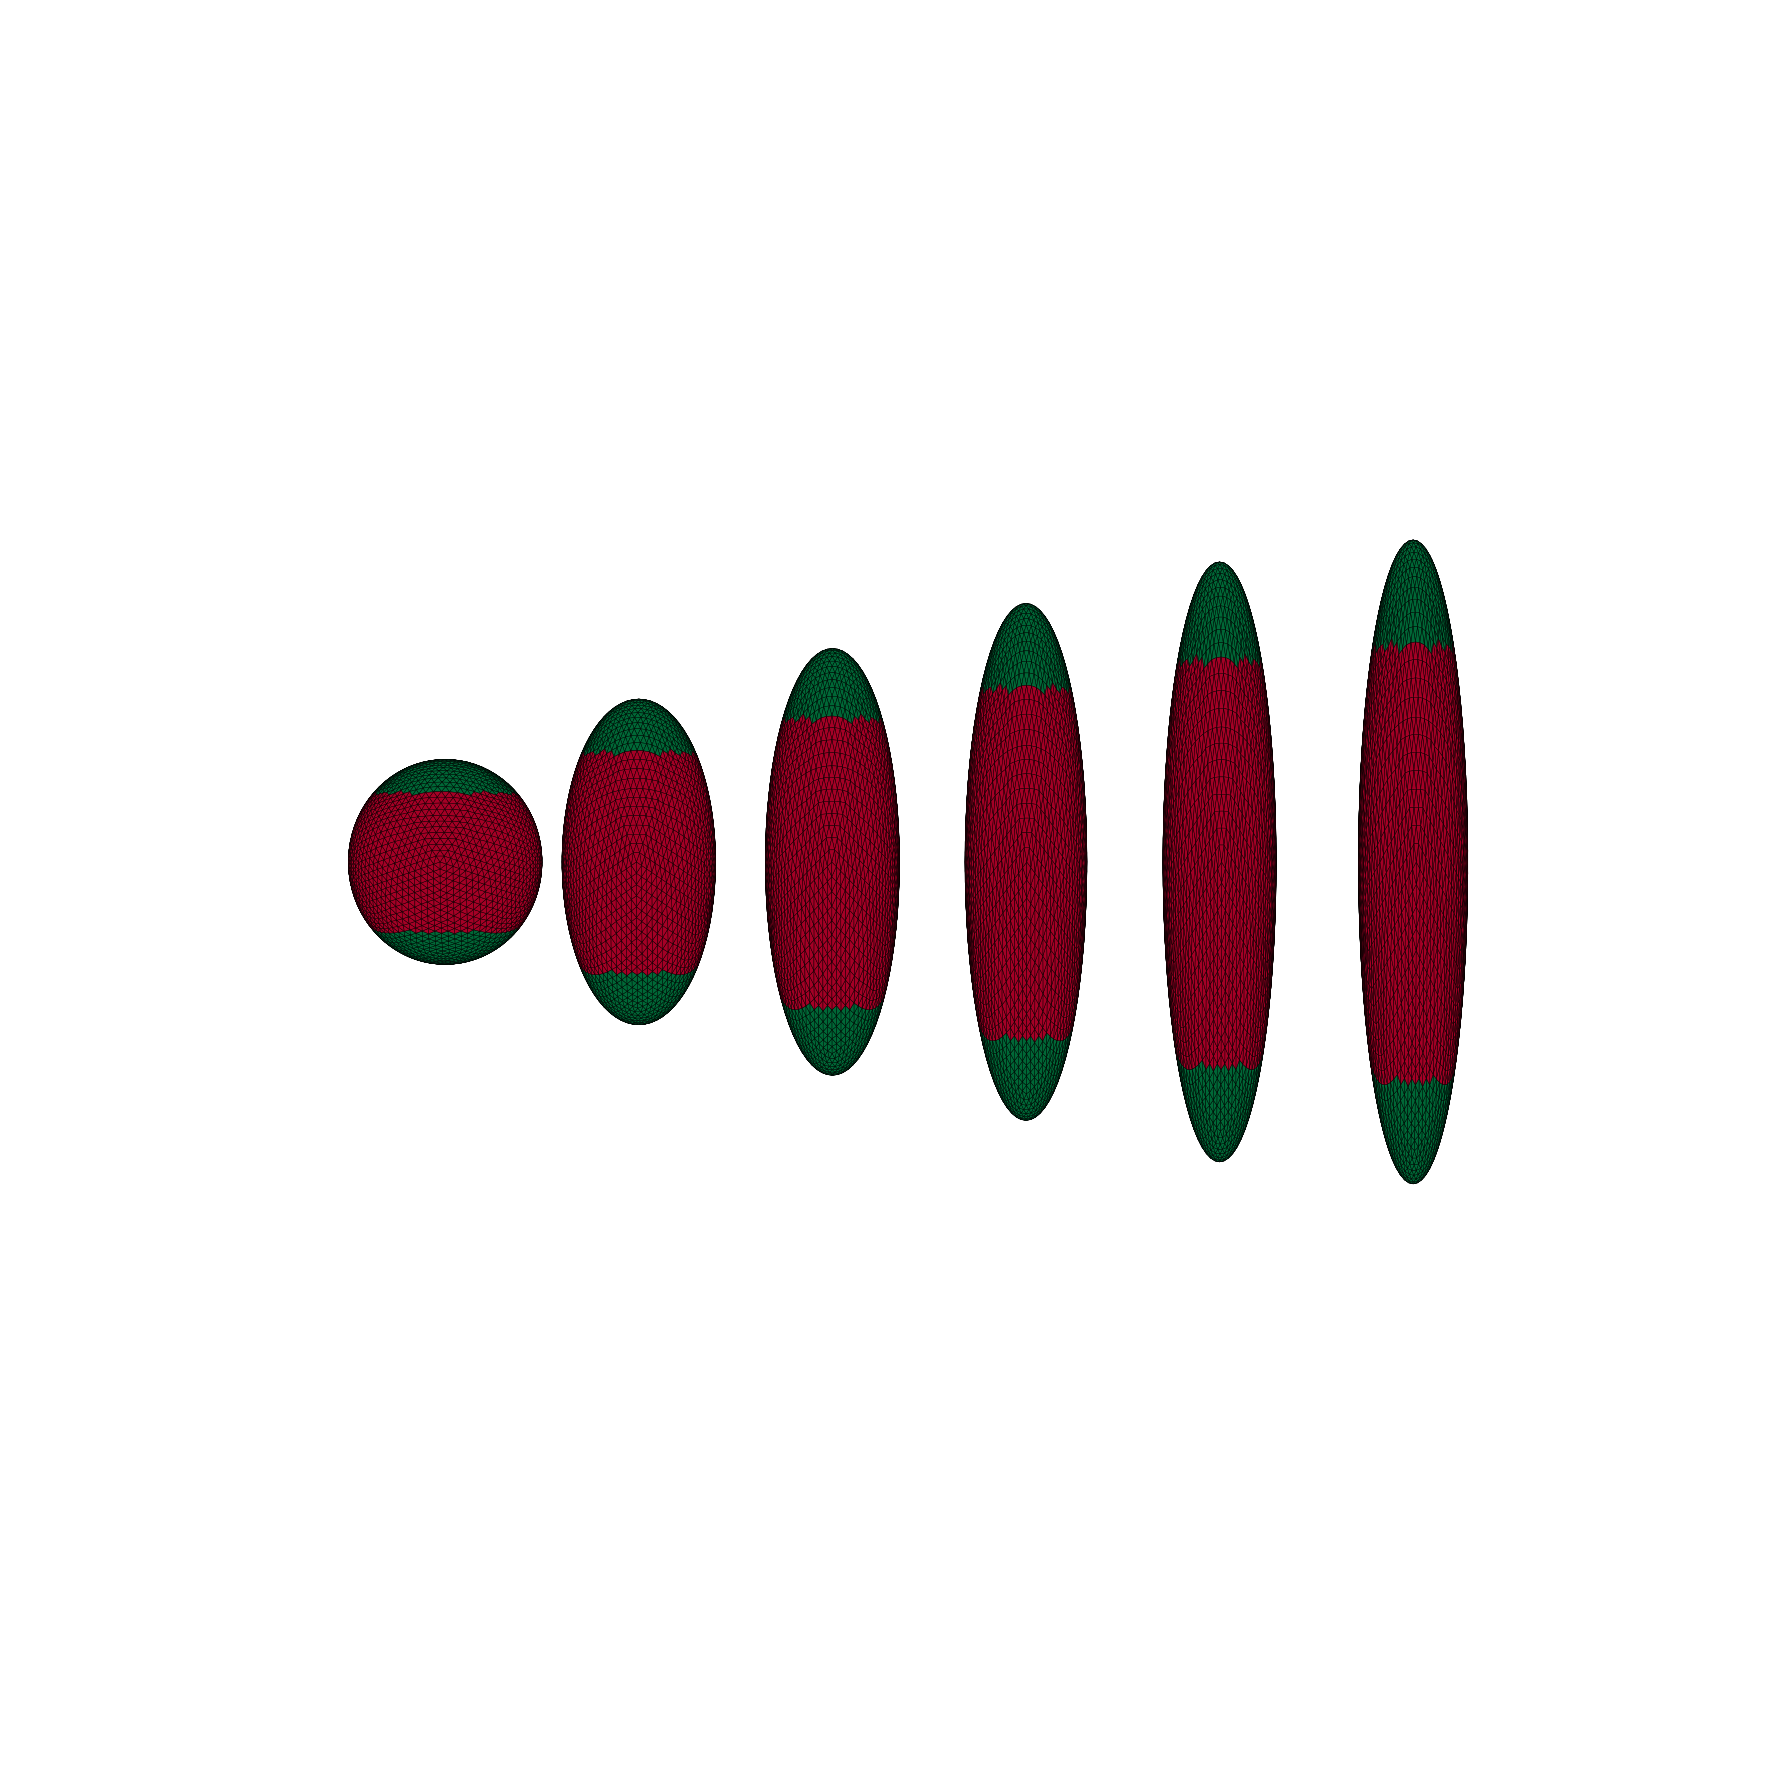

In [9]:
nr = 1; nc = 1;
fig, ax = plt.subplots(nrows=nr, ncols=nc,figsize=(8*1.5, 4*1.5), dpi=300, facecolor='w', edgecolor='k')
subdiv = 4
aspect_ratio = np.array([1,2,3,4,5,5.56])
b = aspect_ratio**(-1/3)
a = b*aspect_ratio
# Plot the mesh in both subplots
cmap = cm.RdYlGn
m = cm.ScalarMappable(cmap=cmap)
for ppos in range(0,6):
    volfrac = 0.125
    shapevec = [b[ppos], b[ppos], a[ppos]]
    zcutoff = get_Lcutoff(shapevec, volfrac)
    # colors = m.to_rgba(actincounter)
    maxval = max(shapevec)/1.6
    maxval = 5.56
    print(shapevec)
    meshvar = icosphere(subdiv, shapevec)
    vertices = meshvar[0]+[2.0*ppos,0,0]
    triangles = meshvar[1]
    Ntriangles = np.shape(triangles)[0]
    #########
    # get z value threshold
    locs = list(np.argwhere(vertices[:,2]>=zcutoff)) + list(np.argwhere(vertices[:,2]<=-zcutoff))
    # find triangles with the vertices
    trilocs = np.unique(list(np.argwhere(np.in1d(triangles[:,0], locs)==1))+list(np.argwhere(np.in1d(triangles[:,1], locs)==1))+list(np.argwhere(np.in1d(triangles[:,2], locs)==1)))
    colorvec = np.zeros(len(triangles))
    colorvec[trilocs] = 1
    colors = m.to_rgba(colorvec)
    # give them a color
    ax=plt.subplot(nr,nc,1, projection='3d')
    # ax.set_xlim3d(-maxval,maxval)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-maxval,maxval)
    ax.set_box_aspect((6, 1, maxval))
    p3dc = ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], color=(0,0,0,0),
                            triangles = triangles, edgecolor=[[0,0,0]], linewidth=0.1, shade=False)
    p3dc.set_fc(colors)
    # axins = inset_axes(
    # ax,
    # width="5%",  # width: 5% of parent_bbox width
    # height="50%",  # height: 50%
    # loc="lower left",
    # bbox_to_anchor=(1.05, 0.25, 1, 1),
    # bbox_transform=ax.transAxes,
    # borderpad=0,
    # )
    # fig.colorbar(m, cax=axins, shrink=0.5,aspect=15)
ax.view_init(elev=0, azim=-90)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z axis')
ax.axis('off')
plt.tight_layout()
plt.savefig('SER_volfrac.png', dpi=300, bbox_inches='tight')
plt.savefig('SER_volfrac.pdf', bbox_inches='tight')

# Figure S14 B

In [105]:

nr = 1; nc = 6;
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')
cmap = cm.RdYlGn_r
m = cm.ScalarMappable(cmap=cmap)
# rset=[]
# rid = 5
# repid = 0
# print('R_'+str(rid)+'_r_'+str(repid))
# r = readcytosimtraj('/Users/aravind/Research/PostDoc/Research/cytosimfiles/SER_steric_Actinsweep_test3_tscc/R_'+str(rid)+'_r_'+str(repid)+'/')
# rset.append(r[0])
# SREF = len(r[0].snap)-5

snaplist = [100,150,200,300,400, 450]
# Plot the bundlea=
for ppos in range(0,nc):
    SREF = snaplist[ppos]
    filcoord = rset[0].snap[SREF].filcoord
    shapevec = rset[0].snap[SREF].shapevec
    print(shapevec[2]/shapevec[1])
    ax=plt.subplot(nr,nc,ppos+1, projection='3d')
    for f, fc in enumerate(filcoord):
        ax.plot3D(fc[:,0],fc[:,1],fc[:,2], '-',linewidth=2, color='#74B357')
#ax.axis('off')
# Plot the mesh in both subplots
for ppos in range(0,nc):
        ax=plt.subplot(nr,nc,ppos+1, projection='3d')
        SREF = snaplist[ppos]
        shapevec = rset[0].snap[SREF].shapevec
        volfrac = 0.125
        subdiv = 3
        meshvar = icosphere(subdiv, shapevec)
        vertices = meshvar[0]
        triangles = meshvar[1]
        Ntriangles = np.shape(triangles)[0]
        ax.set_xlim3d(-shapevec[2]/2,shapevec[2]/2)
        ax.set_ylim3d(-shapevec[2]/2,shapevec[2]/2)
        ax.set_ylim3d(-shapevec[2]/2,shapevec[2]/2)
        ax.view_init(elev=0, azim=-90)
        #ax.set_ylim3d(-1,1)
        zcutoff = get_Lcutoff(shapevec, volfrac)
        print(shapevec,zcutoff)
        #ax.set_zlim3d(zcutoff,shapevec[2])
        delta = shapevec[2]-zcutoff
        ax.set_box_aspect((1, 1, 1))
        ax.set_box_aspect((1, 1, 1/1.15*delta))
        ax.set_zlim3d(zcutoff,shapevec[2])
        # ax.invert_zaxis()
        ax.set_zlabel('Z axis')
        p3dc = ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], color=(0,0,0,0),
                                triangles = triangles, edgecolor=[[0,0,0]], linewidth=0.1, shade=False)
        # COlor the trisurf
         # find triangles with the vertices
        trilocs = np.unique(list(np.argwhere(np.in1d(triangles[:,0], locs)==1))+list(np.argwhere(np.in1d(triangles[:,1], locs)==1))+list(np.argwhere(np.in1d(triangles[:,2], locs)==1)))
        colorvec = np.zeros(len(triangles))+1
        colorvec[trilocs] = 0
        colors = m.to_rgba(colorvec)
        colors[trilocs,:]=0
        p3dc.set_fc(colors)
        ax.axis('off')
plt.savefig('SER_top.png', dpi=300, bbox_inches='tight')
plt.savefig('SER_top.pdf', bbox_inches='tight')

1.638785695169355
2.1002242373560738
2.598320302779928
3.694851633928323
4.9130024565012285
5.564100564915688
[0.848189, 0.848189, 1.39] 0.9667039423993291
[0.780869, 0.780869, 1.64] 1.1405715579387767
[0.727393, 0.727393, 1.89] 1.3144391734782244
[0.646846, 0.646846, 2.39] 1.6621744045571203
[0.588235, 0.588235, 2.89] 2.0099096356360153
[0.564332, 0.564332, 3.14] 2.1837772511754636


# Figure 4 end-to-end distance

R_0_r_0
0.7853981633974483


FileNotFoundError: [Errno 2] No such file or directory: '/Users/aravind/Research/PostDoc/Research/cytosimfiles/Actin_Lfil_sweep/R_0_r_0/objects.cmo'

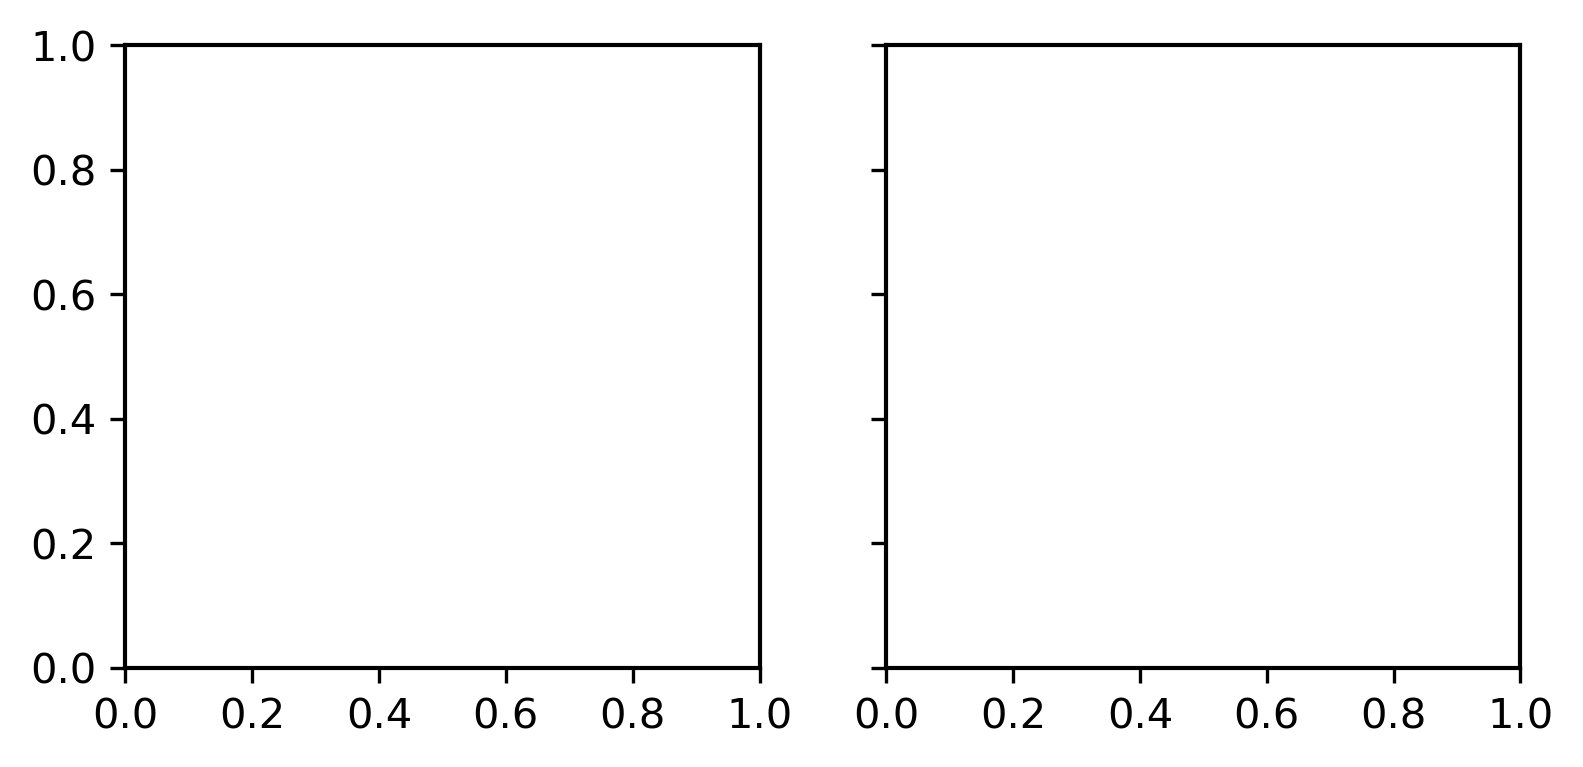

In [55]:
from sklearn.metrics import pairwise_distances
def get_all_distances(filcoord):
    axisval = 0
    dist_end_end = np.array([])
    snapcoordmat=np.array([[]])
    for f, fc in enumerate(filcoord):
        Nbeads = (np.shape(fc))[0]
        endcoordmat = np.array([fc[0,:],fc[Nbeads-1,:]])
        if f==0:
            snapcoordmat = endcoordmat
        else:
            axisval = 0
            snapcoordmat = np.concatenate((snapcoordmat,endcoordmat),axis=axisval)
    print(np.shape(snapcoordmat))
    print(snapcoordmat)
    plt.plot(snapcoordmat[:,0],snapcoordmat[:,1],'o')
    return scipy.spatial.distance.pdist(snapcoordmat, metric='euclidean')
def get_distances(filcoord):
    axisval = 0
    dist_end_end = np.array([])
    snapcoordmat=np.array([[]])
    for f, fc in enumerate(filcoord):
        Nbeads = (np.shape(fc))[0]
        filcoordmat = np.zeros((Nbeads,3))
        dee = np.linalg.norm(fc[0,:]-fc[Nbeads-1,:])
        dist_end_end = np.append(dist_end_end,dee)
    return dist_end_end

def plotfilenddistances(rset):
    r=rset[0]
    timevector = r.timevector
    Nsnaps = len(r.snap)
    deltasnap = 1
    ssnap = 0
    dist_end_end = np.array([])
    for SREF in range(Nsnaps-1,Nsnaps,deltasnap):
        Nfilsnap = []
        L = []
        bin_edges = np.linspace(0,2,100)
        bin_edges = [0,0.15,0.25]
        for runidx in range(0,len(rset)):
            nsnaplocal = len(rset[runidx].snap)
            # Check if current run has the SREF'th snap. If so, collect data, if not, move on.
            if(SREF<=nsnaplocal):
                filcoord = np.array(rset[runidx].snap[SREF].filcoord)

                # [PCeigenval, PCeigenvec] = geteigensnap (filcoord)
                #end-to-end
                darray = get_all_distances(filcoord)
                axisval = 0;
                dist_end_end = np.concatenate((dist_end_end,darray),axis=axisval)
    
                # sortedloc=np.argsort(PCeigenval)

                # ellipsespan = rset[runidx].snap[SREF].shapevec
                # volfrac = 0.125
                # zcutoff = get_Lcutoff(ellipsespan, volfrac)
                # norm = mpl.colors.Normalize(vmin=0, vmax=2)
                # cmap = cm.RdYlGn_r
                # countval = 0
                # countval2 = 0
                # m = cm.ScalarMappable(norm=norm, cmap=cmap)
                # Nmonomers = 0
                # Nmonomers = Nmonomers + getmonomerswithinsubvolume(filcoord, zcutoff,False)
                # for f, fc in enumerate(filcoord):
                #     locs = np.where(fc[:,2] > zcutoff)[0].tolist()
                #     locs2 = np.where(fc[:,2] < -zcutoff)[0].tolist()
                #     countval = countval+len(locs)
                #     countval2 = countval2+len(locs2)
                #     distval = []
                #     Nbeads = (np.shape(fc))[0]
                #     for i in range(0,Nbeads):
                #         temp = getellipsedistance(fc[i],ellipsespan)
                #         distval.append(temp)
                #         L.append(temp)
    return dist_end_end
Lfil=np.array([1/4,1/3,1/2,1,4/3,5/3,2])*np.pi
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
rgba = new_cmap(np.linspace(0, int(256/8), 256))
Lfillatex = [r"$\pi/4$", r"$\pi/3$", r"$\pi/2$", r"$2\pi/3$", r"$\pi$", r"$4\pi/3$", r"$5\pi/3$", r"$2\pi$"]
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(6.0,2.75), 
                        dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
bin_edges = np.linspace(0,2,100)
bin_center = bin_edges[0:len(bin_edges)-1]+0.5*(bin_edges[1]-bin_edges[0])
axisval = 0
colorcounter = 0
for rid in range(0,4):
    rset=[]
    dfvec_allruns = np.array([])
    for repid in range(0,5):
        print('R_'+str(rid)+'_r_'+str(repid))
        print(Lfil[rid])
        r = readcytosimtraj('./FIGURE_4/INPUTFILES/R_'+str(rid)+'_r_'+str(repid)+'/')
        rset.append(r[0])
        df = plotfilenddistances(rset)
        dfvec_allruns = np.concatenate((dfvec_allruns,df),axis=axisval)
    [binval, binedges] = np.histogram(dfvec_allruns, bin_edges,density=True)
    axvec[0].plot(bin_center,binval,color=rgba[colorcounter,:])
    colorcounter = colorcounter + 1
    print([np.mean(df/Lfil[rid]),np.std(df/Lfil[rid])])
axvec[0].legend(Lfillatex[0:4], frameon=False, labelspacing=0.1)
axvec[0].set_xlabel(r"Distance ($\mu m$)")
axvec[0].set_ylabel('Filament-end Probability density')
###############
for rid in range(4,7):
    rset=[]
    dfvec_allruns = np.array([])
    for repid in range(0,5):
        print('R_'+str(rid)+'_r_'+str(repid))
        print(Lfil[rid])
        r = readcytosimtraj('./FIGURE_4/INPUTFILES/R_'+str(rid)+'_r_'+str(repid)+'/')
        rset.append(r[0])
        df = plotfilenddistances(rset)
        dfvec_allruns = np.concatenate((dfvec_allruns,df),axis=axisval)
    [binval, binedges] = np.histogram(dfvec_allruns, bin_edges, density=True)
    axvec[1].plot(bin_center,binval,color=rgba[colorcounter,:])
    colorcounter = colorcounter + 1
    print([np.mean(df/Lfil[rid]),np.std(df/Lfil[rid])])
# # ###############
[binval, binedges] = np.histogram(dfvec_allruns, bin_edges,density=True)
axvec[1].plot(bin_center,binval,color=rgba[colorcounter,:])
colorcounter = colorcounter + 1
print([np.mean(df/Lfil[rid]),np.std(df/Lfil[rid])])

axvec[1].legend(Lfillatex[4:8], frameon=False, labelspacing=0.1)
axvec[1].set_xlabel(r"Distance ($\mu m$)")
axvec[1].set_xlim([0,2])
fig.tight_layout()
plt.savefig('Actin_Lfil_sweep_metric_v2.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Actin_Lfil_sweep_metric_v2.pdf', bbox_inches='tight')
# Try plotting.

# Figure S10 B,C. Linear nucleator Nat. Comm. review.

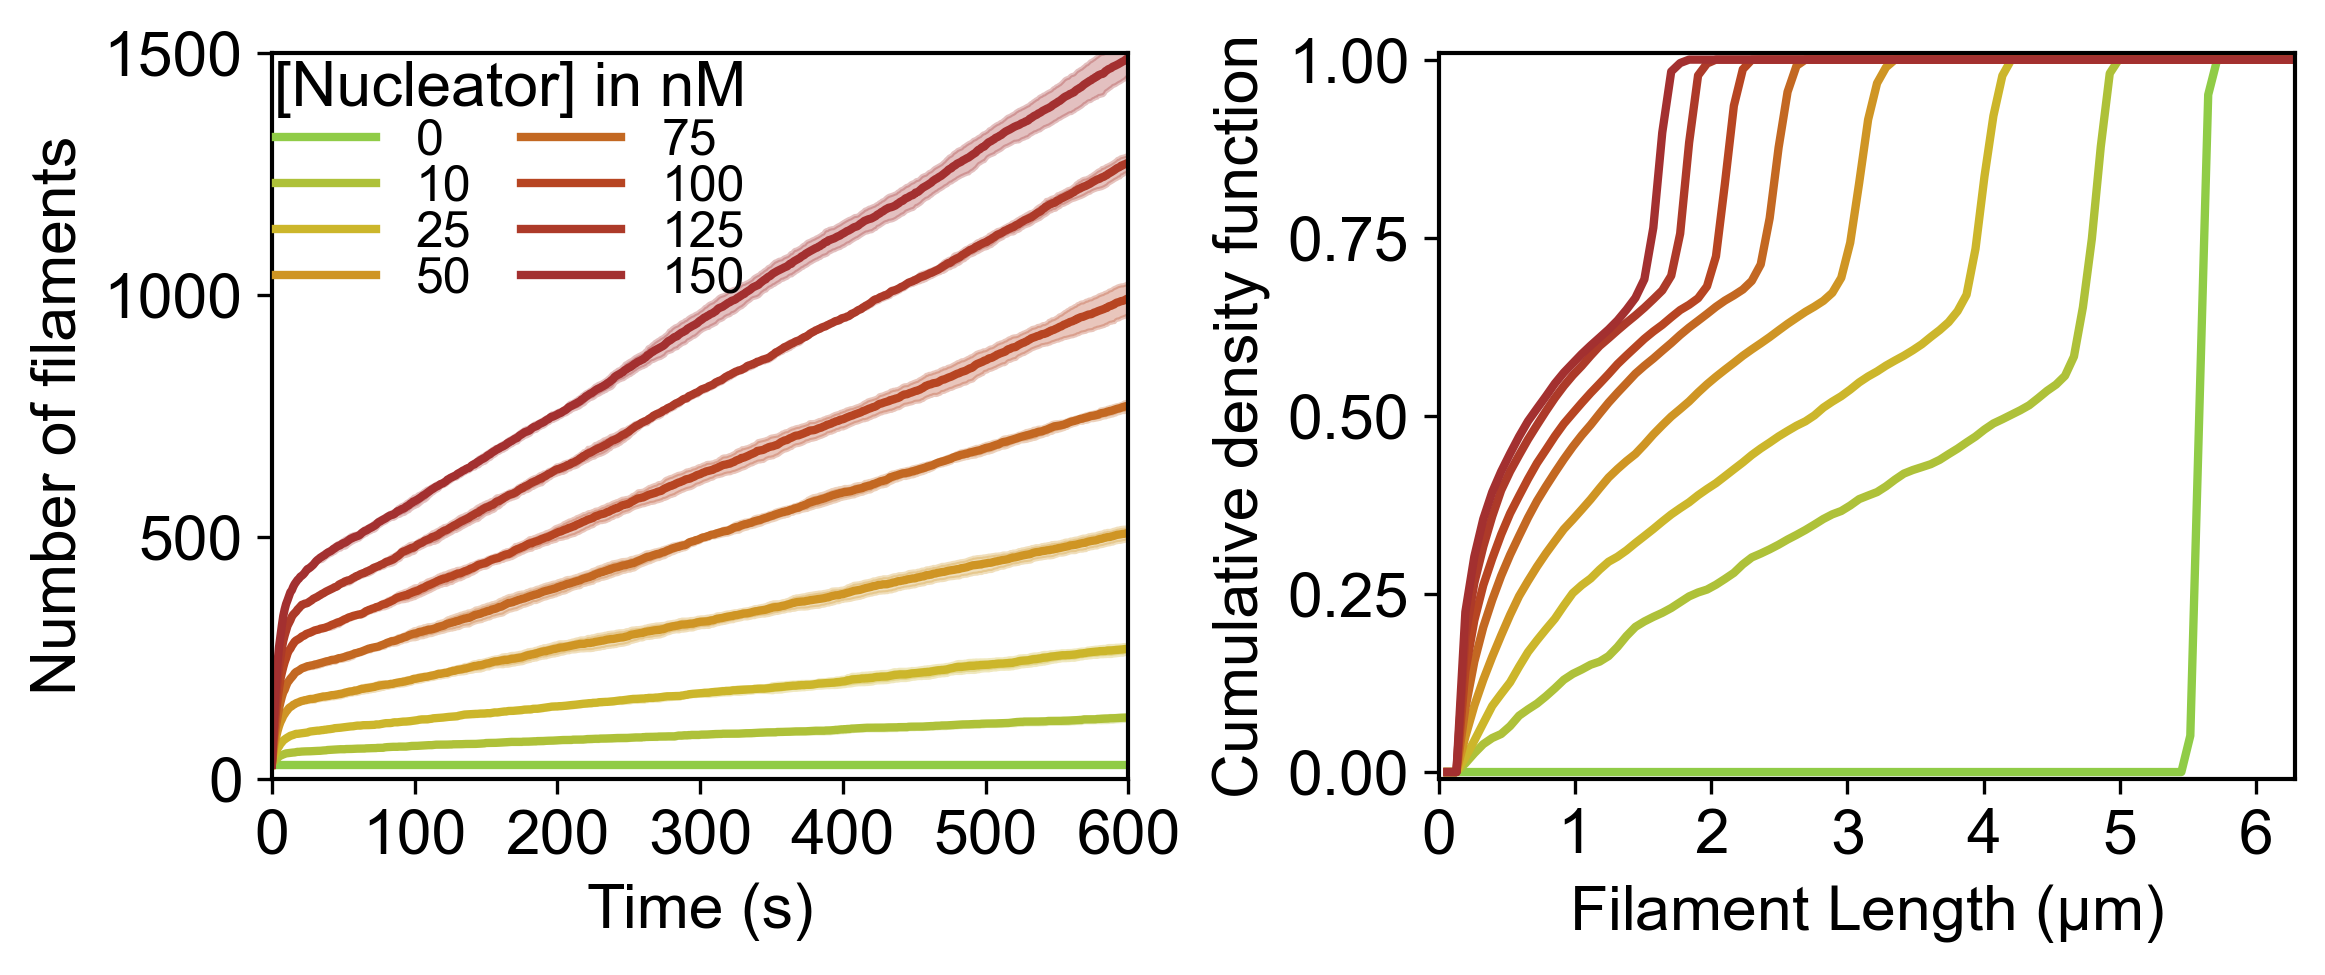

In [150]:
def converttocdf(X,PX):
    cdf = np.zeros(len(X))
    for iter, xval in enumerate(X):
        cdf[iter]=np.trapz(PX[0:iter],x=X[0:iter])
    return cdf/cdf[-1]
filereadpath = './FIGURE_S10/OUTPUTFILES/'
colorlist = ['#5fb549','#7ea124','#938c02','#a07500','#a75e0e','#a84621','#a22f31']
rgba = new_cmap(np.linspace(0, int(256/7), 256))
repid = 0
# Dataframe
# 0 time
#1 Mean N fil
#2 STD N fil
#3 MEAN L 
#4 STD L
plt.rcParams.update({'font.size': 15, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
titlevec=['[Nuc]=0nM',10,25,50,75,100,125,150]
# Get figure
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(8,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.15)
legcell=[]
legcell2=[]
for i in range(0,8):
    Row1=[]
    fvar = filereadpath+'Fillength_linear_nucleatorR_'+str(i)+'.csv'
    df = pd.read_csv(fvar,index_col=0).transpose()
    legax=axvec[0].plot(df['Time'],df['Nfil_mean'],linewidth=2,color=rgba[i,:])
    axvec[0].fill_between(df['Time'],df['Nfil_mean']-df['Nfil_std'],df['Nfil_mean']+df['Nfil_std'],color=rgba[i,:],alpha=0.3)
    legcell.append(legax[0])
    axvec[0].legend(legcell,[0,10,25,50,75,100,125,150],ncol=2, title='[Nucleator] in nM',
                    frameon=False,fontsize=12, labelspacing=0, columnspacing=1.0,bbox_to_anchor=(-0.05, 0.05, 1, 1),)
    # legax=axvec[1].plot(df['Time'],df['Lfil_mean'],linewidth=2,color=rgba[i,:])
    # axvec[1].fill_between(df['Time'],df['Lfil_mean']-df['Lfil_std'],df['Lfil_mean']+df['Lfil_std'],color=rgba[i,:],alpha=0.3)
    # legcell2.append(legax[0])
axvec[0].set_xlabel('Time (s)')
axvec[0].set_ylabel('Number of filaments')
axvec[0].set_xlim([0,600])
axvec[0].set_xticks([0,100,200,300,400,500,600])
axvec[0].set_ylim([0,1500])
for i in range(0,8):
    Row1=[]
    fvar = filereadpath+'Fillength_dist_linear_nucleatorR_'+str(i)+'.csv'
    df = pd.read_csv(fvar,index_col=0).transpose()
    X=np.linspace(0,6.5,100)
    X=np.array(X[0:len(X)-1])+np.array(X[1]-X[0])
    cdfvec = converttocdf(X,df[595])
    legax=axvec[1].plot(X,cdfvec,linewidth=2,color=rgba[i,:])
axvec[1].set_ylim([-0.01,1.01])
axvec[1].set_xlim([0,2*np.pi])
axvec[1].set_xticks([0,1,2,3,4,5,6])
axvec[1].set_xlabel(r"Filament Length ($\mu m$)")
axvec[1].set_ylabel('Cumulative density function')
fig.tight_layout()
plt.savefig('Nuc_filstats.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Nuc_filstats.pdf', bbox_inches='tight')

# Nuc FO Valency dist.

## Valency read

In [89]:
Mean_0_fil = []
Mean_1_fil = []
Mean_2_fil = []
Mean_3_fil = []
Mean_4_fil = []
Std_0_fil = []
Std_1_fil = []
Std_2_fil = []
Std_3_fil = []
Std_4_fil = []
filereadpath ='./FIGURE_S10/OUTPUTFILES/'
jobfoldername = 'linear_nucleator'
Nuclist=[0,10,25,50,75,100,125,150]
for Rval in range(0,8):
    bar_raw_data = np.array([])
    Row1=[]
    filename = filereadpath+'Crosslink_'+jobfoldername+'_R_'+str(Rval)+'_r_'
    Nreps = 3
    outputlist = crossplothelper(filename,Nreps,1000)
    Mean_0_fil.append(outputlist[0])
    Mean_1_fil.append(outputlist[1])
    Mean_2_fil.append(outputlist[2])
    Mean_3_fil.append(outputlist[3])
    Mean_4_fil.append(outputlist[4])
    Std_0_fil.append(outputlist[5])
    Std_1_fil.append(outputlist[6])
    Std_2_fil.append(outputlist[7])
    Std_3_fil.append(outputlist[8])
    Std_4_fil.append(outputlist[9])
bardf = pd.DataFrame({'Nuc':Nuclist,
                      '0':Mean_0_fil,'1':Mean_1_fil,
                    '2':Mean_2_fil,'3':Mean_3_fil,
                    '4':Mean_4_fil})
cumarray = np.zeros((5,len(Mean_0_fil)))
cumarray[0][:]=Mean_0_fil[:]
cumarray[1][:]=cumarray[0][:]+Mean_1_fil
cumarray[2][:]=cumarray[1][:]+Mean_2_fil
cumarray[3][:]=cumarray[2][:]+Mean_3_fil
cumarray[4][:]=cumarray[3][:]+Mean_4_fil
#print((cumarray))
stddf = pd.DataFrame({})
print(bardf)

   Nuc         0         1         2         3         4
0    0  0.155215  0.039753  0.161387  0.351183  0.292462
1   10  0.023957  0.017645  0.091376  0.340161  0.526860
2   25  0.009441  0.012140  0.060548  0.291753  0.626118
3   50  0.003871  0.008355  0.040978  0.249849  0.696946
4   75  0.003763  0.007527  0.037570  0.237656  0.713484
5  100  0.004849  0.008022  0.036312  0.231968  0.718849
6  125  0.005677  0.009892  0.039183  0.235452  0.709796
7  150  0.007280  0.012570  0.043011  0.234430  0.702710


## FO read

In [107]:
# Load all replicates
# Take mean and std
# plot 5 rows 1 column plots
# Figure 1 time series
# Figure 2 Bar plot
# Row 0 - Time
# Row 1 - fraction of occupied triangles 
filereadpath = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/analysis_scripts/outputfiles/linear_nucleator/'
jobfoldername = 'linear_nucleator'
colorlist = ['#5fb549','#7ea124','#938c02','#a07500','#a75e0e','#a84621','#a22f31','#a22f31']
Meanlist = []
Stdlist = []
mean_frac_bar = []
std_frac_bar = []
for Rval in range(0,8):
    bar_raw_data = np.array([])
    Row1=[]
    for repid in range(0,3):
        fvar = filereadpath+'/FO_'+jobfoldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
        df = pd.read_csv(fvar,index_col=0)
        datavec = df.iloc[1].to_numpy()
        Row1.append(datavec)
        barstartpos = int(0.95*len(datavec))
        bar_raw_data = np.append(bar_raw_data,datavec[barstartpos:])
    Row1 = np.array(Row1)
    Meanlist.append(np.mean(Row1,0))
    Stdlist.append(np.std(Row1,0))
    mean_frac_bar.append(np.mean(bar_raw_data))
    std_frac_bar.append(np.std(bar_raw_data))
Timevec = df.iloc[0].to_numpy()

## FIGURE S10 D AND E

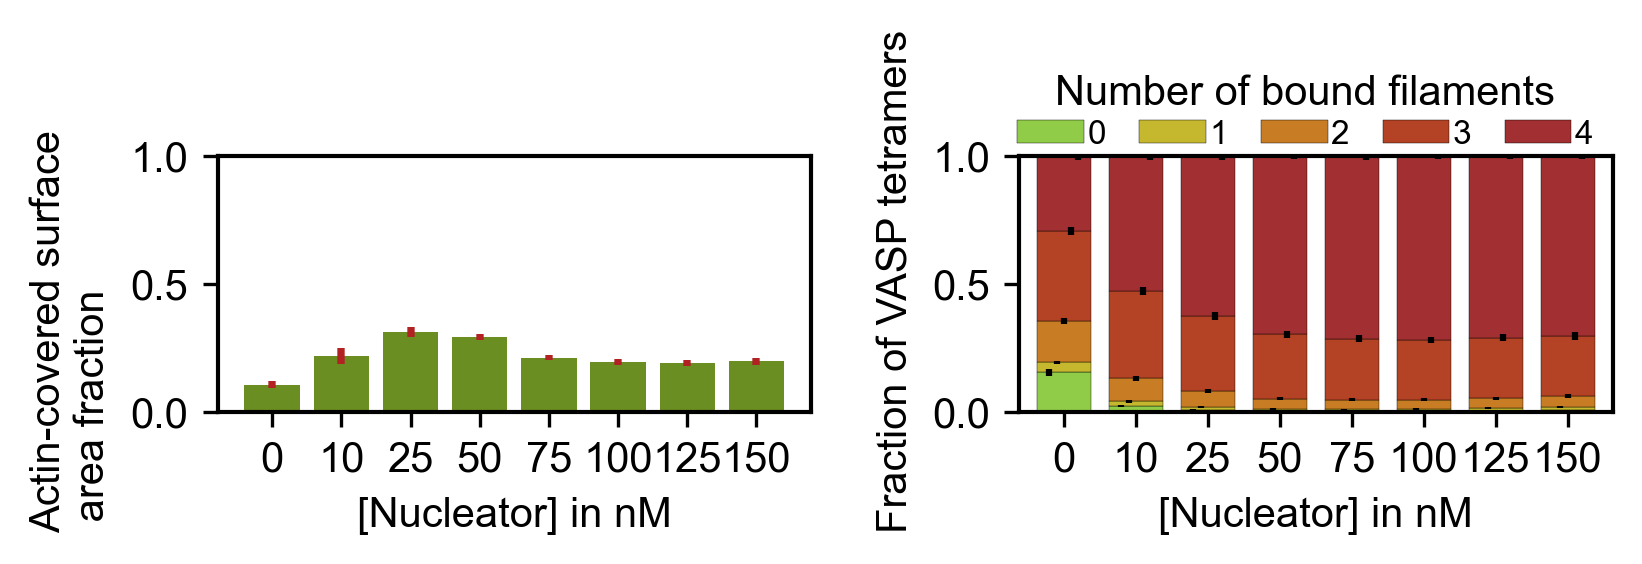

In [149]:
import math
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
ylabelvec = [0.2, 0.4, 0.8, 1.0, 2.0]
# Get figure
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(5.0,1.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
# FIRST COLUMN
for plotcounter in range(0,nr):
    legcell = []
    df = pd.DataFrame()
    stddf=pd.DataFrame()
    stddatavec = []
    Nvalency = 4
    for val in range(0,8):
        Rval=val;
        stddatavec.append(np.array([val-0.2, cumarray[0][Rval], Std_0_fil[Rval]]))
        offset = -0.1
        for pos in range(0,Nvalency):
            if pos ==0:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_1_fil[Rval]]))
            elif pos ==1:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_2_fil[Rval]]))
            elif pos ==2:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_3_fil[Rval]]))
            elif pos ==3:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_4_fil[Rval]]))
            offset = offset + 0.1
    #df.columns=labelvec
    df =bardf
    #print(df)
    stddatavec = pd.DataFrame(np.array(stddatavec),columns=['x','mean','std'])
    # PLOT
    ax = axvec[1]
    df.plot(ax=ax,x='Nuc',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)
    ax.errorbar(stddatavec['x'],stddatavec['mean'],yerr=stddatavec['std'], fmt = 'o', markersize = 0, ecolor='black')
    # Beautify
    ax.set_xticklabels(Nuclist, rotation = 0)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.5,1.0])
    if plotcounter > 0:
        ax.set_xticklabels([])
    #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
leg = fig.legend(['0','1','2','3','4'],title='Number of bound filaments',ncol=5,fontsize=8,frameon=False,
                bbox_to_anchor=(0.987, 1.25), labelspacing=0.2, columnspacing = 1.0, handletextpad=0.1)

plt.text(0.49, -0.35, 'Fraction of VASP tetramers', transform=plt.gcf().transFigure, rotation=90)
ax.set_xlabel('[Nucleator] in nM')
#SECOND COLUMN
if False:
    legcell = []
    for val in range(0,8):
        Rval = val
        ax = axvec[0]
        x=ax.plot(Timevec,Meanlist[Rval],color=colorlist[val])
        legcell.append(x[0]);
        ax.fill_between(Timevec,Meanlist[Rval]-Stdlist[Rval],Meanlist[Rval]+Stdlist[Rval],color=colorlist[val],alpha=0.3)
        ax.set_xlim([0,601])
        ax.set_ylim([0,0.6])
        ax.set_yticks([0,0.3,0.6])
        ax.set_xticks([0,100,200,300,400,500,600])
        if plotcounter > 0:
            ax.set_xticklabels([])
    plt.text(-0.04, 0.3,  'Actin-covered surface area fraction', transform=plt.gcf().transFigure, rotation=90)
    leg = fig.legend(legcell, Nuclist,title='[Nuc] in nM',ncol=4,handlelength=1.25,columnspacing=0.75, handletextpad = 0.1, fontsize=8,frameon=False,
                    bbox_to_anchor=(0.525, 0.97), labelspacing=0.0)
    axvec[0].set_xlabel('Time (s)')
### BAR PLOT
for Rval in range(0,8):
    legcell = []
    ax = axvec[0]
    meandata = mean_frac_bar
    stddata = std_frac_bar
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,len(Nuclist)))
    ax.set_xticklabels(Nuclist, rotation = 0)
ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([0,0.5,1.0])
axvec[nr-1].set_xlabel('[Nucleator] in nM')
plt.text(-0.075, -0.35, 'Actin-covered surface \n area fraction', transform=plt.gcf().transFigure, rotation=90)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.025, 
                    top=0.88,
                    wspace=0.35, 
                    hspace=0.2)
# SAVE
plt.savefig('Nuc_2col_TS_bar.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Nuc_2col_TS_bar.pdf', bbox_inches='tight')

## FIGURE S10F - [Nuc] RDF

41
41
0.33021413533835475
41
41
0.452697338868076
41
41
0.5662046110161338
41
41
0.7620158831216599
41
41
0.996718225024236
41
41
4.163238878655476
41
41
5.467200808752795
41
41
5.3603400610722325


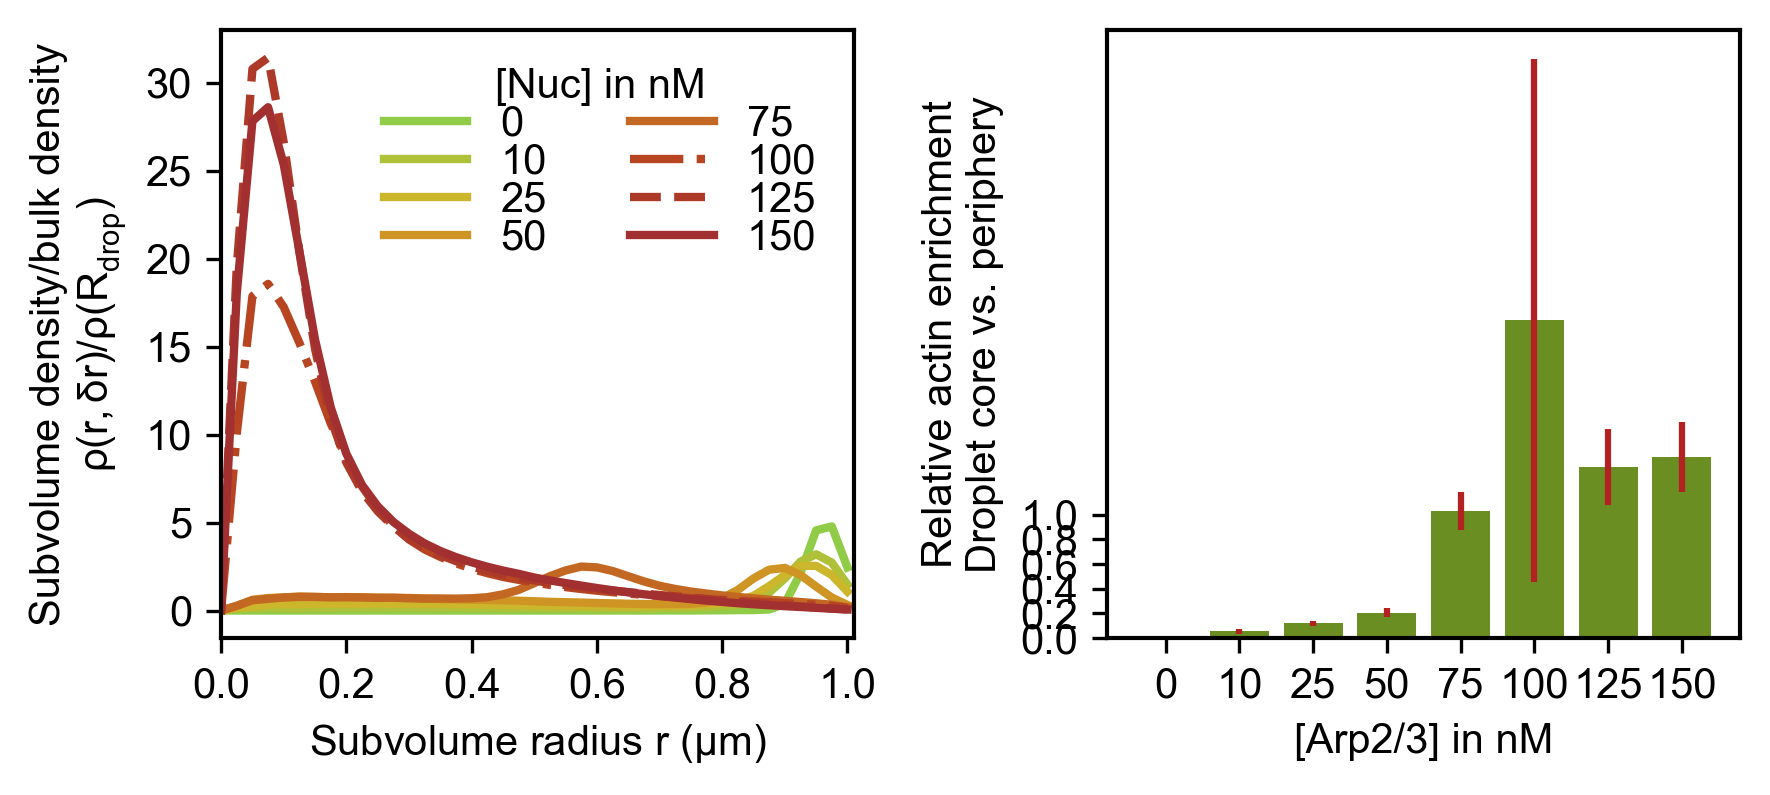

In [86]:
# Plot 1 - Just plot the final radial density
rgba = new_cmap(np.linspace(0, int(256/7), 256))
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight'
                    :'normal'})
filepath = './FIGURE_S10/INPUTFILES/'
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(6.0,2.75), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.25,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.25, 
                    hspace=0.15)
Nreps =5
legcell = []
plotdf2 = pd.DataFrame()
for Rval in range(0,8):
    Nveclist = []
    core_density_list = []
    peri_density_list = []
    relative_enrichment = []
    for repid in range(0,Nreps):
        filename = 'Density_linear_nucleatorR_'+str(Rval)+'_r_'+str(repid)+'.csv'
        fvar = filepath + filename
        df = pd.read_csv(fvar,index_col=0)
        Nframes = len(df.columns)
        #get the radius vector
        radvec = df["Radius"]
        radvec = pd.concat([pd.Series([0]), radvec])
        dR = radvec.iat[1]-radvec.iat[0]
        for SREF in range(Nframes-10,Nframes):
            #Get the number count vector
            Nbin = df.iloc[:,SREF]
            ######### ORIGINAL VERSION
            # core_pos = int(len(Nbin)/4-1)
            # core_radius = radvec[core_pos]
            # core_density = Nbin[core_pos]/(core_radius*core_radius)
            # peri_pos = int(len(Nbin)-4)
            # peri_radius = radvec[peri_pos]
            # peri_density = Nbin[peri_pos]/(peri_radius*peri_radius)
            # core_density_list.append(core_density)
            # peri_density_list.append(peri_density)
            # relative_enrichment.append(core_density/peri_density)
            #########
            #Nvec = np.cumsum(Nbin)
            Nvec = Nbin
            Nvec = pd.concat([pd.Series([0]), Nvec])
            localfactor =dR**-1*radvec**-2
            #Nmax = Nvec.iat[-1]
            Nmax = np.sum(Nvec)
            Rmax = radvec.iat[-1]
            bulkfactor = 3*Nmax/(Rmax*Rmax*Rmax)
            density_ratio = Nvec*localfactor/bulkfactor
            density_ratio = density_ratio.fillna(0)
            Nveclist.append(density_ratio)
            ################# UPDATED VERSION
            radvec_core = radvec[(radvec>=0.2) & (radvec<0.6)]
            Ncore = Nvec[(radvec>=0.2) & (radvec<0.6)]
            radvec_periphery = radvec[(radvec>=0.6)]
            Nperiphery = Nvec[(radvec>=0.6)]
            maxNcore = Ncore.max()
            maxrcore = radvec_core[Ncore.idxmax()]
            maxNperiphery = Nperiphery.max()
            maxrperiphery = radvec_periphery[Nperiphery.idxmax()]
            core_density = maxNcore/(maxrcore*maxrcore)
            peri_density = maxNperiphery/(maxrperiphery*maxrperiphery)
            core_density_list.append(core_density)
            peri_density_list.append(peri_density)
            relative_enrichment.append(core_density/peri_density)
            #################
    plotdf2[Rval] = [np.mean(relative_enrichment), np.std(relative_enrichment)]
    # N(r)/r^2/N(R)/R^2
    plotdf = pd.DataFrame({'Radius':radvec,
                        'Density ratio':np.mean(Nveclist, axis=0),
                        'Std':np.std(Nveclist,axis=0),
                        'SEM':np.std(Nveclist,axis=0)/np.sqrt(Nreps)})
    print(np.trapz(plotdf['Density ratio'],plotdf['Radius']))
   #print(plotdf)
    # for x in range(0,len(Nveclist)):
    #     axvec[0].plot(plotdf['Radius'],Nveclist[x],linewidth=0.5,color=rgba[Rval,:])
    linestylestr='-'
    if Rval==5:
        linestylestr='-.'
    if Rval==6:
        linestylestr='--'
    legax = axvec[0].plot(plotdf['Radius'],plotdf['Density ratio'],linewidth=2,linestyle=linestylestr,color=rgba[Rval,:])
    legcell.append(legax[0])
    # axvec[0].fill_between(plotdf['Radius'],
    #                    plotdf['Density ratio']-plotdf['Std'],
    #                    plotdf['Density ratio']+plotdf['Std'],color=rgba[Rval,:],alpha=0.3)
axvec[0].set_ylabel(r"Subvolume density/bulk density" "\n" r"$\rho(r, \delta r)/\rho(R_{drop})$")
axvec[0].set_xlabel(r"Subvolume radius r $(\mu m)$")
axvec[0].legend(legcell,[0,10,25,50,75,100,125,150],ncol=2, title='[Nuc] in nM',frameon=False,labelspacing=0)
axvec[0].set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#axvec[0].set_ylim([-0.01,6])
axvec[0].set_xlim([0.0,1.01])
##############
plotdf2 = plotdf2.T
plotdf2.columns = ['Mean','Std']
axvec[1].bar(np.arange(0,8),plotdf2['Mean'],color='olivedrab')
axvec[1].errorbar(np.arange(0,8),plotdf2['Mean'], yerr=plotdf2['Std'], fmt = 'o', markersize = 0, ecolor='firebrick')
axvec[1].set_xticks(np.arange(0,8))
axvec[1].set_xticklabels([0,10,25,50,75,100,125,150])
axvec[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[1].set_xlabel('[Arp2/3] in nM')
axvec[1].set_ylabel(r"Relative actin enrichment" "\n" "Droplet core vs. periphery")
fig.tight_layout()
plt.savefig('Nuc_density.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Nuc_density.pdf', bbox_inches='tight')

# Actin:VASP ratio

In [5]:
filereadpath = './FIGURE_S11/OUTPUTFILES/'
foldername = 'INPUTFILES'
imagefilepathv = './FIGURE_S11/INPUTFILES/'
Nreps = 6
jointKmeans = True
if jointKmeans == False:
    FORow1 = np.array([])
    Row9 = []
    Row11 = []
    Row13 = []
    Row15 = []
    RowNfil = []
    imagelist = []
    taglist = []
    spanc = []
    spanb = []
    spana = []
else:
    #retlist = obtaindata_steric()
    retlist = obtaindata_ring_ringlike()
    for i in range(0,len(retlist)):
        FORow1 = retlist[0]
        Row9 = retlist[1]
        Row11 = retlist[2]
        Row13 = retlist[3]
        Row15 = retlist[4]
        imagelist = retlist[5]
        taglist = retlist[6]
        spanc = retlist[7]
        spanb = retlist[8]
        spana=retlist[9]
    
Vasp_conc = [0.4,0.8,2.0]
TotalVASP = [1000, 2018, 5044]
Nfil = [30,75,120,165,210]
###
for vconciter, vconc in enumerate(Vasp_conc):
    for niter, nval in enumerate (Nfil):
        Rval = niter+vconciter*len(Nfil)
        if Rval==14 or Rval==9 or Rval==4:
            continue;
        for repid in range(0,Nreps):
            fvar = filereadpath+'/Crosslink_'+foldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                Nsnaps = 5
                lenval = len(df.columns)
                tv  = TotalVASP[vconciter]
                startpos = 600-Nsnaps
                endpos = 600
                Row9 = np.append(Row9, df.iloc[9].to_numpy()[startpos:endpos]/tv)
                Row11 = np.append(Row11, df.iloc[11].to_numpy()[startpos:endpos]/tv)
                Row13 = np.append(Row13, df.iloc[13].to_numpy()[startpos:endpos]/tv)
                Row15 = np.append(Row15, df.iloc[15].to_numpy()[startpos:endpos]/tv)
            else:
                print('DOES NOT EXIST'+fvar,flush=True)
            fvar = filereadpath+'/FO_'+foldername+'_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                nv=Nfil[niter]
                FORow1 = np.append(FORow1, df.iloc[1].to_numpy()[startpos:endpos])
                #RowNfil = np.append(RowNfil, np.array([nv,nv,nv,nv,nv]))
            else:
                print('DOES NOT EXIST'+fvar,flush=True)
            
            fvar = filereadpath+'/Eigval'+foldername+'R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                spanc = np.append(spanc, df.iloc[1].to_numpy()[startpos:endpos])
                spanb = np.append(spanb, df.iloc[2].to_numpy()[startpos:endpos])
                spana = np.append(spana, df.iloc[3].to_numpy()[startpos:endpos])
            else:
                print('DOES NOT EXIST'+fvar,flush=True)

print('Data length dim2 = '+ str(len(FORow1)))
print('Data length dim2 = '+ str(len(Row9)))
print('Data length dim2 = '+ str(len(Row13)))
print('Data length dim2 = '+ str(len(Row15)))
#print('Data length dim2 = '+ str(len(RowNfil)))
#####################
sumspan = np.array(spana)+np.array(spanb)+np.array(spanc)
df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
                      '1':np.transpose(Row9),
                      '2':np.transpose(Row11), 
                      '3':np.transpose(Row13), 
                      '4':np.transpose(Row15),})
print(df_V2)
print(df_V2.corr(method='pearson', min_periods=1))
import cv2
import base64
def _get_image(path):
    #read bytes from and get the bytes as image_file
    with open(path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    encoded_img = f'data:image/png;base64,{encoded_string}'
    return encoded_img
imagefilepathv = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/'+foldername+'/'
for vconciter, vconc in enumerate(Vasp_conc):
    for niter, nval in enumerate (Nfil):
        Rval = niter+vconciter*len(Nfil)
        if Rval==14 or Rval==9 or Rval==4:
            continue;
        for repid in range(0,Nreps):
            for sidx in range(startpos,endpos):
                subdirname = '/R_'+str(Rval)+'_r_'+str(repid)+'/'
                imagename = "movie"+ f'{sidx:04d}'+".png"
                fvar =  imagefilepathv+subdirname+imagename
                if os.path.isfile(fvar):
                    taglist.append(['Actin:VASP',vconc,nval,repid,sidx])
                    img = cv2.imread(fvar)
                    img_25 = cv2.resize(img, None, fx = 0.25, fy = 0.25)
                    retval, buffer = cv2.imencode('.png', img_25)
                    jpg_as_text = base64.b64encode(buffer).decode()
                    imagelist.append( f'data:image/png;base64,{jpg_as_text}')
                else:
                    print('DOES NOT EXIST'+fvar,flush=True)
print(len(imagelist))
# cumarray = np.zeros((5,len(Mean_0_fil)))
# cumarray[0][:]=Mean_0_fil[:]
# cumarray[1][:]=cumarray[0][:]+Mean_1_fil
# cumarray[2][:]=cumarray[1][:]+Mean_2_fil
# cumarray[3][:]=cumarray[2][:]+Mean_3_fil
# cumarray[4][:]=cumarray[3][:]+Mean_4_fil
#print((cumarray))
# stddf = pd.DataFrame({})
# print(bardf)

Data length dim1 = 135
Data length dim2 = 135
135
Data length dim2 = 490
Data length dim2 = 490
Data length dim2 = 490
Data length dim2 = 490
     Actin occupied Surface Fraction         1         2         3         4
0                           0.315430  0.150000  0.378000  0.366000  0.100000
1                           0.324609  0.149000  0.371000  0.377000  0.098000
2                           0.322070  0.153000  0.363000  0.384000  0.094000
3                           0.331445  0.149000  0.372000  0.375000  0.098000
4                           0.322656  0.148000  0.371000  0.374000  0.101000
..                               ...       ...       ...       ...       ...
485                         0.441211  0.000198  0.006146  0.142347  0.851507
486                         0.444727  0.000595  0.006939  0.146907  0.845757
487                         0.434570  0.000198  0.007930  0.143537  0.848533
488                         0.437695  0.000397  0.006542  0.141951  0.851308
489        

## FIGURE S11B SANITY CHECKS

Explained variance=
[8.00631646e-02 4.49322066e-02 3.43699714e-03 5.69191269e-04
 4.53508121e-05]
Explained variance ratio=
[0.62041907 0.96860414 0.99523784 0.99964857 1.        ]
        PC1       PC2       PC3       PC4       PC5
0  0.620419  0.348185  0.026634  0.004411  0.000351
[0.286444265]
FactorAnalysis(n_components=3, rotation='varimax')
[[-0.03  0.99 -0.14]
 [ 0.98 -0.02  0.18]
 [ 0.77 -0.03  0.61]
 [ 0.23 -0.18  0.95]
 [-0.69  0.14 -0.7 ]]
The raw data correlation matrix
[[ 1.         -0.08108362 -0.14016301 -0.32356314  0.25550408]
 [-0.08108362  1.          0.8542723   0.41022923 -0.79917308]
 [-0.14016301  0.8542723   1.          0.76480491 -0.94176964]
 [-0.32356314  0.41022923  0.76480491  1.         -0.84252385]
 [ 0.25550408 -0.79917308 -0.94176964 -0.84252385  1.        ]]
[[ 0.71912989 -0.18676409 -0.66930664]
 [ 0.38244563  0.91057142  0.15682803]
 [ 0.58016166 -0.36875313  0.72624623]]
norm
[9.63457125 6.15007463 3.4540544 ]
           AF         1         2     

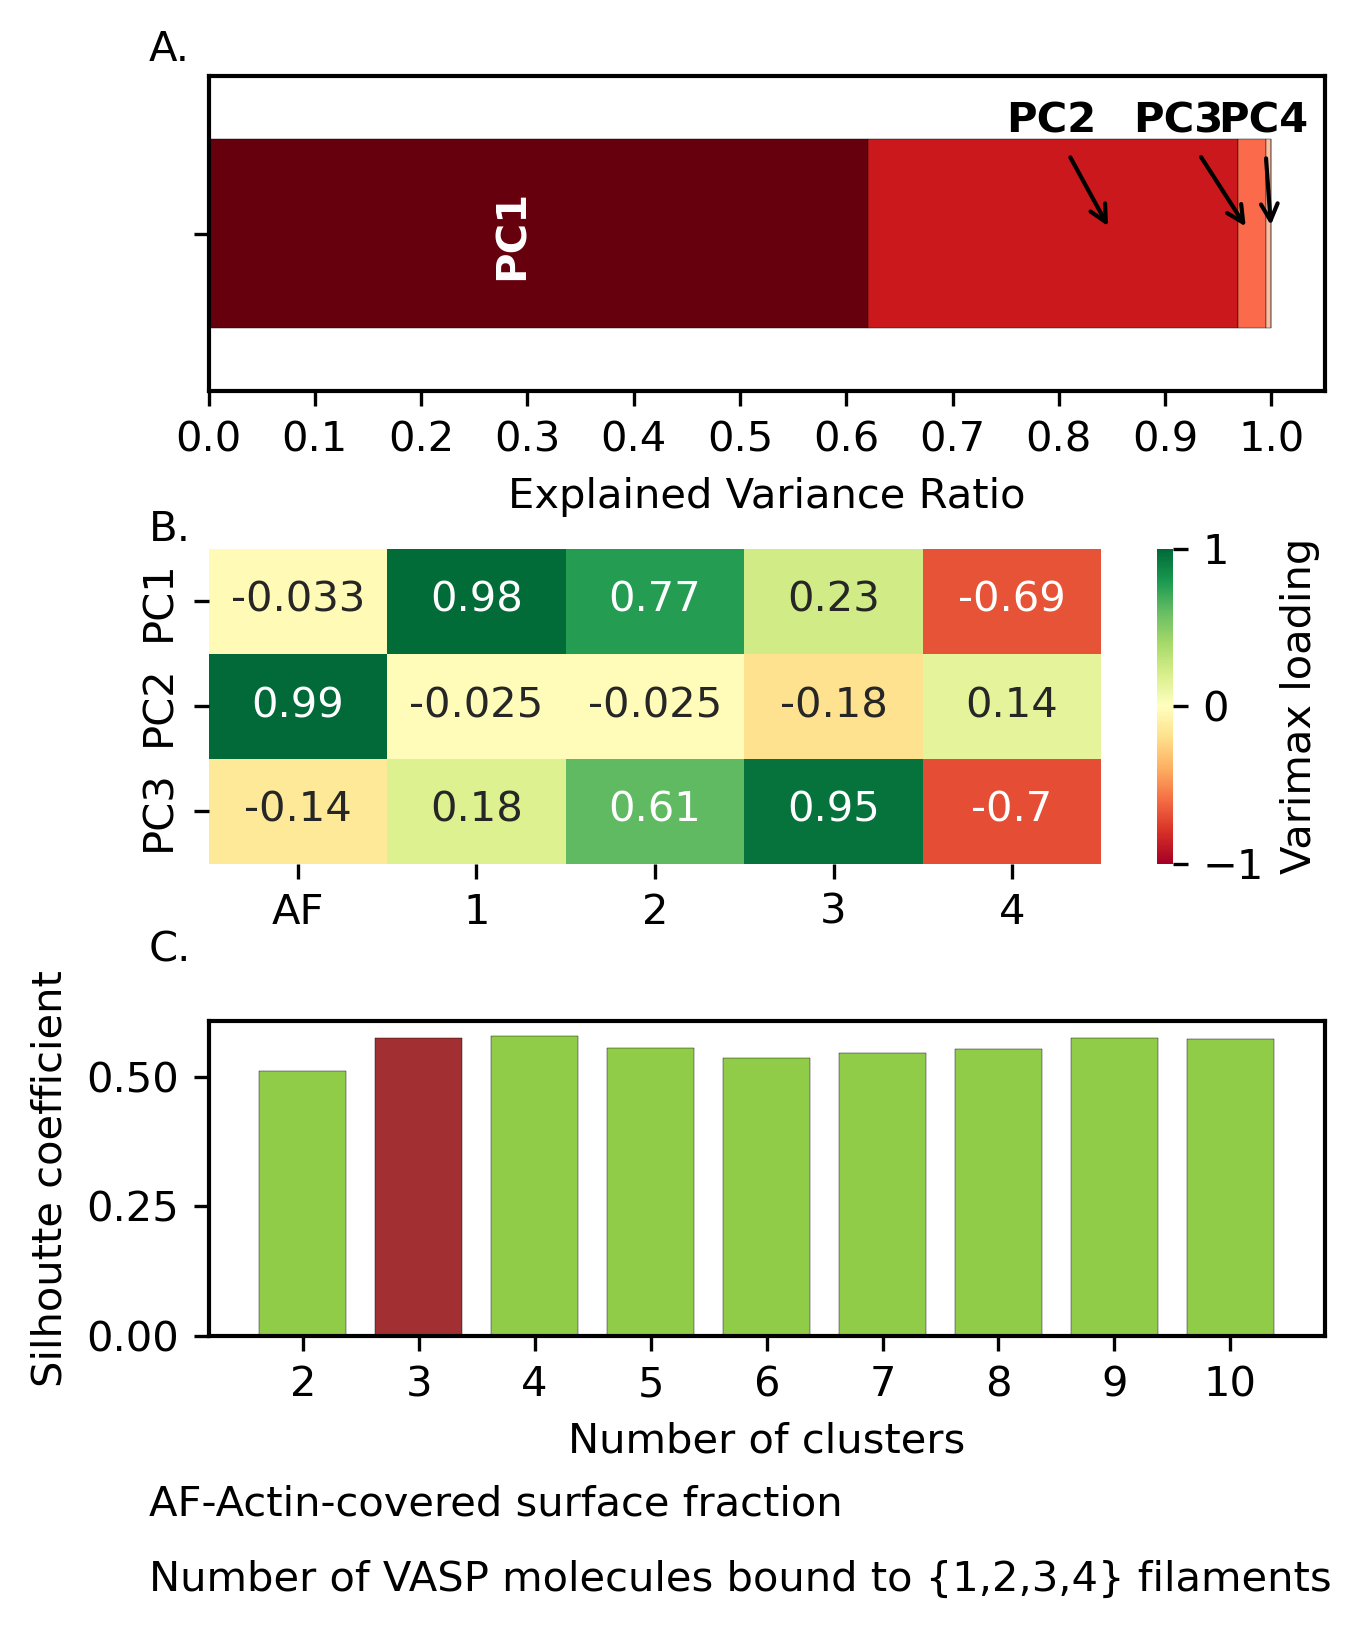

In [10]:
# retlist = retlist = obtaindata_GAB(jointKmeans)
# for i in range(0,len(retlist)):
#     FORow1 = retlist[0]
#     Row9 = retlist[1]
#     Row11 = retlist[2]
#     Row13 = retlist[3]
#     Row15 = retlist[4]
#     imagelist = retlist[5]
#     taglist = retlist[6]
# df_V2 = pd.DataFrame({'Actin occupied Surface Fraction':np.transpose(FORow1), 
#                       '1':np.transpose(Row9),
#                       '2':np.transpose(Row11), 
#                       '3':np.transpose(Row13), 
#                       '4':np.transpose(Row15)})
fig, axvec = plt.subplots(nrows=3, ncols=1,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.15, 
                    top=0.99,
                    wspace=0.2, 
                    hspace=0.5)
# On Raw data
pca = PCA()
pca.fit_transform(df_V2)
# eratio = pca.explained_variance_ratio_
# print(np.cumsum(eratio))
# ax = axvec[0]
# ax.bar(range(1,6),eratio)
# ax.plot(range(1,6),np.cumsum(eratio))
# # On rescaled data
#pipe2["preprocessor"]["pca"].n_components = 6
pipe2.fit(df_V2)
pipe2["preprocessor"].transform(df_V2)
# Get the PCA data 
pipe2["preprocessor"]["pca"].n_components = 5
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["component_1", "component_2", "component_3"],
)
feature_names = ['SF','1','2','3','4','Nfil']
#eratio = pipe2["preprocessor"]["pca"].explained_variance_ratio_
eratio = pca.explained_variance_ratio_
print('Explained variance=')
print(pca.explained_variance_)
print('Explained variance ratio=')
print(np.cumsum(eratio))
#ax.bar(range(1,6),eratio)
#ax.bar(range(1,6),np.cumsum(eratio),'stacked')
df = pd.DataFrame(eratio,index=['PC1','PC2','PC3','PC4','PC5'])
df = df.transpose()
print(df)
ax=axvec[0]
df.plot(ax=ax,kind='barh', stacked=True,legend=False, 
        width = 0.75, cmap='Reds_r',
        edgecolor = "black", linewidth=0.1)
y_offset=0.1
locpos = [0.57288853/2]
print(locpos)
for i, total in enumerate(locpos):
  ax.text(total, -0.15, 'PC'+str(i+1), ha='center',
          weight='bold',rotation=90, color='white')
  
  if jointKmeans:
    ax.annotate('PC2', xy=(0.85,0.0), xytext=(0.75, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC3', xy=(0.98,0.0), xytext=(0.87, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC4', xy=(1.0,0.0), xytext=(0.95, 0.4), weight='bold',
        arrowprops=dict(facecolor='black', arrowstyle="->"))
  else:
    ax.annotate('PC2', xy=(0.93,0.0), xytext=(0.75, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC3', xy=(1.01,0.0), xytext=(0.9, 0.4), weight='bold',
                arrowprops=dict(facecolor='black', arrowstyle="->"))
    ax.annotate('PC4', xy=(1.02,0.0), xytext=(0.96, 0.4), weight='bold',
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.set_xlabel('Explained Variance Ratio')
ax.set_xticks(0.1*np.arange(0,11))
ax.set_yticklabels('')
#################################
# VARIMAX HEATMAP
ax1=axvec[1]
varimaxpipe['Varimax FA']['varimax'].n_components = 3
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=3, method='principal', rotation="varimax")
fa.fit(df_V2)
print(fa.loadings_.round(2))
print('The raw data correlation matrix')
print(fa.corr_)
print(fa.rotation_matrix_)
print('norm')
print(np.linalg.norm(pcadf, axis=0 ))
# print(np.linalg.norm(np.matmul(pcadf,fa.rotation_matrix_), axis=0 ))
df = pd.DataFrame(fa.loadings_.T,index=['PC1','PC2','PC3'],columns=['AF','1','2','3','4'])
fig.text(0.0,0.03,'AF-Actin-covered surface fraction')
fig.text(0.0,-0.02,'Number of VASP molecules bound to {1,2,3,4} filaments')
print(df)
sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=-1.0, vmax=1.0, ax=ax1,
    cbar_kws={'label': 'Varimax loading'})
##################################
# Empty lists to hold evaluation metrics
silhouette_scores = []
pipe2["preprocessor"]["pca"].n_components = 2
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe2["clusterer"]["kmeans"].n_clusters = n
    pipe2.fit(df_V2)
    model = pipe2.steps
    silhouette_coef = silhouette_score(
        pipe2["preprocessor"].transform(df_V2),
        pipe2["clusterer"]["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
print(silhouette_scores)
ax2=axvec[2]
ax2.bar(range(2,11),silhouette_scores, 
            color=['#90CC47', "#a22f31",'#90CC47','#90CC47','#90CC47','#90CC47','#90CC47', '#90CC47','#90CC47','#90CC47','#90CC47',],
            width = 0.75, edgecolor = "black", linewidth=0.1)
#ax2.set_ylim([0.6,1])
ax2.set_ylabel('Silhoutte coefficient')
ax2.set_xlabel('Number of clusters')
ax2.set_xticks([2,3,4,5,6,7,8,9,10])
##########
fig.text(0.0,1.0,'A.')
fig.text(0.0,0.68,'B.')
fig.text(0.0,0.4,'C.')
########### SAVE
# if jointKmeans:
#     plt.savefig('Joint_T2piR_Cluster_analysis_30nm.png', dpi=300, bbox_inches='tight')
#     fig.savefig( 'Joint_T2piR_Cluster_analysis_30nm.pdf', bbox_inches='tight')
# else:
plt.savefig('Actin_VASP_check.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Actin_VASP_check.pdf', bbox_inches='tight')

## FIT

In [224]:
pipe2["preprocessor"]["pca"].n_components = 2
pipe2["clusterer"]["kmeans"].n_clusters = 3
pipe2.fit(df_V2)
# Get the PCA data 
pcadf = pd.DataFrame(
    pipe2["preprocessor"].transform(df_V2),
    columns=["PC1", "PC2"],
)
feature_names = ['SF','1','2','3','4']
#
varimaxpipe.fit(df_V2)
components = varimaxpipe['Varimax FA']['varimax'].components_
print(varimaxpipe['Varimax FA']['varimax'])
print(components)
pcadf["Predicted Cluster"] = (pipe2["clusterer"]["kmeans"]).labels_.astype(str)
pcadf["images"] = imagelist
pcadf["tag"] = taglist
centers = np.array( pipe2["clusterer"]["kmeans"].cluster_centers_)
pcadf.to_csv('Actin_VASP_ratio.csv')

FactorAnalysis(n_components=3, rotation='varimax')
[[-0.08097271  0.07185609  0.16235792  0.24171355 -0.23231262]
 [ 0.00410118  0.15960946  0.1206961   0.00381673 -0.14178501]
 [-0.12320411 -0.0088064  -0.03439669  0.02652339 -0.02078676]]


## PLOTLY

In [299]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import base64
import numpy as np
# Create dash app
app = dash.Dash(__name__)
# Generate dataframe
kmdf = pd.read_csv('Actin_VASP_ratio.csv',index_col=0)
kmdf["Predicted Cluster"] = kmdf["Predicted Cluster"].astype(str)
fig = px.scatter(kmdf, x="PC1", 
                 y="PC2",
                 custom_data=["images"],color="Predicted Cluster",
                 hover_name="tag")
fig.update_layout(
    font=dict(
        family="Arial",
        size=18,  # Set the font size here
        color="Black"
    )
)

# Update layout and update traces
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=5)

# Create app layout to show dash graph
app.layout = html.Div(
   [
      dcc.Graph(
         id="graph_interaction",
         figure=fig,
      ),
      html.Img(id='image', src='')
   ]
)

# html callback function to hover the data on specific coordinates
@app.callback(
   Output('image', 'src'),
   Input('graph_interaction', 'hoverData'))

def open_url(hoverData):
   if hoverData:
      return hoverData["points"][0]["customdata"][0]
   else:
      raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Dec/2023 17:43:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:07] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [15/Dec/2023 17:43:07] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [15/Dec/2023 17:43:07] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:08] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:08] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [15/Dec/2023 17:43:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Dec/2023 17:43:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15

## FIGUE S11D Cluster statistics

Cluster id =0
[5]
   vconc  Nfil  Probability
0    2.0  30.0     0.166667
----------
Cluster id =1
[10 24 30  5 15 30 20]
   vconc   Nfil  Probability
0    0.4   75.0     0.333333
1    0.4  120.0     0.800000
2    0.4  165.0     1.000000
3    0.8   75.0     0.166667
4    0.8  120.0     0.500000
5    0.8  165.0     1.000000
6    2.0  165.0     0.666667
----------
Cluster id =2
[30 20  6 30 25 15 25 30 30  5]
   vconc   Nfil  Probability
0    0.4   30.0     1.000000
1    0.4   75.0     0.666667
2    0.4  120.0     0.200000
3    0.8   30.0     1.000000
4    0.8   75.0     0.833333
5    0.8  120.0     0.500000
6    2.0   30.0     0.833333
7    2.0   75.0     1.000000
8    2.0  120.0     1.000000
9    2.0  165.0     0.166667
----------


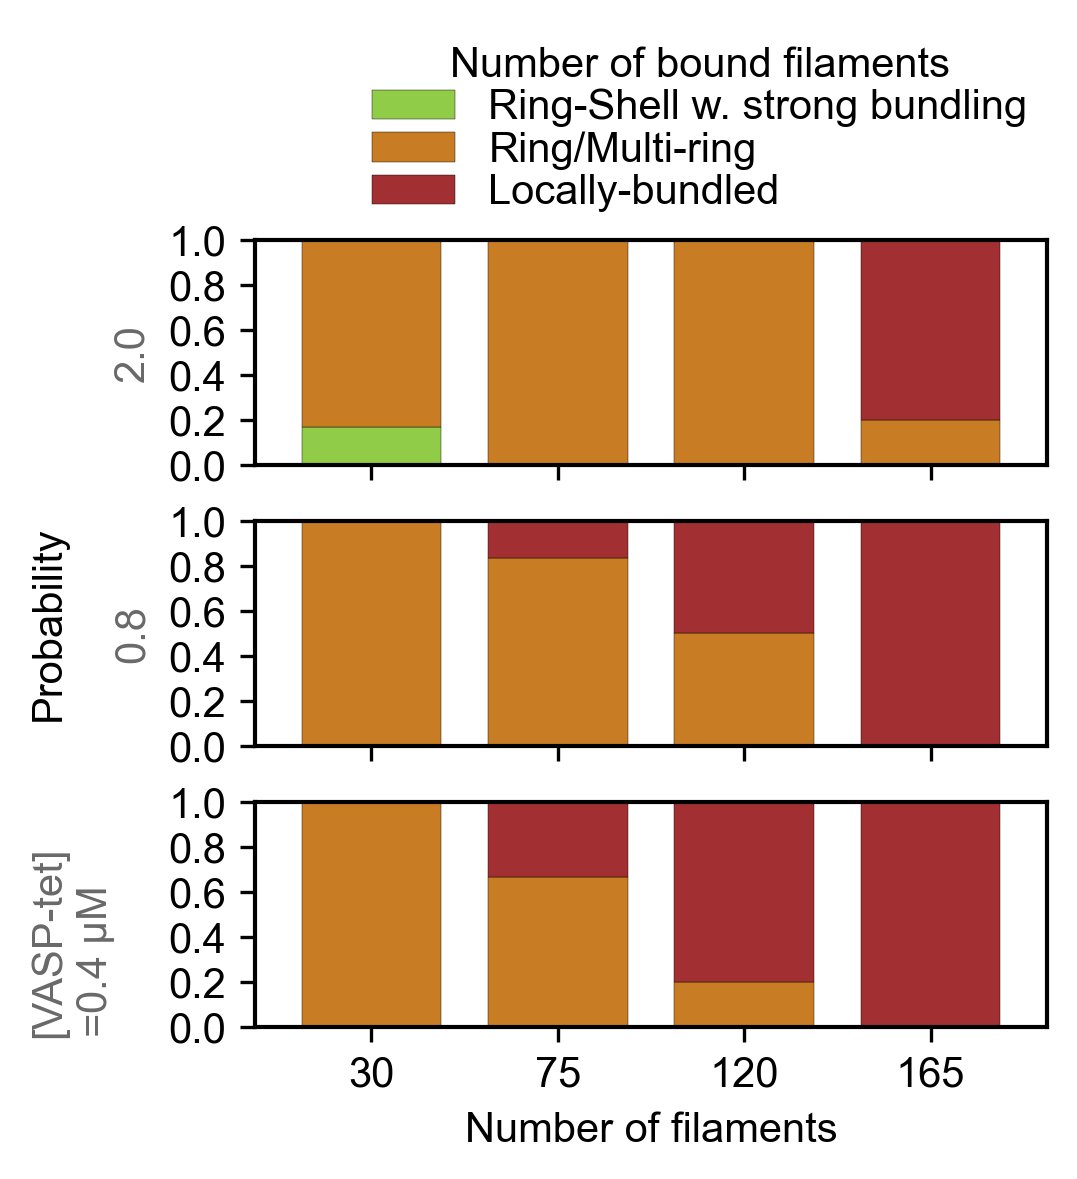

In [218]:
#0 Ring-like
#1 spatially localized bunding
#2 Ring/Multi ring
jointKmeans = True
Nreps = 6
Nsnaps = 5
kmdf = pd.read_csv('Actin_VASP_ratio.csv',index_col=0)
resultvec=[];
for tag in ['Actin:VASP']:
    if tag == 'kinetics':
        Nframes = 15
    else:
        Nframes = Nreps*Nsnaps
    for clusterid in range(0,3):
        print('Cluster id ='+str(clusterid))
        X=kmdf.loc[kmdf["Predicted Cluster"] == clusterid]
        Y=(X.loc[:,["tag"]]).to_numpy()
        #print(Y.filter(like='kinetics'))
        Z = [];
        for yiter, y in enumerate(Y):
            a=y[0]
            b=a.split(",")
            if tag in b[0][:]:
                Z.append([float(b[1][1:]), float(b[2][:])])
        if Z:
            Z = np.asarray(Z)
            unique_rows, counts = np.unique(Z, axis=0, return_counts=True)
            result = pd.DataFrame({'vconc': unique_rows[:,0],
                                'Nfil':unique_rows[:,1],
                                'Probability':counts/Nframes})
            print(counts)
            resultvec.append(result)
            print(result.to_string())
            print("----------")
    print('==============')
###########
Nfillocal=[30,75,120,165]
fig, axvec = plt.subplots(nrows=3, ncols=1,figsize=(3.0,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=False)
plt.subplots_adjust(left=0.1,
                    right=0.98,
                    bottom=0.05, 
                    top=0.8,
                    wspace=0.15, 
                    hspace=0.25)
for vconciter, vconc in enumerate(Vasp_conc):
    probmat=np.zeros((len(Nfillocal),3))
    for niter, nval in enumerate (Nfillocal):
        for citer,cid in enumerate([0,2,1]):
            cfactor =1;
            if nval==165 and vconc==2.0:
                cfactor=30/25;
            result1=resultvec[cid];
            X=result1[(result1.vconc==vconc) & (result1.Nfil==nval)]
            if len(X):
                probmat[niter][citer]=X['Probability'].to_numpy()[0]*cfactor
        df=pd.DataFrame({'Nfil':Nfillocal,
                         '0':probmat[:,0],
                         '1':probmat[:,1],
                         '2':probmat[:,2],})
    ax = axvec[2-vconciter]
    df.plot(ax=ax,x='Nfil',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)   
        
    # Beautify
    ax.set_xticklabels(Nfillocal,rotation = 0)
    ax.set_xlabel('Number of filaments')
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])

#axvec[2].set_ylabel()
axvec[1].set_ylabel('0.8',color='dimgray')
axvec[0].set_ylabel('2.0',color='dimgray')
plt.text(-0.15, 0.05, r'[VASP-tet]' +'\n'+ '=0.4 $\mu M$', 
         color='dimgray', transform=plt.gcf().transFigure, rotation=90)
plt.text(-0.15, 0.35, 'Probability', transform=plt.gcf().transFigure, rotation=90)
leg = fig.legend(['Ring-Shell w. strong bundling','Ring/Multi-ring','Locally-bundled'],title='Number of bound filaments',ncol=1,fontsize=10,frameon=False,
                bbox_to_anchor=(1.0, 1.02), labelspacing=0.1,columnspacing=0)
plt.savefig('Actin_VASP_cluster_probability.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Actin_VASP_cluster_probability.pdf', bbox_inches='tight')
                

## FIGURE S11C PLOT clusters

[[ 0.69797691  0.17217061]
 [-0.43246192  0.29876855]
 [-0.06110629 -0.2315255 ]]
0
Shell w. strong bundling
['Actin:VASP', 2.0, 30, 3, 595]
["['Actin:VASP'", ' 2.0', ' 30', ' 3', ' 595]']
----
1
Ring/Multi-ring
['Actin:VASP', 0.8, 120, 0, 596]
["['Actin:VASP'", ' 0.8', ' 120', ' 0', ' 596]']
----
2
Locally-bundled
['Actin:VASP', 0.4, 30, 0, 596]
["['Actin:VASP'", ' 0.4', ' 30', ' 0', ' 596]']
----
Closest point in each cluster
[array([ 0.42813622, -0.14816708]), array([-0.40258791,  0.28613602]), array([-0.02643873, -0.2191203 ])]
Farthest point in each cluster
[array([ 0.40991473, -0.15757696]), array([-0.44232696, -0.09909279]), array([ 0.38021901, -0.27519893])]


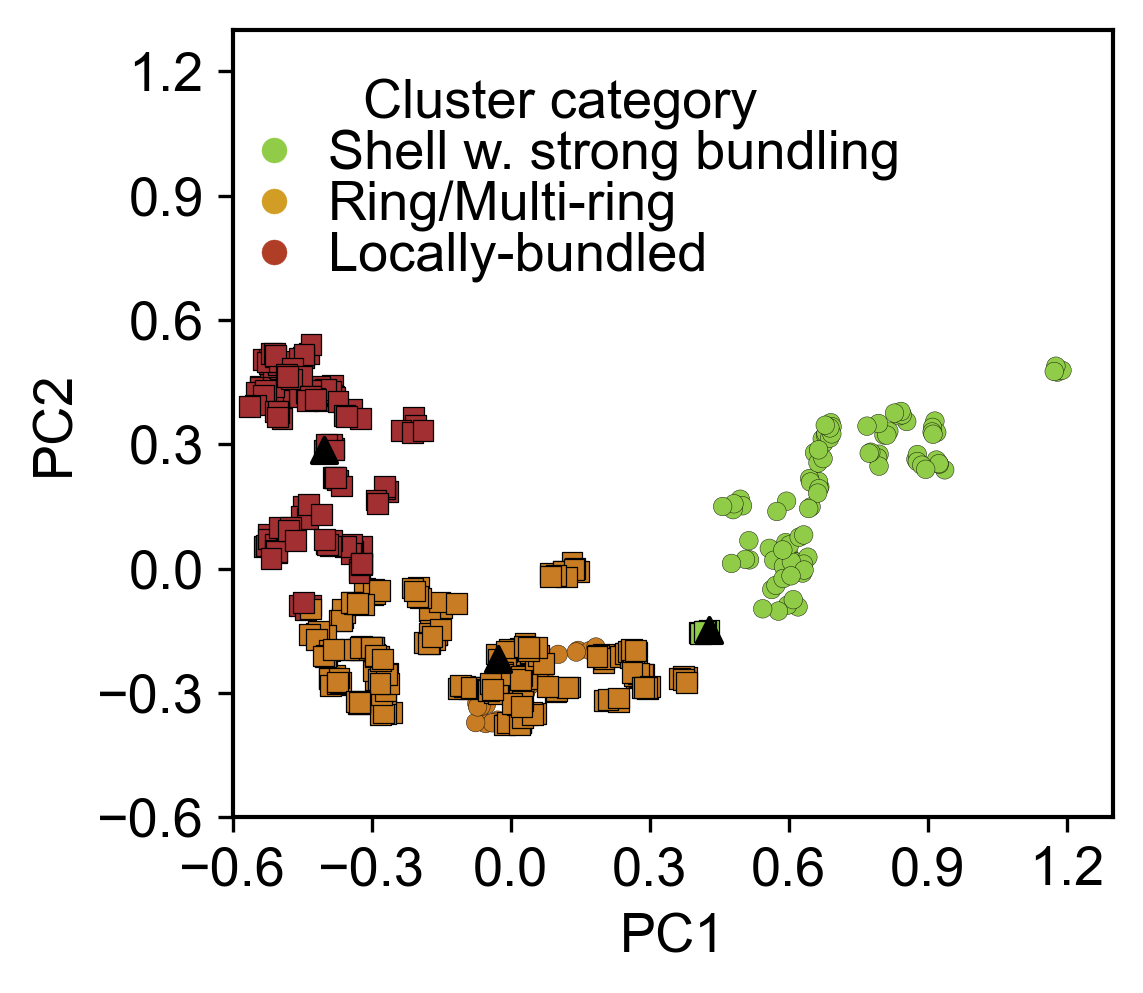

In [225]:
extendedflag = True
# Generate dataframe
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
from sklearn.metrics import pairwise_distances_argmin_min , pairwise_distances
plt.rcParams.update({'font.size': 13, 'font.family':'arial', 'font.weight':'normal'})
#0 Ring-like
#1 spatially localized bunding
#2 Ring/Multi ring
kmdf = pd.read_csv('Actin_VASP_ratio.csv',index_col=0)
# Ring/Multi-ring
kmdf.loc[kmdf["Predicted Cluster"] ==2, "Predicted Cluster"] = 3
# Ring-like
kmdf.loc[kmdf["Predicted Cluster"] ==1, "Predicted Cluster"] = 2
# Spatially-localized bundling
kmdf.loc[kmdf["Predicted Cluster"] ==3, "Predicted Cluster"] = 1
#print(np.unique(kmdf["Predicted Cluster"]))
cluster_string = ['Shell w. strong bundling','Ring/Multi-ring','Locally-bundled']

fig, axvec = plt.subplots(nrows=1, ncols=1,figsize=(4.0,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
scatter = axvec.scatter(data=kmdf, x="PC1", y="PC2",c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.1, s=20.0)
subdf = kmdf[kmdf['tag'].str.contains('Actin:VASP')]
scatter2 = axvec.scatter(data=subdf, x="PC1", y="PC2", c="Predicted Cluster", cmap=new_cmap, 
            edgecolors='black', linewidths=0.3, s=25.0, marker='s')
X=list(scatter.legend_elements(num=3))
if extendedflag == False:
    print('DO NOT USE THIS... NOT ACCURATE...')
    X[1] = cluster_string
else:
    X[1]=cluster_string
legend1 = axvec.legend(X[0],X[1],frameon=False,bbox_to_anchor=(-0.07,1.0),
                    loc="upper left", title="Cluster category", labelspacing=0.0,handletextpad=0.)
axvec.set_xlim([-0.6,1.3])
axvec.set_ylim([-0.6, 1.3])
axvec.set_xticks([-0.6,-0.3,0.0,0.3,0.6,0.9,1.2])
axvec.set_yticks([-0.6,-0.3,0.0,0.3,0.6,0.9,1.2])
centers = np.array( pipe2["clusterer"]["kmeans"].cluster_centers_)
print(centers)
reordered_cluster=[0,2,1]
closest_point = []
farthest_point = []
for i, ccoord in enumerate(centers):
    print(i)
    print(cluster_string[i])
    subdata = subdf.loc[kmdf['Predicted Cluster'] == reordered_cluster[i]]
    tag = subdata['tag'].to_numpy()
    subdata = subdata[['PC1','PC2']].to_numpy()
    distances= pairwise_distances([ccoord],subdata,)
    index_min = np.argmin(distances)
    index_max = np.argmax(distances)
    closest_point.append(subdata[index_min,:])
    farthest_point.append(subdata[index_max,:])
    print(tag[index_min])
    b=tag[index_min].split(",")
    print(b)
    # print(utilityN1e3(float(b[0][1:]), float(b[1][:])))
    #print(tag[index_max])
    b=tag[index_max].split(",")
    #print(utilityN1e3(float(b[0][1:]), float(b[1][:])))
    print('----')
# Plot centers
print("Closest point in each cluster")
print(closest_point)
print("Farthest point in each cluster")
print(farthest_point)
#axvec.scatter(centers[:,0],centers[:,1],c='black',marker='X')
closest_point=np.array(closest_point)
farthest_point=np.array(farthest_point)

#axvec.scatter(centers[:,0],centers[:,1],c='black',marker='o')
axvec.scatter(closest_point[:,0],closest_point[:,1],c='black',marker='^')
#axvec.scatter(farthest_point[:,0],farthest_point[:,1],c='black',marker='v')
# Plot closest point
axvec.set_xlabel('PC1')
axvec.set_ylabel('PC2')
# ########### SAVE
fig.tight_layout()
plt.savefig('Actin_VASP_cluster_graph.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Actin_VASP_cluster_graph.pdf', bbox_inches='tight')

## PLOT BAR PLOT

In [11]:
# KEY
# Row 0 Time
# Row 1 Number of bound crosslinkers MEAN
# Row 2 Number of bound crosslinkers STD
# Row 3 Number of filaments per crosslinker MEAN
# Row 4 Number of filaments per crosslinker STD
# Row 5 Number of UNIQIUE filaments per crosslinker MEAN
# Row 6 Number of UNIQUE filaments per crosslinker STD
# Row 7 Last 5% data Row 5 MEAN
# Row 8 Last 5% data Row 5 STD
# Row 9 Number of VASP bound to 1 filament MEAN
# Row 10 Number of VASP bound to 1 filament STD
# Row 11 Number of VASP bound to 2 filaments MEAN
# Row 12 Number of VASP bound to 2 filaments STD
# Row 13 Number of VASP bound to 3 filaments MEAN
# Row 14 Number of VASP bound to 3 filaments STD
# Row 15 Number of VASP bound to 4 filaments MEAN
# Row 16 Number of VASP bound to 4 filaments STD
# Row 17 5% data Number of VASP bound to N \in [1,4] filaments MEAN
# Row 18 5% data  Number of VASP bound to N \in [1,4] filaments STD
# LOAD
# Extract
# Plot 1 row, 5 column plots 
# Each plot has 7 colors 
FORow1=np.array([])
Meanlist=[];
Stdlist=[];
mean_frac_bar=[];
std_frac_bar=[];
Row1=[]
Row2=[]
Row3=[]
Row4=[]
Row5=[]
Row6=[]
Row7=[]
Row8=[]
Row17=[]
Row18=[]
Mean_0_fil = []
Mean_1_fil = []
Mean_2_fil = []
Mean_3_fil = []
Mean_4_fil = []
Std_0_fil = []
Std_1_fil = []
Std_2_fil = []
Std_3_fil = []
Std_4_fil = []
Nreps = 6
Vasp_conc = [0.4,0.8,2.0]
Vasp_conc = [0.4, 0.8,2.0]
TotalVASP = [1000, 2018, 5044]
Nfil = [30,75,120,165,210]
###
for vconciter, vconc in enumerate(Vasp_conc):
    for niter, nval in enumerate (Nfil):
        Rval = niter+vconciter*len(Nfil)
        # if Rval==14 or Rval==9 or Rval==4:
        #     continue;
        bar_raw_data = np.array([])
        Row1=[]
        bar_data_1 = np.array([])
        bar_data_2 = np.array([])
        bar_data_3 = np.array([])
        bar_data_4 = np.array([])
        tv = TotalVASP[vconciter]
        for repid in range(0,Nreps):
            fvar = filereadpath+'/Crosslink_Actin_VASP_ratio_set4_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            df = pd.read_csv(fvar,index_col=0)
            Row1.append(df.iloc[1].to_numpy())
            Row2.append(df.iloc[2].to_numpy())
            Row3.append(df.iloc[3].to_numpy())
            Row4.append(df.iloc[4].to_numpy())
            Row5.append(df.iloc[5].to_numpy())
            Row6.append(df.iloc[6].to_numpy())
            Row7.append(df.iloc[7].to_numpy())
            Row8.append(df.iloc[8].to_numpy())
            ##
            Row9 = df.iloc[9].to_numpy()
            Row11 = df.iloc[11].to_numpy()
            Row13 = df.iloc[13].to_numpy()
            Row15 = df.iloc[15].to_numpy()
            startpos = int(0.95*len(Row9))
            endpos = int(len(Row9))
            bar_data_1 = np.append(bar_data_1,(Row9[startpos:endpos]/tv))
            bar_data_2 = np.append(bar_data_2,(Row11[startpos:endpos]/tv))
            bar_data_3 = np.append(bar_data_3,(Row13[startpos:endpos]/tv))
            bar_data_4 = np.append(bar_data_4,(Row15[startpos:endpos]/tv))
            ##
            Row17.append(df.iloc[17].to_numpy())
            Row18.append(df.iloc[18].to_numpy())
            ##################
        # Get the number of VASP that is free
        bar_data_0 = 1-bar_data_1-bar_data_2-bar_data_3-bar_data_4
        Mean_0_fil.append(np.mean(bar_data_0,0))
        Mean_1_fil.append(np.mean(bar_data_1,0))
        Mean_2_fil.append(np.mean(bar_data_2,0))
        Mean_3_fil.append(np.mean(bar_data_3,0))
        Mean_4_fil.append(np.mean(bar_data_4,0))
        Std_0_fil.append(np.std(bar_data_0,0))
        Std_1_fil.append(np.std(bar_data_1,0))
        Std_2_fil.append(np.std(bar_data_2,0))
        Std_3_fil.append(np.std(bar_data_3,0))
        Std_4_fil.append(np.std(bar_data_4,0))
Nfilvec = [30,75,120,165,210,
           30,75,120,165,210,
           30,75,120,165,210,]
Vconcvec = [0.4,0.4,0.4,0.4,0.4,
           0.8,0.8,0.8,0.8,0.8,
            2.0,2.0,2.0,2.0,2.0]
#################
Meanlist = []
Stdlist = []
mean_frac_bar = []
std_frac_bar = []
for vconciter, vconc in enumerate(Vasp_conc):
    for niter, nval in enumerate (Nfil):
        bar_raw_data = np.array([])
        Row1=[]
        Rval = niter+vconciter*len(Nfil)
        for repid in range(0,Nreps):
            fvar = filereadpath+'/FO_Actin_VASP_ratio_set4_R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            if os.path.isfile(fvar):
                df = pd.read_csv(fvar,index_col=0)
                datavec = df.iloc[1].to_numpy()
                Row1.append(datavec)
                barstartpos = int(0.95*len(datavec))
                bar_raw_data = np.append(bar_raw_data,datavec[barstartpos:])
            else:
                print('DOES NOT EXIST!')
        mean_frac_bar.append(np.mean(bar_raw_data))
        std_frac_bar.append(np.std(bar_raw_data))
print(mean_frac_bar)
#################
print(len(Vconcvec))
print(len(Mean_0_fil))
bardf = pd.DataFrame({'Vconc':Vconcvec, 'Nfilvec':Nfilvec,
                      '0':Mean_0_fil,'1':Mean_1_fil,
                    '2':Mean_2_fil,'3':Mean_3_fil,
                    '4':Mean_4_fil})
cumarray = np.zeros((5,len(Mean_0_fil)))
cumarray[0][:]=Mean_0_fil[:]
cumarray[1][:]=cumarray[0][:]+Mean_1_fil
cumarray[2][:]=cumarray[1][:]+Mean_2_fil
cumarray[3][:]=cumarray[2][:]+Mean_3_fil
cumarray[4][:]=cumarray[3][:]+Mean_4_fil
print((cumarray))
stddf = pd.DataFrame({})
Timevec = df.iloc[0].to_numpy()
print(bardf)


DOES NOT EXIST!
DOES NOT EXIST!
[0.20068254368279567, 0.3362924227150537, 0.5532205561155914, 0.6643355174731183, 0.7512936827956989, 0.08707157258064513, 0.23824554771505374, 0.43321782594086017, 0.7413474462365591, 0.8286752352150537, 0.07049311155913976, 0.1276514196908602, 0.21831947244623653, 0.4648087211277174, 0.5472067636986301]
15
15
[[-9.56989247e-04 -9.78494624e-04 -9.83870968e-04 -9.94623656e-04
  -1.00000000e-03 -4.42256253e-04 -4.79554973e-04 -4.92875944e-04
  -4.92875944e-04 -4.92875944e-04 -5.11626717e-05 -1.84398796e-04
  -1.97189464e-04 -1.95022929e-04  3.20953388e-03]
 [ 1.58602151e-03  1.39784946e-04  1.55913978e-04  3.76344086e-05
   2.15053763e-05  3.08780119e-03  4.10285921e-04  1.33209715e-04
   1.33209715e-04  6.39406631e-05  6.34950074e-03  1.24709012e-03
   2.22770800e-04  1.69163535e-04  9.08670367e-03]
 [ 3.88817204e-02  1.14623656e-02  8.45698925e-03  4.59139785e-03
   3.64516129e-03  5.72135725e-02  1.52551765e-02  8.95169283e-03
   7.65156601e-03  6.7750

### Prep bar plot data CORREPSONDING TO FIGURE S11 - NOT SHOWN IN PAPER

0
1
2
3
4
   Nfilvec         0         1         2         3         4
0       30 -0.000957  0.002543  0.037296  0.307984  0.653134
1       75 -0.000978  0.001118  0.011323  0.171758  0.816780
2      120 -0.000984  0.001140  0.008301  0.152403  0.839140
3      165 -0.000995  0.001032  0.004554  0.119511  0.875898
4      210 -0.001000  0.001022  0.003624  0.105409  0.890946
5
6
7
8
9
   Nfilvec         0         1         2         3         4
5       30 -0.000442  0.003530  0.054126  0.324835  0.617952
6       75 -0.000480  0.000890  0.014845  0.200872  0.783873
7      120 -0.000493  0.000626  0.008818  0.152664  0.838385
8      165 -0.000493  0.000626  0.007518  0.151196  0.841153
9      210 -0.000493  0.000557  0.006711  0.138594  0.854631
10
11
12
13
14
    Nfilvec         0         1         2         3         4
10       30 -0.000051  0.006401  0.078875  0.385139  0.529637
11       75 -0.000184  0.001431  0.033571  0.283648  0.681534
12      120 -0.000197  0.000420  0.012162  0.18

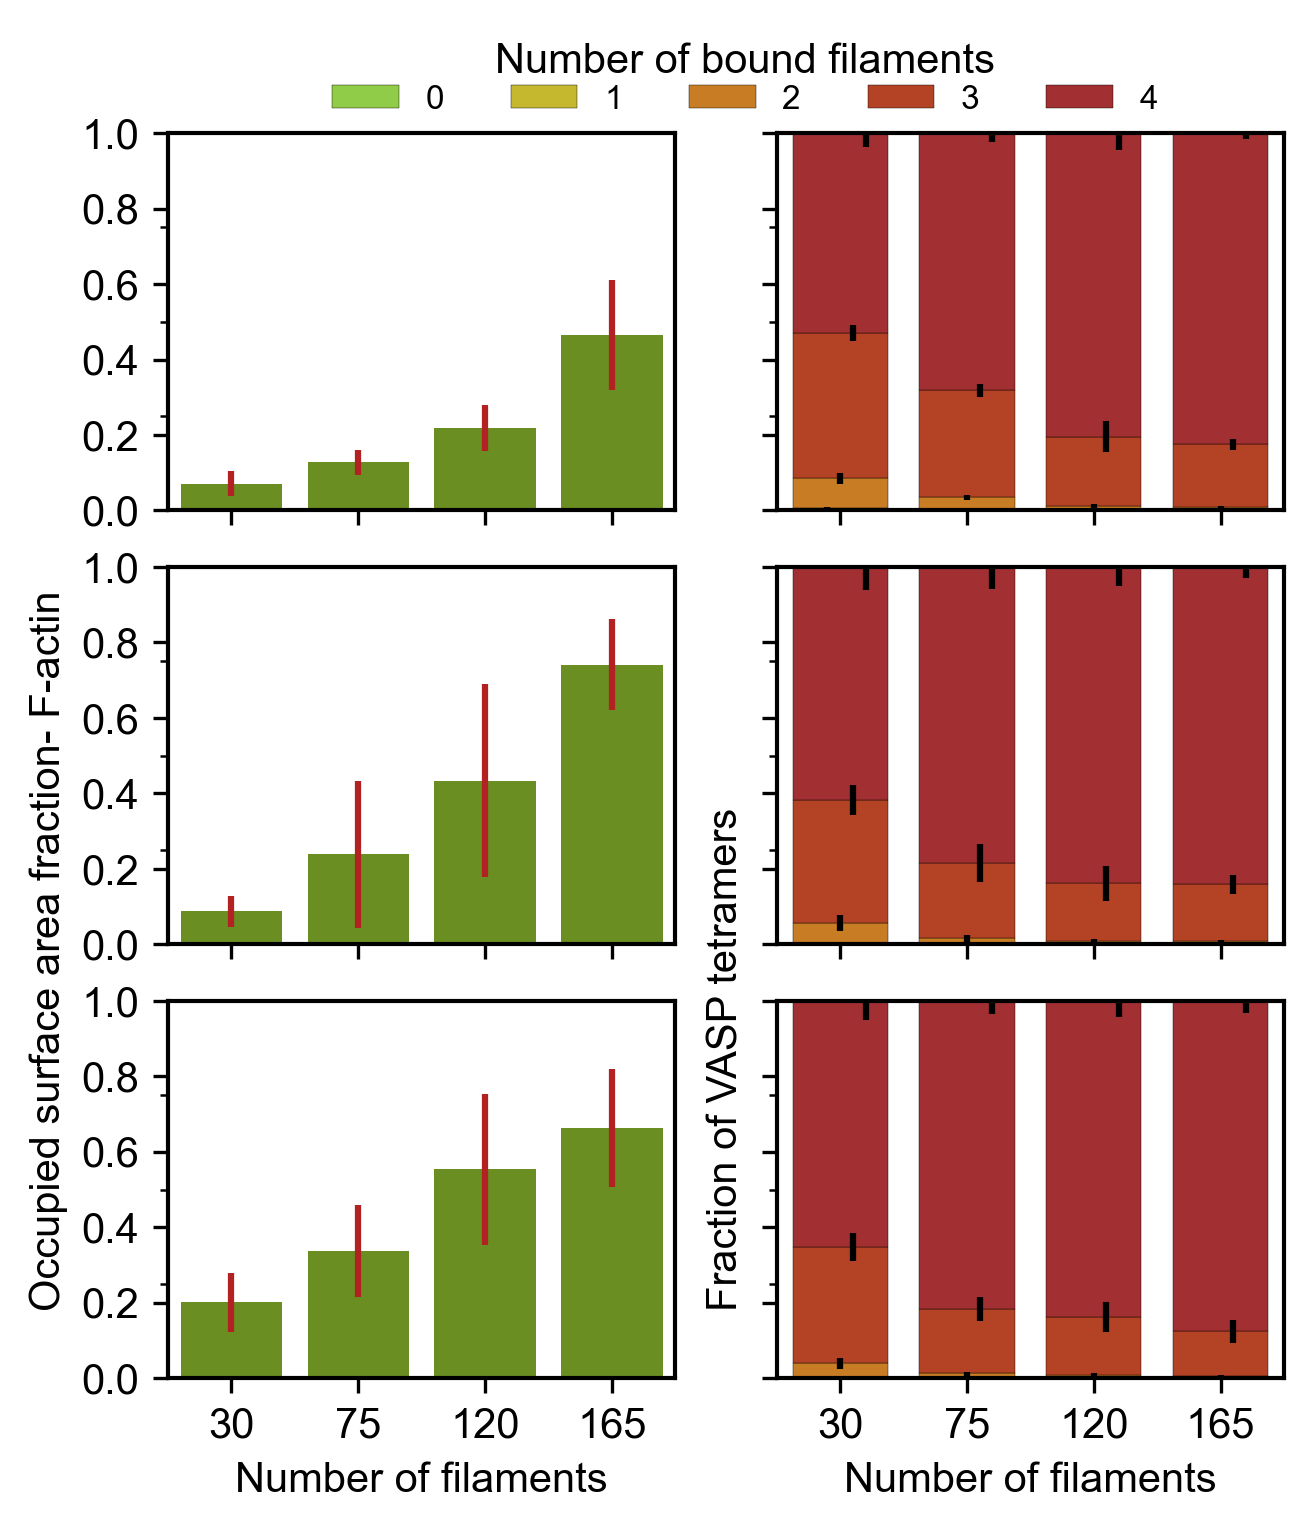

In [12]:

# Generate colors
import math
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
labelvec = [30,75,120,165,210]
ylabelvec =[0.4,0.8,2.0]
# Get figure
nr = 3; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(4.0,5.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.15)
# FIRST COLUMN
counter = 0;
for plotcounter in range(0,3):
    legcell = []
    df = pd.DataFrame()
    stddf=pd.DataFrame()
    stddatavec = []
    factor = 1e3
    Nvalency = 4
    for val in range(0,5):
        Rval = plotcounter*5+val
        Rval=counter;
        print(Rval)
        stddatavec.append(np.array([val-0.2, cumarray[0][Rval], Std_0_fil[Rval]]))
        offset = -0.1
        for pos in range(0,Nvalency):
            if pos ==0:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_1_fil[Rval]]))
            elif pos ==1:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_2_fil[Rval]]))
            elif pos ==2:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_3_fil[Rval]]))
            elif pos ==3:
                stddatavec.append(np.array([val+offset,
                                      cumarray[pos+1][Rval], Std_4_fil[Rval]]))
            offset = offset + 0.1
    #df.columns=labelvec
        counter=counter +1
    df =bardf[bardf["Vconc"]==Vasp_conc[plotcounter]].drop(columns = "Vconc")
    print(df)
    stddatavec = pd.DataFrame(np.array(stddatavec),columns=['x','mean','std'])
    # PLOT
    ax = axvec[nr-plotcounter-1][1]
    df.plot(ax=ax,x='Nfilvec',kind='bar', stacked=True,legend=False, 
            width = 0.75,
            cmap=new_cmap, edgecolor = "black", linewidth=0.1)
    ax.errorbar(stddatavec['x'],stddatavec['mean'],yerr=stddatavec['std'], fmt = 'o', markersize = 0, ecolor='black')
    # Beautify
    ax.set_xticklabels(labelvec, rotation = 0)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_xlabel(r'$T_{2\pi R_{drop}}$')
    ax.set_xlim([0,4])
    #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
leg = fig.legend(['0','1','2','3','4'],title='Number of bound filaments',ncol=5,fontsize=8,frameon=False,
                bbox_to_anchor=(0.9, 0.96), labelspacing=0.1)

plt.figtext(0.5, 0.1, 'Fraction of VASP tetramers', transform=plt.gcf().transFigure, rotation=90)

# SECOND COLUMN
for plotcounter in range(0,3):
    legcell = []
    ax = axvec[3-plotcounter-1][0]
    meandata = []
    stddata = []
    for l in range(plotcounter*5,(plotcounter+1)*5):
        meandata.append(mean_frac_bar[l])
        stddata.append(std_frac_bar[l])
    xvec = np.arange(0,len(meandata))
    ax.bar(xvec, meandata,color='olivedrab')
    ax.errorbar(xvec,meandata, yerr=stddata, fmt = 'o', markersize = 0, ecolor='firebrick')
    ax.set_xticks(np.arange(0,5))
    ax.set_xticklabels(Nfil)
    ax.set_xlim([-0.5,3.5])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[2][0].set_xlabel('Number of filaments')
axvec[2][1].set_xlabel('Number of filaments')
plt.figtext(-0.065,0.1, 'Occupied surface area fraction- F-actin', transform=plt.gcf().transFigure, rotation=90)
# SAVE
plt.savefig('Actin_VASP_bar.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Actin_VASP_bar.pdf', bbox_inches='tight')
#fig.tight_layout();

# LAMMPS code

In [2]:
def readLAMMPSfile(filename,atom_style):
    record = False;
    recordbond = False;
    Coord=[];
    Type1Coord=[];
    Type2Coord=[];
    Bond=[];
    fptr = open(filename,'r')
    #print(os.path.isfile(filename))
    for line in fptr:    
        if 'Atoms' in line:
            record=True;
        if 'Velocities' in line:
            record=False;
        if 'Bonds' in line:
            recordbond=True
            line = fptr.readline();
            line = fptr.readline();
        if 'Angles' in line:
            recordbond=False
            break;
        if record==True:
            if len(line)>0:
                splitline=line.split();
                #print(splitline)
                if len(splitline)<4:
                    continue;
                c=[];
                for i in range(0,np.min([len(splitline),7])):
                    c.append(float(splitline[i]))
                if atom_style=='full':
                    #print(splitline)
                    if (splitline[2]=='3') or (splitline[2]=='4') or (splitline[2]=='5'):
                        Coord.append(c);
                    elif splitline[2]=='1':
                        Type1Coord.append(c);
                    elif splitline[2]=='2':
                        Type2Coord.append(c);
                else:
                    if splitline[1]=='1':
                        Type1Coord.append(c);
                    elif splitline[1]=='2':
                        Type2Coord.append(c);
        
        if recordbond==True:
            if len(line.strip())>0:
                splitline=line.split();
                b=[];
                for idx in range(1,4):
                    b.append(splitline[idx]);
                Bond.append(b)
    fptr.close()
    Coord=np.array(Coord);
    Type1Coord=np.array(Type1Coord);
    Type2Coord=np.array(Type2Coord);
    df=[];
    if atom_style=='full':
        df=pd.DataFrame({'AtomID':Coord[:,0],
                        'molID':Coord[:,1],
                        'Atype':Coord[:,2],
                        'charge':Coord[:,3],
                        'CoordX':Coord[:,4],
                        'CoordY':Coord[:,5],
                        'CoordZ':Coord[:,6]})
        df = df.sort_values('AtomID')
        type1df=pd.DataFrame({'AtomID':Type1Coord[:,0],
                        'molID':Type1Coord[:,1],
                        'Atype':Type1Coord[:,2],
                        'charge':Type1Coord[:,3],
                        'CoordX':Type1Coord[:,4],
                        'CoordY':Type1Coord[:,5],
                        'CoordZ':Type1Coord[:,6]})
        
        type2df=pd.DataFrame({'AtomID':Type2Coord[:,0],
                        'molID':Type2Coord[:,1],
                        'Atype':Type2Coord[:,2],
                        'charge':Type2Coord[:,3],
                        'CoordX':Type2Coord[:,4],
                        'CoordY':Type2Coord[:,5],
                        'CoordZ':Type2Coord[:,6]})
    else:
        if(len(Coord)>0):
            df=pd.DataFrame({'AtomID':Coord[:,0],
                        'Atype':Coord[:,1],
                        'CoordX':Coord[:,2],
                        'CoordY':Coord[:,3],
                        'CoordZ':Coord[:,4]})
        type1df=pd.DataFrame({'AtomID':Type1Coord[:,0],
                    'Atype':Type1Coord[:,1],
                    'CoordX':Type1Coord[:,2],
                    'CoordY':Type1Coord[:,3],
                    'CoordZ':Type1Coord[:,4]})
        type2df=pd.DataFrame({'AtomID':Type2Coord[:,0],
                        'Atype':Type2Coord[:,1],
                        'CoordX':Type2Coord[:,2],
                        'CoordY':Type2Coord[:,3],
                        'CoordZ':Type2Coord[:,4]})
    #print(type1df)
    type1df = type1df.sort_values('AtomID')
    type2df = type2df.sort_values('AtomID')
    return [df, type1df, type2df]

In [29]:
def get_aspect_ratio(Coord):
    com=np.mean(Coord,0)
    print('com')
    print(com)
    R=Coord-com;
    #print(np.shape(R))
    normvec = np.linalg.norm(R,axis=1)
    #print([np.min(normvec),np.max(normvec)])
    Radialbinvec = np.linspace(0,85,85)
    dR=Radialbinvec[1]-Radialbinvec[0];
    Radialbincenter = Radialbinvec[0:len(Radialbinvec)-1]+(Radialbinvec[1]-Radialbinvec[0])
    hist, bin_edges  = np.histogram(normvec,bins=Radialbinvec,density=False)
    Rdensity=hist/(4*np.pi*np.power(Radialbincenter,2)*dR)
    #plt.plot(Radialbincenter,hist,marker='o')
    #print(Rdensity[0])
    Rinterface=Radialbincenter[np.argmax(Rdensity<0.05)]
    #print(Rinterface)
    locs=np.argwhere(normvec<=Rinterface)
    R_drop=np.zeros((len(locs),3));
    for liter, lval in enumerate(locs):
        R_drop[liter,:]=Coord[lval,:]
    #print(np.shape(R_drop))
    R2 = R_drop-np.mean(R_drop,0)
    normvec = np.linalg.norm(R2,axis=1)
    #print('Radius of gyration=')
    #print(np.sqrt(np.mean(np.power(normvec,2),0)))
    #print([np.min(normvec),np.max(normvec)])
    #plt.scatter(Coord[:,0],Coord[:,1],Coord[:,2],marker='o',linewidth=0)
    #plt.scatter(R_drop[:,0],R_drop[:,1],R_drop[:,2],marker='o',linewidth=0)
    R_drop = R_drop-np.mean(R_drop,0) # Coordinate
    #ax.scatter3D(R_drop[:,0],R_drop[:,1],R_drop[:,2],marker='o',linewidth=0,color='green',alpha=0.1)
    RTR=np.matmul(R_drop.T,R_drop)/20345 # Variance-covariance matrix
    #print(np.shape(R_drop))
    #print(RTR)
    eigenval, evec =np.linalg.eig(RTR)
    sorted_idx=np.argsort(eigenval)
    eigenval.sort()
    #print(sorted_idx)
    print('Eigenvalues=')
    print(eigenval)
    print('Radius of gyration')
    print(np.sqrt(np.sum(eigenval)))
    spans=[]
    for s in sorted_idx:
        X=np.dot(R_drop,evec[:,s].T)
        minval=np.min(X)
        maxval=np.max(X)
        spans.append((maxval-minval)/2)
    print(spans/np.min(spans))
    spans.sort();
    print((spans[2]*spans[2]/(spans[0]*spans[1]))**(1/3))
        #print([minval,maxval,(maxval-minval)/2])
    #asphericity=eigenval[2]-0.5*(eigenval[0]+eigenval[1])
    #print(asphericity)


In [27]:
fpath='/Users/aravind/Research/PostDoc/Research/CytoSim/LAMMPS_codes/cross_link/fil_6/'
dflist=readLAMMPSfile(fpath+'data.6x.NVT.10','full');
type1df = dflist[1];
Coord=type1df[['CoordX','CoordY','CoordZ']].to_numpy()
get_aspect_ratio(Coord)
##
fpath='/Users/aravind/Research/PostDoc/Research/CytoSim/LAMMPS_codes/cross_link/fil_6/'
dflist=readLAMMPSfile(fpath+'data.20x.NVT.10','full');
type1df = dflist[1];
Coord=type1df[['CoordX','CoordY','CoordZ']].to_numpy()
get_aspect_ratio(Coord)
# Plot density profile
# Filter droplet interface
# Calculate moment of inertia

com
[-2.17389265  1.71608239  1.77188873]
Eigenvalues=
[54.57560929 65.32596795 73.50974676]
Radius of gyration
13.907239985098384
[1.         1.03321278 1.06983175]
1.0346982897743076
com
[ -6.22279427 -14.56885624   2.90627164]
Eigenvalues=
[42.65958748 55.15625385 94.08728968]
Radius of gyration
13.852910561265155
[1.14181847 1.         1.18495684]
1.0713614134678469


## FIGURE S1E,F

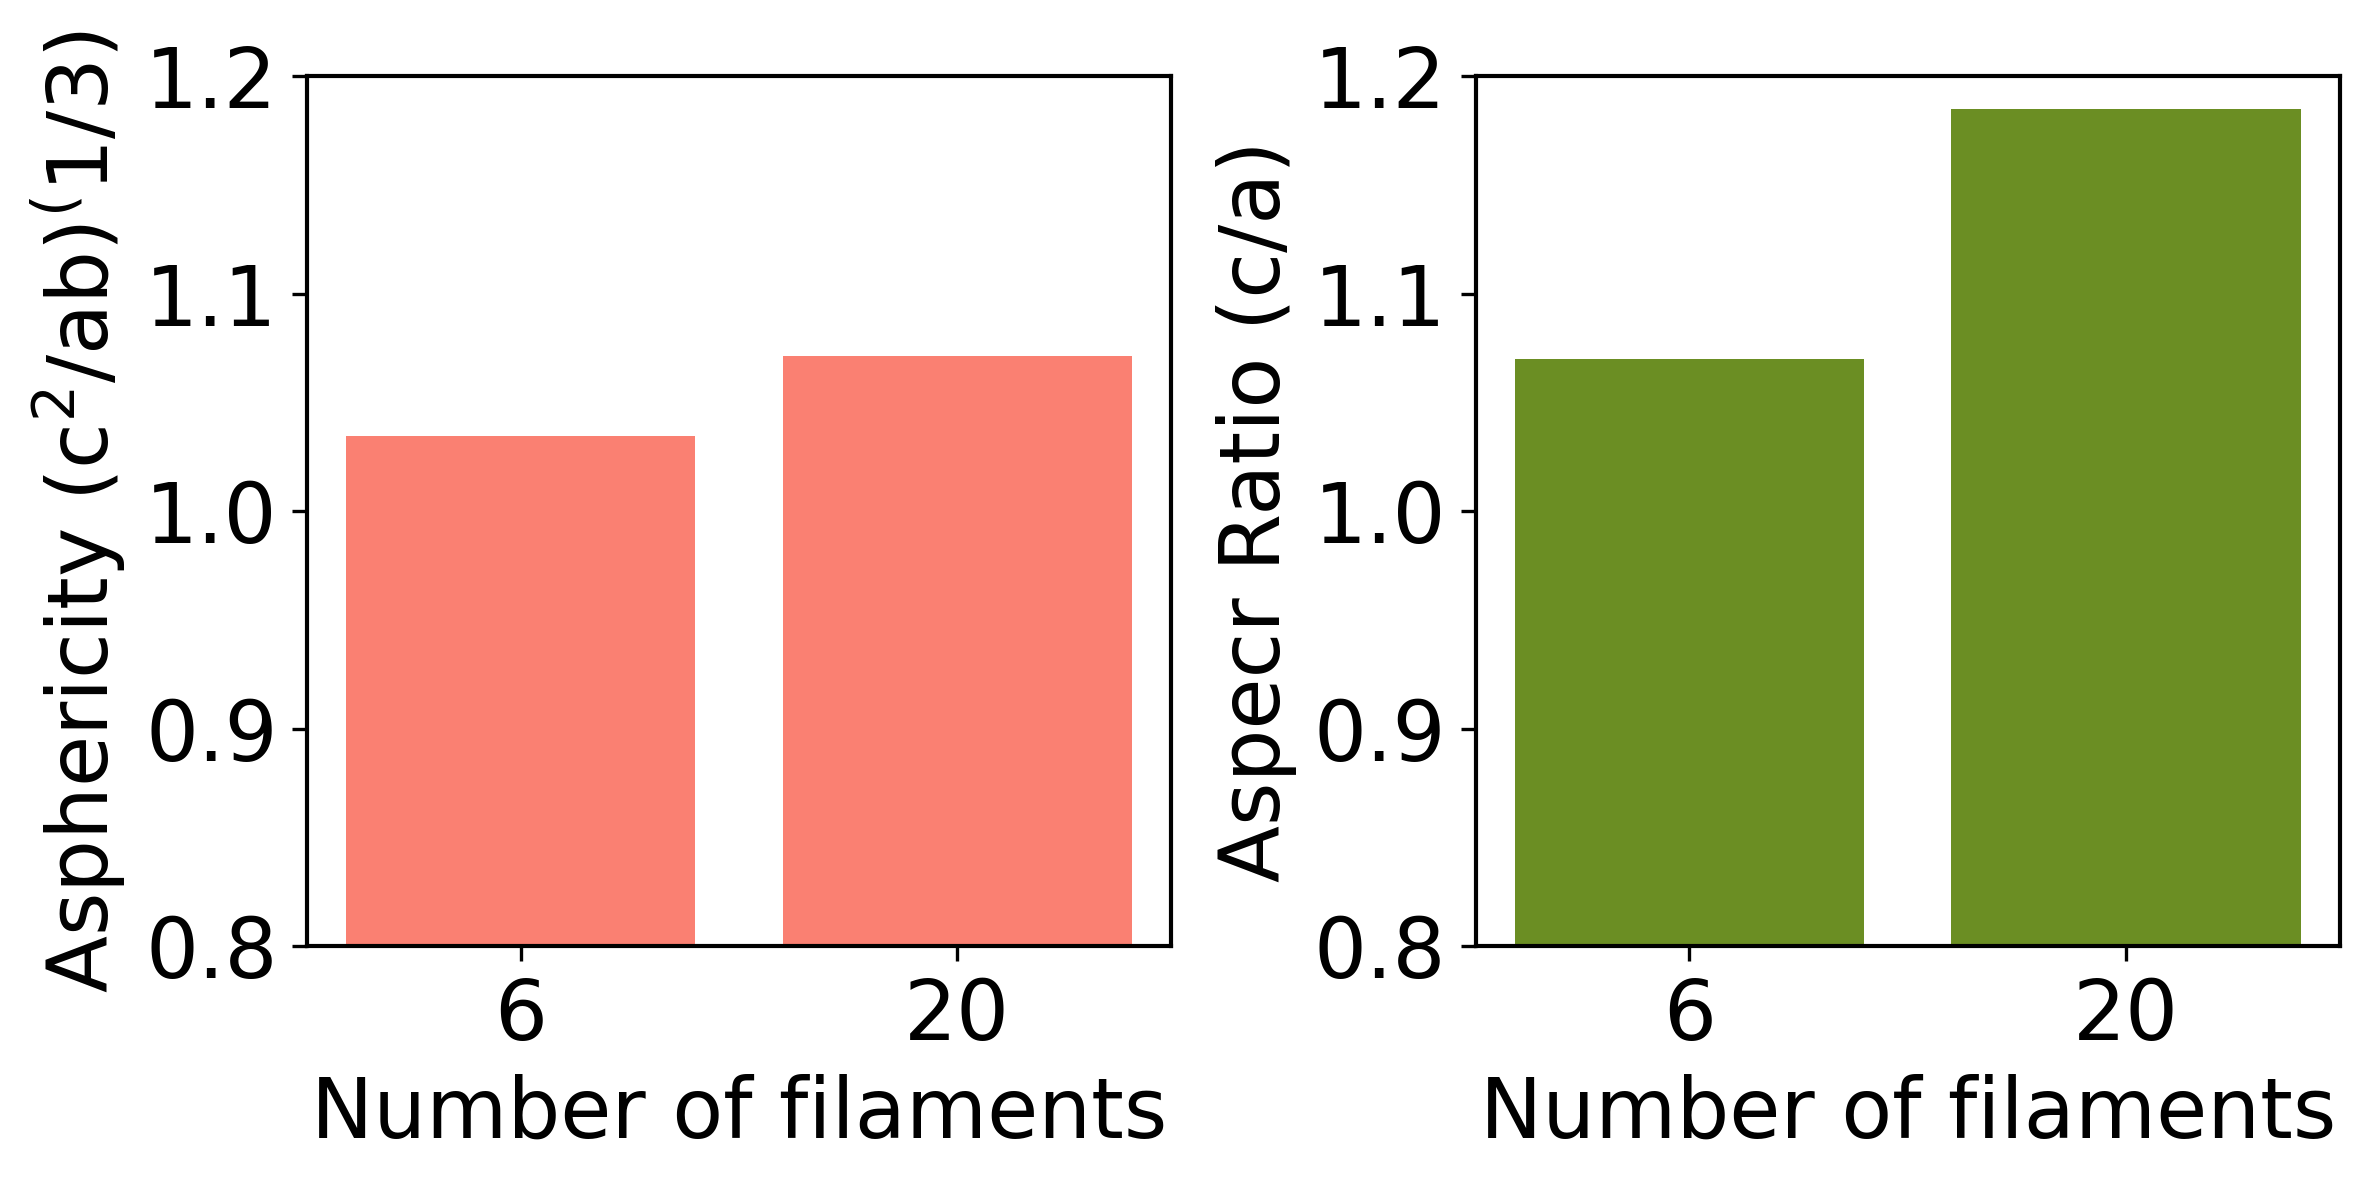

In [51]:
# Plot asphericity and aspect ratio (largest over smallest)
fig, axvec = plt.subplots(nrows=1, ncols=2,figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')
ax=axvec[0];
ax.bar([1,2],[1.0347,1.0714],color='salmon')
ax.set_xticks([1,2])
ax.set_xticklabels([6,20],fontsize=20)
ax.set_ylim([0.8,1.2])
ax.set_yticks([0.8,0.9,1.0,1.1,1.2],fontsize=20)
ax.set_yticklabels([0.8,0.9,1.0,1.1,1.2],fontsize=20)
ax.set_xlabel('Number of filaments',fontsize=20)
ax.set_ylabel('Asphericity $(c^2/ab)^(1/3)$',fontsize=20)
############
ax=axvec[1];
ax.bar([1,2],[1.0698,1.1850],color='olivedrab')
ax.set_xticks([1,2])
ax.set_xticklabels([6,20],fontsize=20)
ax.set_ylim([0.8,1.2])
ax.set_yticks([0.8,0.9,1.0,1.1,1.2],fontsize=20)
ax.set_yticklabels([0.8,0.9,1.0,1.1,1.2],fontsize=20)
ax.set_xlabel('Number of filaments',fontsize=20)
ax.set_ylabel('Aspecr Ratio (c/a)',fontsize=20)
############
plt.tight_layout()

## FIGURE S1B

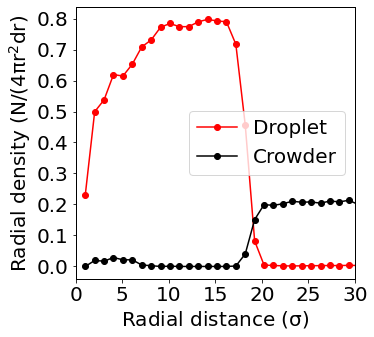

In [23]:
fig = plt.figure(figsize = (5, 5))
fpath='/Users/aravind/Research/PostDoc/Research/CytoSim/LAMMPS_codes/'
dflist=readLAMMPSfile(fpath+'data.drop.NVT','atomic');
type1df = dflist[1];
type2df = dflist[2];
###################
Coord=type1df[['CoordX','CoordY','CoordZ']].to_numpy()
com=np.mean(Coord,0)
R=Coord-com;
#print(np.shape(R))
normvec = np.linalg.norm(R,axis=1)
#print([np.min(normvec),np.max(normvec)])
Radialbinvec = np.linspace(0,85,85)
dR=Radialbinvec[1]-Radialbinvec[0];
Radialbincenter = Radialbinvec[0:len(Radialbinvec)-1]+(Radialbinvec[1]-Radialbinvec[0])
hist, bin_edges  = np.histogram(normvec,bins=Radialbinvec,density=False)
Rdensity=hist/(4*np.pi*np.power(Radialbincenter,2)*dR)
plt.plot(Radialbincenter,Rdensity,marker='o',color='red')
##################
Coord=type2df[['CoordX','CoordY','CoordZ']].to_numpy()
R=Coord-com;
#print(np.shape(R))
normvec = np.linalg.norm(R,axis=1)
#print([np.min(normvec),np.max(normvec)])
Radialbinvec = np.linspace(0,85,85)
dR=Radialbinvec[1]-Radialbinvec[0];
Radialbincenter = Radialbinvec[0:len(Radialbinvec)-1]+(Radialbinvec[1]-Radialbinvec[0])
hist, bin_edges  = np.histogram(normvec,bins=Radialbinvec,density=False)
Rdensity=hist/(4*np.pi*np.power(Radialbincenter,2)*dR)
plt.plot(Radialbincenter,Rdensity,marker='o',color='black')
plt.xlim([0,30])
plt.xlabel('Radial distance ($\sigma$)',fontsize=20)
plt.ylabel('Radial density $(N/(4\pi r^2 dr)$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['Droplet','Crowder'], fontsize=20)
# SAVE
plt.savefig('LAMMPS_density.png', dpi=300, bbox_inches='tight')
fig.savefig( 'LAMMPS_density.pdf', bbox_inches='tight')
